# Foundations in Machine Learning - Dogs vs Cats Classification

## Objective
This notebook fine-tunes an existing pre-trained model (VGG16) and builds a custom neural network to classify images in the **Dogs vs Cats** dataset. The workflow involves:
1. **Data Acquisition and Exploratory Data Analysis (EDA)**: Understanding the dataset using visualizations and statistics.
2. **Model Training**: Training and evaluating two models:
   - A custom Neural Network.
   - Fine-tuned VGG16 pre-trained on ImageNet.
3. **Performance Evaluation**: Comparing the models using metrics such as accuracy, precision, recall, F1-score, and exploring misclassified examples.
4. **Conclusions**: Summarizing insights and key findings.



## Data Acquisition and EDA

In [1]:
import os, shutil, pathlib

original_dir = pathlib.Path("../data/kaggle_dogs_vs_cats/train")
new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## Dataset Class and Image Loading

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

In [3]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

### Loading Image Data into a `Dataset` class for Training

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2024-12-02 00:41:20.934628: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-12-02 00:41:20.934650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-02 00:41:20.934658: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-02 00:41:20.934683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-02 00:41:20.934695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Custom CNN and Data Augmentation

## Custom CNN and Data Augmentation

### Objective:
Build a custom convolutional neural network (CNN) to classify the images into Dogs or Cats. Use data augmentation techniques to improve model generalization.

### Key Steps:
1. Define a custom CNN architecture.
2. Train the model using augmented data.
3. Save the best model using callbacks.
4. Plot training and validation performance metrics.

In [5]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [7]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Running the Model and Callback

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.h5",  # Use .h5 extension for HDF5 format
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


2024-12-02 00:41:29.431144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 8s 80ms/step - loss: 0.7274 - accuracy: 0.4935 - val_loss: 0.6923 - val_accuracy: 0.5030
Epoch 2/30
 1/63 [..............................] - ETA: 8s - loss: 0.6860 - accuracy: 0.6875

/Users/avtarsingh/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 5s 74ms/step - loss: 0.7087 - accuracy: 0.5270 - val_loss: 0.6808 - val_accuracy: 0.5300
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6945 - accuracy: 0.5960 - val_loss: 0.6388 - val_accuracy: 0.6450
Epoch 4/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6530 - accuracy: 0.6335 - val_loss: 0.6122 - val_accuracy: 0.6560
Epoch 5/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6308 - accuracy: 0.6690 - val_loss: 0.6533 - val_accuracy: 0.6300
Epoch 6/30
63/63 [==============================] - 5s 73ms/step - loss: 0.5831 - accuracy: 0.6910 - val_loss: 0.5898 - val_accuracy: 0.6850
Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 0.5369 - accuracy: 0.7370 - val_loss: 0.5986 - val_accuracy: 0.6890
Epoch 8/30
63/63 [==============================] - 5s 72ms/step - loss: 0.4897 - accuracy: 0.7705 - val_loss: 0.5932 - val_accuracy: 0.7220
Epoch 9/30
63/63 [======

### Displaying the Results

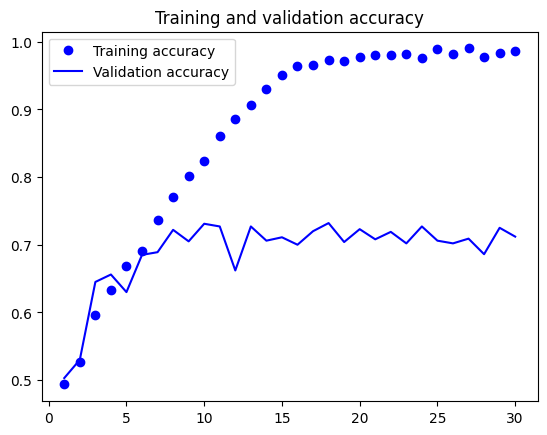

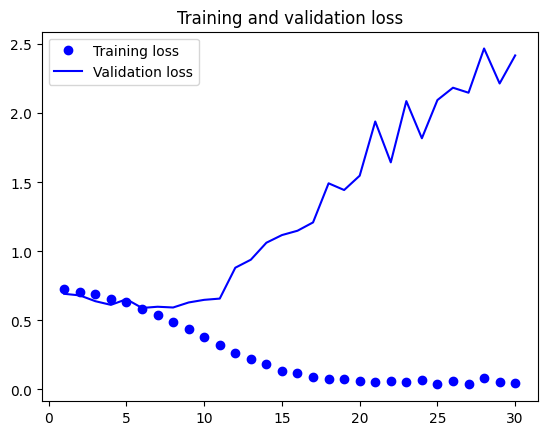

In [10]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We can see overfitting around epoch 12

**Evaluating the model on the test set**

In [15]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

OSError: No file or directory found at ./models/convnet_from_scratch.keras

### Using data augmentation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

2024-12-02 00:52:17.478075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-02 00:52:17.856142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-02 00:52:17.901080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-02 00:52:17.944544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-02 00:52:17.984381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-02 00:52:18.024671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

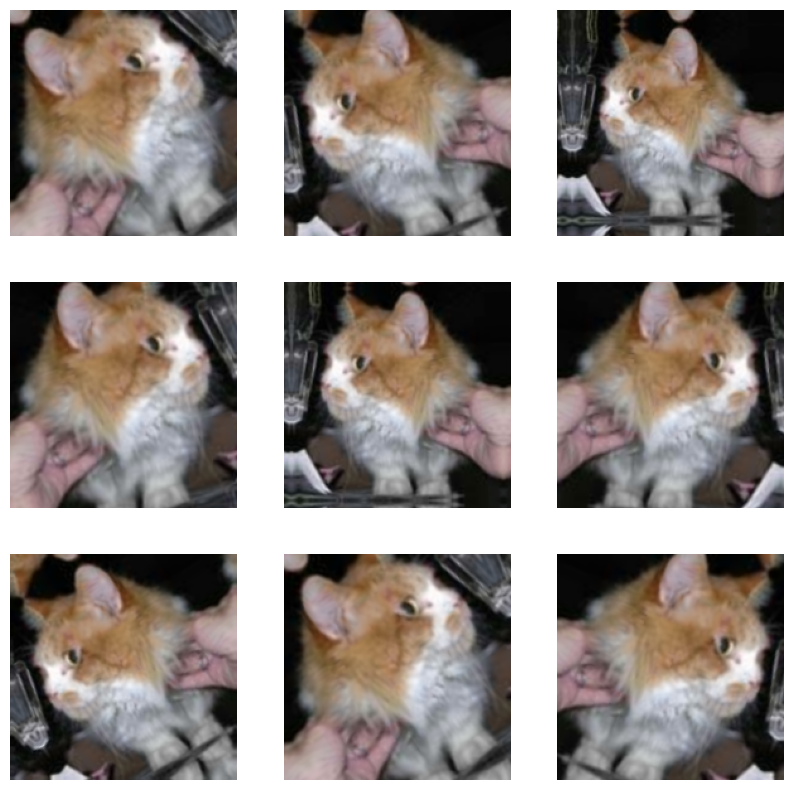

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

Our new model includes two changes compared to the previous one:
1. data augmentation as the first step
2. a dropout layer just before the last layer for regularization

In [40]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [41]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

### Training the Model for 100 Epochs

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)



Epoch 1/100


2024-12-03 15:19:37.916490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 1.0294 - accuracy: 0.4688  

2024-12-03 15:19:38.364947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:38.504688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.8317 - accuracy: 0.4750

2024-12-03 15:19:38.606626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:38.694037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:38.782286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.7844 - accuracy: 0.4727

2024-12-03 15:19:38.877613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:38.969664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.059620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.7606 - accuracy: 0.4801

2024-12-03 15:19:39.154897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.247029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.336917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.7462 - accuracy: 0.4866

2024-12-03 15:19:39.431733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.520808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.609392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.7373 - accuracy: 0.4890

2024-12-03 15:19:39.699538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.787627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:39.876526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.7305 - accuracy: 0.5063

2024-12-03 15:19:39.961333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.050854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.141390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.7260 - accuracy: 0.5000

2024-12-03 15:19:40.230453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.321563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.410957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.7221 - accuracy: 0.5048

2024-12-03 15:19:40.531608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.621660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.708430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.7196 - accuracy: 0.5022

2024-12-03 15:19:40.798204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.886472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:40.974280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.7170 - accuracy: 0.5049

2024-12-03 15:19:41.063824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.151779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.242147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.7149 - accuracy: 0.5036

2024-12-03 15:19:41.330449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.419595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.509101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.7130 - accuracy: 0.5082

2024-12-03 15:19:41.596051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.685811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.776721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.7117 - accuracy: 0.5046

2024-12-03 15:19:41.863800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:41.953663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.043090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.7105 - accuracy: 0.5078

2024-12-03 15:19:42.132902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.224530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.312716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.7097 - accuracy: 0.5061

2024-12-03 15:19:42.403285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.529464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.7088 - accuracy: 0.5051

2024-12-03 15:19:42.621420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.714406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.804423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.7080 - accuracy: 0.5036

2024-12-03 15:19:42.894269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:42.985432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.076236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.7072 - accuracy: 0.5068

2024-12-03 15:19:43.165880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.252543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.337508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.7066 - accuracy: 0.5070

2024-12-03 15:19:43.425244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.511322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.595951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.7060 - accuracy: 0.5077

2024-12-03 15:19:43.683155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.769245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:43.856584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.7058 - accuracy: 0.5066

2024-12-03 15:19:43.941507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.5075INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 126ms/step - loss: 0.7057 - accuracy: 0.5075 - val_loss: 0.6910 - val_accuracy: 0.6110
Epoch 2/100


2024-12-03 15:19:46.200345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.6878 - accuracy: 0.6250

2024-12-03 15:19:46.384518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6839 - accuracy: 0.5938

2024-12-03 15:19:46.479834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:46.568292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6887 - accuracy: 0.5859

2024-12-03 15:19:46.659021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6924 - accuracy: 0.5312

2024-12-03 15:19:46.750330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:46.837845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6926 - accuracy: 0.5134

2024-12-03 15:19:46.928304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6921 - accuracy: 0.5104

2024-12-03 15:19:47.020602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:47.114085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6921 - accuracy: 0.5094

2024-12-03 15:19:47.212473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 4s - loss: 0.6912 - accuracy: 0.5227

2024-12-03 15:19:47.310186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6911 - accuracy: 0.5208

2024-12-03 15:19:47.436743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.6931 - accuracy: 0.4978

2024-12-03 15:19:47.530048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:47.619058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6931 - accuracy: 0.4958

2024-12-03 15:19:47.710049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.6930 - accuracy: 0.4982

2024-12-03 15:19:47.800997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:47.888900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.6927 - accuracy: 0.5052

2024-12-03 15:19:47.979864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.6932 - accuracy: 0.5016

2024-12-03 15:19:48.069752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:48.165732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.6933 - accuracy: 0.5000

2024-12-03 15:19:48.259413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6930 - accuracy: 0.5027

2024-12-03 15:19:48.359759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:48.464244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6922 - accuracy: 0.5052

2024-12-03 15:19:48.585860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.6914 - accuracy: 0.5132

2024-12-03 15:19:48.687599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:48.787160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6980 - accuracy: 0.5069

2024-12-03 15:19:48.900028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.6975 - accuracy: 0.5140

2024-12-03 15:19:49.005718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.6970 - accuracy: 0.5177

2024-12-03 15:19:49.103772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:49.209926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.6965 - accuracy: 0.5212

2024-12-03 15:19:49.317714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6965 - accuracy: 0.5246

2024-12-03 15:19:49.417150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6964 - accuracy: 0.5276

2024-12-03 15:19:49.523872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:49.623420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6965 - accuracy: 0.5250

2024-12-03 15:19:49.806447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.6964 - accuracy: 0.5236

2024-12-03 15:19:49.899637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:50.009643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6961 - accuracy: 0.5248

2024-12-03 15:19:50.107455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:50.201912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.6959 - accuracy: 0.5281

2024-12-03 15:19:50.295606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5335

2024-12-03 15:19:50.392260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:50.487331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6939 - accuracy: 0.5378

2024-12-03 15:19:50.585497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6936 - accuracy: 0.5368

2024-12-03 15:19:50.679987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:50.772583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.6934 - accuracy: 0.5394

2024-12-03 15:19:50.867427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6942 - accuracy: 0.5410

2024-12-03 15:19:50.960636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:51.053761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6939 - accuracy: 0.5415

2024-12-03 15:19:51.145110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6947 - accuracy: 0.5394

2024-12-03 15:19:51.276209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.6944 - accuracy: 0.5433

2024-12-03 15:19:51.368937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:51.462554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6944 - accuracy: 0.5413

2024-12-03 15:19:51.552537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6941 - accuracy: 0.5420

2024-12-03 15:19:51.647406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:51.733974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6938 - accuracy: 0.5424

2024-12-03 15:19:51.820743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6926 - accuracy: 0.5458

2024-12-03 15:19:51.914111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:52.001266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6956 - accuracy: 0.5434

2024-12-03 15:19:52.087954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.5420

2024-12-03 15:19:52.182799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:52.270051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.5449

2024-12-03 15:19:52.356688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.5450INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 132ms/step - loss: 0.6951 - accuracy: 0.5450 - val_loss: 0.6880 - val_accuracy: 0.5090
Epoch 3/100


2024-12-03 15:19:54.595863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.6792 - accuracy: 0.4688

2024-12-03 15:19:54.786886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6771 - accuracy: 0.5729

2024-12-03 15:19:54.883083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:54.975524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6769 - accuracy: 0.5703

2024-12-03 15:19:55.071164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6758 - accuracy: 0.5781

2024-12-03 15:19:55.166981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:55.259264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6783 - accuracy: 0.5625

2024-12-03 15:19:55.360338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.6775 - accuracy: 0.5590

2024-12-03 15:19:55.454561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:55.548111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.6793 - accuracy: 0.5500

2024-12-03 15:19:55.641906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.6855 - accuracy: 0.5398

2024-12-03 15:19:55.785033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6861 - accuracy: 0.5361

2024-12-03 15:19:55.878698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:55.977603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.6872 - accuracy: 0.5290

2024-12-03 15:19:56.073885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6865 - accuracy: 0.5332

2024-12-03 15:19:56.168024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:56.261370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.6864 - accuracy: 0.5349

2024-12-03 15:19:56.352990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.6856 - accuracy: 0.5428

2024-12-03 15:19:56.446886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:56.544598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.6857 - accuracy: 0.5359

2024-12-03 15:19:56.637206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.6852 - accuracy: 0.5372

2024-12-03 15:19:56.730429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.6867 - accuracy: 0.5398

2024-12-03 15:19:56.851296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6860 - accuracy: 0.5417

2024-12-03 15:19:56.949690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:57.040065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6860 - accuracy: 0.5475

2024-12-03 15:19:57.127302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.6858 - accuracy: 0.5498

2024-12-03 15:19:57.232590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:57.325607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.6854 - accuracy: 0.5536

2024-12-03 15:19:57.415875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.6853 - accuracy: 0.5562

2024-12-03 15:19:57.504917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:57.596382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.6852 - accuracy: 0.5585

2024-12-03 15:19:57.686827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.6937 - accuracy: 0.5568

2024-12-03 15:19:57.777349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:57.869333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.6924 - accuracy: 0.5538

2024-12-03 15:19:57.981419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.073007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.162887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.6918 - accuracy: 0.5505

2024-12-03 15:19:58.252440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.343904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.433898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.6905 - accuracy: 0.5513

2024-12-03 15:19:58.523507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.614045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.704397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6891 - accuracy: 0.5569

2024-12-03 15:19:58.793559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.884446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:58.970480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6931 - accuracy: 0.5521

2024-12-03 15:19:59.060843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.150833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.237882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.6921 - accuracy: 0.5539

2024-12-03 15:19:59.327457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.419895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.507082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.6918 - accuracy: 0.5532

2024-12-03 15:19:59.598476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.686995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.773868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6909 - accuracy: 0.5565

2024-12-03 15:19:59.867473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:19:59.955311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:00.042062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6941 - accuracy: 0.5562

2024-12-03 15:20:00.127343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:00.216089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:00.299740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5570

2024-12-03 15:20:00.386049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:00.471165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 122ms/step - loss: 0.6927 - accuracy: 0.5570 - val_loss: 0.6643 - val_accuracy: 0.5770
Epoch 4/100


2024-12-03 15:20:02.353585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.6435 - accuracy: 0.6250

2024-12-03 15:20:02.532732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6890 - accuracy: 0.5312

2024-12-03 15:20:02.631124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:02.724439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.7196 - accuracy: 0.5391

2024-12-03 15:20:02.814193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.7071 - accuracy: 0.5417

2024-12-03 15:20:02.907189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:02.995818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.7011 - accuracy: 0.5536

2024-12-03 15:20:03.097891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.6916 - accuracy: 0.5660

2024-12-03 15:20:03.190887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:03.304662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.6822 - accuracy: 0.5824

2024-12-03 15:20:03.402777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:03.496530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6784 - accuracy: 0.5938

2024-12-03 15:20:03.587711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.6737 - accuracy: 0.6071

2024-12-03 15:20:03.678991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:03.770013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6710 - accuracy: 0.6125

2024-12-03 15:20:03.862365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.6693 - accuracy: 0.6121

2024-12-03 15:20:03.954495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:04.045852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.6804 - accuracy: 0.6007

2024-12-03 15:20:04.136871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.6809 - accuracy: 0.5953

2024-12-03 15:20:04.229886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:04.319469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6828 - accuracy: 0.5938

2024-12-03 15:20:04.436775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:04.537930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:04.627012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.6827 - accuracy: 0.5877

2024-12-03 15:20:04.719634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:04.816739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:04.905071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.6821 - accuracy: 0.5862

2024-12-03 15:20:04.992211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.080230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.166477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.6765 - accuracy: 0.5996

2024-12-03 15:20:05.254451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.352805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.439920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6755 - accuracy: 0.5973

2024-12-03 15:20:05.531225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.621767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.710571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6756 - accuracy: 0.6036

2024-12-03 15:20:05.799643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.890405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:05.976771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6731 - accuracy: 0.6052

2024-12-03 15:20:06.067634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.153978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.238947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6722 - accuracy: 0.6044

2024-12-03 15:20:06.329930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.420357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.507502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6679 - accuracy: 0.6090

2024-12-03 15:20:06.601941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.692481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.780798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6692 - accuracy: 0.6100

2024-12-03 15:20:06.878556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:06.994901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.6745 - accuracy: 0.6052

2024-12-03 15:20:07.084911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:07.175803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:07.264628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6756 - accuracy: 0.6017

2024-12-03 15:20:07.354965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:07.454338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:07.548291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6769 - accuracy: 0.6020

2024-12-03 15:20:07.642577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:07.768392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6776 - accuracy: 0.5974

2024-12-03 15:20:07.863600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:07.952899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:08.040816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5970

2024-12-03 15:20:08.138179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:08.229549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.6772 - accuracy: 0.5970 - val_loss: 0.6679 - val_accuracy: 0.5950
Epoch 5/100
 1/63 [..............................] - ETA: 10s - loss: 0.6639 - accuracy: 0.6250

2024-12-03 15:20:08.926992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:09.090475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6551 - accuracy: 0.6328

2024-12-03 15:20:09.182005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:09.276877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:09.368039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6276 - accuracy: 0.6607

2024-12-03 15:20:09.459195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:09.569880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.6466 - accuracy: 0.6285

2024-12-03 15:20:09.664319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:09.761036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:09.856296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.6550 - accuracy: 0.6146

2024-12-03 15:20:09.973726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:10.076365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:10.173205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6503 - accuracy: 0.6313

2024-12-03 15:20:10.268174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:10.365196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:10.460846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.6474 - accuracy: 0.6324

2024-12-03 15:20:10.560059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:10.678692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.6432 - accuracy: 0.6299

2024-12-03 15:20:10.797895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:10.920042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.6616 - accuracy: 0.6250

2024-12-03 15:20:11.022734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:11.143196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.6600 - accuracy: 0.6289

2024-12-03 15:20:11.247683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:11.346217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:11.436088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.6630 - accuracy: 0.6202

2024-12-03 15:20:11.540760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:11.674194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.6626 - accuracy: 0.6196

2024-12-03 15:20:11.787336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:11.888711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:11.984024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.6563 - accuracy: 0.6221

2024-12-03 15:20:12.093297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:12.190456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:12.286552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6577 - accuracy: 0.6196

2024-12-03 15:20:12.381431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:12.478416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:12.574770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6565 - accuracy: 0.6217

2024-12-03 15:20:12.692320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:12.794976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:12.891069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6562 - accuracy: 0.6204

2024-12-03 15:20:12.990377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:13.089219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:13.187063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.6550 - accuracy: 0.6221

2024-12-03 15:20:13.290357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:13.409598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6543 - accuracy: 0.6222

2024-12-03 15:20:13.509806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:13.650434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.6561 - accuracy: 0.6237

2024-12-03 15:20:13.743463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:13.860492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6555 - accuracy: 0.6237

2024-12-03 15:20:13.949353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.038725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.131797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.6541 - accuracy: 0.6232

2024-12-03 15:20:14.224140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.311854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.406685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6568 - accuracy: 0.6183

2024-12-03 15:20:14.496675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.584440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.671630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.6554 - accuracy: 0.6186

2024-12-03 15:20:14.763940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.849207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:14.933930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6565 - accuracy: 0.6169

2024-12-03 15:20:15.016945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:15.102764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:15.184526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.6569 - accuracy: 0.6165 - val_loss: 0.7401 - val_accuracy: 0.5570
Epoch 6/100
 1/63 [..............................] - ETA: 9s - loss: 0.7933 - accuracy: 0.5000

2024-12-03 15:20:15.913806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.071650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6593 - accuracy: 0.6094

2024-12-03 15:20:16.183090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.274217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.370462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6420 - accuracy: 0.6384

2024-12-03 15:20:16.477012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.582579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.672355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.6307 - accuracy: 0.6625

2024-12-03 15:20:16.778757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.875079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:16.976925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.6211 - accuracy: 0.6562

2024-12-03 15:20:17.071933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:17.162269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:17.255234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.6257 - accuracy: 0.6523

2024-12-03 15:20:17.367885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:17.464667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:17.562347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.6154 - accuracy: 0.6645

2024-12-03 15:20:17.652718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:17.741290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:17.828578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.6222 - accuracy: 0.6562

2024-12-03 15:20:17.919907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.015332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.107476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6230 - accuracy: 0.6538

2024-12-03 15:20:18.222970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.319106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.409808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.6200 - accuracy: 0.6540

2024-12-03 15:20:18.508846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.607072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.693710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.6174 - accuracy: 0.6552

2024-12-03 15:20:18.780726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.868598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:18.953739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.6270 - accuracy: 0.6535

2024-12-03 15:20:19.039089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.136824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.227417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.6250 - accuracy: 0.6503

2024-12-03 15:20:19.323795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.428892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.519087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.6304 - accuracy: 0.6438

2024-12-03 15:20:19.605955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.696331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.785348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.6285 - accuracy: 0.6461

2024-12-03 15:20:19.877268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:19.978746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.070726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.6261 - accuracy: 0.6508

2024-12-03 15:20:20.171083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.259936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.350070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6213 - accuracy: 0.6550

2024-12-03 15:20:20.438637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.528709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.617542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.6286 - accuracy: 0.6544

2024-12-03 15:20:20.721032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.816721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:20.908679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.6310 - accuracy: 0.6534

2024-12-03 15:20:21.000363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:21.095911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6320 - accuracy: 0.6497

2024-12-03 15:20:21.202297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:21.301942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:21.395982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6311 - accuracy: 0.6500

2024-12-03 15:20:21.483700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:21.575334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:21.664688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6286 - accuracy: 0.6550

2024-12-03 15:20:21.773953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:21.865144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 127ms/step - loss: 0.6286 - accuracy: 0.6550 - val_loss: 0.5891 - val_accuracy: 0.6720
Epoch 7/100


2024-12-03 15:20:23.938023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5976 - accuracy: 0.6562

2024-12-03 15:20:24.147789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:24.256346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:24.345132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6097 - accuracy: 0.6510

2024-12-03 15:20:24.434818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:24.523636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:24.609388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.5981 - accuracy: 0.6771

2024-12-03 15:20:24.702419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:24.793776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:24.885266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6339 - accuracy: 0.6719

2024-12-03 15:20:24.976765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.071768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.158246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.6214 - accuracy: 0.6854

2024-12-03 15:20:25.247590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.336441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.423082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.6109 - accuracy: 0.6967

2024-12-03 15:20:25.508807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.639738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.6106 - accuracy: 0.6875

2024-12-03 15:20:25.723146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.812498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:25.900682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.6060 - accuracy: 0.6861

2024-12-03 15:20:25.987908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.078923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.168599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.6026 - accuracy: 0.6839

2024-12-03 15:20:26.255829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.350325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.441521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.6041 - accuracy: 0.6810

2024-12-03 15:20:26.534385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.626313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.711939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.6016 - accuracy: 0.6758

2024-12-03 15:20:26.805922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.892511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:26.979967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.6011 - accuracy: 0.6786

2024-12-03 15:20:27.066495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.153656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.238387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.6024 - accuracy: 0.6785

2024-12-03 15:20:27.340734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.442139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.535647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.6061 - accuracy: 0.6745

2024-12-03 15:20:27.626128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.715471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.807166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.6023 - accuracy: 0.6797

2024-12-03 15:20:27.901049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:27.992365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.080121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.6067 - accuracy: 0.6809

2024-12-03 15:20:28.174095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.262866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.362007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.6079 - accuracy: 0.6825

2024-12-03 15:20:28.458829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.556004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.649443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6131 - accuracy: 0.6792

2024-12-03 15:20:28.743030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.841565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:28.940048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.6117 - accuracy: 0.6769

2024-12-03 15:20:29.029676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:29.121632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.6103 - accuracy: 0.6767

2024-12-03 15:20:29.234513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:29.326573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:29.410939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6089 - accuracy: 0.6798

2024-12-03 15:20:29.498050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:29.588279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:29.676260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.6770

2024-12-03 15:20:29.768811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 101ms/step - loss: 0.6105 - accuracy: 0.6770 - val_loss: 0.6384 - val_accuracy: 0.6670
Epoch 8/100
 1/63 [..............................] - ETA: 9s - loss: 0.7173 - accuracy: 0.6875

2024-12-03 15:20:30.440009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:30.594842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6021 - accuracy: 0.7188

2024-12-03 15:20:30.686487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:30.775978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:30.868687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6027 - accuracy: 0.7083

2024-12-03 15:20:30.964619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:31.070495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.5938 - accuracy: 0.7070

2024-12-03 15:20:31.228093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:31.343796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.5841 - accuracy: 0.7094

2024-12-03 15:20:31.460856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:31.575345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.5890 - accuracy: 0.7067

2024-12-03 15:20:31.688154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:31.787475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:31.885597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5893 - accuracy: 0.7090

2024-12-03 15:20:31.984107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.079286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.169382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.5950 - accuracy: 0.7089

2024-12-03 15:20:32.256794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.347382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.439105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.6036 - accuracy: 0.6918

2024-12-03 15:20:32.533549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.626751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.714051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.6039 - accuracy: 0.6888

2024-12-03 15:20:32.801671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.889735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:32.980563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5887 - accuracy: 0.7009

2024-12-03 15:20:33.114989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:33.216468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:33.311528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.5901 - accuracy: 0.6996

2024-12-03 15:20:33.407279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:33.504523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.5941 - accuracy: 0.6963

2024-12-03 15:20:33.613273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:33.730901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5931 - accuracy: 0.7022

2024-12-03 15:20:33.846055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:33.962201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5854 - accuracy: 0.7092

2024-12-03 15:20:34.076912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:34.192214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5841 - accuracy: 0.7107

2024-12-03 15:20:34.285167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:34.380197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:34.474225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.5833 - accuracy: 0.7106

2024-12-03 15:20:34.565980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:34.660731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:34.761683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5856 - accuracy: 0.7067

2024-12-03 15:20:34.861688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:34.996836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5844 - accuracy: 0.7068

2024-12-03 15:20:35.098336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:35.190886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:35.280827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5805 - accuracy: 0.7119

2024-12-03 15:20:35.372509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:35.464694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:35.558029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.5810 - accuracy: 0.7093

2024-12-03 15:20:35.651605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:35.742988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:35.831283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5824 - accuracy: 0.7048

2024-12-03 15:20:35.923041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:36.011905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:36.101055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5824 - accuracy: 0.7002

2024-12-03 15:20:36.187350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:36.274444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:36.359365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5825 - accuracy: 0.7001

2024-12-03 15:20:36.446414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:36.541928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5818 - accuracy: 0.7010

2024-12-03 15:20:36.651137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 109ms/step - loss: 0.5818 - accuracy: 0.7010 - val_loss: 0.5927 - val_accuracy: 0.6660
Epoch 9/100
 1/63 [..............................] - ETA: 9s - loss: 0.7220 - accuracy: 0.6562

2024-12-03 15:20:37.330370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:37.490265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6373 - accuracy: 0.6562

2024-12-03 15:20:37.578322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:37.667040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:37.759945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6156 - accuracy: 0.6607

2024-12-03 15:20:37.851227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:37.942846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.032126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5958 - accuracy: 0.6906

2024-12-03 15:20:38.121778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.218977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.316854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5909 - accuracy: 0.7019

2024-12-03 15:20:38.404907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.494644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.584383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5879 - accuracy: 0.7021

2024-12-03 15:20:38.674967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.804808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.5884 - accuracy: 0.6997

2024-12-03 15:20:38.899779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:38.989438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.077814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5725 - accuracy: 0.7113

2024-12-03 15:20:39.167799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.259378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.352680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5788 - accuracy: 0.7005

2024-12-03 15:20:39.445788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.542290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.634902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5809 - accuracy: 0.6956

2024-12-03 15:20:39.726352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.815820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:39.903682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.5767 - accuracy: 0.6990

2024-12-03 15:20:39.993283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.081013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.168239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5784 - accuracy: 0.6992

2024-12-03 15:20:40.261462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.389715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.5687 - accuracy: 0.7080

2024-12-03 15:20:40.476515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.570377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.655799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.5739 - accuracy: 0.7023

2024-12-03 15:20:40.742653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.835100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:40.935214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5755 - accuracy: 0.7005

2024-12-03 15:20:41.025623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.123106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.215975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5750 - accuracy: 0.7010

2024-12-03 15:20:41.309838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.406837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.502304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5779 - accuracy: 0.6988

2024-12-03 15:20:41.595127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.692138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.781501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5761 - accuracy: 0.7038

2024-12-03 15:20:41.868288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:41.958586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.045003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5769 - accuracy: 0.7011

2024-12-03 15:20:42.162245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.250185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.335897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5751 - accuracy: 0.7065

2024-12-03 15:20:42.419149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.505128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.587467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5732 - accuracy: 0.7082

2024-12-03 15:20:42.677127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.767904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:42.858616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.7061

2024-12-03 15:20:42.944077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:43.030583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:43.115150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7060INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 124ms/step - loss: 0.5792 - accuracy: 0.7060 - val_loss: 0.5708 - val_accuracy: 0.6880
Epoch 10/100


2024-12-03 15:20:45.209000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.5263 - accuracy: 0.7812 

2024-12-03 15:20:45.507706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:45.641571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.5247 - accuracy: 0.7563

2024-12-03 15:20:45.742004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:45.840872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:45.931291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.5319 - accuracy: 0.7500

2024-12-03 15:20:46.055717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:46.150782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:46.250106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.5455 - accuracy: 0.7344

2024-12-03 15:20:46.357185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:46.462712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.5637 - accuracy: 0.7067

2024-12-03 15:20:46.568121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:46.665934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:46.764166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5656 - accuracy: 0.7109

2024-12-03 15:20:46.862162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:46.963650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.061174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.5590 - accuracy: 0.7171

2024-12-03 15:20:47.156830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.247221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.337095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.5610 - accuracy: 0.7173

2024-12-03 15:20:47.429057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.528012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.628280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5610 - accuracy: 0.7150

2024-12-03 15:20:47.725079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.821643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:47.910498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5556 - accuracy: 0.7277

2024-12-03 15:20:47.998965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.089209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.176950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.5556 - accuracy: 0.7268

2024-12-03 15:20:48.299365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.407852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.5543 - accuracy: 0.7263

2024-12-03 15:20:48.504425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.602841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.702729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5525 - accuracy: 0.7274

2024-12-03 15:20:48.796018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.891124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:48.979071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5516 - accuracy: 0.7284

2024-12-03 15:20:49.070750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.163864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.262815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.5473 - accuracy: 0.7284

2024-12-03 15:20:49.353322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.443064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.534012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5553 - accuracy: 0.7222

2024-12-03 15:20:49.623480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.719318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.816229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5495 - accuracy: 0.7253

2024-12-03 15:20:49.904517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:49.998204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.087554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5570 - accuracy: 0.7206

2024-12-03 15:20:50.183836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.282018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.372797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5503 - accuracy: 0.7257

2024-12-03 15:20:50.463026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.555471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.663550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5460 - accuracy: 0.7275

2024-12-03 15:20:50.761549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.851898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:50.941595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5479 - accuracy: 0.7271

2024-12-03 15:20:51.027287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:51.113651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:51.200656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7235

2024-12-03 15:20:51.287315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:51.378669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 127ms/step - loss: 0.5481 - accuracy: 0.7235 - val_loss: 0.5632 - val_accuracy: 0.6940
Epoch 11/100


2024-12-03 15:20:53.390108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.7154 - accuracy: 0.6875

2024-12-03 15:20:53.574203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.6910 - accuracy: 0.6979

2024-12-03 15:20:53.668397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:53.754735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6663 - accuracy: 0.7109

2024-12-03 15:20:53.840342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6498 - accuracy: 0.6771

2024-12-03 15:20:53.927591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:54.016879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.6316 - accuracy: 0.6920

2024-12-03 15:20:54.112555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.6106 - accuracy: 0.7049

2024-12-03 15:20:54.205654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:54.294859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6087 - accuracy: 0.6969

2024-12-03 15:20:54.384278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5915 - accuracy: 0.7057

2024-12-03 15:20:54.476226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:54.570123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5899 - accuracy: 0.7043

2024-12-03 15:20:54.666504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.5933 - accuracy: 0.7076

2024-12-03 15:20:54.756584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5985 - accuracy: 0.7021

2024-12-03 15:20:54.879108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.5976 - accuracy: 0.6985

2024-12-03 15:20:54.971745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:55.062112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.5963 - accuracy: 0.6979

2024-12-03 15:20:55.152142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 3s - loss: 0.5974 - accuracy: 0.6922

2024-12-03 15:20:55.249960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:55.342699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5977 - accuracy: 0.6905

2024-12-03 15:20:55.430674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5965 - accuracy: 0.6861

2024-12-03 15:20:55.521501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:55.610451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5928 - accuracy: 0.6888

2024-12-03 15:20:55.698626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.5860 - accuracy: 0.6923

2024-12-03 15:20:55.792887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:55.890784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5828 - accuracy: 0.6933

2024-12-03 15:20:55.978615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.5904 - accuracy: 0.6864

2024-12-03 15:20:56.067771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:56.158731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.5887 - accuracy: 0.6875

2024-12-03 15:20:56.245146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5871 - accuracy: 0.6845

2024-12-03 15:20:56.335142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.5835 - accuracy: 0.6885

2024-12-03 15:20:56.468240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5834 - accuracy: 0.6884

2024-12-03 15:20:56.561711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:56.659859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.5862 - accuracy: 0.6857

2024-12-03 15:20:56.758767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5772 - accuracy: 0.6892

2024-12-03 15:20:56.853531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:56.946895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.5778 - accuracy: 0.6908

2024-12-03 15:20:57.041520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.5751 - accuracy: 0.6930

2024-12-03 15:20:57.132201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:57.221004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.5709 - accuracy: 0.6959

2024-12-03 15:20:57.310348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5733 - accuracy: 0.6933

2024-12-03 15:20:57.401768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:57.488521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.5717 - accuracy: 0.6953

2024-12-03 15:20:57.584454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5694 - accuracy: 0.6963

2024-12-03 15:20:57.679371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:57.769024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.5697 - accuracy: 0.6961

2024-12-03 15:20:57.859415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5667 - accuracy: 0.6979

2024-12-03 15:20:57.980107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.5657 - accuracy: 0.7000

2024-12-03 15:20:58.069946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:58.163761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5681 - accuracy: 0.6985

2024-12-03 15:20:58.256752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5668 - accuracy: 0.6993

2024-12-03 15:20:58.351075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:58.441049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5672 - accuracy: 0.6991

2024-12-03 15:20:58.533570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5694 - accuracy: 0.6975

2024-12-03 15:20:58.618874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:58.704081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5669 - accuracy: 0.6996

2024-12-03 15:20:58.788025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5633 - accuracy: 0.7007

2024-12-03 15:20:58.872353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:58.958244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5651 - accuracy: 0.7000

2024-12-03 15:20:59.042894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5640 - accuracy: 0.7006

2024-12-03 15:20:59.133843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:20:59.223785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.6995INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 8s 125ms/step - loss: 0.5645 - accuracy: 0.6995 - val_loss: 0.5160 - val_accuracy: 0.7360
Epoch 12/100


2024-12-03 15:21:01.332594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 10s - loss: 0.6273 - accuracy: 0.7188

2024-12-03 15:21:01.512079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5655 - accuracy: 0.7500

2024-12-03 15:21:01.606933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:01.700959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5377 - accuracy: 0.7812

2024-12-03 15:21:01.788424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.5466 - accuracy: 0.7552

2024-12-03 15:21:01.879592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:01.969376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.5502 - accuracy: 0.7500

2024-12-03 15:21:02.068450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.5891 - accuracy: 0.7396

2024-12-03 15:21:02.165436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:02.257631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5871 - accuracy: 0.7312

2024-12-03 15:21:02.345028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5856 - accuracy: 0.7188

2024-12-03 15:21:02.435643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:02.529639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5895 - accuracy: 0.7063

2024-12-03 15:21:02.646263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:02.741515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:02.836196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.5858 - accuracy: 0.7118

2024-12-03 15:21:02.925773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.015048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.108545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.5858 - accuracy: 0.7098

2024-12-03 15:21:03.200698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.288105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.374076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5747 - accuracy: 0.7135

2024-12-03 15:21:03.459607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.544360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.632778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5685 - accuracy: 0.7222

2024-12-03 15:21:03.731976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.824868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:03.915844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.5614 - accuracy: 0.7302

2024-12-03 15:21:04.002350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.089007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.174715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5564 - accuracy: 0.7348

2024-12-03 15:21:04.260230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.347659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.437999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5586 - accuracy: 0.7344

2024-12-03 15:21:04.530564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.618586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.703127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5554 - accuracy: 0.7332

2024-12-03 15:21:04.797745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.885901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:04.970592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5577 - accuracy: 0.7299

2024-12-03 15:21:05.068414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.164473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.254082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5530 - accuracy: 0.7361

2024-12-03 15:21:05.345821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.441538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.529665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5527 - accuracy: 0.7363

2024-12-03 15:21:05.620303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.715294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.801859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5497 - accuracy: 0.7384

2024-12-03 15:21:05.893105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:05.984223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.073725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5471 - accuracy: 0.7378

2024-12-03 15:21:06.165875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.257386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.341266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5498 - accuracy: 0.7352

2024-12-03 15:21:06.426555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.510072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.595047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5514 - accuracy: 0.7328

2024-12-03 15:21:06.693894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.781511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:06.866664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5501 - accuracy: 0.7319

2024-12-03 15:21:06.949414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:07.063090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 101ms/step - loss: 0.5503 - accuracy: 0.7310 - val_loss: 0.5798 - val_accuracy: 0.6960
Epoch 13/100
 1/63 [..............................] - ETA: 12s - loss: 0.5039 - accuracy: 0.6875

2024-12-03 15:21:07.744172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5796 - accuracy: 0.7292

2024-12-03 15:21:07.946674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.033181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.119632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.6397 - accuracy: 0.7031

2024-12-03 15:21:08.206757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.294378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.394309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.6192 - accuracy: 0.7153

2024-12-03 15:21:08.519961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.622144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.717663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.6047 - accuracy: 0.7083

2024-12-03 15:21:08.813147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:08.907182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.003889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.5887 - accuracy: 0.7146

2024-12-03 15:21:09.098912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.196117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.289998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.5877 - accuracy: 0.7101

2024-12-03 15:21:09.384979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.480044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.569457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.5902 - accuracy: 0.7113

2024-12-03 15:21:09.659501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.760132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:09.856261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.5736 - accuracy: 0.7188

2024-12-03 15:21:09.950216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.038478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.127536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.5725 - accuracy: 0.7164

2024-12-03 15:21:10.217141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.307069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.395859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.5625 - accuracy: 0.7177

2024-12-03 15:21:10.488288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.575715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.660989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.5635 - accuracy: 0.7169

2024-12-03 15:21:10.746912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.835138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:10.920685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.5594 - accuracy: 0.7205

2024-12-03 15:21:11.015333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.110850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.206470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.5618 - accuracy: 0.7188

2024-12-03 15:21:11.293429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.381171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.469174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5555 - accuracy: 0.7262

2024-12-03 15:21:11.554723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.644000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.735583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5515 - accuracy: 0.7292

2024-12-03 15:21:11.866111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:11.964451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.051510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5462 - accuracy: 0.7331

2024-12-03 15:21:12.143365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.233734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.321308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5473 - accuracy: 0.7304

2024-12-03 15:21:12.409121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.505385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5416 - accuracy: 0.7347

2024-12-03 15:21:12.612250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.711258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.811268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.5416 - accuracy: 0.7333

2024-12-03 15:21:12.899711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:12.987907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:13.078955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5343 - accuracy: 0.7389

2024-12-03 15:21:13.188316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:13.292706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5340 - accuracy: 0.7372

2024-12-03 15:21:13.391683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:13.489341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:13.581193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7385

2024-12-03 15:21:13.672935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.5335 - accuracy: 0.7385 - val_loss: 0.5816 - val_accuracy: 0.7110
Epoch 14/100
 1/63 [..............................] - ETA: 11s - loss: 0.6129 - accuracy: 0.6562

2024-12-03 15:21:14.434442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:14.616395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.6445 - accuracy: 0.6406

2024-12-03 15:21:14.707646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:14.797720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:14.884089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5990 - accuracy: 0.6830

2024-12-03 15:21:14.972527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.059925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.148094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.6022 - accuracy: 0.6719

2024-12-03 15:21:15.237860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.334273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.423259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5655 - accuracy: 0.7067

2024-12-03 15:21:15.513457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.608844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.704479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5493 - accuracy: 0.7246

2024-12-03 15:21:15.795179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.885152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:15.969955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5571 - accuracy: 0.7237

2024-12-03 15:21:16.057273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:16.144903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:16.235737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5508 - accuracy: 0.7244

2024-12-03 15:21:16.330970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:16.425633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:16.517977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5337 - accuracy: 0.7362

2024-12-03 15:21:16.631737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:16.727299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:16.815421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5288 - accuracy: 0.7388

2024-12-03 15:21:16.905635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.000122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.089247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5320 - accuracy: 0.7369

2024-12-03 15:21:17.179389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.267240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.353235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5328 - accuracy: 0.7390

2024-12-03 15:21:17.437861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.524397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.611970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5324 - accuracy: 0.7356

2024-12-03 15:21:17.701165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.789251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:17.872946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.5280 - accuracy: 0.7414

2024-12-03 15:21:17.961007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.049278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.141818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.5289 - accuracy: 0.7427

2024-12-03 15:21:18.268883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.360335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.446299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.5330 - accuracy: 0.7439

2024-12-03 15:21:18.536275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.620171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.708147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.5296 - accuracy: 0.7436

2024-12-03 15:21:18.798466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.891613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:18.982496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 0s - loss: 0.5240 - accuracy: 0.7464

2024-12-03 15:21:19.072255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.163268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.249184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.5202 - accuracy: 0.7494

2024-12-03 15:21:19.334551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.417176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.504636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.5235 - accuracy: 0.7473

2024-12-03 15:21:19.592957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.680390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.768971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.7464

2024-12-03 15:21:19.859098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:19.951481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:20.033454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.7460

2024-12-03 15:21:20.116566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 99ms/step - loss: 0.5249 - accuracy: 0.7460 - val_loss: 0.5796 - val_accuracy: 0.6730
Epoch 15/100
 1/63 [..............................] - ETA: 9s - loss: 0.6390 - accuracy: 0.5938

2024-12-03 15:21:20.780973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:20.936948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5701 - accuracy: 0.6719

2024-12-03 15:21:21.023052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.109119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.195601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.5827 - accuracy: 0.6741

2024-12-03 15:21:21.284333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.378335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.464852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5630 - accuracy: 0.6969

2024-12-03 15:21:21.552293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.654671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.742839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.5511 - accuracy: 0.7067

2024-12-03 15:21:21.829640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:21.923499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.015211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.5482 - accuracy: 0.7129

2024-12-03 15:21:22.103533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.195324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.281572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5361 - accuracy: 0.7171

2024-12-03 15:21:22.366950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.453692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.544406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.5272 - accuracy: 0.7244

2024-12-03 15:21:22.637492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.728693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:22.819856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5300 - accuracy: 0.7163

2024-12-03 15:21:22.907091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.003917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.097526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.5230 - accuracy: 0.7243

2024-12-03 15:21:23.210099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.306399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.397778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5184 - accuracy: 0.7278

2024-12-03 15:21:23.482190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.570536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.655542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5132 - accuracy: 0.7335

2024-12-03 15:21:23.741950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.828654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:23.922747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.5155 - accuracy: 0.7356

2024-12-03 15:21:24.008062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.094361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.179701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.5178 - accuracy: 0.7344

2024-12-03 15:21:24.267419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.355042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.457212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5183 - accuracy: 0.7351

2024-12-03 15:21:24.550567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.686138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5138 - accuracy: 0.7389

2024-12-03 15:21:24.782513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.879498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:24.966896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.5151 - accuracy: 0.7402

2024-12-03 15:21:25.052989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.142080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.228465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.5078 - accuracy: 0.7426

2024-12-03 15:21:25.322752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.419621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.513473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.5128 - accuracy: 0.7402

2024-12-03 15:21:25.606696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.697339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.783899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5094 - accuracy: 0.7451

2024-12-03 15:21:25.873140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:25.962788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:26.060334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.5118 - accuracy: 0.7436

2024-12-03 15:21:26.167567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:26.295453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5120 - accuracy: 0.7414

2024-12-03 15:21:26.392527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:26.479693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:26.573167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 103ms/step - loss: 0.5110 - accuracy: 0.7420 - val_loss: 0.5203 - val_accuracy: 0.7410
Epoch 16/100
 1/63 [..............................] - ETA: 12s - loss: 0.5003 - accuracy: 0.6875

2024-12-03 15:21:27.316076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:27.513185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.4924 - accuracy: 0.7344

2024-12-03 15:21:27.622281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:27.718214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:27.819605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4851 - accuracy: 0.7455

2024-12-03 15:21:27.918119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:28.019624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:28.118592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4958 - accuracy: 0.7396

2024-12-03 15:21:28.215905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:28.330753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.5323 - accuracy: 0.7273

2024-12-03 15:21:28.437814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:28.563502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.5496 - accuracy: 0.7232

2024-12-03 15:21:28.668590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:28.761642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:28.863415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.5271 - accuracy: 0.7353

2024-12-03 15:21:28.964903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.061436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.156667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.5207 - accuracy: 0.7297

2024-12-03 15:21:29.253018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.354011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.5124 - accuracy: 0.7415

2024-12-03 15:21:29.459227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.553489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.651599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.5011 - accuracy: 0.7513

2024-12-03 15:21:29.742711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.838905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:29.928973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4919 - accuracy: 0.7600

2024-12-03 15:21:30.046384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:30.146782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:30.242568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.4938 - accuracy: 0.7621

2024-12-03 15:21:30.334378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:30.427622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:30.516901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4986 - accuracy: 0.7592

2024-12-03 15:21:30.607662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:30.701102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:30.802831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4934 - accuracy: 0.7618

2024-12-03 15:21:30.908603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.003727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.100249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4965 - accuracy: 0.7641

2024-12-03 15:21:31.197597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.300994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.395714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.4941 - accuracy: 0.7641

2024-12-03 15:21:31.491362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.622453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4925 - accuracy: 0.7639

2024-12-03 15:21:31.713415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.811886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:31.910739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4890 - accuracy: 0.7689

2024-12-03 15:21:32.006083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.100332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.195473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4824 - accuracy: 0.7733

2024-12-03 15:21:32.290116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.387674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.484941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4808 - accuracy: 0.7726

2024-12-03 15:21:32.583358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.682772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.774854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4896 - accuracy: 0.7659

2024-12-03 15:21:32.869199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:32.967873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:33.058471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4878 - accuracy: 0.7693

2024-12-03 15:21:33.172340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:33.270550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:33.361380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.7685

2024-12-03 15:21:33.450407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:33.542446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 109ms/step - loss: 0.4905 - accuracy: 0.7685 - val_loss: 0.5386 - val_accuracy: 0.7560
Epoch 17/100
 1/63 [..............................] - ETA: 10s - loss: 0.5228 - accuracy: 0.7500

2024-12-03 15:21:34.285757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:34.459196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4604 - accuracy: 0.8047

2024-12-03 15:21:34.554986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:34.657190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:34.754252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.5298 - accuracy: 0.7321

2024-12-03 15:21:34.853330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:34.954464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:35.048462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.5079 - accuracy: 0.7465

2024-12-03 15:21:35.146030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:35.288725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.5027 - accuracy: 0.7474

2024-12-03 15:21:35.386329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:35.478011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:35.567464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4962 - accuracy: 0.7563

2024-12-03 15:21:35.657156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:35.747080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:35.843716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4847 - accuracy: 0.7639

2024-12-03 15:21:35.941597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.032558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.120340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4889 - accuracy: 0.7649

2024-12-03 15:21:36.209551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.302923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.389911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4930 - accuracy: 0.7643

2024-12-03 15:21:36.479345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.569284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.679668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4962 - accuracy: 0.7604

2024-12-03 15:21:36.771147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.866968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:36.965586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4931 - accuracy: 0.7656

2024-12-03 15:21:37.065181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:37.158512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:37.252995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4862 - accuracy: 0.7718

2024-12-03 15:21:37.345948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:37.444710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:37.538488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4865 - accuracy: 0.7714

2024-12-03 15:21:37.646710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:37.754957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4906 - accuracy: 0.7681

2024-12-03 15:21:37.867322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:37.962452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.058133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4881 - accuracy: 0.7698

2024-12-03 15:21:38.190829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.295593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.389559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4842 - accuracy: 0.7685

2024-12-03 15:21:38.487424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.580893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.681929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4823 - accuracy: 0.7686

2024-12-03 15:21:38.790931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.892365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:38.985723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4756 - accuracy: 0.7700

2024-12-03 15:21:39.088700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:39.192959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:39.287436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4702 - accuracy: 0.7736

2024-12-03 15:21:39.381818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:39.473638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:39.562953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4641 - accuracy: 0.7767

2024-12-03 15:21:39.651077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:39.779695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4685 - accuracy: 0.7747

2024-12-03 15:21:39.891334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:40.007506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4710 - accuracy: 0.7722

2024-12-03 15:21:40.119873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:40.229888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.7712

2024-12-03 15:21:40.330696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:40.419831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:40.503413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 109ms/step - loss: 0.4709 - accuracy: 0.7705 - val_loss: 0.5501 - val_accuracy: 0.7440
Epoch 18/100
 1/63 [..............................] - ETA: 10s - loss: 0.3324 - accuracy: 0.8750

2024-12-03 15:21:41.236341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:41.407292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5050 - accuracy: 0.7422

2024-12-03 15:21:41.495621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:41.589291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:41.680266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4998 - accuracy: 0.7292

2024-12-03 15:21:41.784429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:41.911556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.5096 - accuracy: 0.7153

2024-12-03 15:21:42.004926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.096699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.188577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.4980 - accuracy: 0.7344

2024-12-03 15:21:42.283839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.386827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.485114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4564 - accuracy: 0.7625

2024-12-03 15:21:42.589693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.690490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.787740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4914 - accuracy: 0.7500

2024-12-03 15:21:42.879689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:42.972638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.060760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.5024 - accuracy: 0.7515

2024-12-03 15:21:43.151831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.248608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.345912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.4981 - accuracy: 0.7578

2024-12-03 15:21:43.474758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.569169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.662339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4960 - accuracy: 0.7604

2024-12-03 15:21:43.759455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.850914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:43.935174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4920 - accuracy: 0.7646

2024-12-03 15:21:44.021946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.115107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.200906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.4931 - accuracy: 0.7670

2024-12-03 15:21:44.284553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.378482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.471294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4845 - accuracy: 0.7717

2024-12-03 15:21:44.565825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.659070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.750888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4962 - accuracy: 0.7664

2024-12-03 15:21:44.839723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:44.969509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4911 - accuracy: 0.7706

2024-12-03 15:21:45.069157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:45.170124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.4903 - accuracy: 0.7723

2024-12-03 15:21:45.271697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:45.385219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4878 - accuracy: 0.7727

2024-12-03 15:21:45.503254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:45.619227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4857 - accuracy: 0.7704

2024-12-03 15:21:45.725695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:45.853901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4756 - accuracy: 0.7761

2024-12-03 15:21:45.962561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:46.060990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:46.158818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4820 - accuracy: 0.7739

2024-12-03 15:21:46.289535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:46.394353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4826 - accuracy: 0.7706

2024-12-03 15:21:46.512199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:46.618827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4827 - accuracy: 0.7701

2024-12-03 15:21:46.721383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:46.820905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:46.907408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4833 - accuracy: 0.7691

2024-12-03 15:21:46.995916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:47.085229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:47.174337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4800 - accuracy: 0.7727

2024-12-03 15:21:47.268306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:47.370253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:47.463935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.4778 - accuracy: 0.7740 - val_loss: 0.9466 - val_accuracy: 0.6710
Epoch 19/100
 1/63 [..............................] - ETA: 11s - loss: 0.5262 - accuracy: 0.7812

2024-12-03 15:21:48.243493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:48.425206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 7s - loss: 0.5510 - accuracy: 0.7396

2024-12-03 15:21:48.525883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:48.670228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.5166 - accuracy: 0.7448

2024-12-03 15:21:48.768595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:48.870883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:48.968279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4832 - accuracy: 0.7708

2024-12-03 15:21:49.067728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:49.170019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:49.268255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4610 - accuracy: 0.7656

2024-12-03 15:21:49.368099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:49.468388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:49.566189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4817 - accuracy: 0.7563

2024-12-03 15:21:49.670105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:49.773677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:49.869971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.4682 - accuracy: 0.7665

2024-12-03 15:21:49.968829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:50.109971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.4624 - accuracy: 0.7750

2024-12-03 15:21:50.208030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:50.307814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:50.400358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.4711 - accuracy: 0.7690

2024-12-03 15:21:50.496969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:50.595886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4692 - accuracy: 0.7700

2024-12-03 15:21:50.703086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:50.801691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:50.898351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4647 - accuracy: 0.7701

2024-12-03 15:21:50.998723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.102040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.193427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4731 - accuracy: 0.7656

2024-12-03 15:21:51.284231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.411283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4764 - accuracy: 0.7642

2024-12-03 15:21:51.501271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.597801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.696368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4685 - accuracy: 0.7682

2024-12-03 15:21:51.789171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.877572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:51.965976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4664 - accuracy: 0.7724

2024-12-03 15:21:52.053908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.141811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.234607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.4655 - accuracy: 0.7738

2024-12-03 15:21:52.325919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.417310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.504958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4612 - accuracy: 0.7764

2024-12-03 15:21:52.592729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.681736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.774703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4531 - accuracy: 0.7786

2024-12-03 15:21:52.874063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:52.976343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.063279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4489 - accuracy: 0.7812

2024-12-03 15:21:53.156036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.247589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.339996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4546 - accuracy: 0.7778

2024-12-03 15:21:53.430610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.523214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.608346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4534 - accuracy: 0.7791

2024-12-03 15:21:53.695736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.787299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:53.876480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4524 - accuracy: 0.7797

2024-12-03 15:21:53.962884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:54.049111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:54.133349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4550 - accuracy: 0.7777

2024-12-03 15:21:54.245828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:54.327596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 135ms/step - loss: 0.4551 - accuracy: 0.7775 - val_loss: 0.4905 - val_accuracy: 0.7810
Epoch 20/100


2024-12-03 15:21:56.812135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 12s - loss: 0.3490 - accuracy: 0.9062

2024-12-03 15:21:57.010069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.4530 - accuracy: 0.8281 

2024-12-03 15:21:57.112755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.4648 - accuracy: 0.7917

2024-12-03 15:21:57.219073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.4630 - accuracy: 0.7937

2024-12-03 15:21:57.323659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4763 - accuracy: 0.7760

2024-12-03 15:21:57.420583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:57.514694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.5001 - accuracy: 0.7569

2024-12-03 15:21:57.628102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:57.720904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:57.814378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4757 - accuracy: 0.7734

2024-12-03 15:21:57.909016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.005602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.110171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4724 - accuracy: 0.7854

2024-12-03 15:21:58.213440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.315498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.412320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4524 - accuracy: 0.7969

2024-12-03 15:21:58.509320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.604934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.699476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4789 - accuracy: 0.7723

2024-12-03 15:21:58.794573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.892144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:58.993468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.4762 - accuracy: 0.7799

2024-12-03 15:21:59.097830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:59.240342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4695 - accuracy: 0.7825

2024-12-03 15:21:59.343595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:59.445309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4727 - accuracy: 0.7778

2024-12-03 15:21:59.568680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:59.680461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4671 - accuracy: 0.7802

2024-12-03 15:21:59.779904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:21:59.879083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.4589 - accuracy: 0.7853

2024-12-03 15:21:59.993970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:00.106580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4735 - accuracy: 0.7784

2024-12-03 15:22:00.207931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:00.316168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4696 - accuracy: 0.7786

2024-12-03 15:22:00.419128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:00.525512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4602 - accuracy: 0.7845

2024-12-03 15:22:00.634960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:00.738568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4690 - accuracy: 0.7837

2024-12-03 15:22:00.837025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:00.942108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.4656 - accuracy: 0.7850

2024-12-03 15:22:01.086011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:01.186789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:01.280215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4700 - accuracy: 0.7812

2024-12-03 15:22:01.374752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:01.472619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:01.576067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4599 - accuracy: 0.7878

2024-12-03 15:22:01.693908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:01.797404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4590 - accuracy: 0.7876

2024-12-03 15:22:01.900385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:02.007073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4564 - accuracy: 0.7886

2024-12-03 15:22:02.107935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:02.227026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.4562 - accuracy: 0.7889

2024-12-03 15:22:02.329564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:02.472908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4549 - accuracy: 0.7868

2024-12-03 15:22:02.570086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:02.673260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4540 - accuracy: 0.7872

2024-12-03 15:22:02.773859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:02.872822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:02.972979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4600 - accuracy: 0.7823

2024-12-03 15:22:03.071358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:03.170352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.7815

2024-12-03 15:22:03.276187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:03.388305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 138ms/step - loss: 0.4615 - accuracy: 0.7815 - val_loss: 0.4683 - val_accuracy: 0.7900
Epoch 21/100


2024-12-03 15:22:05.591520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 12s - loss: 0.5992 - accuracy: 0.6875

2024-12-03 15:22:05.790955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5037 - accuracy: 0.7604

2024-12-03 15:22:05.891048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:05.984568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5130 - accuracy: 0.7578

2024-12-03 15:22:06.078536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4789 - accuracy: 0.7865

2024-12-03 15:22:06.170320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:06.269676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4887 - accuracy: 0.7812

2024-12-03 15:22:06.367370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.4799 - accuracy: 0.7852

2024-12-03 15:22:06.509707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.4752 - accuracy: 0.7750

2024-12-03 15:22:06.613924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.4769 - accuracy: 0.7670

2024-12-03 15:22:06.718370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4812 - accuracy: 0.7604

2024-12-03 15:22:06.819513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.4859 - accuracy: 0.7596

2024-12-03 15:22:06.922006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:07.018853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4858 - accuracy: 0.7604

2024-12-03 15:22:07.124813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:07.227555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.4697 - accuracy: 0.7721

2024-12-03 15:22:07.340547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:07.466462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4584 - accuracy: 0.7763

2024-12-03 15:22:07.640340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:07.754893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4573 - accuracy: 0.7738

2024-12-03 15:22:07.868808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:07.986579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.4579 - accuracy: 0.7772

2024-12-03 15:22:08.086112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:08.223204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4689 - accuracy: 0.7725

2024-12-03 15:22:08.339701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:08.459154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4731 - accuracy: 0.7720

2024-12-03 15:22:08.572386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:08.678898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4689 - accuracy: 0.7769

2024-12-03 15:22:08.785588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:08.914494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.4609 - accuracy: 0.7823

2024-12-03 15:22:09.022897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:09.144531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.4577 - accuracy: 0.7860

2024-12-03 15:22:09.251265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:09.362740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.4511 - accuracy: 0.7902

2024-12-03 15:22:09.477190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:09.581794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4478 - accuracy: 0.7911

2024-12-03 15:22:09.686632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:09.789676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4491 - accuracy: 0.7909

2024-12-03 15:22:09.896305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:10.019899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4484 - accuracy: 0.7912

2024-12-03 15:22:10.179706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:10.293273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4467 - accuracy: 0.7936

2024-12-03 15:22:10.412061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:10.528356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.4449 - accuracy: 0.7958

2024-12-03 15:22:10.648985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:10.764418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4397 - accuracy: 0.7999

2024-12-03 15:22:10.879415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:10.992598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4406 - accuracy: 0.8004

2024-12-03 15:22:11.108855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:11.225941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.4428 - accuracy: 0.7990

2024-12-03 15:22:11.343400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:11.489570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.4408 - accuracy: 0.8032

2024-12-03 15:22:11.588426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:11.689258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:11.780332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4426 - accuracy: 0.8036

2024-12-03 15:22:11.881474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:11.998853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4399 - accuracy: 0.8061

2024-12-03 15:22:12.099175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:12.199540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:12.297007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.4389 - accuracy: 0.8039

2024-12-03 15:22:12.398073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:12.493294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:12.583901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 122ms/step - loss: 0.4372 - accuracy: 0.8050 - val_loss: 0.5206 - val_accuracy: 0.7620
Epoch 22/100
 1/63 [..............................] - ETA: 10s - loss: 0.7227 - accuracy: 0.7812

2024-12-03 15:22:13.340121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:13.509150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4768 - accuracy: 0.8203

2024-12-03 15:22:13.601247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:13.696275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:13.791039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4852 - accuracy: 0.8080

2024-12-03 15:22:13.881701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:13.978958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.072324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4915 - accuracy: 0.7875

2024-12-03 15:22:14.168137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.266508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.355056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4801 - accuracy: 0.7957

2024-12-03 15:22:14.444292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.537053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.628161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4950 - accuracy: 0.7812

2024-12-03 15:22:14.741590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.838353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:14.926754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4744 - accuracy: 0.7911

2024-12-03 15:22:15.021352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.115840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.204835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4638 - accuracy: 0.7983

2024-12-03 15:22:15.306005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.412830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.506254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4597 - accuracy: 0.8012

2024-12-03 15:22:15.602100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.690536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.782081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4682 - accuracy: 0.7924

2024-12-03 15:22:15.886740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:15.983301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.077288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.4653 - accuracy: 0.7913

2024-12-03 15:22:16.212991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.305164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.393447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4603 - accuracy: 0.7941

2024-12-03 15:22:16.482328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.572947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.664094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4461 - accuracy: 0.8024

2024-12-03 15:22:16.765112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.865541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:16.961883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4473 - accuracy: 0.8023

2024-12-03 15:22:17.060963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:17.154618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:17.243810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.4490 - accuracy: 0.8016

2024-12-03 15:22:17.331924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:17.424026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:17.511196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4437 - accuracy: 0.7996

2024-12-03 15:22:17.654771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:17.754429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:17.844816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4400 - accuracy: 0.8029

2024-12-03 15:22:17.938710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.043763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.138754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.4425 - accuracy: 0.7993

2024-12-03 15:22:18.229035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.324332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.411613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4411 - accuracy: 0.8006

2024-12-03 15:22:18.501912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.591990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.684093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4382 - accuracy: 0.8026

2024-12-03 15:22:18.779378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:18.904486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4370 - accuracy: 0.8031

2024-12-03 15:22:18.998524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:19.095538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:19.186990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8040

2024-12-03 15:22:19.289347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:19.382684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.4352 - accuracy: 0.8040 - val_loss: 0.5473 - val_accuracy: 0.7570
Epoch 23/100
 1/63 [..............................] - ETA: 10s - loss: 0.5661 - accuracy: 0.7188

2024-12-03 15:22:20.106567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:20.285455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4614 - accuracy: 0.7891

2024-12-03 15:22:20.384351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:20.487953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:20.583685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4529 - accuracy: 0.7969

2024-12-03 15:22:20.681192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:20.800487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4900 - accuracy: 0.7778

2024-12-03 15:22:20.898768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:20.997364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:21.099268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.4835 - accuracy: 0.7699

2024-12-03 15:22:21.204882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:21.311852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.4644 - accuracy: 0.7857

2024-12-03 15:22:21.416383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:21.517883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:21.610731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.4497 - accuracy: 0.7960

2024-12-03 15:22:21.705399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:21.795865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:21.890709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.4446 - accuracy: 0.7922

2024-12-03 15:22:21.986363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.087776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.186707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.4443 - accuracy: 0.7894

2024-12-03 15:22:22.320606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.419758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.510876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.4473 - accuracy: 0.7837

2024-12-03 15:22:22.604067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.697172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.789566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4423 - accuracy: 0.7845

2024-12-03 15:22:22.889068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:22.987870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.084013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.4528 - accuracy: 0.7852

2024-12-03 15:22:23.177079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.268660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.355797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4486 - accuracy: 0.7857

2024-12-03 15:22:23.443599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.535655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.638398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.4460 - accuracy: 0.7878

2024-12-03 15:22:23.754187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.843962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:23.932160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.4394 - accuracy: 0.7904

2024-12-03 15:22:24.021066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.114070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.207449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4423 - accuracy: 0.7905

2024-12-03 15:22:24.304564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.403632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.499982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4369 - accuracy: 0.7919

2024-12-03 15:22:24.600340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.701685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.796144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4374 - accuracy: 0.7908

2024-12-03 15:22:24.888624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:24.997232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.4356 - accuracy: 0.7903

2024-12-03 15:22:25.148373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:25.252255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:25.345762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4361 - accuracy: 0.7920

2024-12-03 15:22:25.441754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:25.534473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:25.626672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4356 - accuracy: 0.7899

2024-12-03 15:22:25.719868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:25.814982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:25.906644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4361 - accuracy: 0.7869

2024-12-03 15:22:25.997142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:26.091693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:26.184923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.7900

2024-12-03 15:22:26.316561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 110ms/step - loss: 0.4318 - accuracy: 0.7900 - val_loss: 0.4955 - val_accuracy: 0.7970
Epoch 24/100


2024-12-03 15:22:27.089392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.5127 - accuracy: 0.7708

2024-12-03 15:22:27.398357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:27.502939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.5145 - accuracy: 0.7500

2024-12-03 15:22:27.605822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:27.718696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4626 - accuracy: 0.7812

2024-12-03 15:22:27.817377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:27.917300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.4736 - accuracy: 0.7773

2024-12-03 15:22:28.023185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:28.152448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.4706 - accuracy: 0.7812

2024-12-03 15:22:28.303001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:28.410192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4718 - accuracy: 0.7760

2024-12-03 15:22:28.509652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:28.615660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.4476 - accuracy: 0.7896

2024-12-03 15:22:28.731058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:28.832578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:28.929811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.4343 - accuracy: 0.7978

2024-12-03 15:22:29.028969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:29.129007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.4279 - accuracy: 0.8047

2024-12-03 15:22:29.241834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:29.342612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:29.439662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.4288 - accuracy: 0.8026

2024-12-03 15:22:29.541850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:29.642598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4328 - accuracy: 0.7987

2024-12-03 15:22:29.802589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:29.911880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.4292 - accuracy: 0.7981

2024-12-03 15:22:30.010597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:30.112243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4243 - accuracy: 0.8039

2024-12-03 15:22:30.220773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:30.322660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4198 - accuracy: 0.8062

2024-12-03 15:22:30.427204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:30.537581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.4267 - accuracy: 0.8027

2024-12-03 15:22:30.649280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:30.754773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.4346 - accuracy: 0.7941

2024-12-03 15:22:30.860345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:30.972913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.4314 - accuracy: 0.7986

2024-12-03 15:22:31.083754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4279 - accuracy: 0.7998

2024-12-03 15:22:31.286516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:31.401661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.4195 - accuracy: 0.8045

2024-12-03 15:22:31.516537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:31.621623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.4327 - accuracy: 0.7969

2024-12-03 15:22:31.747915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:31.854135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.4349 - accuracy: 0.7969

2024-12-03 15:22:31.954220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.052231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.148508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4336 - accuracy: 0.7969

2024-12-03 15:22:32.241149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.374914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4321 - accuracy: 0.8017

2024-12-03 15:22:32.481070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.578229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.669726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.4276 - accuracy: 0.8053

2024-12-03 15:22:32.763613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.861146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:32.954961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.4252 - accuracy: 0.8074

2024-12-03 15:22:33.053002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:33.149194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:33.241138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4237 - accuracy: 0.8065

2024-12-03 15:22:33.333248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:33.449303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4255 - accuracy: 0.8057

2024-12-03 15:22:33.546525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:33.636053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:33.723398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.8085

2024-12-03 15:22:33.810289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:33.898390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 142ms/step - loss: 0.4238 - accuracy: 0.8085 - val_loss: 0.4158 - val_accuracy: 0.8160
Epoch 25/100


2024-12-03 15:22:36.193336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.4097 - accuracy: 0.7812

2024-12-03 15:22:36.375837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.4977 - accuracy: 0.7708

2024-12-03 15:22:36.472257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:36.560307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.4713 - accuracy: 0.7812

2024-12-03 15:22:36.648169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.4317 - accuracy: 0.7865

2024-12-03 15:22:36.738891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:36.837141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4272 - accuracy: 0.7951

2024-12-03 15:22:36.971116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.068765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.171041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4742 - accuracy: 0.7630

2024-12-03 15:22:37.275250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.366849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.455301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.4577 - accuracy: 0.7771

2024-12-03 15:22:37.543117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.634080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.726531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4465 - accuracy: 0.7778

2024-12-03 15:22:37.821936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:37.916676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.002354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.4429 - accuracy: 0.7828

2024-12-03 15:22:38.090932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.212316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.4321 - accuracy: 0.7921

2024-12-03 15:22:38.300859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.393337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.486018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.4327 - accuracy: 0.7921

2024-12-03 15:22:38.579731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.669274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.756382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.4441 - accuracy: 0.7866

2024-12-03 15:22:38.843399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:38.929761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.015631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2s - loss: 0.4411 - accuracy: 0.7842

2024-12-03 15:22:39.108333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.204236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.295569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4396 - accuracy: 0.7840

2024-12-03 15:22:39.385931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.520112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4291 - accuracy: 0.7922

2024-12-03 15:22:39.621880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.717418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.802778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4196 - accuracy: 0.8008

2024-12-03 15:22:39.891365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:39.984154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:40.071199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4206 - accuracy: 0.8006

2024-12-03 15:22:40.168217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:40.275635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4171 - accuracy: 0.8035

2024-12-03 15:22:40.378388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:40.482754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:40.570876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4120 - accuracy: 0.8060

2024-12-03 15:22:40.658407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:40.775552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4177 - accuracy: 0.8037

2024-12-03 15:22:40.863238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:40.953460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.051343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4135 - accuracy: 0.8072

2024-12-03 15:22:41.145444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.241574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.334329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4137 - accuracy: 0.8080

2024-12-03 15:22:41.421368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.511985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.598069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.4125 - accuracy: 0.8072

2024-12-03 15:22:41.685693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.773672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8069

2024-12-03 15:22:41.893996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:41.986719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:42.074525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8085

2024-12-03 15:22:42.161931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.4081 - accuracy: 0.8085 - val_loss: 0.8130 - val_accuracy: 0.7290
Epoch 26/100
 1/63 [..............................] - ETA: 11s - loss: 0.9678 - accuracy: 0.6250

2024-12-03 15:22:42.910567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.092814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5826 - accuracy: 0.7344

2024-12-03 15:22:43.180496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.272907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.357504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.5013 - accuracy: 0.7991

2024-12-03 15:22:43.450464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.551291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.643946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.4627 - accuracy: 0.8062

2024-12-03 15:22:43.736747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.834640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:43.926927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4457 - accuracy: 0.8005

2024-12-03 15:22:44.015713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.107980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.194925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4428 - accuracy: 0.8008

2024-12-03 15:22:44.282228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.373983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.463552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4308 - accuracy: 0.8109

2024-12-03 15:22:44.570099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.670252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.757943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4124 - accuracy: 0.8168

2024-12-03 15:22:44.842970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:44.933116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.022066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.4142 - accuracy: 0.8125

2024-12-03 15:22:45.108963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.201039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.285424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4110 - accuracy: 0.8136

2024-12-03 15:22:45.373305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.464888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.552168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4190 - accuracy: 0.8105

2024-12-03 15:22:45.661895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.764967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:45.860831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.4173 - accuracy: 0.8107

2024-12-03 15:22:45.954652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.045571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.132983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4087 - accuracy: 0.8159

2024-12-03 15:22:46.221163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.311719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.404787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4159 - accuracy: 0.8148

2024-12-03 15:22:46.502116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.599270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.687105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.4165 - accuracy: 0.8140

2024-12-03 15:22:46.782579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:46.924129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.4072 - accuracy: 0.8201

2024-12-03 15:22:47.019181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:47.123164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.4039 - accuracy: 0.8213

2024-12-03 15:22:47.227264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:47.420574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.4089 - accuracy: 0.8197

2024-12-03 15:22:47.640997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:47.762259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.4023 - accuracy: 0.8250

2024-12-03 15:22:47.881442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:47.998519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.4031 - accuracy: 0.8251

2024-12-03 15:22:48.133162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:48.237319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.4086 - accuracy: 0.8229

2024-12-03 15:22:48.340892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:48.445200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.4092 - accuracy: 0.8214

2024-12-03 15:22:48.560292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:48.679240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.4060 - accuracy: 0.8227

2024-12-03 15:22:48.801853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:48.928623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4027 - accuracy: 0.8250

2024-12-03 15:22:49.034114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:49.159506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4042 - accuracy: 0.8235

2024-12-03 15:22:49.304869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:49.403751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 118ms/step - loss: 0.4042 - accuracy: 0.8235 - val_loss: 0.4413 - val_accuracy: 0.8320
Epoch 27/100


2024-12-03 15:22:50.415378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.5543 - accuracy: 0.7500 

2024-12-03 15:22:50.651548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:50.792383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.5582 - accuracy: 0.7266

2024-12-03 15:22:50.921258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:51.034828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.4821 - accuracy: 0.7708

2024-12-03 15:22:51.176926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:51.310566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.4615 - accuracy: 0.7734

2024-12-03 15:22:51.428813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:51.541311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.4428 - accuracy: 0.7955

2024-12-03 15:22:51.641821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:51.745160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.4390 - accuracy: 0.7995

2024-12-03 15:22:51.849240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:51.959999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.4215 - accuracy: 0.8000

2024-12-03 15:22:52.060274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:52.157580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:52.249927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4024 - accuracy: 0.8143

2024-12-03 15:22:52.360196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:52.468043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.4137 - accuracy: 0.8078

2024-12-03 15:22:52.572848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:52.669972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:52.762246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.4231 - accuracy: 0.7989

2024-12-03 15:22:52.856689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:52.951545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:53.043145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4244 - accuracy: 0.7950

2024-12-03 15:22:53.165210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:53.274697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4141 - accuracy: 0.8002

2024-12-03 15:22:53.378360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:53.479099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:53.576490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.4048 - accuracy: 0.8042

2024-12-03 15:22:53.675478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:53.826045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3986 - accuracy: 0.8066

2024-12-03 15:22:53.954551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:54.089820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3957 - accuracy: 0.8107

2024-12-03 15:22:54.225452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:54.349294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.3978 - accuracy: 0.8125

2024-12-03 15:22:54.450726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:54.578355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3963 - accuracy: 0.8141

2024-12-03 15:22:54.671029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:54.788214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3938 - accuracy: 0.8164

2024-12-03 15:22:54.934942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:55.054126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3919 - accuracy: 0.8198

2024-12-03 15:22:55.153385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:55.260947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3951 - accuracy: 0.8182

2024-12-03 15:22:55.357534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:55.461039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3946 - accuracy: 0.8205

2024-12-03 15:22:55.576401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:55.683145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3931 - accuracy: 0.8223

2024-12-03 15:22:55.781863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:55.886480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3932 - accuracy: 0.8223

2024-12-03 15:22:56.029070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:56.134387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3891 - accuracy: 0.8249

2024-12-03 15:22:56.234649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:56.335890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3922 - accuracy: 0.8233

2024-12-03 15:22:56.436843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:56.533406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:56.630460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3834 - accuracy: 0.8270

2024-12-03 15:22:56.721492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:56.826402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3812 - accuracy: 0.8271

2024-12-03 15:22:56.924087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:57.023128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:57.120685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8255

2024-12-03 15:22:57.215711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:57.310464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 120ms/step - loss: 0.3816 - accuracy: 0.8255 - val_loss: 0.4790 - val_accuracy: 0.8100
Epoch 28/100
 1/63 [..............................] - ETA: 11s - loss: 0.3485 - accuracy: 0.8438

2024-12-03 15:22:58.064160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:58.245830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.3774 - accuracy: 0.8333

2024-12-03 15:22:58.335669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:58.466076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.3531 - accuracy: 0.8313

2024-12-03 15:22:58.564618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:58.681395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.4128 - accuracy: 0.8036

2024-12-03 15:22:58.811751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:58.923825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.4038 - accuracy: 0.8125

2024-12-03 15:22:59.023013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:59.125199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.4014 - accuracy: 0.8151

2024-12-03 15:22:59.227572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:59.329612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3990 - accuracy: 0.8125

2024-12-03 15:22:59.435641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:59.535127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.4086 - accuracy: 0.8083

2024-12-03 15:22:59.678278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:59.782542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4084 - accuracy: 0.8021

2024-12-03 15:22:59.889890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:22:59.992186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:00.089385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.4097 - accuracy: 0.8016

2024-12-03 15:23:00.194229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:00.300661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.4139 - accuracy: 0.8003

2024-12-03 15:23:00.413470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:00.522820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.4092 - accuracy: 0.8047

2024-12-03 15:23:00.626671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:00.751301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3993 - accuracy: 0.8102

2024-12-03 15:23:00.891153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:00.992663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:01.084818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3964 - accuracy: 0.8125

2024-12-03 15:23:01.176178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:01.315859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3829 - accuracy: 0.8196

2024-12-03 15:23:01.432335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:01.549631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3752 - accuracy: 0.8248

2024-12-03 15:23:01.649756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:01.761471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3846 - accuracy: 0.8214

2024-12-03 15:23:01.869998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:01.989986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3819 - accuracy: 0.8269

2024-12-03 15:23:02.106419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:02.252402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3818 - accuracy: 0.8273

2024-12-03 15:23:02.353940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:02.460342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3843 - accuracy: 0.8259

2024-12-03 15:23:02.558482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:02.660415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3860 - accuracy: 0.8253

2024-12-03 15:23:02.761310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:02.864532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3870 - accuracy: 0.8243

2024-12-03 15:23:02.967243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:03.071078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3883 - accuracy: 0.8268

2024-12-03 15:23:03.211896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:03.316351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:03.412153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3896 - accuracy: 0.8260

2024-12-03 15:23:03.522766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:03.623785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3917 - accuracy: 0.8255

2024-12-03 15:23:03.724370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:03.824244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:03.924042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3879 - accuracy: 0.8273

2024-12-03 15:23:04.022779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:04.124789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3844 - accuracy: 0.8279

2024-12-03 15:23:04.251848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:04.360188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3811 - accuracy: 0.8300

2024-12-03 15:23:04.465200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:04.580540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8315

2024-12-03 15:23:04.693290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:04.807590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3757 - accuracy: 0.8320

2024-12-03 15:23:04.904354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 119ms/step - loss: 0.3757 - accuracy: 0.8320 - val_loss: 0.4681 - val_accuracy: 0.8050
Epoch 29/100
 1/63 [..............................] - ETA: 12s - loss: 0.3957 - accuracy: 0.8125

2024-12-03 15:23:05.657092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.3461 - accuracy: 0.8646

2024-12-03 15:23:05.859946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:05.965595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.3785 - accuracy: 0.8438

2024-12-03 15:23:06.068396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:06.169615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3976 - accuracy: 0.8304

2024-12-03 15:23:06.275502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:06.375595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.4421 - accuracy: 0.8194

2024-12-03 15:23:06.481980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:06.581258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.4836 - accuracy: 0.8094

2024-12-03 15:23:06.686625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:06.831301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.4896 - accuracy: 0.7957

2024-12-03 15:23:06.936639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:07.039949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:07.135654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4565 - accuracy: 0.8105

2024-12-03 15:23:07.238512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:07.345699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.4343 - accuracy: 0.8247

2024-12-03 15:23:07.440437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:07.543299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4310 - accuracy: 0.8257

2024-12-03 15:23:07.643223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:07.744287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.4346 - accuracy: 0.8168

2024-12-03 15:23:07.886154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:07.989940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.087684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.4109 - accuracy: 0.8275

2024-12-03 15:23:08.189051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.292823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.387601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.4170 - accuracy: 0.8259

2024-12-03 15:23:08.491497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.590843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.687210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.4129 - accuracy: 0.8286

2024-12-03 15:23:08.785718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.892593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:08.986816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.4054 - accuracy: 0.8327

2024-12-03 15:23:09.129673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:09.232150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:09.330958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.4078 - accuracy: 0.8277

2024-12-03 15:23:09.437177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:09.536017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:09.635180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.4059 - accuracy: 0.8234

2024-12-03 15:23:09.736881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:09.838099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:09.936765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.4002 - accuracy: 0.8299

2024-12-03 15:23:10.037718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:10.139713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:10.239416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3947 - accuracy: 0.8308

2024-12-03 15:23:10.382346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:10.483649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:10.580913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.4009 - accuracy: 0.8284

2024-12-03 15:23:10.682897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:10.784632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:10.881192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.4000 - accuracy: 0.8287

2024-12-03 15:23:10.983902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:11.086565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:11.181390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3991 - accuracy: 0.8295

2024-12-03 15:23:11.285921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:11.383457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3962 - accuracy: 0.8322

2024-12-03 15:23:11.504891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:11.612883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3910 - accuracy: 0.8342

2024-12-03 15:23:11.708060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:11.806236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:11.901757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8352

2024-12-03 15:23:11.995082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:12.093599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:12.183853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 115ms/step - loss: 0.3867 - accuracy: 0.8365 - val_loss: 0.4844 - val_accuracy: 0.8170
Epoch 30/100
 1/63 [..............................] - ETA: 11s - loss: 0.4431 - accuracy: 0.8125

2024-12-03 15:23:12.986275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:13.177688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5562 - accuracy: 0.7109

2024-12-03 15:23:13.274835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:13.373958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:13.466550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4959 - accuracy: 0.7411

2024-12-03 15:23:13.562150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:13.659956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:13.752559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.4684 - accuracy: 0.7594

2024-12-03 15:23:13.845559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:13.944954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.036082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.4451 - accuracy: 0.7740

2024-12-03 15:23:14.168044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.269681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.361403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.4311 - accuracy: 0.7832

2024-12-03 15:23:14.456595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.555819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.646230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.4048 - accuracy: 0.7993

2024-12-03 15:23:14.741085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.834807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:14.920374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.4111 - accuracy: 0.8026

2024-12-03 15:23:15.007500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:15.097646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:15.185108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3959 - accuracy: 0.8151

2024-12-03 15:23:15.292969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:15.450810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.4060 - accuracy: 0.8125

2024-12-03 15:23:15.540750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:15.637200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:15.721871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3934 - accuracy: 0.8198

2024-12-03 15:23:15.808179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:15.900502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.003878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3930 - accuracy: 0.8248

2024-12-03 15:23:16.109951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.211692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.308419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3871 - accuracy: 0.8264

2024-12-03 15:23:16.449428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.550844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.642908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3729 - accuracy: 0.8333

2024-12-03 15:23:16.736961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.834449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:16.927601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3671 - accuracy: 0.8361

2024-12-03 15:23:17.025846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:17.125772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3728 - accuracy: 0.8350

2024-12-03 15:23:17.253416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:17.378420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3715 - accuracy: 0.8347

2024-12-03 15:23:17.487086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:17.642323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3838 - accuracy: 0.8324

2024-12-03 15:23:17.753451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:17.872926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3875 - accuracy: 0.8300

2024-12-03 15:23:17.990921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:18.096466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3841 - accuracy: 0.8317

2024-12-03 15:23:18.194650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:18.293319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:18.390727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3810 - accuracy: 0.8328

2024-12-03 15:23:18.492038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:18.587285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3803 - accuracy: 0.8322

2024-12-03 15:23:18.708970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:18.800113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:18.886905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3779 - accuracy: 0.8354

2024-12-03 15:23:18.977700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:19.081742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8347

2024-12-03 15:23:19.182709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:19.281205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:19.379354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8345INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 140ms/step - loss: 0.3753 - accuracy: 0.8345 - val_loss: 0.4155 - val_accuracy: 0.8270
Epoch 31/100
 1/63 [..............................] - ETA: 12s - loss: 0.5339 - accuracy: 0.7188

2024-12-03 15:23:21.855606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.053711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2999 - accuracy: 0.8828

2024-12-03 15:23:22.153530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.251241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.343028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3225 - accuracy: 0.8571

2024-12-03 15:23:22.440387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.539175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.634030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3667 - accuracy: 0.8375

2024-12-03 15:23:22.756009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.850995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:22.941800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 4s - loss: 0.3663 - accuracy: 0.8438

2024-12-03 15:23:23.035054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:23.133387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 4s - loss: 0.3791 - accuracy: 0.8415

2024-12-03 15:23:23.242333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:23.354442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3583 - accuracy: 0.8529

2024-12-03 15:23:23.461052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:23.561944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:23.657769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3607 - accuracy: 0.8453

2024-12-03 15:23:23.808996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:23.907079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:24.001229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.3451 - accuracy: 0.8519

2024-12-03 15:23:24.096946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:24.192343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:24.286782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3525 - accuracy: 0.8510

2024-12-03 15:23:24.384176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:24.480104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:24.572044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3533 - accuracy: 0.8493

2024-12-03 15:23:24.664001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:24.800212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3462 - accuracy: 0.8468

2024-12-03 15:23:24.906551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:25.014160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3458 - accuracy: 0.8513

2024-12-03 15:23:25.108355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:25.210717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3521 - accuracy: 0.8509

2024-12-03 15:23:25.312080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:25.414024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3536 - accuracy: 0.8497

2024-12-03 15:23:25.519533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:25.626650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3551 - accuracy: 0.8479

2024-12-03 15:23:25.722635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:25.856857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3519 - accuracy: 0.8508

2024-12-03 15:23:25.953893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.051057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3446 - accuracy: 0.8539

2024-12-03 15:23:26.165194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.267551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.365650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3517 - accuracy: 0.8512

2024-12-03 15:23:26.466434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.562865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.654642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3599 - accuracy: 0.8444

2024-12-03 15:23:26.781761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.879591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:26.972233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3531 - accuracy: 0.8486

2024-12-03 15:23:27.067815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:27.169521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:27.259200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3545 - accuracy: 0.8483

2024-12-03 15:23:27.353567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:27.447727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:27.533945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3562 - accuracy: 0.8481

2024-12-03 15:23:27.621485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:27.737231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3526 - accuracy: 0.8500

2024-12-03 15:23:27.830158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:27.924583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:28.012698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.8520

2024-12-03 15:23:28.100915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:28.193213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 111ms/step - loss: 0.3478 - accuracy: 0.8520 - val_loss: 0.4824 - val_accuracy: 0.8090
Epoch 32/100
 1/63 [..............................] - ETA: 10s - loss: 0.1936 - accuracy: 0.9062

2024-12-03 15:23:28.923327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:29.102023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.2313 - accuracy: 0.9062

2024-12-03 15:23:29.193629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:29.330202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.2397 - accuracy: 0.8906

2024-12-03 15:23:29.427058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:29.522042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:29.623046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.2877 - accuracy: 0.8711

2024-12-03 15:23:29.751727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:29.862404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3019 - accuracy: 0.8531

2024-12-03 15:23:29.975732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:30.090857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3430 - accuracy: 0.8385

2024-12-03 15:23:30.203248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:30.311743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3672 - accuracy: 0.8250

2024-12-03 15:23:30.419664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:30.523293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:30.619424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3686 - accuracy: 0.8333

2024-12-03 15:23:30.791039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:30.891187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:30.990056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3617 - accuracy: 0.8344

2024-12-03 15:23:31.108451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:31.216532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.3575 - accuracy: 0.8370

2024-12-03 15:23:31.317368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:31.420107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:31.518663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3851 - accuracy: 0.8305

2024-12-03 15:23:31.614912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:31.709723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:31.803320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3804 - accuracy: 0.8308

2024-12-03 15:23:31.921618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:32.026019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3831 - accuracy: 0.8276

2024-12-03 15:23:32.127101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:32.233120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3736 - accuracy: 0.8333

2024-12-03 15:23:32.329977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:32.442587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:32.534980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3692 - accuracy: 0.8357

2024-12-03 15:23:32.635474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:32.759662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3581 - accuracy: 0.8413

2024-12-03 15:23:32.857138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:32.963713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.053064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3579 - accuracy: 0.8438

2024-12-03 15:23:33.144522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.236269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.323924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3573 - accuracy: 0.8459

2024-12-03 15:23:33.412286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.515562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.606473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3536 - accuracy: 0.8471

2024-12-03 15:23:33.735908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.825607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:33.912631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3491 - accuracy: 0.8500

2024-12-03 15:23:34.007903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.109992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.208680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3547 - accuracy: 0.8449

2024-12-03 15:23:34.312172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.414321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.504555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3501 - accuracy: 0.8460

2024-12-03 15:23:34.587190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.703740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.786270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3507 - accuracy: 0.8475

2024-12-03 15:23:34.873569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:34.966422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:35.052057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3554 - accuracy: 0.8443

2024-12-03 15:23:35.136657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:35.222406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:35.305478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 112ms/step - loss: 0.3547 - accuracy: 0.8450 - val_loss: 0.4922 - val_accuracy: 0.8090
Epoch 33/100
 1/63 [..............................] - ETA: 11s - loss: 0.4209 - accuracy: 0.7812

2024-12-03 15:23:36.016584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:36.201658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.3777 - accuracy: 0.7812

2024-12-03 15:23:36.288207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:36.419158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.3624 - accuracy: 0.8281

2024-12-03 15:23:36.506911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:36.605321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:36.700357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3602 - accuracy: 0.8368

2024-12-03 15:23:36.790482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:36.883141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:36.971563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3517 - accuracy: 0.8411

2024-12-03 15:23:37.060429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:37.160348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:37.254624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3700 - accuracy: 0.8271

2024-12-03 15:23:37.366073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:37.461744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:37.549825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3538 - accuracy: 0.8420

2024-12-03 15:23:37.637525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:37.737801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:37.833725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.4093 - accuracy: 0.8318

2024-12-03 15:23:37.934314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.030672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.123326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.4063 - accuracy: 0.8302

2024-12-03 15:23:38.220472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.365807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3945 - accuracy: 0.8353

2024-12-03 15:23:38.455633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.546352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.633107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3875 - accuracy: 0.8373

2024-12-03 15:23:38.721203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.812624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:38.914789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3823 - accuracy: 0.8379

2024-12-03 15:23:39.012019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.115370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.203932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3665 - accuracy: 0.8455

2024-12-03 15:23:39.292006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.399548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.492014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3635 - accuracy: 0.8462

2024-12-03 15:23:39.589258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.690633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3653 - accuracy: 0.8461

2024-12-03 15:23:39.792788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.892549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:39.980731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3647 - accuracy: 0.8474

2024-12-03 15:23:40.069321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:40.162341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:40.251773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3645 - accuracy: 0.8472

2024-12-03 15:23:40.357833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:40.476888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3694 - accuracy: 0.8457

2024-12-03 15:23:40.570417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:40.666592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:40.763545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3732 - accuracy: 0.8413

2024-12-03 15:23:40.854078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:40.946146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.033764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3756 - accuracy: 0.8391

2024-12-03 15:23:41.120853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.211679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.298737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3701 - accuracy: 0.8410

2024-12-03 15:23:41.400903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.509427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.593567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3677 - accuracy: 0.8427

2024-12-03 15:23:41.680118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.767035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:41.850365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8440

2024-12-03 15:23:41.933461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:42.023677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 105ms/step - loss: 0.3623 - accuracy: 0.8440 - val_loss: 0.5110 - val_accuracy: 0.8140
Epoch 34/100
 1/63 [..............................] - ETA: 11s - loss: 0.4819 - accuracy: 0.7812

2024-12-03 15:23:42.736342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:42.916304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.5187 - accuracy: 0.7656

2024-12-03 15:23:43.007613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.110946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.199477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.4067 - accuracy: 0.8170

2024-12-03 15:23:43.292389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.399286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.490285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.3921 - accuracy: 0.8250

2024-12-03 15:23:43.581700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.670781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.759656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3815 - accuracy: 0.8333

2024-12-03 15:23:43.848432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:43.985002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3587 - accuracy: 0.8458

2024-12-03 15:23:44.085805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:44.186623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:44.278699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 4s - loss: 0.3407 - accuracy: 0.8507

2024-12-03 15:23:44.372723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:44.475490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:44.566084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3301 - accuracy: 0.8542

2024-12-03 15:23:44.661812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:44.768441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:44.864022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3265 - accuracy: 0.8529

2024-12-03 15:23:45.008063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:45.109705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:45.201761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3314 - accuracy: 0.8484

2024-12-03 15:23:45.293943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:45.390080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:45.482166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3434 - accuracy: 0.8490

2024-12-03 15:23:45.581530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:45.682848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3516 - accuracy: 0.8448

2024-12-03 15:23:45.783665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:45.881512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3424 - accuracy: 0.8511

2024-12-03 15:23:46.012758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:46.115814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:46.207083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3379 - accuracy: 0.8530

2024-12-03 15:23:46.301749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:46.403058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:46.499026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3437 - accuracy: 0.8500

2024-12-03 15:23:46.605822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:46.704963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:46.800596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3416 - accuracy: 0.8525

2024-12-03 15:23:46.899570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:47.000092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3356 - accuracy: 0.8556

2024-12-03 15:23:47.132832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:47.234189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3392 - accuracy: 0.8539

2024-12-03 15:23:47.340187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:47.461323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3319 - accuracy: 0.8561

2024-12-03 15:23:47.602133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:47.719218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3262 - accuracy: 0.8594

2024-12-03 15:23:47.818877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:47.947259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3204 - accuracy: 0.8620

2024-12-03 15:23:48.056613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:48.154277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:48.249133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3173 - accuracy: 0.8633

2024-12-03 15:23:48.337126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:48.431670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:48.523514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3209 - accuracy: 0.8628

2024-12-03 15:23:48.617550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:48.711258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:48.798361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3236 - accuracy: 0.8612

2024-12-03 15:23:48.887216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:49.021683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8585

2024-12-03 15:23:49.111748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 135ms/step - loss: 0.3321 - accuracy: 0.8585 - val_loss: 0.3901 - val_accuracy: 0.8290
Epoch 35/100
 1/63 [..............................] - ETA: 11s - loss: 0.4214 - accuracy: 0.8438

2024-12-03 15:23:51.308799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:51.498519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3978 - accuracy: 0.8516

2024-12-03 15:23:51.598413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:51.693061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:51.782749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 5s - loss: 0.3798 - accuracy: 0.8438

2024-12-03 15:23:51.873332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:51.971327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3476 - accuracy: 0.8611

2024-12-03 15:23:52.096732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:52.200461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:52.288503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3689 - accuracy: 0.8542

2024-12-03 15:23:52.382376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:52.479563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:52.575011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3452 - accuracy: 0.8583

2024-12-03 15:23:52.680904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:52.778316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:52.870743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3445 - accuracy: 0.8566

2024-12-03 15:23:52.962801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:53.102426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3414 - accuracy: 0.8531

2024-12-03 15:23:53.194740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:53.293022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:53.385123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3463 - accuracy: 0.8492

2024-12-03 15:23:53.500082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:53.599537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:53.695137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 3s - loss: 0.3464 - accuracy: 0.8474

2024-12-03 15:23:53.789415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:53.899925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3485 - accuracy: 0.8449

2024-12-03 15:23:53.994945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:54.135292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3373 - accuracy: 0.8510

2024-12-03 15:23:54.235915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:54.334890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:54.427552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3451 - accuracy: 0.8494

2024-12-03 15:23:54.524779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:54.623686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:54.716932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.3413 - accuracy: 0.8500

2024-12-03 15:23:54.809568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:54.937350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3374 - accuracy: 0.8487

2024-12-03 15:23:55.036276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:55.142048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:55.231353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3367 - accuracy: 0.8498

2024-12-03 15:23:55.325450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:55.424684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:55.514948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.3330 - accuracy: 0.8494

2024-12-03 15:23:55.608838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:55.707974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:55.799426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3282 - accuracy: 0.8526

2024-12-03 15:23:55.892582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:56.025608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3265 - accuracy: 0.8540

2024-12-03 15:23:56.126351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:56.237418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3265 - accuracy: 0.8537

2024-12-03 15:23:56.338534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:56.440420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3278 - accuracy: 0.8538

2024-12-03 15:23:56.546139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:56.641768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:56.734334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3262 - accuracy: 0.8540

2024-12-03 15:23:56.824564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:56.954722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3302 - accuracy: 0.8551

2024-12-03 15:23:57.046430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:57.140894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:57.231563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3331 - accuracy: 0.8535

2024-12-03 15:23:57.326300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:57.422886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:23:57.509703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8545

2024-12-03 15:23:57.596788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


INFO:tensorflow:Assets written to: ./models/convnet_from_scratch_with_augmentation/assets


63/63 [==============================] - 9s 137ms/step - loss: 0.3312 - accuracy: 0.8545 - val_loss: 0.3807 - val_accuracy: 0.8520
Epoch 36/100


2024-12-03 15:23:59.986177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 11s - loss: 0.1227 - accuracy: 0.9375

2024-12-03 15:24:00.182034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.2988 - accuracy: 0.8646

2024-12-03 15:24:00.282447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:00.375390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2879 - accuracy: 0.8672

2024-12-03 15:24:00.469283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.3282 - accuracy: 0.8625

2024-12-03 15:24:00.591928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3250 - accuracy: 0.8705

2024-12-03 15:24:00.689118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:00.790249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.3531 - accuracy: 0.8555

2024-12-03 15:24:00.887408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3656 - accuracy: 0.8403

2024-12-03 15:24:00.995753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.3605 - accuracy: 0.8466

2024-12-03 15:24:01.094010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:01.193981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3487 - accuracy: 0.8460

2024-12-03 15:24:01.326957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:01.422513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:01.515836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3445 - accuracy: 0.8474

2024-12-03 15:24:01.607161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:01.703826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:01.794716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3431 - accuracy: 0.8453

2024-12-03 15:24:01.888956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:01.984067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:02.075824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.3590 - accuracy: 0.8370

2024-12-03 15:24:02.169332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:02.269639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3512 - accuracy: 0.8400

2024-12-03 15:24:02.395297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:02.502027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:02.601406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3581 - accuracy: 0.8404

2024-12-03 15:24:02.695069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:02.795439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:02.887646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3573 - accuracy: 0.8377

2024-12-03 15:24:02.981260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.079914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.171455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.3605 - accuracy: 0.8382

2024-12-03 15:24:03.297809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.396712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.487652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3530 - accuracy: 0.8421

2024-12-03 15:24:03.581339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.680636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.771166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3503 - accuracy: 0.8438

2024-12-03 15:24:03.862696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:03.964895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:04.056197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3510 - accuracy: 0.8438

2024-12-03 15:24:04.149436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:04.255136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3445 - accuracy: 0.8458

2024-12-03 15:24:04.386716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:04.490845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3405 - accuracy: 0.8457

2024-12-03 15:24:04.592127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:04.687396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:04.790510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3402 - accuracy: 0.8475

2024-12-03 15:24:04.901247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.000509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.094725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3347 - accuracy: 0.8504

2024-12-03 15:24:05.200103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.340049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3299 - accuracy: 0.8534

2024-12-03 15:24:05.437673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.530747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.618498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3296 - accuracy: 0.8540

2024-12-03 15:24:05.704462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.800964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:05.890944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8571

2024-12-03 15:24:05.977801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:06.070068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:06.163208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8565

2024-12-03 15:24:06.299777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 113ms/step - loss: 0.3239 - accuracy: 0.8565 - val_loss: 0.4085 - val_accuracy: 0.8290
Epoch 37/100
 1/63 [..............................] - ETA: 12s - loss: 0.4866 - accuracy: 0.7812

2024-12-03 15:24:07.195216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.3553 - accuracy: 0.8438 

2024-12-03 15:24:07.400319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:07.508655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.3453 - accuracy: 0.8562

2024-12-03 15:24:07.608669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:07.711966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.3103 - accuracy: 0.8698

2024-12-03 15:24:07.810521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:07.951930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3408 - accuracy: 0.8646

2024-12-03 15:24:08.056473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:08.161449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3434 - accuracy: 0.8594

2024-12-03 15:24:08.262046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:08.369059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3621 - accuracy: 0.8438

2024-12-03 15:24:08.475057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:08.591075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3409 - accuracy: 0.8571

2024-12-03 15:24:08.698030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:08.846624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3217 - accuracy: 0.8711

2024-12-03 15:24:08.959535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:09.074960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.3213 - accuracy: 0.8681

2024-12-03 15:24:09.184452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:09.300240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3084 - accuracy: 0.8765

2024-12-03 15:24:09.403546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:09.507116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:09.603384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3190 - accuracy: 0.8711

2024-12-03 15:24:09.746430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:09.850772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:09.946603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3345 - accuracy: 0.8611

2024-12-03 15:24:10.052879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:10.159359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3378 - accuracy: 0.8560

2024-12-03 15:24:10.257921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:10.368221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8569

2024-12-03 15:24:10.475870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:10.584206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3508 - accuracy: 0.8516

2024-12-03 15:24:10.691227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:10.835835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3480 - accuracy: 0.8539

2024-12-03 15:24:10.942793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:11.050902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3495 - accuracy: 0.8488

2024-12-03 15:24:11.152520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:11.252869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:11.349787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3390 - accuracy: 0.8531

2024-12-03 15:24:11.450708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:11.556662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3357 - accuracy: 0.8537

2024-12-03 15:24:11.653512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:11.803578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3431 - accuracy: 0.8523

2024-12-03 15:24:11.913932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:12.017505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3402 - accuracy: 0.8542

2024-12-03 15:24:12.116168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:12.225899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3302 - accuracy: 0.8581

2024-12-03 15:24:12.326514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:12.430693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3295 - accuracy: 0.8578

2024-12-03 15:24:12.533135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:12.676694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3253 - accuracy: 0.8603

2024-12-03 15:24:12.784766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:12.891526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3318 - accuracy: 0.8582

2024-12-03 15:24:12.995010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:13.101310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3307 - accuracy: 0.8585

2024-12-03 15:24:13.204410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:13.314640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3291 - accuracy: 0.8591

2024-12-03 15:24:13.411410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:13.552112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3278 - accuracy: 0.8589

2024-12-03 15:24:13.649849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:13.748628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:13.844398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8585

2024-12-03 15:24:13.937206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:14.045555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 120ms/step - loss: 0.3292 - accuracy: 0.8585 - val_loss: 0.4414 - val_accuracy: 0.8270
Epoch 38/100


2024-12-03 15:24:14.838950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.3749 - accuracy: 0.8125

2024-12-03 15:24:15.084624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:15.198702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.3352 - accuracy: 0.8375

2024-12-03 15:24:15.288539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:15.388993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3671 - accuracy: 0.8214

2024-12-03 15:24:15.490334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:15.591261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:15.687588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3608 - accuracy: 0.8333

2024-12-03 15:24:15.787762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:15.933616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3492 - accuracy: 0.8385

2024-12-03 15:24:16.043296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:16.151441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3521 - accuracy: 0.8341

2024-12-03 15:24:16.250162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:16.357920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3407 - accuracy: 0.8417

2024-12-03 15:24:16.459378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:16.568843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.3341 - accuracy: 0.8474

2024-12-03 15:24:16.670733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:16.810934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.3228 - accuracy: 0.8516

2024-12-03 15:24:16.911327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:17.016667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3227 - accuracy: 0.8512

2024-12-03 15:24:17.117357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:17.227803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3137 - accuracy: 0.8555

2024-12-03 15:24:17.331229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:17.437762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3165 - accuracy: 0.8550

2024-12-03 15:24:17.534304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:17.669058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3192 - accuracy: 0.8530

2024-12-03 15:24:17.784371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:17.890428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.3300 - accuracy: 0.8448

2024-12-03 15:24:17.991667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:18.102464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3207 - accuracy: 0.8535

2024-12-03 15:24:18.205735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:18.313664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3195 - accuracy: 0.8542

2024-12-03 15:24:18.411818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:18.514510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3137 - accuracy: 0.8589

2024-12-03 15:24:18.628975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:18.742444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.3153 - accuracy: 0.8573

2024-12-03 15:24:18.837748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:18.944488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3181 - accuracy: 0.8578

2024-12-03 15:24:19.046524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:19.151769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3156 - accuracy: 0.8590

2024-12-03 15:24:19.252572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:19.356102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3130 - accuracy: 0.8597

2024-12-03 15:24:19.463259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:19.610921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3105 - accuracy: 0.8621

2024-12-03 15:24:19.716906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:19.821535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3100 - accuracy: 0.8637

2024-12-03 15:24:19.925692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:20.034022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3065 - accuracy: 0.8654

2024-12-03 15:24:20.140463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:20.243678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3075 - accuracy: 0.8636

2024-12-03 15:24:20.348476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:20.455591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:20.551105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3042 - accuracy: 0.8653

2024-12-03 15:24:20.698990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:20.799478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:20.894092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3044 - accuracy: 0.8658

2024-12-03 15:24:20.987873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:21.094665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3032 - accuracy: 0.8661

2024-12-03 15:24:21.190116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:21.291864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:21.387009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8665

2024-12-03 15:24:21.486038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:21.627695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 118ms/step - loss: 0.3019 - accuracy: 0.8665 - val_loss: 0.4681 - val_accuracy: 0.8400
Epoch 39/100
 1/63 [..............................] - ETA: 12s - loss: 0.3232 - accuracy: 0.8750

2024-12-03 15:24:22.414500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:22.611018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.3765 - accuracy: 0.8594

2024-12-03 15:24:22.718262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:22.823834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.3627 - accuracy: 0.8500

2024-12-03 15:24:22.926930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:23.031283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3607 - accuracy: 0.8527

2024-12-03 15:24:23.177569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:23.288327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.3302 - accuracy: 0.8681

2024-12-03 15:24:23.389022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:23.494366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.3543 - accuracy: 0.8568

2024-12-03 15:24:23.597141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:23.702855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3450 - accuracy: 0.8630

2024-12-03 15:24:23.802196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:23.904282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3343 - accuracy: 0.8672

2024-12-03 15:24:24.048451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:24.154715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:24.248622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3335 - accuracy: 0.8569

2024-12-03 15:24:24.349808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:24.450524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:24.543366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.3231 - accuracy: 0.8586

2024-12-03 15:24:24.636131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:24.752961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3347 - accuracy: 0.8607

2024-12-03 15:24:24.852394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:24.950451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.042582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3305 - accuracy: 0.8623

2024-12-03 15:24:25.140611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.239703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.334170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3198 - accuracy: 0.8656

2024-12-03 15:24:25.427636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.528437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.622247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3218 - accuracy: 0.8636

2024-12-03 15:24:25.751753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.852900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:25.947116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3103 - accuracy: 0.8672

2024-12-03 15:24:26.043211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:26.146389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:26.240180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3120 - accuracy: 0.8662

2024-12-03 15:24:26.342441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:26.440102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:26.532102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3242 - accuracy: 0.8616

2024-12-03 15:24:26.658919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:26.764033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:26.853698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3164 - accuracy: 0.8646

2024-12-03 15:24:26.953239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.051745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.142382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3099 - accuracy: 0.8685

2024-12-03 15:24:27.240003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.346852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.436331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3126 - accuracy: 0.8681

2024-12-03 15:24:27.538657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.676017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3145 - accuracy: 0.8691

2024-12-03 15:24:27.770638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.870773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:27.964973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3117 - accuracy: 0.8700

2024-12-03 15:24:28.056389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:28.150717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:28.239047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3081 - accuracy: 0.8718

2024-12-03 15:24:28.328356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:28.424312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:28.512031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.8745

2024-12-03 15:24:28.626950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:28.726909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:28.816369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 112ms/step - loss: 0.3025 - accuracy: 0.8755 - val_loss: 0.5300 - val_accuracy: 0.8170
Epoch 40/100
 1/63 [..............................] - ETA: 11s - loss: 0.2196 - accuracy: 0.8750

2024-12-03 15:24:29.568697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:29.750569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.3093 - accuracy: 0.8672

2024-12-03 15:24:29.845973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:29.958915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 5s - loss: 0.3625 - accuracy: 0.8500

2024-12-03 15:24:30.054319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:30.155683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.3548 - accuracy: 0.8477

2024-12-03 15:24:30.303305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:30.401577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:30.503993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.3247 - accuracy: 0.8636

2024-12-03 15:24:30.605600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:30.707167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:30.800019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3124 - accuracy: 0.8702

2024-12-03 15:24:30.905228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.043514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 4s - loss: 0.3220 - accuracy: 0.8672

2024-12-03 15:24:31.142785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.244963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.337181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3227 - accuracy: 0.8618

2024-12-03 15:24:31.433431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.534370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.625700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3172 - accuracy: 0.8622

2024-12-03 15:24:31.722790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.822747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:31.914600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.3174 - accuracy: 0.8625

2024-12-03 15:24:32.046643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:32.149475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:32.243118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3133 - accuracy: 0.8638

2024-12-03 15:24:32.344314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:32.439963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:32.532347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3098 - accuracy: 0.8690

2024-12-03 15:24:32.632700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:32.734999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:32.827451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3033 - accuracy: 0.8712

2024-12-03 15:24:32.926597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:33.050351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3265 - accuracy: 0.8628

2024-12-03 15:24:33.157749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:33.258504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:33.352874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3232 - accuracy: 0.8638

2024-12-03 15:24:33.451775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:33.554114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:33.650726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3204 - accuracy: 0.8638

2024-12-03 15:24:33.753594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:33.857789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3157 - accuracy: 0.8663

2024-12-03 15:24:33.966669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:34.077534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3109 - accuracy: 0.8687

2024-12-03 15:24:34.179230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:34.294030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3144 - accuracy: 0.8685

2024-12-03 15:24:34.395212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:34.493294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:34.589389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3138 - accuracy: 0.8694

2024-12-03 15:24:34.681764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:34.800328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3124 - accuracy: 0.8691

2024-12-03 15:24:34.940567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.046169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.138496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.3093 - accuracy: 0.8694

2024-12-03 15:24:35.233684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.325978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.419460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3112 - accuracy: 0.8692

2024-12-03 15:24:35.519197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.620675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.711054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8705

2024-12-03 15:24:35.858439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:35.961076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:36.046820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 114ms/step - loss: 0.3086 - accuracy: 0.8705 - val_loss: 0.5466 - val_accuracy: 0.8070
Epoch 41/100
 1/63 [..............................] - ETA: 10s - loss: 0.2238 - accuracy: 0.9062

2024-12-03 15:24:36.804592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:36.979687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2942 - accuracy: 0.8672

2024-12-03 15:24:37.069515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:37.170126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:37.264763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.3010 - accuracy: 0.8705

2024-12-03 15:24:37.396094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:37.497818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:37.589841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.3074 - accuracy: 0.8625

2024-12-03 15:24:37.687420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:37.788892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:37.880029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2830 - accuracy: 0.8702

2024-12-03 15:24:37.985359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:38.093190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2959 - accuracy: 0.8661

2024-12-03 15:24:38.191140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:38.334931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.2814 - accuracy: 0.8750

2024-12-03 15:24:38.440841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:38.550370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2819 - accuracy: 0.8734

2024-12-03 15:24:38.645760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:38.744807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:38.845620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2880 - accuracy: 0.8679

2024-12-03 15:24:38.991749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:39.092596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:39.186513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 3s - loss: 0.2892 - accuracy: 0.8700

2024-12-03 15:24:39.287158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:39.389072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:39.481529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2830 - accuracy: 0.8761

2024-12-03 15:24:39.583414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:39.680463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:39.775249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2923 - accuracy: 0.8740

2024-12-03 15:24:39.870514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:40.016287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2912 - accuracy: 0.8741

2024-12-03 15:24:40.123327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:40.232785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:40.327718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2898 - accuracy: 0.8741

2024-12-03 15:24:40.426353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:40.528593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:40.623797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2907 - accuracy: 0.8774

2024-12-03 15:24:40.724893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:40.830706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2883 - accuracy: 0.8773

2024-12-03 15:24:40.930406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:41.078471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2917 - accuracy: 0.8787

2024-12-03 15:24:41.184204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:41.293308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2912 - accuracy: 0.8785

2024-12-03 15:24:41.393877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:41.498150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2953 - accuracy: 0.8770

2024-12-03 15:24:41.597846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:41.701636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2939 - accuracy: 0.8776

2024-12-03 15:24:41.803108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:41.939929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2928 - accuracy: 0.8793

2024-12-03 15:24:42.043579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:42.147271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:42.243136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2880 - accuracy: 0.8837

2024-12-03 15:24:42.345472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:42.447696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:42.543005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2920 - accuracy: 0.8817

2024-12-03 15:24:42.638211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:42.773522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2920 - accuracy: 0.8809

2024-12-03 15:24:42.878664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:42.992343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2938 - accuracy: 0.8807

2024-12-03 15:24:43.093548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:43.203314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8810

2024-12-03 15:24:43.306632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:43.416166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 117ms/step - loss: 0.2917 - accuracy: 0.8810 - val_loss: 0.5284 - val_accuracy: 0.8290
Epoch 42/100


2024-12-03 15:24:44.224930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.3602 - accuracy: 0.8281 

2024-12-03 15:24:44.500529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:44.617685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.4001 - accuracy: 0.8125

2024-12-03 15:24:44.726939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:44.847274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.3536 - accuracy: 0.8438

2024-12-03 15:24:44.949561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:45.055100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.3216 - accuracy: 0.8555

2024-12-03 15:24:45.158162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:45.268641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.3071 - accuracy: 0.8636

2024-12-03 15:24:45.420898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:45.523855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3309 - accuracy: 0.8606

2024-12-03 15:24:45.623543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:45.725243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3473 - accuracy: 0.8542

2024-12-03 15:24:45.826710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:45.928607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3480 - accuracy: 0.8535

2024-12-03 15:24:46.029864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:46.169992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8569

2024-12-03 15:24:46.278464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:46.380697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:46.475803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3257 - accuracy: 0.8622

2024-12-03 15:24:46.576062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:46.676764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:46.775426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3310 - accuracy: 0.8594

2024-12-03 15:24:46.876939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:47.038645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.3428 - accuracy: 0.8630

2024-12-03 15:24:47.141546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:47.252950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.3386 - accuracy: 0.8594

2024-12-03 15:24:47.349716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:47.456335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3302 - accuracy: 0.8625

2024-12-03 15:24:47.560022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:47.676016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3168 - accuracy: 0.8672

2024-12-03 15:24:47.777106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:47.886931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3147 - accuracy: 0.8640

2024-12-03 15:24:47.987251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:48.141014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3115 - accuracy: 0.8655

2024-12-03 15:24:48.241511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:48.354536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3126 - accuracy: 0.8643

2024-12-03 15:24:48.461646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:48.573750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3097 - accuracy: 0.8656

2024-12-03 15:24:48.677340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:48.808899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3112 - accuracy: 0.8646

2024-12-03 15:24:48.922705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:49.045259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3175 - accuracy: 0.8636

2024-12-03 15:24:49.202462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:49.325143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3176 - accuracy: 0.8628

2024-12-03 15:24:49.466403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:49.581290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3164 - accuracy: 0.8633

2024-12-03 15:24:49.709047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:49.820855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3121 - accuracy: 0.8644

2024-12-03 15:24:49.924070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:50.031943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.3028 - accuracy: 0.8685

2024-12-03 15:24:50.173032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:50.279060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3036 - accuracy: 0.8687

2024-12-03 15:24:50.379112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:50.477889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:50.579818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3078 - accuracy: 0.8679

2024-12-03 15:24:50.678083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:50.802340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3018 - accuracy: 0.8714

2024-12-03 15:24:50.897114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:50.994861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:51.088245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8715

2024-12-03 15:24:51.179820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:51.275474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 121ms/step - loss: 0.2992 - accuracy: 0.8715 - val_loss: 0.4060 - val_accuracy: 0.8430
Epoch 43/100


2024-12-03 15:24:52.025583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2973 - accuracy: 0.8438 

2024-12-03 15:24:52.314186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:52.441881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3037 - accuracy: 0.8281

2024-12-03 15:24:52.569353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:52.694403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.5924 - accuracy: 0.7448

2024-12-03 15:24:52.849451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 8s - loss: 0.5492 - accuracy: 0.7589

2024-12-03 15:24:53.059632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:53.217042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.5354 - accuracy: 0.7708

2024-12-03 15:24:53.335444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:53.446347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.4761 - accuracy: 0.8011

2024-12-03 15:24:53.555541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:53.667063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.4536 - accuracy: 0.8101

2024-12-03 15:24:53.770031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:53.886564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.4391 - accuracy: 0.8104

2024-12-03 15:24:53.990835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:54.145338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.4231 - accuracy: 0.8125

2024-12-03 15:24:54.246402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:54.352055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.4059 - accuracy: 0.8172

2024-12-03 15:24:54.453974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:54.560960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.4004 - accuracy: 0.8224

2024-12-03 15:24:54.659615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:54.761316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.3947 - accuracy: 0.8261

2024-12-03 15:24:54.865762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:54.974708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.3772 - accuracy: 0.8365

2024-12-03 15:24:55.128113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:55.228724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:55.324221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3736 - accuracy: 0.8362

2024-12-03 15:24:55.428911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:55.530462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:55.625182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.3728 - accuracy: 0.8367

2024-12-03 15:24:55.726733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:55.844479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.3616 - accuracy: 0.8428

2024-12-03 15:24:56.004955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:56.115079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.3536 - accuracy: 0.8481

2024-12-03 15:24:56.236426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:56.342420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3560 - accuracy: 0.8488

2024-12-03 15:24:56.449402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:56.562342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3536 - accuracy: 0.8494

2024-12-03 15:24:56.722328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:56.848335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.3504 - accuracy: 0.8498

2024-12-03 15:24:56.988888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:57.111087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.3466 - accuracy: 0.8517

2024-12-03 15:24:57.219398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:57.333497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.3400 - accuracy: 0.8549

2024-12-03 15:24:57.437191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:57.560583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3385 - accuracy: 0.8557

2024-12-03 15:24:57.709982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:57.823181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3418 - accuracy: 0.8540

2024-12-03 15:24:57.935034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:58.049718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.3462 - accuracy: 0.8523

2024-12-03 15:24:58.148759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:58.260421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.3435 - accuracy: 0.8542

2024-12-03 15:24:58.365280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:58.470948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3416 - accuracy: 0.8545

2024-12-03 15:24:58.570038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:58.678644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3358 - accuracy: 0.8569

2024-12-03 15:24:58.792885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:58.944185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.3320 - accuracy: 0.8586

2024-12-03 15:24:59.043982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:59.152614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8596

2024-12-03 15:24:59.252462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:24:59.360593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.8610

2024-12-03 15:24:59.457963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.3289 - accuracy: 0.8610 - val_loss: 0.4327 - val_accuracy: 0.8420
Epoch 44/100


2024-12-03 15:25:00.251859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 11s - loss: 0.1589 - accuracy: 0.9062

2024-12-03 15:25:00.490014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:00.668353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2441 - accuracy: 0.8828

2024-12-03 15:25:00.781226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:00.897343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3005 - accuracy: 0.8698

2024-12-03 15:25:00.998212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:01.109266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.3026 - accuracy: 0.8711

2024-12-03 15:25:01.213333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:01.324686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2899 - accuracy: 0.8781

2024-12-03 15:25:01.428887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:01.541138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.3214 - accuracy: 0.8678

2024-12-03 15:25:01.675431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:01.783562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3225 - accuracy: 0.8616

2024-12-03 15:25:01.884178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:01.994605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3281 - accuracy: 0.8613

2024-12-03 15:25:02.106263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:02.223306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.3298 - accuracy: 0.8576

2024-12-03 15:25:02.335307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:02.485276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.3242 - accuracy: 0.8578

2024-12-03 15:25:02.591685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:02.706032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3232 - accuracy: 0.8537

2024-12-03 15:25:02.822244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:02.932826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.3034 - accuracy: 0.8650

2024-12-03 15:25:03.038905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:03.146297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.3100 - accuracy: 0.8654

2024-12-03 15:25:03.249828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:03.401479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.3131 - accuracy: 0.8627

2024-12-03 15:25:03.512355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:03.623763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3077 - accuracy: 0.8667

2024-12-03 15:25:03.727997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:03.839173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3042 - accuracy: 0.8662

2024-12-03 15:25:03.944922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:04.058512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3041 - accuracy: 0.8676

2024-12-03 15:25:04.168418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:04.275964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.3050 - accuracy: 0.8663

2024-12-03 15:25:04.377941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:04.528541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.3135 - accuracy: 0.8635

2024-12-03 15:25:04.630240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:04.739164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3064 - accuracy: 0.8672

2024-12-03 15:25:04.846805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:04.964708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3043 - accuracy: 0.8698

2024-12-03 15:25:05.071124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:05.194197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3057 - accuracy: 0.8693

2024-12-03 15:25:05.311678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:05.472859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2990 - accuracy: 0.8730

2024-12-03 15:25:05.581081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:05.695177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2991 - accuracy: 0.8737

2024-12-03 15:25:05.798078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:05.908832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2933 - accuracy: 0.8756

2024-12-03 15:25:06.010764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:06.120742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2881 - accuracy: 0.8779

2024-12-03 15:25:06.236382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:06.346134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2877 - accuracy: 0.8773

2024-12-03 15:25:06.446978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:06.594631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.8799

2024-12-03 15:25:06.696941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:06.799832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2835 - accuracy: 0.8782

2024-12-03 15:25:06.901440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:07.007570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2871 - accuracy: 0.8766

2024-12-03 15:25:07.112176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:07.258155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.8735

2024-12-03 15:25:07.356146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:07.468537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2893 - accuracy: 0.8735 - val_loss: 0.4627 - val_accuracy: 0.8310
Epoch 45/100


2024-12-03 15:25:08.250106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.5518 - accuracy: 0.7031 

2024-12-03 15:25:08.488464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:08.669521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.4133 - accuracy: 0.7969

2024-12-03 15:25:08.792232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:08.925658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3655 - accuracy: 0.8281

2024-12-03 15:25:09.042601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:09.160278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.3410 - accuracy: 0.8398

2024-12-03 15:25:09.264273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:09.376954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.3077 - accuracy: 0.8625

2024-12-03 15:25:09.495977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:09.647018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2790 - accuracy: 0.8726

2024-12-03 15:25:09.747073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:09.851283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2737 - accuracy: 0.8772

2024-12-03 15:25:09.957929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:10.076368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2750 - accuracy: 0.8691

2024-12-03 15:25:10.199352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:10.351864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2893 - accuracy: 0.8684

2024-12-03 15:25:10.453402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:10.564921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2921 - accuracy: 0.8661

2024-12-03 15:25:10.661363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:10.761596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2934 - accuracy: 0.8679

2024-12-03 15:25:10.867069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:10.978318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3007 - accuracy: 0.8685

2024-12-03 15:25:11.130211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:11.241555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.3118 - accuracy: 0.8690

2024-12-03 15:25:11.349904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:11.464092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.3092 - accuracy: 0.8705

2024-12-03 15:25:11.568885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:11.679172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3060 - accuracy: 0.8750

2024-12-03 15:25:11.787553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:11.908178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2991 - accuracy: 0.8779

2024-12-03 15:25:12.067629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:12.196156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2960 - accuracy: 0.8805

2024-12-03 15:25:12.319113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:12.443476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2911 - accuracy: 0.8828

2024-12-03 15:25:12.568643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:12.703322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2896 - accuracy: 0.8832

2024-12-03 15:25:12.817493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:12.934159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2883 - accuracy: 0.8828

2024-12-03 15:25:13.066756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:13.193911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2904 - accuracy: 0.8847

2024-12-03 15:25:13.318964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:13.442670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3001 - accuracy: 0.8800

2024-12-03 15:25:13.574843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:13.702122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2964 - accuracy: 0.8791

2024-12-03 15:25:13.818123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:13.974647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2914 - accuracy: 0.8802

2024-12-03 15:25:14.088965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:14.206819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2960 - accuracy: 0.8788

2024-12-03 15:25:14.325169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:14.446368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3021 - accuracy: 0.8762

2024-12-03 15:25:14.551373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:14.701051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2966 - accuracy: 0.8802

2024-12-03 15:25:14.809082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:14.918201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2911 - accuracy: 0.8817

2024-12-03 15:25:15.018058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:15.123541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2868 - accuracy: 0.8836

2024-12-03 15:25:15.224122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:15.330537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2843 - accuracy: 0.8839

2024-12-03 15:25:15.430781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:15.564511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8865

2024-12-03 15:25:15.667190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:15.772658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 132ms/step - loss: 0.2796 - accuracy: 0.8865 - val_loss: 0.4254 - val_accuracy: 0.8490
Epoch 46/100


2024-12-03 15:25:16.648344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.2665 - accuracy: 0.9062

2024-12-03 15:25:16.913808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:17.086940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2575 - accuracy: 0.8984

2024-12-03 15:25:17.213576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:17.342393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2810 - accuracy: 0.8906

2024-12-03 15:25:17.469772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:17.601519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.3878 - accuracy: 0.8555

2024-12-03 15:25:17.720898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:17.865170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.3564 - accuracy: 0.8687

2024-12-03 15:25:17.985222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:18.106692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.3404 - accuracy: 0.8750

2024-12-03 15:25:18.221793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:18.347885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.3258 - accuracy: 0.8795

2024-12-03 15:25:18.453428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:18.568475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3132 - accuracy: 0.8828

2024-12-03 15:25:18.665291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:18.813555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2997 - accuracy: 0.8889

2024-12-03 15:25:18.911970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:19.022671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.3197 - accuracy: 0.8813

2024-12-03 15:25:19.127100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:19.237874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.3157 - accuracy: 0.8821

2024-12-03 15:25:19.340131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:19.455075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.3124 - accuracy: 0.8789

2024-12-03 15:25:19.563205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:19.690997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.3158 - accuracy: 0.8750

2024-12-03 15:25:19.848509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:19.972214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.3030 - accuracy: 0.8806

2024-12-03 15:25:20.087581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:20.210197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.3111 - accuracy: 0.8792

2024-12-03 15:25:20.323173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:20.440160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.3041 - accuracy: 0.8818

2024-12-03 15:25:20.589881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:20.713520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3071 - accuracy: 0.8860

2024-12-03 15:25:20.816892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:20.942453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2988 - accuracy: 0.8898

2024-12-03 15:25:21.060776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:21.188122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2956 - accuracy: 0.8923

2024-12-03 15:25:21.346702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:21.466937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2898 - accuracy: 0.8945

2024-12-03 15:25:21.583936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:21.704218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2912 - accuracy: 0.8906

2024-12-03 15:25:21.830636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:21.964376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2882 - accuracy: 0.8906

2024-12-03 15:25:22.084845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:22.210691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2883 - accuracy: 0.8906

2024-12-03 15:25:22.367149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:22.496671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2889 - accuracy: 0.8906

2024-12-03 15:25:22.618948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:22.739454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2844 - accuracy: 0.8919

2024-12-03 15:25:22.873723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:22.998505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2835 - accuracy: 0.8912

2024-12-03 15:25:23.156481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:23.274151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2820 - accuracy: 0.8906

2024-12-03 15:25:23.406622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:23.532163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2834 - accuracy: 0.8901

2024-12-03 15:25:23.645647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:23.803692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2806 - accuracy: 0.8912

2024-12-03 15:25:23.921542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:24.050788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2819 - accuracy: 0.8906

2024-12-03 15:25:24.165014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:24.282695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.8896

2024-12-03 15:25:24.390463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:24.562783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 137ms/step - loss: 0.2845 - accuracy: 0.8905 - val_loss: 0.4288 - val_accuracy: 0.8380
Epoch 47/100


2024-12-03 15:25:25.414836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.3371 - accuracy: 0.8281 

2024-12-03 15:25:25.655635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:25.772796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3073 - accuracy: 0.8438

2024-12-03 15:25:25.882276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:26.060166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3088 - accuracy: 0.8594

2024-12-03 15:25:26.180046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:26.320161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.3427 - accuracy: 0.8398

2024-12-03 15:25:26.440462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:26.562229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.3433 - accuracy: 0.8438

2024-12-03 15:25:26.681529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:26.837075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.3272 - accuracy: 0.8516

2024-12-03 15:25:26.952687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:27.084151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.3355 - accuracy: 0.8504

2024-12-03 15:25:27.212043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:27.328817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3172 - accuracy: 0.8574

2024-12-03 15:25:27.451181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:27.565824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2985 - accuracy: 0.8646

2024-12-03 15:25:27.673084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:27.844014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2847 - accuracy: 0.8703

2024-12-03 15:25:27.958881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:28.090671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2947 - accuracy: 0.8722

2024-12-03 15:25:28.211748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:28.330661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2928 - accuracy: 0.8763

2024-12-03 15:25:28.456414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:28.574494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2896 - accuracy: 0.8774

2024-12-03 15:25:28.734042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:28.891469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2927 - accuracy: 0.8739

2024-12-03 15:25:28.997380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:29.111604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2923 - accuracy: 0.8760

2024-12-03 15:25:29.223811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:29.331944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2967 - accuracy: 0.8760

2024-12-03 15:25:29.447617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:29.570135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.3132 - accuracy: 0.8722

2024-12-03 15:25:29.686018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:29.801195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.3107 - accuracy: 0.8750

2024-12-03 15:25:29.932727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:30.048313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.3061 - accuracy: 0.8758

2024-12-03 15:25:30.156598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:30.279721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.3021 - accuracy: 0.8773

2024-12-03 15:25:30.400083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:30.531424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.3087 - accuracy: 0.8750

2024-12-03 15:25:30.645212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:30.766843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.3145 - accuracy: 0.8729

2024-12-03 15:25:30.924048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:31.042964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.3113 - accuracy: 0.8750

2024-12-03 15:25:31.169586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:31.292608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.3060 - accuracy: 0.8776

2024-12-03 15:25:31.417149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:31.581671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3027 - accuracy: 0.8775

2024-12-03 15:25:31.691880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:31.813443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2961 - accuracy: 0.8804

2024-12-03 15:25:31.939436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:32.065179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2969 - accuracy: 0.8796

2024-12-03 15:25:32.182176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:32.345402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2984 - accuracy: 0.8778

2024-12-03 15:25:32.444952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:32.555720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2967 - accuracy: 0.8750

2024-12-03 15:25:32.657577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:32.761007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:32.857096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8745

2024-12-03 15:25:32.962541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:33.095987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8755

2024-12-03 15:25:33.202255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 135ms/step - loss: 0.2948 - accuracy: 0.8755 - val_loss: 0.4424 - val_accuracy: 0.8410
Epoch 48/100


2024-12-03 15:25:34.028460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.2616 - accuracy: 0.9062

2024-12-03 15:25:34.285297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:34.460969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2218 - accuracy: 0.9062

2024-12-03 15:25:34.584369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:34.710001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2314 - accuracy: 0.9062

2024-12-03 15:25:34.819252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:34.933942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2224 - accuracy: 0.9062

2024-12-03 15:25:35.033602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:35.202187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2655 - accuracy: 0.8875

2024-12-03 15:25:35.307383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:35.433054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2655 - accuracy: 0.8854

2024-12-03 15:25:35.550820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:35.663922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2536 - accuracy: 0.8884

2024-12-03 15:25:35.764445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:35.911336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2589 - accuracy: 0.8906

2024-12-03 15:25:36.013419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:36.127571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2641 - accuracy: 0.8872

2024-12-03 15:25:36.232858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:36.342228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2550 - accuracy: 0.8906

2024-12-03 15:25:36.448559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:36.563053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2518 - accuracy: 0.8935

2024-12-03 15:25:36.674790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:36.836595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2447 - accuracy: 0.8958

2024-12-03 15:25:36.947747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:37.073756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2506 - accuracy: 0.8954

2024-12-03 15:25:37.193625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:37.318246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2531 - accuracy: 0.8951

2024-12-03 15:25:37.435203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:37.551020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2496 - accuracy: 0.8948

2024-12-03 15:25:37.702479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:37.814961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2504 - accuracy: 0.8936

2024-12-03 15:25:37.919681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:38.029653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2468 - accuracy: 0.8991

2024-12-03 15:25:38.127389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:38.230812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2489 - accuracy: 0.8993

2024-12-03 15:25:38.329202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:38.436829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2417 - accuracy: 0.9014

2024-12-03 15:25:38.565365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:38.705142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:38.805168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2505 - accuracy: 0.9032

2024-12-03 15:25:38.907806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:39.021193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2595 - accuracy: 0.8990

2024-12-03 15:25:39.140252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:39.264279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2629 - accuracy: 0.8979

2024-12-03 15:25:39.381478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:39.541200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2638 - accuracy: 0.8949

2024-12-03 15:25:39.653121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:39.772731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2666 - accuracy: 0.8941

2024-12-03 15:25:39.893886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:40.009262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2610 - accuracy: 0.8964

2024-12-03 15:25:40.122180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:40.260937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2654 - accuracy: 0.8950

2024-12-03 15:25:40.370609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:40.479536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2620 - accuracy: 0.8962

2024-12-03 15:25:40.575957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:40.680187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2626 - accuracy: 0.8969

2024-12-03 15:25:40.777626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:40.885503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2634 - accuracy: 0.8967

2024-12-03 15:25:41.045719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:41.152095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8926

2024-12-03 15:25:41.258628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:41.362442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8920

2024-12-03 15:25:41.458957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 130ms/step - loss: 0.2710 - accuracy: 0.8920 - val_loss: 0.3919 - val_accuracy: 0.8440
Epoch 49/100


2024-12-03 15:25:42.313833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.2891 - accuracy: 0.8594 

2024-12-03 15:25:42.559533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:42.692062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2879 - accuracy: 0.8672

2024-12-03 15:25:42.827668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:43.000832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2724 - accuracy: 0.8750

2024-12-03 15:25:43.111771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:43.230421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2806 - accuracy: 0.8672

2024-12-03 15:25:43.349713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:43.476256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.3110 - accuracy: 0.8594

2024-12-03 15:25:43.641239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:43.761620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2930 - accuracy: 0.8750

2024-12-03 15:25:43.875943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:43.993021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2961 - accuracy: 0.8705

2024-12-03 15:25:44.110527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:44.228626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2816 - accuracy: 0.8809

2024-12-03 15:25:44.328572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:44.451045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2751 - accuracy: 0.8819

2024-12-03 15:25:44.565363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:44.677075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2700 - accuracy: 0.8844

2024-12-03 15:25:44.784083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:44.887107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2835 - accuracy: 0.8804

2024-12-03 15:25:44.993043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:45.098435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2867 - accuracy: 0.8750

2024-12-03 15:25:45.200548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:45.348242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2917 - accuracy: 0.8738

2024-12-03 15:25:45.461855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:45.576534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2859 - accuracy: 0.8772

2024-12-03 15:25:45.683855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:45.805335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2909 - accuracy: 0.8729

2024-12-03 15:25:45.952590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:46.074561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2906 - accuracy: 0.8740

2024-12-03 15:25:46.186171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:46.297149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2851 - accuracy: 0.8778

2024-12-03 15:25:46.398262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:46.514823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2825 - accuracy: 0.8785

2024-12-03 15:25:46.668638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:46.797236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2711 - accuracy: 0.8849

2024-12-03 15:25:46.908535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:47.027916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2795 - accuracy: 0.8820

2024-12-03 15:25:47.150167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:47.269946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2817 - accuracy: 0.8817

2024-12-03 15:25:47.381627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:47.546046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2784 - accuracy: 0.8828

2024-12-03 15:25:47.648645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:47.758173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2745 - accuracy: 0.8845

2024-12-03 15:25:47.868657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:47.980858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2753 - accuracy: 0.8854

2024-12-03 15:25:48.088318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:48.210740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2755 - accuracy: 0.8863

2024-12-03 15:25:48.361550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:48.492689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2754 - accuracy: 0.8850

2024-12-03 15:25:48.603329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:48.713047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2761 - accuracy: 0.8854

2024-12-03 15:25:48.810199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:48.913485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2736 - accuracy: 0.8873

2024-12-03 15:25:49.022366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:49.130759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2696 - accuracy: 0.8890

2024-12-03 15:25:49.228523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:49.367472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2697 - accuracy: 0.8891

2024-12-03 15:25:49.475436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:49.587756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8880

2024-12-03 15:25:49.687663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:49.795731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 130ms/step - loss: 0.2742 - accuracy: 0.8880 - val_loss: 0.5415 - val_accuracy: 0.8100
Epoch 50/100


2024-12-03 15:25:50.590604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.5465 - accuracy: 0.7500 

2024-12-03 15:25:50.855159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:50.972419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3885 - accuracy: 0.8281

2024-12-03 15:25:51.082504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:51.212496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3587 - accuracy: 0.8438

2024-12-03 15:25:51.324438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:51.494925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.3768 - accuracy: 0.8477

2024-12-03 15:25:51.605559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:51.723334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.3642 - accuracy: 0.8500

2024-12-03 15:25:51.832129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:51.961252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.3568 - accuracy: 0.8516

2024-12-03 15:25:52.070825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:52.227301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.3292 - accuracy: 0.8661

2024-12-03 15:25:52.332917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:52.438824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3199 - accuracy: 0.8652

2024-12-03 15:25:52.541389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:52.663804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2992 - accuracy: 0.8750

2024-12-03 15:25:52.775857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:52.890234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2872 - accuracy: 0.8828

2024-12-03 15:25:53.025631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:53.141271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2890 - accuracy: 0.8764

2024-12-03 15:25:53.246923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:53.361243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2730 - accuracy: 0.8815

2024-12-03 15:25:53.465270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:53.591440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2816 - accuracy: 0.8810

2024-12-03 15:25:53.701814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:53.816826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2761 - accuracy: 0.8839

2024-12-03 15:25:53.920574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:54.034594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2777 - accuracy: 0.8833

2024-12-03 15:25:54.143959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:54.264906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2705 - accuracy: 0.8867

2024-12-03 15:25:54.388829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:54.532951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2728 - accuracy: 0.8851

2024-12-03 15:25:54.637758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:54.761345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2699 - accuracy: 0.8863

2024-12-03 15:25:54.871751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:54.988787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2711 - accuracy: 0.8865

2024-12-03 15:25:55.096817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:55.218389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2730 - accuracy: 0.8852

2024-12-03 15:25:55.342887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:55.461855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2744 - accuracy: 0.8847

2024-12-03 15:25:55.560217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:55.674149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2778 - accuracy: 0.8849

2024-12-03 15:25:55.777267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:55.896143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2841 - accuracy: 0.8811

2024-12-03 15:25:56.005960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:56.179803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2787 - accuracy: 0.8835

2024-12-03 15:25:56.300922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:56.414338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2787 - accuracy: 0.8850

2024-12-03 15:25:56.525490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:56.643654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2757 - accuracy: 0.8858

2024-12-03 15:25:56.744108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:56.857573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2723 - accuracy: 0.8866

2024-12-03 15:25:56.980910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:57.091423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2715 - accuracy: 0.8862

2024-12-03 15:25:57.190901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:57.303557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2672 - accuracy: 0.8882

2024-12-03 15:25:57.407021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:57.512923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2667 - accuracy: 0.8875

2024-12-03 15:25:57.608910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:57.709497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8890

2024-12-03 15:25:57.846549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:57.946646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 127ms/step - loss: 0.2640 - accuracy: 0.8890 - val_loss: 0.4929 - val_accuracy: 0.8480
Epoch 51/100


2024-12-03 15:25:58.706951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.2903 - accuracy: 0.8594

2024-12-03 15:25:58.990619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:59.123543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.3288 - accuracy: 0.8594

2024-12-03 15:25:59.236458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:59.358055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2539 - accuracy: 0.9010

2024-12-03 15:25:59.478234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:59.599454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2317 - accuracy: 0.9102

2024-12-03 15:25:59.759998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:25:59.872736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2433 - accuracy: 0.9062

2024-12-03 15:25:59.980633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:00.090732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2400 - accuracy: 0.9062

2024-12-03 15:26:00.194365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:00.303682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2845 - accuracy: 0.8973

2024-12-03 15:26:00.404989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:00.527560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2784 - accuracy: 0.8965

2024-12-03 15:26:00.628895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:00.743103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2839 - accuracy: 0.8941

2024-12-03 15:26:00.842931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:00.992477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2847 - accuracy: 0.8906

2024-12-03 15:26:01.093372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:01.206177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2911 - accuracy: 0.8849

2024-12-03 15:26:01.314997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:01.432688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2836 - accuracy: 0.8867

2024-12-03 15:26:01.540322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:01.696003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2834 - accuracy: 0.8877

2024-12-03 15:26:01.793068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:01.900699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:01.994960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2828 - accuracy: 0.8890

2024-12-03 15:26:02.105512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:02.216372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2787 - accuracy: 0.8911

2024-12-03 15:26:02.325953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:02.478533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2749 - accuracy: 0.8888

2024-12-03 15:26:02.580657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:02.690357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2760 - accuracy: 0.8893

2024-12-03 15:26:02.790323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:02.897867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2714 - accuracy: 0.8910

2024-12-03 15:26:03.003369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:03.111410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2652 - accuracy: 0.8918

2024-12-03 15:26:03.258003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:03.375851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2661 - accuracy: 0.8933

2024-12-03 15:26:03.486336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:03.602189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2643 - accuracy: 0.8939

2024-12-03 15:26:03.703901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:03.819224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2718 - accuracy: 0.8903

2024-12-03 15:26:03.920801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:04.032738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2686 - accuracy: 0.8903

2024-12-03 15:26:04.141462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:04.263241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2697 - accuracy: 0.8890

2024-12-03 15:26:04.411676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:04.528066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2696 - accuracy: 0.8879

2024-12-03 15:26:04.635212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:04.746490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2761 - accuracy: 0.8862

2024-12-03 15:26:04.854036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:04.971590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2801 - accuracy: 0.8847

2024-12-03 15:26:05.075922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:05.238533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2778 - accuracy: 0.8865

2024-12-03 15:26:05.348104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:05.455926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2758 - accuracy: 0.8877

2024-12-03 15:26:05.557784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:05.669046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8881

2024-12-03 15:26:05.769399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:05.878290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:05.969298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 127ms/step - loss: 0.2755 - accuracy: 0.8880 - val_loss: 0.4533 - val_accuracy: 0.8350
Epoch 52/100


2024-12-03 15:26:06.806567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.2034 - accuracy: 0.9062 

2024-12-03 15:26:07.023403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:07.136210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.2477 - accuracy: 0.8828

2024-12-03 15:26:07.257091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:07.378190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2722 - accuracy: 0.8802

2024-12-03 15:26:07.485519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:07.655302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2379 - accuracy: 0.9023

2024-12-03 15:26:07.769166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:07.878775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2669 - accuracy: 0.8906

2024-12-03 15:26:07.979719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:08.084862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2718 - accuracy: 0.8966

2024-12-03 15:26:08.198651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:08.307154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2741 - accuracy: 0.8951

2024-12-03 15:26:08.407929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:08.523026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2552 - accuracy: 0.9062

2024-12-03 15:26:08.685018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:08.800596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2589 - accuracy: 0.9013

2024-12-03 15:26:08.898284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:09.004605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2549 - accuracy: 0.9016

2024-12-03 15:26:09.105793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:09.211601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2492 - accuracy: 0.8991

2024-12-03 15:26:09.319694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:09.477335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2406 - accuracy: 0.9023

2024-12-03 15:26:09.581744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:09.692750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2343 - accuracy: 0.9075

2024-12-03 15:26:09.796448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:09.905847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2489 - accuracy: 0.8998

2024-12-03 15:26:10.005518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:10.112103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2465 - accuracy: 0.9000

2024-12-03 15:26:10.210172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:10.355937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2424 - accuracy: 0.9014

2024-12-03 15:26:10.465379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:10.580933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2361 - accuracy: 0.9044

2024-12-03 15:26:10.688431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:10.819287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2369 - accuracy: 0.9054

2024-12-03 15:26:10.979476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:11.090829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2368 - accuracy: 0.9046

2024-12-03 15:26:11.198499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:11.306139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2291 - accuracy: 0.9078

2024-12-03 15:26:11.408025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:11.523376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2290 - accuracy: 0.9077

2024-12-03 15:26:11.625960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:11.742780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2298 - accuracy: 0.9077

2024-12-03 15:26:11.847112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:11.955005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2296 - accuracy: 0.9076

2024-12-03 15:26:12.060274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:12.173414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2296 - accuracy: 0.9082

2024-12-03 15:26:12.299747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:12.404468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2269 - accuracy: 0.9087

2024-12-03 15:26:12.505513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:12.623644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2301 - accuracy: 0.9062

2024-12-03 15:26:12.741697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:12.848148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2287 - accuracy: 0.9062

2024-12-03 15:26:12.946644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:13.096433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2272 - accuracy: 0.9057

2024-12-03 15:26:13.199044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:13.298904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:13.392581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2227 - accuracy: 0.9078

2024-12-03 15:26:13.491686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:13.595702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9068

2024-12-03 15:26:13.709075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:13.816249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9075

2024-12-03 15:26:13.910956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 124ms/step - loss: 0.2252 - accuracy: 0.9075 - val_loss: 0.6462 - val_accuracy: 0.8190
Epoch 53/100


2024-12-03 15:26:14.708994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.3763 - accuracy: 0.8594

2024-12-03 15:26:14.984261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:15.136687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.3342 - accuracy: 0.8438

2024-12-03 15:26:15.258499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:15.385420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3183 - accuracy: 0.8594

2024-12-03 15:26:15.498547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:15.642861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2837 - accuracy: 0.8750

2024-12-03 15:26:15.750962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:15.863172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2765 - accuracy: 0.8781

2024-12-03 15:26:15.970179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:16.083619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2550 - accuracy: 0.8880

2024-12-03 15:26:16.190159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:16.309037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2770 - accuracy: 0.8839

2024-12-03 15:26:16.409397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:16.570765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2709 - accuracy: 0.8867

2024-12-03 15:26:16.676959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:16.789667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2609 - accuracy: 0.8889

2024-12-03 15:26:16.893942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:17.008364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2693 - accuracy: 0.8869

2024-12-03 15:26:17.115182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:17.219767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2768 - accuracy: 0.8864

2024-12-03 15:26:17.323272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:17.425989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2805 - accuracy: 0.8854

2024-12-03 15:26:17.575407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:17.691903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2692 - accuracy: 0.8882

2024-12-03 15:26:17.791543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:17.904593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2654 - accuracy: 0.8889

2024-12-03 15:26:18.010882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2637 - accuracy: 0.8890

2024-12-03 15:26:18.237563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:18.359459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2588 - accuracy: 0.8911

2024-12-03 15:26:18.465056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:18.575337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2600 - accuracy: 0.8892

2024-12-03 15:26:18.677966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:18.787230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2647 - accuracy: 0.8884

2024-12-03 15:26:18.907685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:19.032833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2585 - accuracy: 0.8910

2024-12-03 15:26:19.130412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:19.242296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2545 - accuracy: 0.8926

2024-12-03 15:26:19.344876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:19.458300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2461 - accuracy: 0.8966

2024-12-03 15:26:19.559199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:19.664194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2432 - accuracy: 0.8968

2024-12-03 15:26:19.763386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:19.867407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2485 - accuracy: 0.8944

2024-12-03 15:26:20.024100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:20.133366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2499 - accuracy: 0.8936

2024-12-03 15:26:20.244802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:20.359432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2463 - accuracy: 0.8954

2024-12-03 15:26:20.461238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:20.572584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2467 - accuracy: 0.8946

2024-12-03 15:26:20.675543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:20.829657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2479 - accuracy: 0.8953

2024-12-03 15:26:20.930134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:21.039849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2443 - accuracy: 0.8972

2024-12-03 15:26:21.135068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:21.238276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2419 - accuracy: 0.8969

2024-12-03 15:26:21.348082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:21.448558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2450 - accuracy: 0.8948

2024-12-03 15:26:21.569781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:21.673619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:21.767172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.8965

2024-12-03 15:26:21.872544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:21.978530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2452 - accuracy: 0.8965 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 54/100


2024-12-03 15:26:22.735757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.1613 - accuracy: 0.9375 

2024-12-03 15:26:22.954652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:23.118224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2153 - accuracy: 0.9297

2024-12-03 15:26:23.227494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:23.346000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.2170 - accuracy: 0.9241

2024-12-03 15:26:23.449410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:23.558037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2170 - accuracy: 0.9219

2024-12-03 15:26:23.658980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:23.770156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2682 - accuracy: 0.8969

2024-12-03 15:26:23.933183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:24.049932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2813 - accuracy: 0.8802

2024-12-03 15:26:24.155652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:24.281245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2687 - accuracy: 0.8862

2024-12-03 15:26:24.450888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:24.583684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2636 - accuracy: 0.8906

2024-12-03 15:26:24.694112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:24.810522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2677 - accuracy: 0.8906

2024-12-03 15:26:24.921926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:25.042737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2560 - accuracy: 0.8969

2024-12-03 15:26:25.152284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:25.316491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2376 - accuracy: 0.9062

2024-12-03 15:26:25.421850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:25.527311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2388 - accuracy: 0.9000

2024-12-03 15:26:25.623954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:25.723620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:25.819768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2638 - accuracy: 0.8935

2024-12-03 15:26:25.915195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.049866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2657 - accuracy: 0.8917

2024-12-03 15:26:26.157408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.256520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.345863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2639 - accuracy: 0.8930

2024-12-03 15:26:26.438031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.538056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.634779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2655 - accuracy: 0.8924

2024-12-03 15:26:26.761657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.861238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:26.951622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2616 - accuracy: 0.8931

2024-12-03 15:26:27.043898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:27.144298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2577 - accuracy: 0.8953

2024-12-03 15:26:27.256454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:27.371292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2554 - accuracy: 0.8973

2024-12-03 15:26:27.470779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:27.614636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2596 - accuracy: 0.8951

2024-12-03 15:26:27.717268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:27.824567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:27.915114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2595 - accuracy: 0.8952

2024-12-03 15:26:28.012009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:28.107380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:28.199561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2560 - accuracy: 0.8963

2024-12-03 15:26:28.299567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:28.452013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2550 - accuracy: 0.8992

2024-12-03 15:26:28.550285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:28.658816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:28.749471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2551 - accuracy: 0.8990

2024-12-03 15:26:28.842355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:28.938328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:29.035113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2496 - accuracy: 0.9009

2024-12-03 15:26:29.129374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:29.262013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9016

2024-12-03 15:26:29.354435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:29.459845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:29.550386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9025

2024-12-03 15:26:29.649618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 121ms/step - loss: 0.2434 - accuracy: 0.9025 - val_loss: 0.5584 - val_accuracy: 0.8450
Epoch 55/100


2024-12-03 15:26:30.437904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.2307 - accuracy: 0.9219

2024-12-03 15:26:30.685500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:30.858303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2160 - accuracy: 0.9141

2024-12-03 15:26:30.964608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:31.119397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1936 - accuracy: 0.9219

2024-12-03 15:26:31.224735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:31.340961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.1986 - accuracy: 0.9340

2024-12-03 15:26:31.444274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:31.549902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:31.644365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2330 - accuracy: 0.9271

2024-12-03 15:26:31.751700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:31.858086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2357 - accuracy: 0.9255

2024-12-03 15:26:31.986979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:32.103758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2247 - accuracy: 0.9250

2024-12-03 15:26:32.222086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:32.338609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2328 - accuracy: 0.9136

2024-12-03 15:26:32.444256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:32.596759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2516 - accuracy: 0.9078

2024-12-03 15:26:32.693789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:32.799986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:32.892640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2835 - accuracy: 0.8927

2024-12-03 15:26:32.995883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:33.099231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:33.191707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2765 - accuracy: 0.8950

2024-12-03 15:26:33.293910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:33.435181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2739 - accuracy: 0.8970

2024-12-03 15:26:33.536416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:33.654271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2675 - accuracy: 0.8979

2024-12-03 15:26:33.764756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:33.869436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2667 - accuracy: 0.8992

2024-12-03 15:26:33.971276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:34.115862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2572 - accuracy: 0.9034

2024-12-03 15:26:34.227858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:34.340895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2533 - accuracy: 0.9027

2024-12-03 15:26:34.441865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:34.552354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2547 - accuracy: 0.9046

2024-12-03 15:26:34.651798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:34.789891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2521 - accuracy: 0.9054

2024-12-03 15:26:34.899292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:35.005618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2475 - accuracy: 0.9085

2024-12-03 15:26:35.106334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:35.211319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2476 - accuracy: 0.9084

2024-12-03 15:26:35.308065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:35.413737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2497 - accuracy: 0.9076

2024-12-03 15:26:35.551929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:35.660033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2487 - accuracy: 0.9062

2024-12-03 15:26:35.757431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:35.870518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2533 - accuracy: 0.9044

2024-12-03 15:26:35.975704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:36.083273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2536 - accuracy: 0.9044

2024-12-03 15:26:36.177609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:36.328953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2548 - accuracy: 0.9045

2024-12-03 15:26:36.438816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:36.546946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2530 - accuracy: 0.9051

2024-12-03 15:26:36.643080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:36.755098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2481 - accuracy: 0.9062

2024-12-03 15:26:36.887267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:36.997720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2463 - accuracy: 0.9068

2024-12-03 15:26:37.090454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:37.191490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9068

2024-12-03 15:26:37.293359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:37.397861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9070

2024-12-03 15:26:37.532422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 123ms/step - loss: 0.2438 - accuracy: 0.9070 - val_loss: 0.4192 - val_accuracy: 0.8440
Epoch 56/100


2024-12-03 15:26:38.293569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.4613 - accuracy: 0.8594

2024-12-03 15:26:38.531474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:38.705502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.3125 - accuracy: 0.9062

2024-12-03 15:26:38.825419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:38.940449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2799 - accuracy: 0.9062

2024-12-03 15:26:39.044874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:39.153463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2753 - accuracy: 0.9132

2024-12-03 15:26:39.256147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:39.365240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2686 - accuracy: 0.9156

2024-12-03 15:26:39.458366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:39.561251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2476 - accuracy: 0.9111

2024-12-03 15:26:39.709893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:39.812800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:39.907582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2199 - accuracy: 0.9199

2024-12-03 15:26:40.008529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:40.112377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:40.206306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2156 - accuracy: 0.9236

2024-12-03 15:26:40.308697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:40.450611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2269 - accuracy: 0.9203

2024-12-03 15:26:40.551790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:40.668334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2186 - accuracy: 0.9226

2024-12-03 15:26:40.766996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:40.873339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2173 - accuracy: 0.9219

2024-12-03 15:26:40.972385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:41.080849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2171 - accuracy: 0.9207

2024-12-03 15:26:41.224377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:41.338286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2175 - accuracy: 0.9203

2024-12-03 15:26:41.439269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:41.543326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2149 - accuracy: 0.9198

2024-12-03 15:26:41.645967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:41.748611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2088 - accuracy: 0.9219

2024-12-03 15:26:41.863710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:41.978125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2245 - accuracy: 0.9161

2024-12-03 15:26:42.075935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:42.180226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2268 - accuracy: 0.9130

2024-12-03 15:26:42.277870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:42.382323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2269 - accuracy: 0.9128

2024-12-03 15:26:42.481392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:42.610996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2264 - accuracy: 0.9109

2024-12-03 15:26:42.731295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:42.855681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2338 - accuracy: 0.9092

2024-12-03 15:26:42.965586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:43.078570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2400 - accuracy: 0.9091

2024-12-03 15:26:43.216514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:43.329882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2376 - accuracy: 0.9110

2024-12-03 15:26:43.427216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:43.540169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2309 - accuracy: 0.9139

2024-12-03 15:26:43.651480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:43.752066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2307 - accuracy: 0.9137

2024-12-03 15:26:43.858658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:43.964923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2281 - accuracy: 0.9141

2024-12-03 15:26:44.076132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:44.187186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2277 - accuracy: 0.9148

2024-12-03 15:26:44.327984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:44.438048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:44.534036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2291 - accuracy: 0.9138

2024-12-03 15:26:44.638943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:44.742878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:44.835052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2299 - accuracy: 0.9146

2024-12-03 15:26:44.934279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:45.036401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9130

2024-12-03 15:26:45.156307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:45.255780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 121ms/step - loss: 0.2377 - accuracy: 0.9130 - val_loss: 0.3875 - val_accuracy: 0.8500
Epoch 57/100
 1/63 [..............................] - ETA: 12s - loss: 0.3051 - accuracy: 0.8438

2024-12-03 15:26:46.019663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:46.219137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.1945 - accuracy: 0.9271

2024-12-03 15:26:46.332594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:46.447140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2041 - accuracy: 0.9125

2024-12-03 15:26:46.543447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:46.691501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2291 - accuracy: 0.8906

2024-12-03 15:26:46.792802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:46.898200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:46.996074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.2106 - accuracy: 0.8977

2024-12-03 15:26:47.103655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:47.207671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2143 - accuracy: 0.8932

2024-12-03 15:26:47.308802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:47.423430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2241 - accuracy: 0.8833

2024-12-03 15:26:47.572375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:47.681960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2158 - accuracy: 0.8887

2024-12-03 15:26:47.779046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:47.886919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2191 - accuracy: 0.8924

2024-12-03 15:26:47.989992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:48.131579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2274 - accuracy: 0.8884

2024-12-03 15:26:48.230461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:48.334917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:48.430746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2264 - accuracy: 0.8893

2024-12-03 15:26:48.534395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:48.641169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2257 - accuracy: 0.8888

2024-12-03 15:26:48.739795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:48.888590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2340 - accuracy: 0.8873

2024-12-03 15:26:48.997258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:49.103233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2296 - accuracy: 0.8912

2024-12-03 15:26:49.203522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:49.309977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2245 - accuracy: 0.8942

2024-12-03 15:26:49.412761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:49.555917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2175 - accuracy: 0.8996

2024-12-03 15:26:49.663479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:49.784838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2108 - accuracy: 0.9036

2024-12-03 15:26:49.892817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:50.008356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2100 - accuracy: 0.9071

2024-12-03 15:26:50.106923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:50.209229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:50.307828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2126 - accuracy: 0.9047

2024-12-03 15:26:50.457063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:50.565499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2190 - accuracy: 0.8996

2024-12-03 15:26:50.666192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:50.778672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2197 - accuracy: 0.9007

2024-12-03 15:26:50.879824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:50.988218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2174 - accuracy: 0.9029

2024-12-03 15:26:51.088476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:51.195746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2169 - accuracy: 0.9030

2024-12-03 15:26:51.301494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:51.450846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2153 - accuracy: 0.9031

2024-12-03 15:26:51.559012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:51.673282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2114 - accuracy: 0.9051

2024-12-03 15:26:51.775325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:51.876344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:51.973306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2104 - accuracy: 0.9062

2024-12-03 15:26:52.076502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:52.178466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:52.272919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2133 - accuracy: 0.9062

2024-12-03 15:26:52.408923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:52.507633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:52.599758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.9057

2024-12-03 15:26:52.697332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:52.794520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:52.885790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 120ms/step - loss: 0.2109 - accuracy: 0.9060 - val_loss: 0.4458 - val_accuracy: 0.8550
Epoch 58/100
 1/63 [..............................] - ETA: 11s - loss: 0.3550 - accuracy: 0.8125

2024-12-03 15:26:53.655824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:53.844310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.2957 - accuracy: 0.8438

2024-12-03 15:26:53.952906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:54.061901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2945 - accuracy: 0.8562

2024-12-03 15:26:54.161443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:54.271135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.2674 - accuracy: 0.8839

2024-12-03 15:26:54.374451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:54.488340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2691 - accuracy: 0.8889

2024-12-03 15:26:54.592614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:54.753035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2905 - accuracy: 0.8750

2024-12-03 15:26:54.867091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:54.976546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2933 - accuracy: 0.8726

2024-12-03 15:26:55.076395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:55.181440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2820 - accuracy: 0.8792

2024-12-03 15:26:55.287787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:55.435418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2602 - accuracy: 0.8889

2024-12-03 15:26:55.536381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:55.645304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2594 - accuracy: 0.8898

2024-12-03 15:26:55.743157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:55.866993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2504 - accuracy: 0.8914

2024-12-03 15:26:55.985234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:56.091560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2442 - accuracy: 0.8940

2024-12-03 15:26:56.236547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:56.345832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2821 - accuracy: 0.8822

2024-12-03 15:26:56.443844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:56.550744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2780 - accuracy: 0.8843

2024-12-03 15:26:56.647515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:56.750394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2755 - accuracy: 0.8858

2024-12-03 15:26:56.865009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:57.018229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2777 - accuracy: 0.8861

2024-12-03 15:26:57.126119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:57.239904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2630 - accuracy: 0.8943

2024-12-03 15:26:57.351492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:57.463195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2635 - accuracy: 0.8946

2024-12-03 15:26:57.561500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:57.670717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2704 - accuracy: 0.8953

2024-12-03 15:26:57.818450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:57.931313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2625 - accuracy: 0.8974

2024-12-03 15:26:58.028000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:58.138799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2618 - accuracy: 0.8963

2024-12-03 15:26:58.238079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:58.352505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2566 - accuracy: 0.8983

2024-12-03 15:26:58.468752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:58.622708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2519 - accuracy: 0.9007

2024-12-03 15:26:58.725279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:58.837635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2457 - accuracy: 0.9043

2024-12-03 15:26:58.940730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:59.044275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:59.140916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2463 - accuracy: 0.9044

2024-12-03 15:26:59.248079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:59.392317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2419 - accuracy: 0.9057

2024-12-03 15:26:59.491548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:59.594698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2430 - accuracy: 0.9051

2024-12-03 15:26:59.692986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:59.792897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:26:59.892399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2392 - accuracy: 0.9057

2024-12-03 15:26:59.995246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:00.123101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2360 - accuracy: 0.9068

2024-12-03 15:27:00.222851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:00.337894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2317 - accuracy: 0.9083

2024-12-03 15:27:00.446361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:00.562335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9065

2024-12-03 15:27:00.654634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 123ms/step - loss: 0.2330 - accuracy: 0.9065 - val_loss: 0.5394 - val_accuracy: 0.8540
Epoch 59/100


2024-12-03 15:27:01.473681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.4622 - accuracy: 0.8594 

2024-12-03 15:27:01.711255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:01.834969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3163 - accuracy: 0.9062

2024-12-03 15:27:01.950734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:02.077030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2520 - accuracy: 0.9167

2024-12-03 15:27:02.223477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:02.332399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2052 - accuracy: 0.9306

2024-12-03 15:27:02.435317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:02.543575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2039 - accuracy: 0.9312

2024-12-03 15:27:02.641496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:02.757922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2230 - accuracy: 0.9279

2024-12-03 15:27:02.885102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:02.990774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:03.087063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2225 - accuracy: 0.9250

2024-12-03 15:27:03.210965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:03.318721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2197 - accuracy: 0.9219

2024-12-03 15:27:03.419286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:03.524722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2279 - accuracy: 0.9178

2024-12-03 15:27:03.624180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:03.740288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2342 - accuracy: 0.9167

2024-12-03 15:27:03.885256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:04.000959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2314 - accuracy: 0.9144

2024-12-03 15:27:04.097500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:04.206928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2298 - accuracy: 0.9125

2024-12-03 15:27:04.314909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:04.419108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2274 - accuracy: 0.9120

2024-12-03 15:27:04.525339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:04.637832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2306 - accuracy: 0.9116

2024-12-03 15:27:04.784072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:04.898979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2257 - accuracy: 0.9113

2024-12-03 15:27:04.994676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:05.107985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2245 - accuracy: 0.9099

2024-12-03 15:27:05.204408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:05.310630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2222 - accuracy: 0.9107

2024-12-03 15:27:05.406712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:05.554830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2278 - accuracy: 0.9096

2024-12-03 15:27:05.672357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:05.785446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2479 - accuracy: 0.9023

2024-12-03 15:27:05.897857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:06.010767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2454 - accuracy: 0.9032

2024-12-03 15:27:06.109705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:06.258099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2428 - accuracy: 0.9033

2024-12-03 15:27:06.369870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:06.485467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2410 - accuracy: 0.9035

2024-12-03 15:27:06.589826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:06.701441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2372 - accuracy: 0.9056

2024-12-03 15:27:06.800924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:06.964621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2293 - accuracy: 0.9100

2024-12-03 15:27:07.081489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:07.196305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:07.290869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2325 - accuracy: 0.9080

2024-12-03 15:27:07.392698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:07.490122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:07.582025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2272 - accuracy: 0.9102

2024-12-03 15:27:07.707226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:07.817359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2250 - accuracy: 0.9111

2024-12-03 15:27:07.909616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:08.006640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:08.106403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2200 - accuracy: 0.9135

2024-12-03 15:27:08.205511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:08.309164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9140

2024-12-03 15:27:08.428885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:08.528893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 122ms/step - loss: 0.2193 - accuracy: 0.9140 - val_loss: 1.3574 - val_accuracy: 0.7870
Epoch 60/100
 1/63 [..............................] - ETA: 11s - loss: 1.0354 - accuracy: 0.7500

2024-12-03 15:27:09.260720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:09.450449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 8s - loss: 0.5170 - accuracy: 0.8125

2024-12-03 15:27:09.551777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:09.717229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.3884 - accuracy: 0.8438

2024-12-03 15:27:09.818849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:09.941673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3289 - accuracy: 0.8661

2024-12-03 15:27:10.044446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:10.160909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2908 - accuracy: 0.8785

2024-12-03 15:27:10.262631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:10.371239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2526 - accuracy: 0.8880

2024-12-03 15:27:10.520272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:10.632497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2456 - accuracy: 0.8870

2024-12-03 15:27:10.727537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:10.836443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2548 - accuracy: 0.8875

2024-12-03 15:27:10.949708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:11.093529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2381 - accuracy: 0.8952

2024-12-03 15:27:11.202103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:11.324895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2339 - accuracy: 0.8980

2024-12-03 15:27:11.425723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:11.537310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2331 - accuracy: 0.8988

2024-12-03 15:27:11.640544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:11.751994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2444 - accuracy: 0.8967

2024-12-03 15:27:11.903109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:12.016751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2339 - accuracy: 0.8990

2024-12-03 15:27:12.124100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:12.227550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:12.324324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2375 - accuracy: 0.8951

2024-12-03 15:27:12.428597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:12.535648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2370 - accuracy: 0.8969

2024-12-03 15:27:12.665341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:12.774338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2389 - accuracy: 0.8958

2024-12-03 15:27:12.873785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:12.980349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2358 - accuracy: 0.8971

2024-12-03 15:27:13.075674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:13.179423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2310 - accuracy: 0.9010

2024-12-03 15:27:13.286458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:13.435995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2324 - accuracy: 0.9013

2024-12-03 15:27:13.537721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:13.660724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2341 - accuracy: 0.9023

2024-12-03 15:27:13.767013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:13.883346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2355 - accuracy: 0.9010

2024-12-03 15:27:13.982940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:14.130819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2354 - accuracy: 0.8999

2024-12-03 15:27:14.240111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:14.354922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2340 - accuracy: 0.9009

2024-12-03 15:27:14.455935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:14.563335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2317 - accuracy: 0.9017

2024-12-03 15:27:14.661263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:14.774631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2388 - accuracy: 0.9013

2024-12-03 15:27:14.921758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:15.046116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2379 - accuracy: 0.9020

2024-12-03 15:27:15.151434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:15.262573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2332 - accuracy: 0.9028

2024-12-03 15:27:15.404579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:15.510844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:15.603124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2313 - accuracy: 0.9030

2024-12-03 15:27:15.704673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:15.807885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:15.903944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9047

2024-12-03 15:27:16.010434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:16.111829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:16.206362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9030

2024-12-03 15:27:16.345603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 123ms/step - loss: 0.2305 - accuracy: 0.9030 - val_loss: 0.4295 - val_accuracy: 0.8460
Epoch 61/100


2024-12-03 15:27:17.095312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2656 - accuracy: 0.8750 

2024-12-03 15:27:17.302927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:17.424928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2343 - accuracy: 0.9062

2024-12-03 15:27:17.591279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:17.708288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2453 - accuracy: 0.9115

2024-12-03 15:27:17.816000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:17.932087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2387 - accuracy: 0.9102

2024-12-03 15:27:18.026084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:18.181121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2556 - accuracy: 0.9000

2024-12-03 15:27:18.314287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:18.440370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2283 - accuracy: 0.9135

2024-12-03 15:27:18.541022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:18.646332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2210 - accuracy: 0.9152

2024-12-03 15:27:18.743807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:18.852050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2117 - accuracy: 0.9173

2024-12-03 15:27:18.965150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:19.107855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2023 - accuracy: 0.9219

2024-12-03 15:27:19.207343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:19.314680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2083 - accuracy: 0.9196

2024-12-03 15:27:19.417353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:19.523569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2060 - accuracy: 0.9190

2024-12-03 15:27:19.623130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:19.748369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2217 - accuracy: 0.9102

2024-12-03 15:27:19.864281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:19.980196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2301 - accuracy: 0.9074

2024-12-03 15:27:20.082665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:20.195296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2343 - accuracy: 0.9085

2024-12-03 15:27:20.330960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:20.441905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2320 - accuracy: 0.9073

2024-12-03 15:27:20.552763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:20.664179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2347 - accuracy: 0.9053

2024-12-03 15:27:20.757086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:20.863669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2379 - accuracy: 0.9053

2024-12-03 15:27:20.969495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:21.080354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2352 - accuracy: 0.9062

2024-12-03 15:27:21.201355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:21.314894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2405 - accuracy: 0.9054

2024-12-03 15:27:21.412422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:21.522465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2375 - accuracy: 0.9078

2024-12-03 15:27:21.630199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:21.744652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2325 - accuracy: 0.9107

2024-12-03 15:27:21.844613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:22.003486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2247 - accuracy: 0.9141

2024-12-03 15:27:22.115663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:22.241542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2313 - accuracy: 0.9130

2024-12-03 15:27:22.348525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:22.460242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2295 - accuracy: 0.9134

2024-12-03 15:27:22.603008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:22.712415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2251 - accuracy: 0.9144

2024-12-03 15:27:22.821252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:22.933730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2157 - accuracy: 0.9186

2024-12-03 15:27:23.040433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:23.146883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2154 - accuracy: 0.9176

2024-12-03 15:27:23.244405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:23.343298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2154 - accuracy: 0.9169

2024-12-03 15:27:23.473934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:23.586484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2211 - accuracy: 0.9131

2024-12-03 15:27:23.691691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:23.802870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2213 - accuracy: 0.9130

2024-12-03 15:27:23.894198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:24.024429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9115

2024-12-03 15:27:24.130754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:24.240675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 124ms/step - loss: 0.2236 - accuracy: 0.9115 - val_loss: 0.4372 - val_accuracy: 0.8570
Epoch 62/100


2024-12-03 15:27:24.985314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.2081 - accuracy: 0.9062 

2024-12-03 15:27:25.240028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:25.353755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.2221 - accuracy: 0.9125

2024-12-03 15:27:25.467448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:25.581920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.1972 - accuracy: 0.9219

2024-12-03 15:27:25.679267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:25.789206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.1849 - accuracy: 0.9258

2024-12-03 15:27:25.937064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:26.051456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2179 - accuracy: 0.9219

2024-12-03 15:27:26.163764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:26.275369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2184 - accuracy: 0.9193

2024-12-03 15:27:26.373115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:26.524905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2122 - accuracy: 0.9219

2024-12-03 15:27:26.630742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:26.753838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2034 - accuracy: 0.9297

2024-12-03 15:27:26.858947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:27.016672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2493 - accuracy: 0.9128

2024-12-03 15:27:27.117670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:27.224005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2464 - accuracy: 0.9141

2024-12-03 15:27:27.323982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:27.448742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2391 - accuracy: 0.9158

2024-12-03 15:27:27.608464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:27.716729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2375 - accuracy: 0.9128

2024-12-03 15:27:27.815603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:27.921154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2325 - accuracy: 0.9123

2024-12-03 15:27:28.026098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:28.135686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2190 - accuracy: 0.9170

2024-12-03 15:27:28.282337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:28.390215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2167 - accuracy: 0.9177

2024-12-03 15:27:28.488862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:28.603627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2146 - accuracy: 0.9199

2024-12-03 15:27:28.714018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:28.872761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2067 - accuracy: 0.9237

2024-12-03 15:27:28.974009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:29.092087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2096 - accuracy: 0.9219

2024-12-03 15:27:29.200492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:29.335120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2039 - accuracy: 0.9223

2024-12-03 15:27:29.439687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:29.540728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:29.638308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2002 - accuracy: 0.9245

2024-12-03 15:27:29.758651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:29.879382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1944 - accuracy: 0.9266

2024-12-03 15:27:29.984985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:30.146035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1960 - accuracy: 0.9271

2024-12-03 15:27:30.245658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:30.373499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1989 - accuracy: 0.9249

2024-12-03 15:27:30.491205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:30.608990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2105 - accuracy: 0.9190

2024-12-03 15:27:30.707117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:30.859069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2092 - accuracy: 0.9185

2024-12-03 15:27:30.957905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:31.068304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2063 - accuracy: 0.9201

2024-12-03 15:27:31.182563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:31.289761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:31.384098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2025 - accuracy: 0.9211

2024-12-03 15:27:31.527634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:31.626093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:31.722273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2010 - accuracy: 0.9214

2024-12-03 15:27:31.823990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:31.921751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:32.010054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9210

2024-12-03 15:27:32.110527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:32.207067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2017 - accuracy: 0.9210 - val_loss: 0.6945 - val_accuracy: 0.7870
Epoch 63/100


2024-12-03 15:27:32.963804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.5231 - accuracy: 0.7656 

2024-12-03 15:27:33.187728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:33.344473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.3161 - accuracy: 0.8562

2024-12-03 15:27:33.443760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:33.545892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:33.642694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.2763 - accuracy: 0.8750

2024-12-03 15:27:33.761652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:33.881070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2382 - accuracy: 0.8924

2024-12-03 15:27:33.990490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:34.157833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2348 - accuracy: 0.8949

2024-12-03 15:27:34.277499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:34.395140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2189 - accuracy: 0.9038

2024-12-03 15:27:34.516652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:34.682720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2368 - accuracy: 0.9000

2024-12-03 15:27:34.793133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:34.916640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2406 - accuracy: 0.9045

2024-12-03 15:27:35.011789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:35.113222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:35.203892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2375 - accuracy: 0.9062

2024-12-03 15:27:35.316956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:35.424194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2371 - accuracy: 0.9062

2024-12-03 15:27:35.523048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:35.629663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2326 - accuracy: 0.9089

2024-12-03 15:27:35.725535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:35.839983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2767 - accuracy: 0.9051

2024-12-03 15:27:35.939343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:36.048642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2740 - accuracy: 0.9051

2024-12-03 15:27:36.144668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:36.253740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2733 - accuracy: 0.9012

2024-12-03 15:27:36.410267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:36.510996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:36.601889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2702 - accuracy: 0.9006

2024-12-03 15:27:36.697140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:36.828782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2615 - accuracy: 0.9036

2024-12-03 15:27:36.958141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:37.131639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2509 - accuracy: 0.9071

2024-12-03 15:27:37.251671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:37.422773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2426 - accuracy: 0.9095

2024-12-03 15:27:37.538664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:37.667342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2419 - accuracy: 0.9101

2024-12-03 15:27:37.788901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:37.910821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2364 - accuracy: 0.9121

2024-12-03 15:27:38.032925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:38.209817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2357 - accuracy: 0.9125

2024-12-03 15:27:38.331147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:38.454130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2400 - accuracy: 0.9102

2024-12-03 15:27:38.591842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:38.730056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2436 - accuracy: 0.9088

2024-12-03 15:27:38.903063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:39.044151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2408 - accuracy: 0.9099

2024-12-03 15:27:39.174684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:39.301322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2474 - accuracy: 0.9080

2024-12-03 15:27:39.411682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:39.531817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2436 - accuracy: 0.9097

2024-12-03 15:27:39.641676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:39.800623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2375 - accuracy: 0.9122

2024-12-03 15:27:39.896223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:39.992172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:40.086287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2309 - accuracy: 0.9151

2024-12-03 15:27:40.179945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:40.274815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9180

2024-12-03 15:27:40.423089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:40.527156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 131ms/step - loss: 0.2244 - accuracy: 0.9180 - val_loss: 2.0466 - val_accuracy: 0.7360
Epoch 64/100


2024-12-03 15:27:41.297354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.3906 - accuracy: 0.8906 

2024-12-03 15:27:41.559544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:41.689550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.4489 - accuracy: 0.8672

2024-12-03 15:27:41.809855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:41.931321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3684 - accuracy: 0.8854

2024-12-03 15:27:42.057982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:42.177677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.3519 - accuracy: 0.8828

2024-12-03 15:27:42.284375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:42.403645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.3365 - accuracy: 0.8844

2024-12-03 15:27:42.506091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:42.664049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.3107 - accuracy: 0.8984

2024-12-03 15:27:42.766324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:42.878244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2795 - accuracy: 0.9062

2024-12-03 15:27:42.977991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:43.094753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2664 - accuracy: 0.9082

2024-12-03 15:27:43.196654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:43.337172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2558 - accuracy: 0.9079

2024-12-03 15:27:43.447574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:43.555637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2505 - accuracy: 0.9094

2024-12-03 15:27:43.653612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:43.759549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2519 - accuracy: 0.9062

2024-12-03 15:27:43.918451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:44.023018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2467 - accuracy: 0.9089

2024-12-03 15:27:44.129669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:44.241795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2446 - accuracy: 0.9087

2024-12-03 15:27:44.359183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:44.469756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2436 - accuracy: 0.9107

2024-12-03 15:27:44.571069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:44.720716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2400 - accuracy: 0.9125

2024-12-03 15:27:44.824256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:44.941708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2570 - accuracy: 0.9053

2024-12-03 15:27:45.042958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:45.146046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:45.241851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2497 - accuracy: 0.9071

2024-12-03 15:27:45.346295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:45.489860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2415 - accuracy: 0.9104

2024-12-03 15:27:45.598053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:45.705837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2443 - accuracy: 0.9095

2024-12-03 15:27:45.805650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:45.914845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2396 - accuracy: 0.9116

2024-12-03 15:27:46.021834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:46.144448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2339 - accuracy: 0.9128

2024-12-03 15:27:46.269499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:46.391384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2290 - accuracy: 0.9139

2024-12-03 15:27:46.524341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:46.693705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2214 - accuracy: 0.9169

2024-12-03 15:27:46.810773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:46.931139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2185 - accuracy: 0.9177

2024-12-03 15:27:47.037685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:47.191197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2146 - accuracy: 0.9191

2024-12-03 15:27:47.288401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:47.408879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2144 - accuracy: 0.9180

2024-12-03 15:27:47.511043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:47.677804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2232 - accuracy: 0.9157

2024-12-03 15:27:47.768143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:47.861303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:47.949556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2206 - accuracy: 0.9163

2024-12-03 15:27:48.036903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:48.127496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:48.222583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9185

2024-12-03 15:27:48.327181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:48.442363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9180

2024-12-03 15:27:48.537126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2137 - accuracy: 0.9180 - val_loss: 0.5962 - val_accuracy: 0.8200
Epoch 65/100


2024-12-03 15:27:49.283729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.1644 - accuracy: 0.9375 

2024-12-03 15:27:49.500885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:49.622969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.1362 - accuracy: 0.9438

2024-12-03 15:27:49.721344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:49.824837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:49.916616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 5s - loss: 0.1857 - accuracy: 0.9330

2024-12-03 15:27:50.012091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:50.114743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 5s - loss: 0.1539 - accuracy: 0.9444

2024-12-03 15:27:50.227301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:50.342035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.1794 - accuracy: 0.9290

2024-12-03 15:27:50.444078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:50.554117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.1997 - accuracy: 0.9196

2024-12-03 15:27:50.653748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:50.761066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.1959 - accuracy: 0.9187

2024-12-03 15:27:50.858253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:51.006725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.2047 - accuracy: 0.9136

2024-12-03 15:27:51.110994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:51.228105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.1906 - accuracy: 0.9227

2024-12-03 15:27:51.340389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:51.506709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.1965 - accuracy: 0.9196

2024-12-03 15:27:51.613132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:51.725902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2033 - accuracy: 0.9171

2024-12-03 15:27:51.827654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:51.940837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2114 - accuracy: 0.9100

2024-12-03 15:27:52.049972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:52.201566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2117 - accuracy: 0.9109

2024-12-03 15:27:52.302767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:52.421504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2149 - accuracy: 0.9116

2024-12-03 15:27:52.530747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:52.691973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2133 - accuracy: 0.9103

2024-12-03 15:27:52.797277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:52.913455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2186 - accuracy: 0.9072

2024-12-03 15:27:53.015574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:53.115496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2159 - accuracy: 0.9080

2024-12-03 15:27:53.217792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:53.365467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2057 - accuracy: 0.9128

2024-12-03 15:27:53.482374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:53.587382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2023 - accuracy: 0.9143

2024-12-03 15:27:53.687070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:53.844290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2012 - accuracy: 0.9146

2024-12-03 15:27:53.943533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:54.061478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2038 - accuracy: 0.9155

2024-12-03 15:27:54.158894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:54.262542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:54.359182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2048 - accuracy: 0.9151

2024-12-03 15:27:54.461016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:54.625762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2033 - accuracy: 0.9158

2024-12-03 15:27:54.727662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:54.834787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2004 - accuracy: 0.9169

2024-12-03 15:27:54.934904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:55.041941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1994 - accuracy: 0.9189

2024-12-03 15:27:55.200592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:55.316491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1998 - accuracy: 0.9190

2024-12-03 15:27:55.420509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:55.535408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1978 - accuracy: 0.9213

2024-12-03 15:27:55.636377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:55.765901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1953 - accuracy: 0.9213

2024-12-03 15:27:55.882665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:56.005211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1972 - accuracy: 0.9203

2024-12-03 15:27:56.109654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:56.274639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9195

2024-12-03 15:27:56.394307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:56.515543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.1988 - accuracy: 0.9195 - val_loss: 0.6123 - val_accuracy: 0.8150
Epoch 66/100


2024-12-03 15:27:57.441498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2253 - accuracy: 0.9531 

2024-12-03 15:27:57.746518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:57.869642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1834 - accuracy: 0.9453

2024-12-03 15:27:57.988758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:58.156423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.1966 - accuracy: 0.9330

2024-12-03 15:27:58.262611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:58.372499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2357 - accuracy: 0.9102

2024-12-03 15:27:58.473916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:58.583353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2139 - accuracy: 0.9156

2024-12-03 15:27:58.754744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:58.866293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2219 - accuracy: 0.9205

2024-12-03 15:27:58.992039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2270 - accuracy: 0.9159

2024-12-03 15:27:59.204101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:59.340253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.2286 - accuracy: 0.9125

2024-12-03 15:27:59.456205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:59.579069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.2267 - accuracy: 0.9099

2024-12-03 15:27:59.697671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:27:59.863222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2420 - accuracy: 0.9062

2024-12-03 15:27:59.970481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:00.099613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2339 - accuracy: 0.9107

2024-12-03 15:28:00.227060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:00.412765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.2266 - accuracy: 0.9130

2024-12-03 15:28:00.536370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:00.669667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.2225 - accuracy: 0.9150

2024-12-03 15:28:00.799436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:00.928075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2275 - accuracy: 0.9144

2024-12-03 15:28:01.091889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:01.228393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.3494 - accuracy: 0.8933

2024-12-03 15:28:01.345885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:01.469652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.3414 - accuracy: 0.8931

2024-12-03 15:28:01.625494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:01.750740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.3323 - accuracy: 0.8939

2024-12-03 15:28:01.878233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:02.065752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.3242 - accuracy: 0.8964

2024-12-03 15:28:02.191607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:02.323764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.3146 - accuracy: 0.8986

2024-12-03 15:28:02.451525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:02.621346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.3022 - accuracy: 0.9030

2024-12-03 15:28:02.735761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:02.858258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2920 - accuracy: 0.9062

2024-12-03 15:28:02.983604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:03.157414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2848 - accuracy: 0.9084

2024-12-03 15:28:03.288295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:03.422820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2874 - accuracy: 0.9083

2024-12-03 15:28:03.550349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:03.683654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2835 - accuracy: 0.9096

2024-12-03 15:28:03.846837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:03.978251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2808 - accuracy: 0.9101

2024-12-03 15:28:04.101403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:04.245353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2798 - accuracy: 0.9099

2024-12-03 15:28:04.351277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:04.460623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2727 - accuracy: 0.9121

2024-12-03 15:28:04.562516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:04.681818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2675 - accuracy: 0.9131

2024-12-03 15:28:04.775725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:04.940538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2629 - accuracy: 0.9143

2024-12-03 15:28:05.039976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:05.140367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:05.233463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2627 - accuracy: 0.9141

2024-12-03 15:28:05.327223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:05.449021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.9130

2024-12-03 15:28:05.556737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:05.672132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.2603 - accuracy: 0.9130 - val_loss: 0.4772 - val_accuracy: 0.8530
Epoch 67/100


2024-12-03 15:28:06.420372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.1104 - accuracy: 0.9531 

2024-12-03 15:28:06.660582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:06.783250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1237 - accuracy: 0.9531

2024-12-03 15:28:06.896558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:07.025387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1979 - accuracy: 0.9219

2024-12-03 15:28:07.124048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:07.278313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2085 - accuracy: 0.9258

2024-12-03 15:28:07.376104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:07.484363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2372 - accuracy: 0.9219

2024-12-03 15:28:07.604171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:07.759880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2142 - accuracy: 0.9271

2024-12-03 15:28:07.866432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:07.984086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2037 - accuracy: 0.9271

2024-12-03 15:28:08.077486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:08.176103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:08.269740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2060 - accuracy: 0.9283

2024-12-03 15:28:08.396479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:08.517048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2104 - accuracy: 0.9293

2024-12-03 15:28:08.612421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:08.727523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2200 - accuracy: 0.9256

2024-12-03 15:28:08.850514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:08.975641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2255 - accuracy: 0.9226

2024-12-03 15:28:09.132788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:09.264340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2199 - accuracy: 0.9225

2024-12-03 15:28:09.383702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:09.514162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2325 - accuracy: 0.9196

2024-12-03 15:28:09.689914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:09.796364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2306 - accuracy: 0.9192

2024-12-03 15:28:09.897907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:10.009356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2252 - accuracy: 0.9194

2024-12-03 15:28:10.130906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:10.256506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2234 - accuracy: 0.9223

2024-12-03 15:28:10.362776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:10.484813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2197 - accuracy: 0.9223

2024-12-03 15:28:10.601032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:10.715561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2203 - accuracy: 0.9215

2024-12-03 15:28:10.811521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:10.956062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2149 - accuracy: 0.9247

2024-12-03 15:28:11.064299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:11.176684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2132 - accuracy: 0.9253

2024-12-03 15:28:11.277084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:11.391579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2071 - accuracy: 0.9273

2024-12-03 15:28:11.494075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:11.644855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2054 - accuracy: 0.9271

2024-12-03 15:28:11.742064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:11.855162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2064 - accuracy: 0.9262

2024-12-03 15:28:11.958513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:12.067663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2161 - accuracy: 0.9228

2024-12-03 15:28:12.173336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:12.288500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2118 - accuracy: 0.9246

2024-12-03 15:28:12.401276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:12.563434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2102 - accuracy: 0.9248

2024-12-03 15:28:12.663956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:12.773953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2098 - accuracy: 0.9250

2024-12-03 15:28:12.870002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:12.974839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2083 - accuracy: 0.9243

2024-12-03 15:28:13.075464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:13.223484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2088 - accuracy: 0.9240

2024-12-03 15:28:13.321121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:13.425820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:13.519153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9244

2024-12-03 15:28:13.620380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:13.770546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 128ms/step - loss: 0.2045 - accuracy: 0.9245 - val_loss: 0.6701 - val_accuracy: 0.8300
Epoch 68/100
 1/63 [..............................] - ETA: 12s - loss: 0.1055 - accuracy: 0.9375

2024-12-03 15:28:14.559285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2674 - accuracy: 0.9062 

2024-12-03 15:28:14.763336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:14.886974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.4380 - accuracy: 0.8672

2024-12-03 15:28:15.054811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:15.187086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3263 - accuracy: 0.8958

2024-12-03 15:28:15.298666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:15.421039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2764 - accuracy: 0.9102

2024-12-03 15:28:15.523176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:15.634298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2473 - accuracy: 0.9187

2024-12-03 15:28:15.737058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:15.895554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2224 - accuracy: 0.9271

2024-12-03 15:28:15.995486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:16.105699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2507 - accuracy: 0.9219

2024-12-03 15:28:16.223548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:16.382350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2326 - accuracy: 0.9246

2024-12-03 15:28:16.480255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:16.586709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2278 - accuracy: 0.9253

2024-12-03 15:28:16.687017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:16.794123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.2417 - accuracy: 0.9182

2024-12-03 15:28:16.945410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:17.048733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:17.143773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2520 - accuracy: 0.9154

2024-12-03 15:28:17.250680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:17.353142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2481 - accuracy: 0.9162

2024-12-03 15:28:17.452823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:17.598897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2409 - accuracy: 0.9167

2024-12-03 15:28:17.707119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:17.816227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2374 - accuracy: 0.9170

2024-12-03 15:28:17.919470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:18.038023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2307 - accuracy: 0.9183

2024-12-03 15:28:18.186760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:18.320915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2242 - accuracy: 0.9186

2024-12-03 15:28:18.433347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:18.558365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2283 - accuracy: 0.9134

2024-12-03 15:28:18.685350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:18.854611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2217 - accuracy: 0.9153

2024-12-03 15:28:18.959370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:19.070736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2268 - accuracy: 0.9127

2024-12-03 15:28:19.166905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:19.271711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2227 - accuracy: 0.9146

2024-12-03 15:28:19.430498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:19.541029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2228 - accuracy: 0.9134

2024-12-03 15:28:19.640462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:19.751035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2203 - accuracy: 0.9139

2024-12-03 15:28:19.843786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:19.950668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2232 - accuracy: 0.9122

2024-12-03 15:28:20.074511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:20.235207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2253 - accuracy: 0.9120

2024-12-03 15:28:20.342272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:20.460856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2223 - accuracy: 0.9136

2024-12-03 15:28:20.581284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:20.747276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2207 - accuracy: 0.9145

2024-12-03 15:28:20.866668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:20.982998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2192 - accuracy: 0.9136

2024-12-03 15:28:21.080644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:21.189464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2210 - accuracy: 0.9139

2024-12-03 15:28:21.288708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:21.446994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2198 - accuracy: 0.9151

2024-12-03 15:28:21.541761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:21.640959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:21.734840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9185

2024-12-03 15:28:21.828615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:21.925799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 129ms/step - loss: 0.2128 - accuracy: 0.9185 - val_loss: 0.5588 - val_accuracy: 0.8580
Epoch 69/100


2024-12-03 15:28:22.735839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.3462 - accuracy: 0.8750 

2024-12-03 15:28:22.985522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:23.106399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2557 - accuracy: 0.8984

2024-12-03 15:28:23.219623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:23.390658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.3391 - accuracy: 0.8646

2024-12-03 15:28:23.499043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:23.622684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.3212 - accuracy: 0.8672

2024-12-03 15:28:23.742569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:23.893407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2714 - accuracy: 0.8807

2024-12-03 15:28:23.999058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:24.106710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2552 - accuracy: 0.8906

2024-12-03 15:28:24.204329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:24.308306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2341 - accuracy: 0.8996

2024-12-03 15:28:24.462993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:24.578049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2293 - accuracy: 0.9023

2024-12-03 15:28:24.684815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:24.799583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2297 - accuracy: 0.9013

2024-12-03 15:28:24.893753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:25.000896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:25.095399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2213 - accuracy: 0.9048

2024-12-03 15:28:25.214941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:25.328845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2168 - accuracy: 0.9076

2024-12-03 15:28:25.434332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:25.600138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2354 - accuracy: 0.9050

2024-12-03 15:28:25.709340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:25.828460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2339 - accuracy: 0.9039

2024-12-03 15:28:25.938775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:26.136689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2274 - accuracy: 0.9073

2024-12-03 15:28:26.283578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:26.423883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2234 - accuracy: 0.9073

2024-12-03 15:28:26.542879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:26.666528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2247 - accuracy: 0.9072

2024-12-03 15:28:26.802279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:26.916816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2233 - accuracy: 0.9071

2024-12-03 15:28:27.043052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:27.167735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2186 - accuracy: 0.9096

2024-12-03 15:28:27.285360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:27.450801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2138 - accuracy: 0.9135

2024-12-03 15:28:27.566259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:27.688752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2061 - accuracy: 0.9169

2024-12-03 15:28:27.804149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:27.962330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2161 - accuracy: 0.9172

2024-12-03 15:28:28.075021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:28.195992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2161 - accuracy: 0.9160

2024-12-03 15:28:28.298232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:28.412591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2234 - accuracy: 0.9149

2024-12-03 15:28:28.519422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:28.642144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2177 - accuracy: 0.9171

2024-12-03 15:28:28.800096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:28.916913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2138 - accuracy: 0.9191

2024-12-03 15:28:29.031420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:29.199682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2106 - accuracy: 0.9204

2024-12-03 15:28:29.303516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:29.423089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2124 - accuracy: 0.9210

2024-12-03 15:28:29.533917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:29.642279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2095 - accuracy: 0.9216

2024-12-03 15:28:29.775574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:29.884546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2044 - accuracy: 0.9237

2024-12-03 15:28:29.985942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:30.097288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9242

2024-12-03 15:28:30.192320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:30.343385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9250

2024-12-03 15:28:30.440317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 132ms/step - loss: 0.2008 - accuracy: 0.9250 - val_loss: 0.5044 - val_accuracy: 0.8500
Epoch 70/100


2024-12-03 15:28:31.191436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.3962 - accuracy: 0.8906 

2024-12-03 15:28:31.468304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:31.576973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 6s - loss: 0.3566 - accuracy: 0.8906

2024-12-03 15:28:31.676237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:31.783791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.2707 - accuracy: 0.9167

2024-12-03 15:28:31.890584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:32.048357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2517 - accuracy: 0.9219

2024-12-03 15:28:32.146856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:32.251549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2343 - accuracy: 0.9219

2024-12-03 15:28:32.359711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:32.496578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2121 - accuracy: 0.9297

2024-12-03 15:28:32.595786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:32.709291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2636 - accuracy: 0.9152

2024-12-03 15:28:32.830417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:32.948006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2730 - accuracy: 0.9082

2024-12-03 15:28:33.062993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:33.217502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2623 - accuracy: 0.9097

2024-12-03 15:28:33.344967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:33.482606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2481 - accuracy: 0.9141

2024-12-03 15:28:33.603150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:33.770900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2543 - accuracy: 0.9119

2024-12-03 15:28:33.894950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:34.032604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2436 - accuracy: 0.9167

2024-12-03 15:28:34.156784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:34.336647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2384 - accuracy: 0.9195

2024-12-03 15:28:34.457679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:34.585505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2300 - accuracy: 0.9208

2024-12-03 15:28:34.708791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:34.877917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2316 - accuracy: 0.9229

2024-12-03 15:28:34.999173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:35.128047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2315 - accuracy: 0.9229

2024-12-03 15:28:35.248704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:35.427438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2316 - accuracy: 0.9228

2024-12-03 15:28:35.547290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:35.678496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2261 - accuracy: 0.9227

2024-12-03 15:28:35.804972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:35.931375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2226 - accuracy: 0.9243

2024-12-03 15:28:36.098808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:36.231223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2228 - accuracy: 0.9234

2024-12-03 15:28:36.360970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:36.506240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2206 - accuracy: 0.9249

2024-12-03 15:28:36.623202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:36.746332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2131 - accuracy: 0.9276

2024-12-03 15:28:36.866438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:37.035388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2141 - accuracy: 0.9260

2024-12-03 15:28:37.151444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:37.269037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2117 - accuracy: 0.9264

2024-12-03 15:28:37.392605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:37.553018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2245 - accuracy: 0.9225

2024-12-03 15:28:37.665477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:37.793301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2271 - accuracy: 0.9213

2024-12-03 15:28:37.918592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:38.086332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2208 - accuracy: 0.9236

2024-12-03 15:28:38.207716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:38.331753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2169 - accuracy: 0.9247

2024-12-03 15:28:38.434551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:38.568456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2168 - accuracy: 0.9235

2024-12-03 15:28:38.684898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:38.800082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2145 - accuracy: 0.9245

2024-12-03 15:28:38.903838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:39.022544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9259

2024-12-03 15:28:39.135057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:39.300256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.2172 - accuracy: 0.9255 - val_loss: 0.5574 - val_accuracy: 0.8430
Epoch 71/100


2024-12-03 15:28:40.134368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 11s - loss: 0.2319 - accuracy: 0.8750

2024-12-03 15:28:40.382043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:40.561593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1658 - accuracy: 0.9141

2024-12-03 15:28:40.669406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:40.798236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1734 - accuracy: 0.9219

2024-12-03 15:28:40.909554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:41.072665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1933 - accuracy: 0.9102

2024-12-03 15:28:41.178940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:41.295978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.1908 - accuracy: 0.9156

2024-12-03 15:28:41.397662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:41.507202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1960 - accuracy: 0.9193

2024-12-03 15:28:41.610526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:41.763087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2146 - accuracy: 0.9085

2024-12-03 15:28:41.861492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:41.967925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.1982 - accuracy: 0.9160

2024-12-03 15:28:42.068376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:42.177568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1998 - accuracy: 0.9184

2024-12-03 15:28:42.275655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:42.418478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.1918 - accuracy: 0.9226

2024-12-03 15:28:42.523771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:42.630893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.1909 - accuracy: 0.9233

2024-12-03 15:28:42.725501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:42.842338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1922 - accuracy: 0.9219

2024-12-03 15:28:43.002815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:43.116790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1869 - accuracy: 0.9231

2024-12-03 15:28:43.224696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:43.409494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1868 - accuracy: 0.9230

2024-12-03 15:28:43.520426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:43.641781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1975 - accuracy: 0.9198

2024-12-03 15:28:43.756382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:43.905992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1909 - accuracy: 0.9229

2024-12-03 15:28:44.021214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:44.157299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1858 - accuracy: 0.9237

2024-12-03 15:28:44.283071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:44.451857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1811 - accuracy: 0.9253

2024-12-03 15:28:44.563801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:44.695490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1758 - accuracy: 0.9285

2024-12-03 15:28:44.815758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:44.985458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1800 - accuracy: 0.9273

2024-12-03 15:28:45.103005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:45.227556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1814 - accuracy: 0.9278

2024-12-03 15:28:45.353114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:45.502267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1784 - accuracy: 0.9283

2024-12-03 15:28:45.617178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:45.738312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1811 - accuracy: 0.9273

2024-12-03 15:28:45.857858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:46.028240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1814 - accuracy: 0.9277

2024-12-03 15:28:46.143055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:46.262430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1787 - accuracy: 0.9287

2024-12-03 15:28:46.375413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:46.542303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1787 - accuracy: 0.9285

2024-12-03 15:28:46.669983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:46.799081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1753 - accuracy: 0.9288

2024-12-03 15:28:46.914855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:47.061164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1827 - accuracy: 0.9269

2024-12-03 15:28:47.167009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:47.289987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1791 - accuracy: 0.9283

2024-12-03 15:28:47.404050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:47.534747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1773 - accuracy: 0.9292

2024-12-03 15:28:47.649194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:47.807050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9300

2024-12-03 15:28:47.918867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:48.049060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.1729 - accuracy: 0.9300 - val_loss: 0.5516 - val_accuracy: 0.8690
Epoch 72/100


2024-12-03 15:28:49.008165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.0932 - accuracy: 0.9531 

2024-12-03 15:28:49.278613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:49.402647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1744 - accuracy: 0.9297

2024-12-03 15:28:49.519615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:49.654581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 6s - loss: 0.1748 - accuracy: 0.9271

2024-12-03 15:28:49.769147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:49.886366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.1703 - accuracy: 0.9219

2024-12-03 15:28:49.993749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:50.123050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 5s - loss: 0.2398 - accuracy: 0.9062

2024-12-03 15:28:50.223825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:50.334302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2510 - accuracy: 0.9010

2024-12-03 15:28:50.426164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:50.525609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2410 - accuracy: 0.9040

2024-12-03 15:28:50.659749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:50.779815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.2391 - accuracy: 0.9043

2024-12-03 15:28:50.888416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:51.005546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2202 - accuracy: 0.9132

2024-12-03 15:28:51.118967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:51.262823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2418 - accuracy: 0.9016

2024-12-03 15:28:51.376132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:51.497034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2559 - accuracy: 0.8963

2024-12-03 15:28:51.616207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:51.779225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2535 - accuracy: 0.8945

2024-12-03 15:28:51.894867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:52.015394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2586 - accuracy: 0.8978

2024-12-03 15:28:52.123331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:52.264450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2589 - accuracy: 0.8962

2024-12-03 15:28:52.382207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:52.499801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2525 - accuracy: 0.9010

2024-12-03 15:28:52.615659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:52.768416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2437 - accuracy: 0.9033

2024-12-03 15:28:52.881865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:53.008503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2379 - accuracy: 0.9035

2024-12-03 15:28:53.127446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:53.250372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2341 - accuracy: 0.9045

2024-12-03 15:28:53.394562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:53.514031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2275 - accuracy: 0.9071

2024-12-03 15:28:53.620103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:53.741787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2284 - accuracy: 0.9070

2024-12-03 15:28:53.848970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:54.002697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2250 - accuracy: 0.9084

2024-12-03 15:28:54.105258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:54.212956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:54.306750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2211 - accuracy: 0.9104

2024-12-03 15:28:54.410300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:54.559148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2153 - accuracy: 0.9141

2024-12-03 15:28:54.659670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:54.758587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:54.850693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2126 - accuracy: 0.9144

2024-12-03 15:28:54.948891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:55.086109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2105 - accuracy: 0.9165

2024-12-03 15:28:55.197062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:55.307750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2042 - accuracy: 0.9182

2024-12-03 15:28:55.402888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:55.504827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:55.600285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1997 - accuracy: 0.9208

2024-12-03 15:28:55.702611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:55.806922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:55.900200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2030 - accuracy: 0.9211

2024-12-03 15:28:56.045278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:56.141060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:56.226695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9205

2024-12-03 15:28:56.313784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 125ms/step - loss: 0.2026 - accuracy: 0.9205 - val_loss: 0.5808 - val_accuracy: 0.8500
Epoch 73/100


2024-12-03 15:28:57.051763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.3050 - accuracy: 0.8906 

2024-12-03 15:28:57.266662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:57.390128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.3031 - accuracy: 0.8828

2024-12-03 15:28:57.499735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:57.630970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.2187 - accuracy: 0.9152

2024-12-03 15:28:57.730094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:57.836279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2205 - accuracy: 0.9141

2024-12-03 15:28:57.937712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:58.054770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2472 - accuracy: 0.9094

2024-12-03 15:28:58.167278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:58.325674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2340 - accuracy: 0.9089

2024-12-03 15:28:58.425681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:58.538119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2138 - accuracy: 0.9187

2024-12-03 15:28:58.633716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:58.734503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:58.830208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2147 - accuracy: 0.9173

2024-12-03 15:28:58.926309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:59.039976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 4s - loss: 0.2076 - accuracy: 0.9187

2024-12-03 15:28:59.138630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:59.242832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2166 - accuracy: 0.9148

2024-12-03 15:28:59.340784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:59.440333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:59.537466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2259 - accuracy: 0.9125

2024-12-03 15:28:59.646862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:59.748573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2249 - accuracy: 0.9135

2024-12-03 15:28:59.857370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:28:59.977434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.2257 - accuracy: 0.9141

2024-12-03 15:29:00.096430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:00.229344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.2216 - accuracy: 0.9146

2024-12-03 15:29:00.341281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:00.459051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2206 - accuracy: 0.9160

2024-12-03 15:29:00.564520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:00.674380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2158 - accuracy: 0.9191

2024-12-03 15:29:00.775440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:00.927400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2096 - accuracy: 0.9210

2024-12-03 15:29:01.030765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:01.143179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2097 - accuracy: 0.9211

2024-12-03 15:29:01.239614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:01.355767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2167 - accuracy: 0.9187

2024-12-03 15:29:01.461718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:01.581345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2139 - accuracy: 0.9204

2024-12-03 15:29:01.691959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:01.822402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2113 - accuracy: 0.9212

2024-12-03 15:29:01.932366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:02.058311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2061 - accuracy: 0.9226

2024-12-03 15:29:02.167817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:02.346588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2030 - accuracy: 0.9238

2024-12-03 15:29:02.451943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:02.581002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2024 - accuracy: 0.9244

2024-12-03 15:29:02.705277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:02.879389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2037 - accuracy: 0.9237

2024-12-03 15:29:02.998794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:03.121350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.2023 - accuracy: 0.9236

2024-12-03 15:29:03.236575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:03.377625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1970 - accuracy: 0.9258

2024-12-03 15:29:03.482848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:03.595839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1930 - accuracy: 0.9273

2024-12-03 15:29:03.696171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:03.806192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1934 - accuracy: 0.9271

2024-12-03 15:29:03.915219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:04.064257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9290

2024-12-03 15:29:04.175162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:04.292513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 127ms/step - loss: 0.1915 - accuracy: 0.9290 - val_loss: 0.6694 - val_accuracy: 0.8590
Epoch 74/100


2024-12-03 15:29:05.169594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.2268 - accuracy: 0.8750 

2024-12-03 15:29:05.542645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:05.701630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1748 - accuracy: 0.9141

2024-12-03 15:29:05.834069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:05.985975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 9s - loss: 0.1603 - accuracy: 0.9219

2024-12-03 15:29:06.151225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:06.332241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.1412 - accuracy: 0.9336

2024-12-03 15:29:06.449189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:06.621734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1441 - accuracy: 0.9312

2024-12-03 15:29:06.731132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:06.851103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.1523 - accuracy: 0.9323

2024-12-03 15:29:06.967581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:07.124516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1978 - accuracy: 0.9263

2024-12-03 15:29:07.233470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:07.352749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1792 - accuracy: 0.9336

2024-12-03 15:29:07.465495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:07.630071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.1732 - accuracy: 0.9340

2024-12-03 15:29:07.733593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:07.848791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1858 - accuracy: 0.9297

2024-12-03 15:29:07.960229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:08.077418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1959 - accuracy: 0.9280

2024-12-03 15:29:08.215335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:08.326012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2063 - accuracy: 0.9237

2024-12-03 15:29:08.425841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:08.531319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2140 - accuracy: 0.9207

2024-12-03 15:29:08.630675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:08.760375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2139 - accuracy: 0.9192

2024-12-03 15:29:08.863069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:08.967622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2115 - accuracy: 0.9187

2024-12-03 15:29:09.072759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:09.192446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2113 - accuracy: 0.9170

2024-12-03 15:29:09.365810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:09.485959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2088 - accuracy: 0.9182

2024-12-03 15:29:09.603102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:09.729170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2112 - accuracy: 0.9158

2024-12-03 15:29:09.852454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:10.023074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2064 - accuracy: 0.9169

2024-12-03 15:29:10.140416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:10.268318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2019 - accuracy: 0.9195

2024-12-03 15:29:10.385293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:10.542421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2005 - accuracy: 0.9189

2024-12-03 15:29:10.671235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:10.800433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1954 - accuracy: 0.9205

2024-12-03 15:29:10.922897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:11.090026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1906 - accuracy: 0.9219

2024-12-03 15:29:11.212528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:11.349777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1868 - accuracy: 0.9232

2024-12-03 15:29:11.473908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:11.627925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1907 - accuracy: 0.9225

2024-12-03 15:29:11.743520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:11.869956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1945 - accuracy: 0.9207

2024-12-03 15:29:12.000710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:12.141205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1977 - accuracy: 0.9205

2024-12-03 15:29:12.249295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:12.342976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:12.432000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1915 - accuracy: 0.9219

2024-12-03 15:29:12.522879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:12.626990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:12.717557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2026 - accuracy: 0.9177

2024-12-03 15:29:12.815302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:12.966576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9165

2024-12-03 15:29:13.071335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:13.193712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 137ms/step - loss: 0.2058 - accuracy: 0.9165 - val_loss: 0.5087 - val_accuracy: 0.8500
Epoch 75/100


2024-12-03 15:29:14.044858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.1624 - accuracy: 0.9219 

2024-12-03 15:29:14.404892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:14.551712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1357 - accuracy: 0.9375

2024-12-03 15:29:14.680015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:14.833653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1853 - accuracy: 0.9115

2024-12-03 15:29:14.953528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:15.083079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1712 - accuracy: 0.9180

2024-12-03 15:29:15.206141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:15.337334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1587 - accuracy: 0.9281

2024-12-03 15:29:15.460928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:15.594254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1525 - accuracy: 0.9349

2024-12-03 15:29:15.720068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:15.891492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1694 - accuracy: 0.9263

2024-12-03 15:29:16.007329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:16.133636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1615 - accuracy: 0.9277

2024-12-03 15:29:16.256520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:16.385874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1566 - accuracy: 0.9306

2024-12-03 15:29:16.500420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:16.661793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1561 - accuracy: 0.9328

2024-12-03 15:29:16.783700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:16.904156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.1742 - accuracy: 0.9233

2024-12-03 15:29:17.014177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:17.132686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.1774 - accuracy: 0.9219

2024-12-03 15:29:17.241713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:17.398083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1734 - accuracy: 0.9243

2024-12-03 15:29:17.506392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:17.624292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1728 - accuracy: 0.9241

2024-12-03 15:29:17.735166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:17.883362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1734 - accuracy: 0.9240

2024-12-03 15:29:17.991626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:18.101477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1768 - accuracy: 0.9229

2024-12-03 15:29:18.209511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:18.328970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1729 - accuracy: 0.9259

2024-12-03 15:29:18.424692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:18.526428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:18.618787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1711 - accuracy: 0.9243

2024-12-03 15:29:18.744870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:18.850807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:18.948270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1676 - accuracy: 0.9266

2024-12-03 15:29:19.073068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:19.193346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1622 - accuracy: 0.9286

2024-12-03 15:29:19.359467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:19.505820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1717 - accuracy: 0.9276

2024-12-03 15:29:19.618624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:19.726980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1710 - accuracy: 0.9287

2024-12-03 15:29:19.832365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:19.952239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1669 - accuracy: 0.9303

2024-12-03 15:29:20.068356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:20.235315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1781 - accuracy: 0.9262

2024-12-03 15:29:20.354383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:20.477821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1884 - accuracy: 0.9243

2024-12-03 15:29:20.603385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:20.744454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1877 - accuracy: 0.9242

2024-12-03 15:29:20.919535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:21.027896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1842 - accuracy: 0.9249

2024-12-03 15:29:21.125494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:21.224980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:21.315493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1825 - accuracy: 0.9260

2024-12-03 15:29:21.405510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:21.509905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1833 - accuracy: 0.9257

2024-12-03 15:29:21.607796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:21.721420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9265

2024-12-03 15:29:21.814503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 132ms/step - loss: 0.1829 - accuracy: 0.9265 - val_loss: 0.5575 - val_accuracy: 0.8640
Epoch 76/100
 1/63 [..............................] - ETA: 12s - loss: 0.2517 - accuracy: 0.9062

2024-12-03 15:29:22.568238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2260 - accuracy: 0.8906 

2024-12-03 15:29:22.769049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:22.893193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2358 - accuracy: 0.9062

2024-12-03 15:29:23.024652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:23.156862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.2302 - accuracy: 0.8973

2024-12-03 15:29:23.253605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:23.361760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:23.453223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.2192 - accuracy: 0.8993

2024-12-03 15:29:23.562135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:23.671975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2285 - accuracy: 0.8958

2024-12-03 15:29:23.771182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:23.874742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:23.965604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 5s - loss: 0.2304 - accuracy: 0.8996

2024-12-03 15:29:24.067980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:24.194754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 4s - loss: 0.2111 - accuracy: 0.9099

2024-12-03 15:29:24.289602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:24.394770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:24.486913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2111 - accuracy: 0.9112

2024-12-03 15:29:24.608354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:24.725409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2069 - accuracy: 0.9105

2024-12-03 15:29:24.830859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:24.945588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2131 - accuracy: 0.9076

2024-12-03 15:29:25.037921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:25.174563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.3069 - accuracy: 0.8930

2024-12-03 15:29:25.280337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:25.380907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.3081 - accuracy: 0.8900

2024-12-03 15:29:25.483024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:25.633822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.3012 - accuracy: 0.8885

2024-12-03 15:29:25.743927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:25.855017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2930 - accuracy: 0.8921

2024-12-03 15:29:25.954530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:26.123867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2827 - accuracy: 0.8934

2024-12-03 15:29:26.248591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:26.356755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2783 - accuracy: 0.8946

2024-12-03 15:29:26.455126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:26.584465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 2s - loss: 0.2719 - accuracy: 0.8978

2024-12-03 15:29:26.722213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:26.858649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2677 - accuracy: 0.8966

2024-12-03 15:29:26.960424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:27.071226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2571 - accuracy: 0.9017

2024-12-03 15:29:27.172357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:27.318942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2612 - accuracy: 0.9033

2024-12-03 15:29:27.447588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:27.571430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2608 - accuracy: 0.9021

2024-12-03 15:29:27.685833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:27.845673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2545 - accuracy: 0.9049

2024-12-03 15:29:27.962537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:28.082084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2480 - accuracy: 0.9069

2024-12-03 15:29:28.187028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:28.345124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2419 - accuracy: 0.9093

2024-12-03 15:29:28.460615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:28.587273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2355 - accuracy: 0.9116

2024-12-03 15:29:28.689421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:28.808705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2290 - accuracy: 0.9131

2024-12-03 15:29:28.935302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:29.037815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2229 - accuracy: 0.9156

2024-12-03 15:29:29.145701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:29.257144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2182 - accuracy: 0.9174

2024-12-03 15:29:29.356723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:29.459339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9194

2024-12-03 15:29:29.595964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:29.691085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:29.780654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 127ms/step - loss: 0.2138 - accuracy: 0.9195 - val_loss: 1.5289 - val_accuracy: 0.7610
Epoch 77/100
 1/63 [..............................] - ETA: 12s - loss: 1.0607 - accuracy: 0.7812

2024-12-03 15:29:30.622487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:30.819890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.5439 - accuracy: 0.8542

2024-12-03 15:29:30.935032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:31.045178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 6s - loss: 0.4143 - accuracy: 0.8813

2024-12-03 15:29:31.150795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:31.275800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.3502 - accuracy: 0.8884

2024-12-03 15:29:31.389226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:31.557482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3306 - accuracy: 0.9028

2024-12-03 15:29:31.664800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:31.778894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.3161 - accuracy: 0.9119

2024-12-03 15:29:31.883114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:32.034781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.3076 - accuracy: 0.9087

2024-12-03 15:29:32.149478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:32.273079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.3026 - accuracy: 0.9083

2024-12-03 15:29:32.385782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:32.571018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2816 - accuracy: 0.9154

2024-12-03 15:29:32.681779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:32.798719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2725 - accuracy: 0.9141

2024-12-03 15:29:32.894873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:32.996928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:33.091442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2720 - accuracy: 0.9148

2024-12-03 15:29:33.205453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:33.320856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2647 - accuracy: 0.9141

2024-12-03 15:29:33.447289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:33.576845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2511 - accuracy: 0.9171

2024-12-03 15:29:33.687520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:33.829442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2389 - accuracy: 0.9208

2024-12-03 15:29:34.000993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:34.128723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2282 - accuracy: 0.9240

2024-12-03 15:29:34.241872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:34.361098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2233 - accuracy: 0.9238

2024-12-03 15:29:34.470302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:34.592719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2177 - accuracy: 0.9237

2024-12-03 15:29:34.741749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:34.863804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2180 - accuracy: 0.9227

2024-12-03 15:29:34.988368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:35.101618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2156 - accuracy: 0.9235

2024-12-03 15:29:35.202475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:35.318613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2179 - accuracy: 0.9234

2024-12-03 15:29:35.443529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:35.562740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2119 - accuracy: 0.9241

2024-12-03 15:29:35.683078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:35.799286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2064 - accuracy: 0.9254

2024-12-03 15:29:35.927711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:36.097197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2041 - accuracy: 0.9253

2024-12-03 15:29:36.252044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:36.385895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1998 - accuracy: 0.9271

2024-12-03 15:29:36.505615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:36.625342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1967 - accuracy: 0.9287

2024-12-03 15:29:36.729318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:36.844004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1910 - accuracy: 0.9310

2024-12-03 15:29:36.956862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:37.065074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1905 - accuracy: 0.9311

2024-12-03 15:29:37.163155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:37.268047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1867 - accuracy: 0.9319

2024-12-03 15:29:37.375377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:37.523603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1881 - accuracy: 0.9310

2024-12-03 15:29:37.636916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:37.759883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1887 - accuracy: 0.9323

2024-12-03 15:29:37.876476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:38.012764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1876 - accuracy: 0.9325

2024-12-03 15:29:38.131751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:38.254250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 135ms/step - loss: 0.1876 - accuracy: 0.9325 - val_loss: 0.6422 - val_accuracy: 0.8360
Epoch 78/100


2024-12-03 15:29:39.180062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.1232 - accuracy: 0.9375

2024-12-03 15:29:39.493273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:39.649552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1166 - accuracy: 0.9531

2024-12-03 15:29:39.753791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:39.871550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.1614 - accuracy: 0.9427

2024-12-03 15:29:39.979407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:40.161018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1837 - accuracy: 0.9297

2024-12-03 15:29:40.266558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:40.383604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.1904 - accuracy: 0.9233

2024-12-03 15:29:40.483974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:40.589802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:40.683662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2157 - accuracy: 0.9085

2024-12-03 15:29:40.823870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:40.922179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2115 - accuracy: 0.9125

2024-12-03 15:29:41.028297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:41.150342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2016 - accuracy: 0.9173

2024-12-03 15:29:41.272742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:41.443664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1863 - accuracy: 0.9243

2024-12-03 15:29:41.542386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:41.652344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.1874 - accuracy: 0.9271

2024-12-03 15:29:41.756176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:41.914771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2010 - accuracy: 0.9180

2024-12-03 15:29:42.019696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:42.129079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2024 - accuracy: 0.9162

2024-12-03 15:29:42.223535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:42.337435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1981 - accuracy: 0.9190

2024-12-03 15:29:42.471585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:42.592800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.1954 - accuracy: 0.9181

2024-12-03 15:29:42.703858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:42.858287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.1967 - accuracy: 0.9183

2024-12-03 15:29:42.958409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:43.068875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2082 - accuracy: 0.9167

2024-12-03 15:29:43.176873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:43.307983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2061 - accuracy: 0.9170

2024-12-03 15:29:43.433043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:43.591914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2069 - accuracy: 0.9172

2024-12-03 15:29:43.719652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:43.874378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2162 - accuracy: 0.9151

2024-12-03 15:29:43.980262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:44.096229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2156 - accuracy: 0.9154

2024-12-03 15:29:44.194387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:44.352063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2117 - accuracy: 0.9157

2024-12-03 15:29:44.474000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:44.591975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2109 - accuracy: 0.9160

2024-12-03 15:29:44.694803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:44.819454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2077 - accuracy: 0.9182

2024-12-03 15:29:44.924653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:45.109188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2001 - accuracy: 0.9206

2024-12-03 15:29:45.208020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:45.314580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:45.408651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.2002 - accuracy: 0.9219

2024-12-03 15:29:45.512132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:45.674302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1987 - accuracy: 0.9225

2024-12-03 15:29:45.789635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:45.909646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1951 - accuracy: 0.9241

2024-12-03 15:29:46.006323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:46.122290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1952 - accuracy: 0.9240

2024-12-03 15:29:46.220656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:46.330394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1943 - accuracy: 0.9240

2024-12-03 15:29:46.429371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:46.556527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9250

2024-12-03 15:29:46.655045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:46.774345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 131ms/step - loss: 0.1912 - accuracy: 0.9250 - val_loss: 0.4798 - val_accuracy: 0.8530
Epoch 79/100


2024-12-03 15:29:47.547837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 11s - loss: 0.1394 - accuracy: 0.9375

2024-12-03 15:29:47.864265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:48.013928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1374 - accuracy: 0.9375

2024-12-03 15:29:48.129879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:48.263827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.1605 - accuracy: 0.9271

2024-12-03 15:29:48.376987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:48.530291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1644 - accuracy: 0.9336

2024-12-03 15:29:48.646280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:48.764783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1805 - accuracy: 0.9312

2024-12-03 15:29:48.875855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:49.058308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2201 - accuracy: 0.9271

2024-12-03 15:29:49.170956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:49.295167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1981 - accuracy: 0.9330

2024-12-03 15:29:49.401464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:49.528350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1903 - accuracy: 0.9336

2024-12-03 15:29:49.672559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:49.791691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1987 - accuracy: 0.9323

2024-12-03 15:29:49.897459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:50.010136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2192 - accuracy: 0.9234

2024-12-03 15:29:50.110733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:50.231388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2185 - accuracy: 0.9219

2024-12-03 15:29:50.342249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:50.470885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2155 - accuracy: 0.9219

2024-12-03 15:29:50.596991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:50.710419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2059 - accuracy: 0.9243

2024-12-03 15:29:50.833431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:50.974507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1997 - accuracy: 0.9263

2024-12-03 15:29:51.087197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:51.203128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1884 - accuracy: 0.9312

2024-12-03 15:29:51.308361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:51.425664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1952 - accuracy: 0.9316

2024-12-03 15:29:51.528359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:51.693884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2074 - accuracy: 0.9283

2024-12-03 15:29:51.797406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:51.926187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2170 - accuracy: 0.9236

2024-12-03 15:29:52.036382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:52.162550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2113 - accuracy: 0.9268

2024-12-03 15:29:52.309365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:52.426745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2064 - accuracy: 0.9258

2024-12-03 15:29:52.535522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:52.662585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2074 - accuracy: 0.9263

2024-12-03 15:29:52.774622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:52.899938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2070 - accuracy: 0.9261

2024-12-03 15:29:53.055624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:53.179961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.2039 - accuracy: 0.9273

2024-12-03 15:29:53.303922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:53.453037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1987 - accuracy: 0.9284

2024-12-03 15:29:53.572545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:53.705981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1933 - accuracy: 0.9300

2024-12-03 15:29:53.821097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:53.991482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1902 - accuracy: 0.9310

2024-12-03 15:29:54.089306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:54.191187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:54.282917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1919 - accuracy: 0.9312

2024-12-03 15:29:54.373305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:54.511130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1878 - accuracy: 0.9316

2024-12-03 15:29:54.615004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:54.707825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:54.794171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1819 - accuracy: 0.9339

2024-12-03 15:29:54.882571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:54.999968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9325

2024-12-03 15:29:55.093939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:55.197239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 131ms/step - loss: 0.1875 - accuracy: 0.9325 - val_loss: 0.5122 - val_accuracy: 0.8270
Epoch 80/100


2024-12-03 15:29:55.963132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.2345 - accuracy: 0.8750 

2024-12-03 15:29:56.174689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:56.347036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1922 - accuracy: 0.9141

2024-12-03 15:29:56.473989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:56.614055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.2080 - accuracy: 0.9219

2024-12-03 15:29:56.739653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:56.911280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1874 - accuracy: 0.9375

2024-12-03 15:29:57.019511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:57.134869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1791 - accuracy: 0.9406

2024-12-03 15:29:57.247448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:57.381496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1931 - accuracy: 0.9349

2024-12-03 15:29:57.493956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:57.669552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1864 - accuracy: 0.9353

2024-12-03 15:29:57.789916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:57.912441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1807 - accuracy: 0.9395

2024-12-03 15:29:58.023389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:58.181326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1694 - accuracy: 0.9410

2024-12-03 15:29:58.287594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:58.410568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1688 - accuracy: 0.9406

2024-12-03 15:29:58.512950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:58.622775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.1612 - accuracy: 0.9432

2024-12-03 15:29:58.725213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:58.843395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1588 - accuracy: 0.9401

2024-12-03 15:29:58.984213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:59.103059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1805 - accuracy: 0.9327

2024-12-03 15:29:59.209694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:59.389066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1728 - accuracy: 0.9353

2024-12-03 15:29:59.509582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:59.641454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1692 - accuracy: 0.9345

2024-12-03 15:29:59.752881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:59.856005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:29:59.954734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.1632 - accuracy: 0.9366

2024-12-03 15:30:00.085351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:00.196824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1572 - accuracy: 0.9393

2024-12-03 15:30:00.316806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:00.445391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1807 - accuracy: 0.9324

2024-12-03 15:30:00.558778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:00.707042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.1853 - accuracy: 0.9311

2024-12-03 15:30:00.831372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:00.948610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1844 - accuracy: 0.9314

2024-12-03 15:30:01.070906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:01.188355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1869 - accuracy: 0.9288

2024-12-03 15:30:01.340420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:01.468393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1867 - accuracy: 0.9285

2024-12-03 15:30:01.573793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:01.688777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1862 - accuracy: 0.9289

2024-12-03 15:30:01.789888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:01.900934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1820 - accuracy: 0.9305

2024-12-03 15:30:02.019823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:02.173021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1815 - accuracy: 0.9295

2024-12-03 15:30:02.288339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:02.407427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1823 - accuracy: 0.9281

2024-12-03 15:30:02.514270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:02.682062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1791 - accuracy: 0.9295

2024-12-03 15:30:02.779348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:02.893061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1772 - accuracy: 0.9305

2024-12-03 15:30:02.989741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:03.097494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1799 - accuracy: 0.9306

2024-12-03 15:30:03.192893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:03.301901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9308

2024-12-03 15:30:03.460411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:03.581197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9310

2024-12-03 15:30:03.677328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 135ms/step - loss: 0.1779 - accuracy: 0.9310 - val_loss: 0.4848 - val_accuracy: 0.8450
Epoch 81/100


2024-12-03 15:30:04.554167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.1857 - accuracy: 0.9062 

2024-12-03 15:30:04.817770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:04.951853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1840 - accuracy: 0.9141

2024-12-03 15:30:05.105615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:05.223712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1561 - accuracy: 0.9271

2024-12-03 15:30:05.322767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:05.450363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.1912 - accuracy: 0.9180

2024-12-03 15:30:05.561745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:05.702975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.1999 - accuracy: 0.9125

2024-12-03 15:30:05.826270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:05.942055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2027 - accuracy: 0.9159

2024-12-03 15:30:06.038546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:06.142912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:06.234939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.1884 - accuracy: 0.9208

2024-12-03 15:30:06.338601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:06.479194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1893 - accuracy: 0.9219

2024-12-03 15:30:06.580908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:06.677548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:06.767380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.1885 - accuracy: 0.9182

2024-12-03 15:30:06.860124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:06.958567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:07.057201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.1844 - accuracy: 0.9171

2024-12-03 15:30:07.168357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:07.336075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1860 - accuracy: 0.9175

2024-12-03 15:30:07.445521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:07.562658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1826 - accuracy: 0.9190

2024-12-03 15:30:07.661825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:07.773788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.1810 - accuracy: 0.9213

2024-12-03 15:30:07.876907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:08.023163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1853 - accuracy: 0.9209

2024-12-03 15:30:08.123489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:08.226560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:08.321954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1915 - accuracy: 0.9200

2024-12-03 15:30:08.432556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:08.590528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1965 - accuracy: 0.9193

2024-12-03 15:30:08.697453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:08.826897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.1980 - accuracy: 0.9194

2024-12-03 15:30:08.924012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:09.069799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1907 - accuracy: 0.9215

2024-12-03 15:30:09.175117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:09.277627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:09.376180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1854 - accuracy: 0.9244

2024-12-03 15:30:09.490815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:09.642912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1833 - accuracy: 0.9264

2024-12-03 15:30:09.744909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:09.866215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.1790 - accuracy: 0.9282

2024-12-03 15:30:09.968113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:10.112374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1811 - accuracy: 0.9292

2024-12-03 15:30:10.232939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:10.348052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1763 - accuracy: 0.9314

2024-12-03 15:30:10.450031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:10.575632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1802 - accuracy: 0.9316

2024-12-03 15:30:10.678444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:10.847347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.1781 - accuracy: 0.9330

2024-12-03 15:30:10.941485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:11.053449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1715 - accuracy: 0.9359

2024-12-03 15:30:11.154033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:11.262506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1702 - accuracy: 0.9364

2024-12-03 15:30:11.358970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:11.497034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9349

2024-12-03 15:30:11.611184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:11.720580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9360

2024-12-03 15:30:11.821524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 126ms/step - loss: 0.1711 - accuracy: 0.9360 - val_loss: 0.7647 - val_accuracy: 0.8470
Epoch 82/100
 1/63 [..............................] - ETA: 12s - loss: 0.1313 - accuracy: 0.9688

2024-12-03 15:30:12.650180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 6s - loss: 0.0972 - accuracy: 0.9688 

2024-12-03 15:30:12.851715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:12.964483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1906 - accuracy: 0.9297

2024-12-03 15:30:13.118990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:13.242464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2118 - accuracy: 0.9271

2024-12-03 15:30:13.345723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:13.533665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2424 - accuracy: 0.9141

2024-12-03 15:30:13.641311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:13.758944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2446 - accuracy: 0.9125

2024-12-03 15:30:13.856930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:13.966868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.2645 - accuracy: 0.9089

2024-12-03 15:30:14.069418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:14.188318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2516 - accuracy: 0.9152

2024-12-03 15:30:14.296495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:14.469685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.2212 - accuracy: 0.9246

2024-12-03 15:30:14.567846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:14.671500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:14.764961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.2619 - accuracy: 0.9161

2024-12-03 15:30:14.861416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:14.965591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2729 - accuracy: 0.9167

2024-12-03 15:30:15.073551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:15.199871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2648 - accuracy: 0.9167

2024-12-03 15:30:15.321475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:15.426427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.2642 - accuracy: 0.9162

2024-12-03 15:30:15.524901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:15.637640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.2522 - accuracy: 0.9201

2024-12-03 15:30:15.746247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:15.910051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2474 - accuracy: 0.9213

2024-12-03 15:30:16.006826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:16.121805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2362 - accuracy: 0.9254

2024-12-03 15:30:16.224260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:16.336456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2264 - accuracy: 0.9280

2024-12-03 15:30:16.442865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:16.604643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2177 - accuracy: 0.9304

2024-12-03 15:30:16.714747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:16.828385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2140 - accuracy: 0.9316

2024-12-03 15:30:16.931079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:17.041433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2231 - accuracy: 0.9311

2024-12-03 15:30:17.139414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:17.263572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2211 - accuracy: 0.9306

2024-12-03 15:30:17.382914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:17.505723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2194 - accuracy: 0.9317

2024-12-03 15:30:17.607081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:17.739813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2187 - accuracy: 0.9312

2024-12-03 15:30:17.859168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:17.981298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2131 - accuracy: 0.9322

2024-12-03 15:30:18.084788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:18.212945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2131 - accuracy: 0.9311

2024-12-03 15:30:18.313792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:18.484622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2140 - accuracy: 0.9301

2024-12-03 15:30:18.593567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:18.707354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2095 - accuracy: 0.9310

2024-12-03 15:30:18.811370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:18.924070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2064 - accuracy: 0.9318

2024-12-03 15:30:19.022084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:19.132033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2017 - accuracy: 0.9327

2024-12-03 15:30:19.265823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:19.369990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:19.462876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2104 - accuracy: 0.9292

2024-12-03 15:30:19.561124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:19.661946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9290

2024-12-03 15:30:19.804500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:19.922446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 126ms/step - loss: 0.2095 - accuracy: 0.9290 - val_loss: 0.6607 - val_accuracy: 0.8430
Epoch 83/100


2024-12-03 15:30:20.690734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.1248 - accuracy: 0.9062 

2024-12-03 15:30:20.976962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:21.105309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1616 - accuracy: 0.9141

2024-12-03 15:30:21.218978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:21.371017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1780 - accuracy: 0.9115

2024-12-03 15:30:21.477099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:21.595557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.1878 - accuracy: 0.9180

2024-12-03 15:30:21.695545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:21.807387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.1907 - accuracy: 0.9187

2024-12-03 15:30:21.911327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:22.050533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.1998 - accuracy: 0.9231

2024-12-03 15:30:22.161616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:22.267902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:22.360165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.2226 - accuracy: 0.9125

2024-12-03 15:30:22.461465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:22.582624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2190 - accuracy: 0.9149

2024-12-03 15:30:22.687275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:22.794976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:22.886521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2222 - accuracy: 0.9092

2024-12-03 15:30:22.986032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:23.087080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:23.177047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2051 - accuracy: 0.9154

2024-12-03 15:30:23.340455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:23.443544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:23.534801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2161 - accuracy: 0.9132

2024-12-03 15:30:23.625033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:23.723303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:23.817541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 3s - loss: 0.2178 - accuracy: 0.9127

2024-12-03 15:30:23.918807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:24.074110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2249 - accuracy: 0.9113

2024-12-03 15:30:24.177761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:24.293202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2188 - accuracy: 0.9138

2024-12-03 15:30:24.391995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:24.517915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2124 - accuracy: 0.9152

2024-12-03 15:30:24.658521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:24.779783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.2017 - accuracy: 0.9202

2024-12-03 15:30:24.873899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:24.975711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:25.069598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2006 - accuracy: 0.9195

2024-12-03 15:30:25.197861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:25.317143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2042 - accuracy: 0.9182

2024-12-03 15:30:25.424095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:25.539045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2033 - accuracy: 0.9205

2024-12-03 15:30:25.634168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:25.791230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.1963 - accuracy: 0.9226

2024-12-03 15:30:25.905353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:26.030966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1914 - accuracy: 0.9245

2024-12-03 15:30:26.152011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:26.311613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1859 - accuracy: 0.9262

2024-12-03 15:30:26.431473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:26.556254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1916 - accuracy: 0.9261

2024-12-03 15:30:26.693963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:26.820667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1873 - accuracy: 0.9282

2024-12-03 15:30:26.976117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:27.095425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1919 - accuracy: 0.9282

2024-12-03 15:30:27.193861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:27.301466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1897 - accuracy: 0.9294

2024-12-03 15:30:27.399146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:27.512336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9298

2024-12-03 15:30:27.634824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:27.741311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:27.832894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9305

2024-12-03 15:30:27.926705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 8s 126ms/step - loss: 0.1870 - accuracy: 0.9305 - val_loss: 0.5308 - val_accuracy: 0.8580
Epoch 84/100
 1/63 [..............................] - ETA: 12s - loss: 0.1947 - accuracy: 0.9062

2024-12-03 15:30:28.777828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.1924 - accuracy: 0.9062 

2024-12-03 15:30:28.983503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:29.124510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1761 - accuracy: 0.9062

2024-12-03 15:30:29.285689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:29.410087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1516 - accuracy: 0.9323

2024-12-03 15:30:29.510396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:29.650567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1561 - accuracy: 0.9414

2024-12-03 15:30:29.767798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:29.887144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.1808 - accuracy: 0.9406

2024-12-03 15:30:30.028979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:30.155509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1771 - accuracy: 0.9453

2024-12-03 15:30:30.259599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:30.375204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1813 - accuracy: 0.9420

2024-12-03 15:30:30.474121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:30.633119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.1733 - accuracy: 0.9434

2024-12-03 15:30:30.733190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:30.845206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1984 - accuracy: 0.9358

2024-12-03 15:30:30.949831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:31.066504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1956 - accuracy: 0.9344

2024-12-03 15:30:31.173909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:31.343543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2172 - accuracy: 0.9332

2024-12-03 15:30:31.445456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:31.556690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.2355 - accuracy: 0.9206

2024-12-03 15:30:31.661162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:31.777086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2336 - accuracy: 0.9207

2024-12-03 15:30:31.876379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:32.026876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2296 - accuracy: 0.9203

2024-12-03 15:30:32.140969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:32.246589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:32.337507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2266 - accuracy: 0.9214

2024-12-03 15:30:32.439939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:32.599426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.2207 - accuracy: 0.9223

2024-12-03 15:30:32.713188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:32.825785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.2364 - accuracy: 0.9196

2024-12-03 15:30:32.937660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:33.073737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2339 - accuracy: 0.9181

2024-12-03 15:30:33.246435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:33.362289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2297 - accuracy: 0.9183

2024-12-03 15:30:33.480354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:33.610041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.2282 - accuracy: 0.9177

2024-12-03 15:30:33.716120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:33.894382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2285 - accuracy: 0.9186

2024-12-03 15:30:34.003443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:34.126643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2290 - accuracy: 0.9187

2024-12-03 15:30:34.232628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:34.369285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2243 - accuracy: 0.9202

2024-12-03 15:30:34.527422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:34.672229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2240 - accuracy: 0.9216

2024-12-03 15:30:34.814965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:34.935200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2214 - accuracy: 0.9222

2024-12-03 15:30:35.040295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:35.179727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2235 - accuracy: 0.9228

2024-12-03 15:30:35.299621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:35.449969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2247 - accuracy: 0.9222

2024-12-03 15:30:35.562235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:35.684818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2194 - accuracy: 0.9240

2024-12-03 15:30:35.817809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:35.923123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2215 - accuracy: 0.9227

2024-12-03 15:30:36.018607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:36.125919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9232

2024-12-03 15:30:36.309851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:36.429708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9240

2024-12-03 15:30:36.526694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 135ms/step - loss: 0.2158 - accuracy: 0.9240 - val_loss: 0.5654 - val_accuracy: 0.8690
Epoch 85/100


2024-12-03 15:30:37.361114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.0686 - accuracy: 0.9688 

2024-12-03 15:30:37.583431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:37.704951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1154 - accuracy: 0.9609

2024-12-03 15:30:37.819646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:38.006716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1057 - accuracy: 0.9583

2024-12-03 15:30:38.125709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:38.249021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.0929 - accuracy: 0.9648

2024-12-03 15:30:38.354440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:38.543300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1236 - accuracy: 0.9563

2024-12-03 15:30:38.651413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:38.770822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1290 - accuracy: 0.9557

2024-12-03 15:30:38.876494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:39.021470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1415 - accuracy: 0.9531

2024-12-03 15:30:39.130097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:39.240152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.1522 - accuracy: 0.9453

2024-12-03 15:30:39.347428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:39.486140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1391 - accuracy: 0.9514

2024-12-03 15:30:39.601090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:39.720270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1360 - accuracy: 0.9516

2024-12-03 15:30:39.832518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:40.016126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.1451 - accuracy: 0.9489

2024-12-03 15:30:40.127664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:40.245290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1559 - accuracy: 0.9466

2024-12-03 15:30:40.348185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:40.473926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1483 - accuracy: 0.9495

2024-12-03 15:30:40.583533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:40.755931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1530 - accuracy: 0.9487

2024-12-03 15:30:40.862591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:40.993956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1584 - accuracy: 0.9448

2024-12-03 15:30:41.101689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:41.251247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1558 - accuracy: 0.9463

2024-12-03 15:30:41.373204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:41.490695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1549 - accuracy: 0.9439

2024-12-03 15:30:41.587897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:41.702178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1635 - accuracy: 0.9418

2024-12-03 15:30:41.802064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:41.962507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1700 - accuracy: 0.9375

2024-12-03 15:30:42.074648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:42.213921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1777 - accuracy: 0.9367

2024-12-03 15:30:42.329465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:42.485155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1797 - accuracy: 0.9345

2024-12-03 15:30:42.590324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:42.701173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1812 - accuracy: 0.9332

2024-12-03 15:30:42.833437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:42.987540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.1794 - accuracy: 0.9355

2024-12-03 15:30:43.135491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:43.245132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1773 - accuracy: 0.9355

2024-12-03 15:30:43.342196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:43.449168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1722 - accuracy: 0.9369

2024-12-03 15:30:43.585213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:43.753842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1718 - accuracy: 0.9375

2024-12-03 15:30:43.872265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:43.985581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1689 - accuracy: 0.9387

2024-12-03 15:30:44.100371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:44.279475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1672 - accuracy: 0.9392

2024-12-03 15:30:44.383612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:44.492530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1734 - accuracy: 0.9391

2024-12-03 15:30:44.593887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:44.733826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1727 - accuracy: 0.9391

2024-12-03 15:30:44.840890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:44.949142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9395

2024-12-03 15:30:45.050542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:45.168612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 136ms/step - loss: 0.1739 - accuracy: 0.9395 - val_loss: 0.6819 - val_accuracy: 0.8370
Epoch 86/100


2024-12-03 15:30:46.004024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.1599 - accuracy: 0.9219 

2024-12-03 15:30:46.258817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:46.399497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2152 - accuracy: 0.9219

2024-12-03 15:30:46.554079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:46.666834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1726 - accuracy: 0.9427

2024-12-03 15:30:46.762342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:46.863617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 6s - loss: 0.2000 - accuracy: 0.9336

2024-12-03 15:30:46.972000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:47.091315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 6s - loss: 0.2176 - accuracy: 0.9312

2024-12-03 15:30:47.189227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:47.329229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 5s - loss: 0.2066 - accuracy: 0.9207

2024-12-03 15:30:47.424736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:47.525097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:47.621981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.1840 - accuracy: 0.9292

2024-12-03 15:30:47.736682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:47.900540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1663 - accuracy: 0.9357

2024-12-03 15:30:48.009353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:48.124866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1646 - accuracy: 0.9359

2024-12-03 15:30:48.223931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:48.338372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.1766 - accuracy: 0.9315

2024-12-03 15:30:48.431510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:48.568595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 4s - loss: 0.1644 - accuracy: 0.9362

2024-12-03 15:30:48.670215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:48.770397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1616 - accuracy: 0.9362

2024-12-03 15:30:48.877672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:48.979138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 3s - loss: 0.1623 - accuracy: 0.9375

2024-12-03 15:30:49.130235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:49.233001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:49.331165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 3s - loss: 0.1642 - accuracy: 0.9375

2024-12-03 15:30:49.457522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:49.622435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1778 - accuracy: 0.9346

2024-12-03 15:30:49.726829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:49.841329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1744 - accuracy: 0.9347

2024-12-03 15:30:49.939182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:50.059663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1727 - accuracy: 0.9349

2024-12-03 15:30:50.188030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:50.352125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 2s - loss: 0.1752 - accuracy: 0.9342

2024-12-03 15:30:50.467700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:50.587956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1774 - accuracy: 0.9336

2024-12-03 15:30:50.701099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:50.843589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1802 - accuracy: 0.9330

2024-12-03 15:30:51.004554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:51.132978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1818 - accuracy: 0.9311

2024-12-03 15:30:51.261781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:51.452298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1870 - accuracy: 0.9287

2024-12-03 15:30:51.581616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:51.708027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1805 - accuracy: 0.9316

2024-12-03 15:30:51.824897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:52.028504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1788 - accuracy: 0.9325

2024-12-03 15:30:52.146700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:52.268865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1905 - accuracy: 0.9297

2024-12-03 15:30:52.370945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:52.542589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1889 - accuracy: 0.9306

2024-12-03 15:30:52.640472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:52.772699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1847 - accuracy: 0.9325

2024-12-03 15:30:52.883660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:53.026979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1916 - accuracy: 0.9294

2024-12-03 15:30:53.138665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:53.259149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1879 - accuracy: 0.9312

2024-12-03 15:30:53.358869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:53.511012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9335

2024-12-03 15:30:53.612258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:53.718895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 135ms/step - loss: 0.1836 - accuracy: 0.9335 - val_loss: 0.5894 - val_accuracy: 0.8600
Epoch 87/100


2024-12-03 15:30:54.613350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 11s - loss: 0.0757 - accuracy: 0.9688

2024-12-03 15:30:54.861818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:55.043397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.0656 - accuracy: 0.9688

2024-12-03 15:30:55.152491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:55.279381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.0826 - accuracy: 0.9635

2024-12-03 15:30:55.392330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:55.568733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.0854 - accuracy: 0.9648

2024-12-03 15:30:55.672865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:55.802713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1437 - accuracy: 0.9438

2024-12-03 15:30:55.920557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:56.044744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1323 - accuracy: 0.9479

2024-12-03 15:30:56.192686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:56.319434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1774 - accuracy: 0.9330

2024-12-03 15:30:56.434937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:56.598441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1868 - accuracy: 0.9277

2024-12-03 15:30:56.709479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:56.830347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1991 - accuracy: 0.9219

2024-12-03 15:30:56.930072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:57.115396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1963 - accuracy: 0.9234

2024-12-03 15:30:57.231295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:57.358026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2179 - accuracy: 0.9134

2024-12-03 15:30:57.471961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:57.646752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2059 - accuracy: 0.9206

2024-12-03 15:30:57.756223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:57.878468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2019 - accuracy: 0.9231

2024-12-03 15:30:57.983896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:58.146007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1943 - accuracy: 0.9263

2024-12-03 15:30:58.267434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:58.398367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1896 - accuracy: 0.9292

2024-12-03 15:30:58.508622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:58.670356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9336

2024-12-03 15:30:58.783724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:58.907115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1734 - accuracy: 0.9338

2024-12-03 15:30:59.016832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:59.197856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1686 - accuracy: 0.9349

2024-12-03 15:30:59.312194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:59.437587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1691 - accuracy: 0.9350

2024-12-03 15:30:59.547327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:59.745996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.1681 - accuracy: 0.9344

2024-12-03 15:30:59.866309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:30:59.985322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1636 - accuracy: 0.9368

2024-12-03 15:31:00.099944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:00.221178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1620 - accuracy: 0.9382

2024-12-03 15:31:00.376263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:00.504211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1591 - accuracy: 0.9402

2024-12-03 15:31:00.617992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:00.773659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1573 - accuracy: 0.9401

2024-12-03 15:31:00.902506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:01.034187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1551 - accuracy: 0.9406

2024-12-03 15:31:01.147812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:01.266655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1541 - accuracy: 0.9417

2024-12-03 15:31:01.418896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:01.538191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1611 - accuracy: 0.9392

2024-12-03 15:31:01.644095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:01.795638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1739 - accuracy: 0.9364

2024-12-03 15:31:01.899245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:02.008634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1705 - accuracy: 0.9375

2024-12-03 15:31:02.109712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:02.279199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1673 - accuracy: 0.9385

2024-12-03 15:31:02.384938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:02.506074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9375

2024-12-03 15:31:02.599473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:02.699424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.1676 - accuracy: 0.9375 - val_loss: 0.9305 - val_accuracy: 0.8380
Epoch 88/100


2024-12-03 15:31:03.467603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.5249 - accuracy: 0.8750 

2024-12-03 15:31:03.718068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:03.837756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.2836 - accuracy: 0.9375

2024-12-03 15:31:03.941929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:04.116760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2122 - accuracy: 0.9479

2024-12-03 15:31:04.226898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:04.363097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1791 - accuracy: 0.9531

2024-12-03 15:31:04.517045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:04.662464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.1597 - accuracy: 0.9517

2024-12-03 15:31:04.772611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:04.881112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.1686 - accuracy: 0.9471

2024-12-03 15:31:04.974029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:05.073103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:05.171491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.1557 - accuracy: 0.9500

2024-12-03 15:31:05.349649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:05.468465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.1566 - accuracy: 0.9504

2024-12-03 15:31:05.588928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:05.725103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1545 - accuracy: 0.9490

2024-12-03 15:31:05.859630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:06.011130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.1460 - accuracy: 0.9524

2024-12-03 15:31:06.115684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:06.238116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1605 - accuracy: 0.9457

2024-12-03 15:31:06.385094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:06.568926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1560 - accuracy: 0.9463

2024-12-03 15:31:06.704251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:06.863629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1531 - accuracy: 0.9479

2024-12-03 15:31:06.972532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:07.130132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.1783 - accuracy: 0.9440

2024-12-03 15:31:07.243484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:07.379371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1806 - accuracy: 0.9415

2024-12-03 15:31:07.501485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:07.681160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.1886 - accuracy: 0.9384

2024-12-03 15:31:07.807333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:07.933066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1854 - accuracy: 0.9393

2024-12-03 15:31:08.063397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:08.239035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1842 - accuracy: 0.9400

2024-12-03 15:31:08.354143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:08.480762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.1793 - accuracy: 0.9415

2024-12-03 15:31:08.589933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:08.744102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 2s - loss: 0.1741 - accuracy: 0.9436

2024-12-03 15:31:08.857482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:08.983085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1678 - accuracy: 0.9455

2024-12-03 15:31:09.093916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:09.225625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1702 - accuracy: 0.9444

2024-12-03 15:31:09.383997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:09.526778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.1647 - accuracy: 0.9461

2024-12-03 15:31:09.633381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:09.747352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1666 - accuracy: 0.9439

2024-12-03 15:31:09.848034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:10.001269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1685 - accuracy: 0.9424

2024-12-03 15:31:10.122592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:10.252211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1771 - accuracy: 0.9399

2024-12-03 15:31:10.364946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:10.490006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1772 - accuracy: 0.9386

2024-12-03 15:31:10.634532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:10.749842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1783 - accuracy: 0.9375

2024-12-03 15:31:10.855756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:11.019464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1813 - accuracy: 0.9364

2024-12-03 15:31:11.128963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:11.246619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9360

2024-12-03 15:31:11.345039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:11.501728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9375

2024-12-03 15:31:11.609850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 142ms/step - loss: 0.1781 - accuracy: 0.9375 - val_loss: 0.5725 - val_accuracy: 0.8510
Epoch 89/100


2024-12-03 15:31:12.542208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.1397 - accuracy: 0.9375

2024-12-03 15:31:12.830469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 10s - loss: 0.1271 - accuracy: 0.9479

2024-12-03 15:31:13.040160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:13.190448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 9s - loss: 0.1054 - accuracy: 0.9563 

2024-12-03 15:31:13.379179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:13.512794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 9s - loss: 0.1256 - accuracy: 0.9509

2024-12-03 15:31:13.649809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:13.829379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 8s - loss: 0.1321 - accuracy: 0.9514

2024-12-03 15:31:13.953978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:14.099453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 8s - loss: 0.1556 - accuracy: 0.9403

2024-12-03 15:31:14.270047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:14.424609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.1598 - accuracy: 0.9423

2024-12-03 15:31:14.551161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:14.693261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 7s - loss: 0.1573 - accuracy: 0.9417

2024-12-03 15:31:14.823733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:15.001566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.1542 - accuracy: 0.9412

2024-12-03 15:31:15.124614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:15.259874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.1517 - accuracy: 0.9424

2024-12-03 15:31:15.389217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:15.590320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 6s - loss: 0.1610 - accuracy: 0.9375

2024-12-03 15:31:15.729804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:15.859181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 6s - loss: 0.1598 - accuracy: 0.9348

2024-12-03 15:31:15.988438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:16.154194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.1613 - accuracy: 0.9350

2024-12-03 15:31:16.279381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:16.419545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 5s - loss: 0.1579 - accuracy: 0.9363

2024-12-03 15:31:16.544104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:16.735848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 5s - loss: 0.1531 - accuracy: 0.9397

2024-12-03 15:31:16.861921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:16.993736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1518 - accuracy: 0.9415

2024-12-03 15:31:17.123463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:17.288076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.1474 - accuracy: 0.9441

2024-12-03 15:31:17.418097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:17.549353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 4s - loss: 0.1432 - accuracy: 0.9464

2024-12-03 15:31:17.735579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:17.896282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.1438 - accuracy: 0.9468

2024-12-03 15:31:18.027754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:18.162546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.1424 - accuracy: 0.9487

2024-12-03 15:31:18.301321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:18.494492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.1434 - accuracy: 0.9482

2024-12-03 15:31:18.617543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:18.749829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.1398 - accuracy: 0.9491

2024-12-03 15:31:18.881867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:19.079663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1491 - accuracy: 0.9479

2024-12-03 15:31:19.217613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:19.360257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.1581 - accuracy: 0.9448

2024-12-03 15:31:19.490030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:19.632587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 2s - loss: 0.1604 - accuracy: 0.9432

2024-12-03 15:31:19.797647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:19.930386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1594 - accuracy: 0.9430

2024-12-03 15:31:20.047816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:20.191658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1588 - accuracy: 0.9428

2024-12-03 15:31:20.369381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:20.505301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1562 - accuracy: 0.9438

2024-12-03 15:31:20.636207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:20.792280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1530 - accuracy: 0.9446

2024-12-03 15:31:20.902408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:21.022928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1492 - accuracy: 0.9460

2024-12-03 15:31:21.136095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:21.306943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9472

2024-12-03 15:31:21.423182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:21.551497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.9485

2024-12-03 15:31:21.660683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 158ms/step - loss: 0.1424 - accuracy: 0.9485 - val_loss: 0.7782 - val_accuracy: 0.8480
Epoch 90/100


2024-12-03 15:31:22.609431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.4882 - accuracy: 0.8594

2024-12-03 15:31:22.931862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:23.090282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 9s - loss: 0.3072 - accuracy: 0.9141

2024-12-03 15:31:23.233982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:23.377682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.4808 - accuracy: 0.8854

2024-12-03 15:31:23.554067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:23.688590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.4768 - accuracy: 0.8828

2024-12-03 15:31:23.855157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:23.992998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.4224 - accuracy: 0.8938

2024-12-03 15:31:24.115735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:24.254209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.3763 - accuracy: 0.8984

2024-12-03 15:31:24.378079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:24.560190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.3853 - accuracy: 0.8951

2024-12-03 15:31:24.684569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:24.815835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.3531 - accuracy: 0.9043

2024-12-03 15:31:24.942062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:25.072613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.3368 - accuracy: 0.9080

2024-12-03 15:31:25.215493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:25.354391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.3129 - accuracy: 0.9141

2024-12-03 15:31:25.483035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:25.604737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2885 - accuracy: 0.9205

2024-12-03 15:31:25.738174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:25.866970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2839 - accuracy: 0.9232

2024-12-03 15:31:25.982066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:26.168439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.2669 - accuracy: 0.9267

2024-12-03 15:31:26.283340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:26.418496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2572 - accuracy: 0.9286

2024-12-03 15:31:26.551957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:26.743283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2429 - accuracy: 0.9323

2024-12-03 15:31:26.867417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:26.998362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.2395 - accuracy: 0.9297

2024-12-03 15:31:27.126384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:27.287799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.2413 - accuracy: 0.9311

2024-12-03 15:31:27.402321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:27.544811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2361 - accuracy: 0.9314

2024-12-03 15:31:27.674792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2321 - accuracy: 0.9324

2024-12-03 15:31:27.878020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:27.993626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2226 - accuracy: 0.9343

2024-12-03 15:31:28.114901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:28.259878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.2150 - accuracy: 0.9352

2024-12-03 15:31:28.368031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:28.492947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2331 - accuracy: 0.9324

2024-12-03 15:31:28.607833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:28.786967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2272 - accuracy: 0.9326

2024-12-03 15:31:28.893103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:29.011710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2242 - accuracy: 0.9328

2024-12-03 15:31:29.111516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:29.221146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2287 - accuracy: 0.9324

2024-12-03 15:31:29.321285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:29.487505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2234 - accuracy: 0.9338

2024-12-03 15:31:29.615494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:29.762617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2243 - accuracy: 0.9328

2024-12-03 15:31:29.931545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:30.058143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.2199 - accuracy: 0.9341

2024-12-03 15:31:30.188704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:30.309950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2147 - accuracy: 0.9348

2024-12-03 15:31:30.467545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:30.581416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2121 - accuracy: 0.9349

2024-12-03 15:31:30.688766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:30.855116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9349

2024-12-03 15:31:30.959066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:31.070271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9360

2024-12-03 15:31:31.164941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 148ms/step - loss: 0.2058 - accuracy: 0.9360 - val_loss: 0.4957 - val_accuracy: 0.8740
Epoch 91/100


2024-12-03 15:31:32.077148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 11s - loss: 0.2473 - accuracy: 0.9062

2024-12-03 15:31:32.340810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:32.517568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1763 - accuracy: 0.9453

2024-12-03 15:31:32.629624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:32.777419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.1739 - accuracy: 0.9375

2024-12-03 15:31:32.966459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:33.074889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1673 - accuracy: 0.9336

2024-12-03 15:31:33.174317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:33.289513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.3017 - accuracy: 0.9156

2024-12-03 15:31:33.394014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:33.543988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.3697 - accuracy: 0.9089

2024-12-03 15:31:33.653931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:33.774892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 5s - loss: 0.3363 - accuracy: 0.9083

2024-12-03 15:31:33.867917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:33.975315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:34.066472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 5s - loss: 0.3157 - accuracy: 0.9118

2024-12-03 15:31:34.204394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:34.327117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2871 - accuracy: 0.9172

2024-12-03 15:31:34.440053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:34.544646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 4s - loss: 0.2829 - accuracy: 0.9162

2024-12-03 15:31:34.669905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:34.779947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 4s - loss: 0.2837 - accuracy: 0.9158

2024-12-03 15:31:34.873599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:35.005178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2708 - accuracy: 0.9171

2024-12-03 15:31:35.172785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:35.273538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:35.367922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2595 - accuracy: 0.9185

2024-12-03 15:31:35.470927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:35.621945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.2502 - accuracy: 0.9183

2024-12-03 15:31:35.724804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:35.834137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.2497 - accuracy: 0.9189

2024-12-03 15:31:35.926536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:36.030459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2432 - accuracy: 0.9200

2024-12-03 15:31:36.203808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:36.361625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2432 - accuracy: 0.9193

2024-12-03 15:31:36.540296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:36.705407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2409 - accuracy: 0.9202

2024-12-03 15:31:36.847438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:37.019731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.2329 - accuracy: 0.9219

2024-12-03 15:31:37.240836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:37.405480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2266 - accuracy: 0.9241

2024-12-03 15:31:37.534811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:37.672932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2194 - accuracy: 0.9261

2024-12-03 15:31:37.856434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:38.016228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2191 - accuracy: 0.9264

2024-12-03 15:31:38.138266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2215 - accuracy: 0.9229

2024-12-03 15:31:38.370033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:38.511818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2179 - accuracy: 0.9235

2024-12-03 15:31:38.633512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:38.801895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2124 - accuracy: 0.9259

2024-12-03 15:31:38.926680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:39.093811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2056 - accuracy: 0.9281

2024-12-03 15:31:39.215477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:39.394580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1992 - accuracy: 0.9301

2024-12-03 15:31:39.513002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:39.638189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2013 - accuracy: 0.9293

2024-12-03 15:31:39.741436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:39.862160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1972 - accuracy: 0.9301

2024-12-03 15:31:39.968478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:40.077659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9303

2024-12-03 15:31:40.190374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:40.355328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9315

2024-12-03 15:31:40.460896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 148ms/step - loss: 0.1920 - accuracy: 0.9315 - val_loss: 1.0374 - val_accuracy: 0.8300
Epoch 92/100


2024-12-03 15:31:41.506169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 8s - loss: 0.5213 - accuracy: 0.8594 

2024-12-03 15:31:41.746903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:41.925753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.3670 - accuracy: 0.8906

2024-12-03 15:31:42.042494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:42.166594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2885 - accuracy: 0.9062

2024-12-03 15:31:42.267125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:42.436809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.3332 - accuracy: 0.8958

2024-12-03 15:31:42.536403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:42.642847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:42.735984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.2872 - accuracy: 0.9062

2024-12-03 15:31:42.907244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:43.031662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.2606 - accuracy: 0.9159

2024-12-03 15:31:43.133059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:43.250263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.2399 - accuracy: 0.9208

2024-12-03 15:31:43.360072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:43.524659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.2101 - accuracy: 0.9288

2024-12-03 15:31:43.620710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:43.723414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:43.815978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2059 - accuracy: 0.9297

2024-12-03 15:31:43.983870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:44.124161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.1942 - accuracy: 0.9347

2024-12-03 15:31:44.251615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:44.417705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.1885 - accuracy: 0.9310

2024-12-03 15:31:44.525701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:44.720457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1861 - accuracy: 0.9339

2024-12-03 15:31:44.831038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:44.951233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1815 - accuracy: 0.9353

2024-12-03 15:31:45.080352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:45.266381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1889 - accuracy: 0.9335

2024-12-03 15:31:45.367489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:45.477611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1914 - accuracy: 0.9307

2024-12-03 15:31:45.571300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:45.712837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1893 - accuracy: 0.9320

2024-12-03 15:31:45.854281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:45.978268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1817 - accuracy: 0.9349

2024-12-03 15:31:46.075139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:46.242082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1845 - accuracy: 0.9359

2024-12-03 15:31:46.336818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:46.448891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1814 - accuracy: 0.9359

2024-12-03 15:31:46.566735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:46.737567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1867 - accuracy: 0.9345

2024-12-03 15:31:46.853946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:46.985383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1809 - accuracy: 0.9361

2024-12-03 15:31:47.095423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:47.216207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1753 - accuracy: 0.9375

2024-12-03 15:31:47.328261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:47.493923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1752 - accuracy: 0.9356

2024-12-03 15:31:47.589527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:47.691870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1735 - accuracy: 0.9362

2024-12-03 15:31:47.794219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:47.920311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1770 - accuracy: 0.9363

2024-12-03 15:31:48.095316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:48.211013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1729 - accuracy: 0.9375

2024-12-03 15:31:48.303810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:48.400127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:48.488668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1708 - accuracy: 0.9380

2024-12-03 15:31:48.627069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:48.726700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:48.821125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1677 - accuracy: 0.9391

2024-12-03 15:31:48.919123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:49.039771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9390

2024-12-03 15:31:49.137465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:49.239857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 134ms/step - loss: 0.1684 - accuracy: 0.9390 - val_loss: 1.2412 - val_accuracy: 0.8160
Epoch 93/100
 1/63 [..............................] - ETA: 12s - loss: 0.3841 - accuracy: 0.9062

2024-12-03 15:31:50.060560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:50.258820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 6s - loss: 0.1725 - accuracy: 0.9375

2024-12-03 15:31:50.361667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:50.470291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 7s - loss: 0.1839 - accuracy: 0.9312

2024-12-03 15:31:50.572326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:50.743489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 6s - loss: 0.1578 - accuracy: 0.9420

2024-12-03 15:31:50.853391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:50.980925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 6s - loss: 0.1727 - accuracy: 0.9375

2024-12-03 15:31:51.084803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:51.257887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 6s - loss: 0.1870 - accuracy: 0.9318

2024-12-03 15:31:51.360011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:51.483526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.1658 - accuracy: 0.9399

2024-12-03 15:31:51.597012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:51.747806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.1656 - accuracy: 0.9417

2024-12-03 15:31:51.871897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:52.073389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.1620 - accuracy: 0.9393

2024-12-03 15:31:52.199006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:52.367268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1817 - accuracy: 0.9375

2024-12-03 15:31:52.476764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:52.600763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.1780 - accuracy: 0.9375

2024-12-03 15:31:52.709404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:52.862200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1885 - accuracy: 0.9334

2024-12-03 15:31:52.962922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:53.074784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1818 - accuracy: 0.9337

2024-12-03 15:31:53.177851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:53.301127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1825 - accuracy: 0.9352

2024-12-03 15:31:53.468650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:53.594091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1758 - accuracy: 0.9354

2024-12-03 15:31:53.688049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:53.793742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 3s - loss: 0.1749 - accuracy: 0.9355

2024-12-03 15:31:53.892863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:53.990305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 3s - loss: 0.1736 - accuracy: 0.9366

2024-12-03 15:31:54.149233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:54.280554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1702 - accuracy: 0.9375

2024-12-03 15:31:54.385122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:54.493911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1745 - accuracy: 0.9367

2024-12-03 15:31:54.633007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:54.734942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:54.830346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1713 - accuracy: 0.9375

2024-12-03 15:31:54.952990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:55.087302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1790 - accuracy: 0.9360

2024-12-03 15:31:55.190417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:55.306566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1759 - accuracy: 0.9382

2024-12-03 15:31:55.416874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:55.532959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1772 - accuracy: 0.9368

2024-12-03 15:31:55.637228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:55.767010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1723 - accuracy: 0.9382

2024-12-03 15:31:55.879936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:56.072674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1685 - accuracy: 0.9394

2024-12-03 15:31:56.204941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:56.374137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1702 - accuracy: 0.9381

2024-12-03 15:31:56.524675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:56.674184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1732 - accuracy: 0.9375

2024-12-03 15:31:56.793515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:56.965020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1692 - accuracy: 0.9381

2024-12-03 15:31:57.076007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:57.213845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1683 - accuracy: 0.9391

2024-12-03 15:31:57.370676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:57.496320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1646 - accuracy: 0.9401

2024-12-03 15:31:57.597669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:57.715143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9420

2024-12-03 15:31:57.872609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:57.994380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 139ms/step - loss: 0.1593 - accuracy: 0.9420 - val_loss: 0.6408 - val_accuracy: 0.8780
Epoch 94/100


2024-12-03 15:31:58.888178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.2003 - accuracy: 0.9219

2024-12-03 15:31:59.153865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:59.326671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.2179 - accuracy: 0.9219

2024-12-03 15:31:59.441110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:59.577953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.4078 - accuracy: 0.9010

2024-12-03 15:31:59.699962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:31:59.855405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.3921 - accuracy: 0.9062

2024-12-03 15:31:59.979850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:00.114047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.3426 - accuracy: 0.9125

2024-12-03 15:32:00.276146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:00.405889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.3072 - accuracy: 0.9193

2024-12-03 15:32:00.524244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:00.645567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2716 - accuracy: 0.9286

2024-12-03 15:32:00.826166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:00.966805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.2584 - accuracy: 0.9258

2024-12-03 15:32:01.087183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:01.204386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.2383 - accuracy: 0.9306

2024-12-03 15:32:01.307104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:01.507077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2343 - accuracy: 0.9266

2024-12-03 15:32:01.637561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:01.779082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2228 - accuracy: 0.9304

2024-12-03 15:32:01.891482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:02.063669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2142 - accuracy: 0.9297

2024-12-03 15:32:02.174865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:02.302027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.2245 - accuracy: 0.9291

2024-12-03 15:32:02.479384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:02.617856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2199 - accuracy: 0.9275

2024-12-03 15:32:02.743468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:02.942177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.2182 - accuracy: 0.9271

2024-12-03 15:32:03.065871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:03.187641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.2119 - accuracy: 0.9287

2024-12-03 15:32:03.296508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:03.463135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.2177 - accuracy: 0.9256

2024-12-03 15:32:03.561348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:03.711924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.2115 - accuracy: 0.9271

2024-12-03 15:32:03.834135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:04.035728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2084 - accuracy: 0.9293

2024-12-03 15:32:04.155551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:04.288851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2102 - accuracy: 0.9281

2024-12-03 15:32:04.407854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:04.576892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.2141 - accuracy: 0.9278

2024-12-03 15:32:04.674760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:04.792390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.2103 - accuracy: 0.9290

2024-12-03 15:32:04.912893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.2089 - accuracy: 0.9285

2024-12-03 15:32:05.121175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:05.255509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.2113 - accuracy: 0.9289

2024-12-03 15:32:05.438194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:05.580737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.2138 - accuracy: 0.9279

2024-12-03 15:32:05.692828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:05.850337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.2078 - accuracy: 0.9308

2024-12-03 15:32:05.974049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:06.145887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.2014 - accuracy: 0.9328

2024-12-03 15:32:06.258600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:06.456393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1991 - accuracy: 0.9330

2024-12-03 15:32:06.583141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:06.720515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1933 - accuracy: 0.9348

2024-12-03 15:32:06.832340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:06.976692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1879 - accuracy: 0.9365

2024-12-03 15:32:07.079385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:07.177049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:07.273785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9375

2024-12-03 15:32:07.386544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:07.517950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 150ms/step - loss: 0.1850 - accuracy: 0.9375 - val_loss: 0.8162 - val_accuracy: 0.8460
Epoch 95/100


2024-12-03 15:32:08.451628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 0.2329 - accuracy: 0.9062

2024-12-03 15:32:08.785331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:08.959825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 10s - loss: 0.2295 - accuracy: 0.8984

2024-12-03 15:32:09.102676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:09.264978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 9s - loss: 0.2146 - accuracy: 0.9010 

2024-12-03 15:32:09.437480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:09.577000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 8s - loss: 0.2339 - accuracy: 0.9023

2024-12-03 15:32:09.692774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:09.866537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 8s - loss: 0.2068 - accuracy: 0.9156

2024-12-03 15:32:09.992534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:10.113212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.2184 - accuracy: 0.9167

2024-12-03 15:32:10.220571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:10.384555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.2434 - accuracy: 0.9152

2024-12-03 15:32:10.491071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:10.613138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.2358 - accuracy: 0.9180

2024-12-03 15:32:10.779756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:10.924334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.2175 - accuracy: 0.9243

2024-12-03 15:32:11.035618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:11.144099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.2153 - accuracy: 0.9266

2024-12-03 15:32:11.240690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:11.384432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.2118 - accuracy: 0.9290

2024-12-03 15:32:11.533494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:11.660963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2073 - accuracy: 0.9297

2024-12-03 15:32:11.784219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:11.980969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.2069 - accuracy: 0.9291

2024-12-03 15:32:12.091844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:12.255741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2005 - accuracy: 0.9319

2024-12-03 15:32:12.389920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:12.527262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1976 - accuracy: 0.9344

2024-12-03 15:32:12.649953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:12.814183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.1868 - accuracy: 0.9375

2024-12-03 15:32:12.927461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:13.057056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.1798 - accuracy: 0.9403

2024-12-03 15:32:13.191679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:13.378142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1720 - accuracy: 0.9427

2024-12-03 15:32:13.502826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:13.628928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1662 - accuracy: 0.9441

2024-12-03 15:32:13.741923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:13.896190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.1769 - accuracy: 0.9391

2024-12-03 15:32:14.020180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:14.157504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1894 - accuracy: 0.9338

2024-12-03 15:32:14.296432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:14.473866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1891 - accuracy: 0.9332

2024-12-03 15:32:14.604984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:14.754056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1880 - accuracy: 0.9355

2024-12-03 15:32:14.930049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:15.090290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.1873 - accuracy: 0.9349

2024-12-03 15:32:15.223816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:15.389726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1970 - accuracy: 0.9337

2024-12-03 15:32:15.510233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:15.642860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1920 - accuracy: 0.9351

2024-12-03 15:32:15.768411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:15.942307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1884 - accuracy: 0.9358

2024-12-03 15:32:16.060781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:16.192898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.1869 - accuracy: 0.9364

2024-12-03 15:32:16.326445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:16.498861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1814 - accuracy: 0.9386

2024-12-03 15:32:16.610365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:16.753639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1791 - accuracy: 0.9380

2024-12-03 15:32:16.926187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:17.059156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9355

2024-12-03 15:32:17.190570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:17.325038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 153ms/step - loss: 0.1897 - accuracy: 0.9360 - val_loss: 0.6915 - val_accuracy: 0.8580
Epoch 96/100
 1/63 [..............................] - ETA: 12s - loss: 0.0500 - accuracy: 0.9688

2024-12-03 15:32:18.225051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 7s - loss: 0.0599 - accuracy: 0.9531 

2024-12-03 15:32:18.429031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:18.552585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 7s - loss: 0.1268 - accuracy: 0.9375

2024-12-03 15:32:18.692343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:18.850019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.1349 - accuracy: 0.9479

2024-12-03 15:32:18.965138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:19.084209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.1194 - accuracy: 0.9570

2024-12-03 15:32:19.195392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:19.390816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.1360 - accuracy: 0.9500

2024-12-03 15:32:19.498003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:19.617409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 6s - loss: 0.1331 - accuracy: 0.9453

2024-12-03 15:32:19.732187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:19.906925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.1430 - accuracy: 0.9397

2024-12-03 15:32:20.008581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:20.125141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.1335 - accuracy: 0.9414

2024-12-03 15:32:20.222270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:20.341762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 5s - loss: 0.1346 - accuracy: 0.9427

2024-12-03 15:32:20.459658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:20.645910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.1313 - accuracy: 0.9422

2024-12-03 15:32:20.747235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:20.861746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1566 - accuracy: 0.9361

2024-12-03 15:32:20.998787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:21.112794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 4s - loss: 0.1496 - accuracy: 0.9388

2024-12-03 15:32:21.204962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:21.305719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.1497 - accuracy: 0.9375

2024-12-03 15:32:21.407846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:21.536919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.1451 - accuracy: 0.9397

2024-12-03 15:32:21.650962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:21.815001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1403 - accuracy: 0.9406

2024-12-03 15:32:21.921671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:22.057564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 3s - loss: 0.1380 - accuracy: 0.9424

2024-12-03 15:32:22.170756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:22.308322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1404 - accuracy: 0.9412

2024-12-03 15:32:22.410440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:22.517582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1361 - accuracy: 0.9427

2024-12-03 15:32:22.620090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:22.784870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1346 - accuracy: 0.9441

2024-12-03 15:32:22.902333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:23.037791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 2s - loss: 0.1355 - accuracy: 0.9453

2024-12-03 15:32:23.192024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:23.329174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1492 - accuracy: 0.9405

2024-12-03 15:32:23.436807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:23.546348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1477 - accuracy: 0.9411

2024-12-03 15:32:23.696711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:23.820317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1463 - accuracy: 0.9416

2024-12-03 15:32:23.950837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:24.125678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1534 - accuracy: 0.9408

2024-12-03 15:32:24.249237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:24.385191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1484 - accuracy: 0.9431

2024-12-03 15:32:24.543114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:24.668616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1544 - accuracy: 0.9417

2024-12-03 15:32:24.776462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:24.908010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1503 - accuracy: 0.9433

2024-12-03 15:32:25.016399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:25.194750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1510 - accuracy: 0.9430

2024-12-03 15:32:25.293575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:25.399676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1496 - accuracy: 0.9434

2024-12-03 15:32:25.495349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:25.594872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1481 - accuracy: 0.9438

2024-12-03 15:32:25.715726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:25.840452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9415

2024-12-03 15:32:25.955290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:26.109343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.1561 - accuracy: 0.9410 - val_loss: 0.6123 - val_accuracy: 0.8590
Epoch 97/100


2024-12-03 15:32:27.101453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 10s - loss: 0.1469 - accuracy: 0.9688

2024-12-03 15:32:27.345173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:27.522095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 11s - loss: 0.1028 - accuracy: 0.9766

2024-12-03 15:32:27.753815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:27.932333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 10s - loss: 0.1374 - accuracy: 0.9531

2024-12-03 15:32:28.086644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:28.240960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 9s - loss: 0.2321 - accuracy: 0.9297

2024-12-03 15:32:28.366908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:28.523579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 8s - loss: 0.2093 - accuracy: 0.9312

2024-12-03 15:32:28.653223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:28.794946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 8s - loss: 0.1958 - accuracy: 0.9375

2024-12-03 15:32:28.985023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:29.099738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 7s - loss: 0.2017 - accuracy: 0.9397

2024-12-03 15:32:29.211166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:29.349886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 7s - loss: 0.1921 - accuracy: 0.9395

2024-12-03 15:32:29.483326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:29.668616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.1811 - accuracy: 0.9410

2024-12-03 15:32:29.791142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:29.914968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 6s - loss: 0.1789 - accuracy: 0.9406

2024-12-03 15:32:30.029389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:30.174571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 6s - loss: 0.1781 - accuracy: 0.9389

2024-12-03 15:32:30.298963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:30.431500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.1671 - accuracy: 0.9427

2024-12-03 15:32:30.554411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:30.701184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 5s - loss: 0.1595 - accuracy: 0.9447

2024-12-03 15:32:30.864033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:31.002259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 5s - loss: 0.1669 - accuracy: 0.9420

2024-12-03 15:32:31.127935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:31.276088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1706 - accuracy: 0.9406

2024-12-03 15:32:31.402424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:31.565836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.1687 - accuracy: 0.9404

2024-12-03 15:32:31.722213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:31.850104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.1658 - accuracy: 0.9403

2024-12-03 15:32:31.967498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:32.145233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1645 - accuracy: 0.9418

2024-12-03 15:32:32.262909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:32.395516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1575 - accuracy: 0.9449

2024-12-03 15:32:32.510431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:32.714375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.1654 - accuracy: 0.9422

2024-12-03 15:32:32.851092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:32.978460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 3s - loss: 0.1593 - accuracy: 0.9442

2024-12-03 15:32:33.092974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:33.300856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1577 - accuracy: 0.9446

2024-12-03 15:32:33.435800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:33.614125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1614 - accuracy: 0.9443

2024-12-03 15:32:33.751112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:33.896658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.1661 - accuracy: 0.9440

2024-12-03 15:32:34.077166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:34.219015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1675 - accuracy: 0.9419

2024-12-03 15:32:34.353705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:34.545964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1657 - accuracy: 0.9435

2024-12-03 15:32:34.678824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:34.837734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1766 - accuracy: 0.9410

2024-12-03 15:32:35.018090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:35.164793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 0.1818 - accuracy: 0.9403

2024-12-03 15:32:35.280339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:35.441346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.1897 - accuracy: 0.9380

2024-12-03 15:32:35.552358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:35.674057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1957 - accuracy: 0.9365

2024-12-03 15:32:35.780285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9370

2024-12-03 15:32:35.986254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:36.107259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9375

2024-12-03 15:32:36.282458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 159ms/step - loss: 0.1915 - accuracy: 0.9375 - val_loss: 0.8337 - val_accuracy: 0.8550
Epoch 98/100


2024-12-03 15:32:37.185452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 12s - loss: 0.1940 - accuracy: 0.9219

2024-12-03 15:32:37.428257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 10s - loss: 0.3389 - accuracy: 0.8750

2024-12-03 15:32:37.641032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:37.765601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 9s - loss: 0.2726 - accuracy: 0.9062

2024-12-03 15:32:37.900251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:38.077444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 8s - loss: 0.2410 - accuracy: 0.9152

2024-12-03 15:32:38.205105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:38.341244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 8s - loss: 0.2353 - accuracy: 0.9097

2024-12-03 15:32:38.526114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:38.679936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 8s - loss: 0.2143 - accuracy: 0.9176

2024-12-03 15:32:38.799576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:38.974898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 7s - loss: 0.1954 - accuracy: 0.9231

2024-12-03 15:32:39.091659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:39.214159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 7s - loss: 0.1863 - accuracy: 0.9250

2024-12-03 15:32:39.319080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:39.499563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.1863 - accuracy: 0.9246

2024-12-03 15:32:39.613325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:39.731468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 6s - loss: 0.1857 - accuracy: 0.9260

2024-12-03 15:32:39.852661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:40.046365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 6s - loss: 0.1726 - accuracy: 0.9301

2024-12-03 15:32:40.186793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:40.328995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1943 - accuracy: 0.9293

2024-12-03 15:32:40.499030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:40.650135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.1961 - accuracy: 0.9287

2024-12-03 15:32:40.792973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:40.985065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 5s - loss: 0.1942 - accuracy: 0.9282

2024-12-03 15:32:41.150851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:41.290301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 5s - loss: 0.1977 - accuracy: 0.9278

2024-12-03 15:32:41.407885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:41.564352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.2021 - accuracy: 0.9274

2024-12-03 15:32:41.676898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:41.806549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 4s - loss: 0.2029 - accuracy: 0.9233

2024-12-03 15:32:41.949398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 4s - loss: 0.1996 - accuracy: 0.9246

2024-12-03 15:32:42.154660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:42.295076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 4s - loss: 0.2040 - accuracy: 0.9227

2024-12-03 15:32:42.485274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:42.636581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.2076 - accuracy: 0.9202

2024-12-03 15:32:42.759749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:42.909019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.2075 - accuracy: 0.9203

2024-12-03 15:32:43.034686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:43.179929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 3s - loss: 0.2005 - accuracy: 0.9234

2024-12-03 15:32:43.345829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:43.471120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1995 - accuracy: 0.9240

2024-12-03 15:32:43.581137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:43.731979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1950 - accuracy: 0.9266

2024-12-03 15:32:43.842793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:43.963300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 2s - loss: 0.1929 - accuracy: 0.9271

2024-12-03 15:32:44.072428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:44.272185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1950 - accuracy: 0.9275

2024-12-03 15:32:44.412437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:44.529428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1925 - accuracy: 0.9283

2024-12-03 15:32:44.659933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1879 - accuracy: 0.9292

2024-12-03 15:32:44.886208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:45.020701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1836 - accuracy: 0.9307

2024-12-03 15:32:45.142050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:45.309777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1781 - accuracy: 0.9326

2024-12-03 15:32:45.422807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:45.545162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1772 - accuracy: 0.9333

2024-12-03 15:32:45.641939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:45.754450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1833 - accuracy: 0.9314

2024-12-03 15:32:45.876142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:45.991185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9325

2024-12-03 15:32:46.098918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 10s 155ms/step - loss: 0.1816 - accuracy: 0.9325 - val_loss: 0.7605 - val_accuracy: 0.8330
Epoch 99/100


2024-12-03 15:32:47.056368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 14s - loss: 0.4722 - accuracy: 0.8438

2024-12-03 15:32:47.299326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 10s - loss: 0.2501 - accuracy: 0.8750

2024-12-03 15:32:47.516812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:47.632174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 7s - loss: 0.2436 - accuracy: 0.8854

2024-12-03 15:32:47.727435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:47.835690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 7s - loss: 0.2375 - accuracy: 0.8929

2024-12-03 15:32:47.941389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:48.115721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 7s - loss: 0.2088 - accuracy: 0.9097

2024-12-03 15:32:48.266383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:48.395764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 7s - loss: 0.2128 - accuracy: 0.9148

2024-12-03 15:32:48.502871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:48.668645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 6s - loss: 0.1960 - accuracy: 0.9255

2024-12-03 15:32:48.781772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:48.900091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 6s - loss: 0.1993 - accuracy: 0.9167

2024-12-03 15:32:49.010296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:49.181622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 6s - loss: 0.1825 - accuracy: 0.9246

2024-12-03 15:32:49.301335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:49.432339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 5s - loss: 0.1677 - accuracy: 0.9309

2024-12-03 15:32:49.559524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:49.700839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9315

2024-12-03 15:32:49.823016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:49.941894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 5s - loss: 0.1952 - accuracy: 0.9239

2024-12-03 15:32:50.046131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:50.245612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 5s - loss: 0.1947 - accuracy: 0.9225

2024-12-03 15:32:50.370893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:50.514131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 4s - loss: 0.1954 - accuracy: 0.9236

2024-12-03 15:32:50.640526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:50.831965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 4s - loss: 0.2025 - accuracy: 0.9213

2024-12-03 15:32:50.948068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:51.072958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 4s - loss: 0.1965 - accuracy: 0.9224

2024-12-03 15:32:51.196941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:51.407206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.2017 - accuracy: 0.9219

2024-12-03 15:32:51.514451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:51.621424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 3s - loss: 0.1992 - accuracy: 0.9232

2024-12-03 15:32:51.720457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:51.919923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 3s - loss: 0.2023 - accuracy: 0.9248

2024-12-03 15:32:52.065966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:52.246369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 3s - loss: 0.2115 - accuracy: 0.9239

2024-12-03 15:32:52.359102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:52.495415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 3s - loss: 0.2087 - accuracy: 0.9253

2024-12-03 15:32:52.628340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:52.816687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 2s - loss: 0.2043 - accuracy: 0.9281

2024-12-03 15:32:52.926258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:53.050441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 2s - loss: 0.1978 - accuracy: 0.9299

2024-12-03 15:32:53.170831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:53.332584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 2s - loss: 0.1932 - accuracy: 0.9322

2024-12-03 15:32:53.449395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:53.574243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.1877 - accuracy: 0.9343

2024-12-03 15:32:53.692847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:53.880565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 1s - loss: 0.1863 - accuracy: 0.9357

2024-12-03 15:32:53.989146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:54.117061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 1s - loss: 0.1912 - accuracy: 0.9340

2024-12-03 15:32:54.229914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:54.383529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 0.1861 - accuracy: 0.9358

2024-12-03 15:32:54.481787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:54.593746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1809 - accuracy: 0.9375

2024-12-03 15:32:54.691393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:54.838278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.1782 - accuracy: 0.9380

2024-12-03 15:32:54.936233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:55.042660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1757 - accuracy: 0.9390

2024-12-03 15:32:55.143352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:55.313670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9390

2024-12-03 15:32:55.419059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 145ms/step - loss: 0.1750 - accuracy: 0.9390 - val_loss: 0.6533 - val_accuracy: 0.8590
Epoch 100/100


2024-12-03 15:32:56.308735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 9s - loss: 0.0577 - accuracy: 0.9844 

2024-12-03 15:32:56.550385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:56.733270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 8s - loss: 0.1235 - accuracy: 0.9766

2024-12-03 15:32:56.854284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:56.991325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 8s - loss: 0.1322 - accuracy: 0.9635

2024-12-03 15:32:57.163917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:57.313541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 7s - loss: 0.2768 - accuracy: 0.9258

2024-12-03 15:32:57.433529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:57.561292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 7s - loss: 0.2602 - accuracy: 0.9344

2024-12-03 15:32:57.675555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:57.800580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 7s - loss: 0.2276 - accuracy: 0.9401

2024-12-03 15:32:57.910475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:58.074866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 6s - loss: 0.2281 - accuracy: 0.9353

2024-12-03 15:32:58.190368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:58.326518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 6s - loss: 0.2150 - accuracy: 0.9336

2024-12-03 15:32:58.435144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:58.602213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 6s - loss: 0.2163 - accuracy: 0.9288

2024-12-03 15:32:58.712766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:58.829905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 5s - loss: 0.2056 - accuracy: 0.9312

2024-12-03 15:32:58.930513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:59.086515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 5s - loss: 0.1970 - accuracy: 0.9290

2024-12-03 15:32:59.204069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:59.331245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 5s - loss: 0.2017 - accuracy: 0.9271

2024-12-03 15:32:59.438216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:59.608595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 4s - loss: 0.2063 - accuracy: 0.9279

2024-12-03 15:32:59.718923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:32:59.837321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 4s - loss: 0.2032 - accuracy: 0.9275

2024-12-03 15:32:59.942752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:00.074040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 4s - loss: 0.1955 - accuracy: 0.9312

2024-12-03 15:33:00.189116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:00.314303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 4s - loss: 0.1939 - accuracy: 0.9316

2024-12-03 15:33:00.465674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:00.621682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 3s - loss: 0.1936 - accuracy: 0.9292

2024-12-03 15:33:00.744613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:00.889163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 3s - loss: 0.1944 - accuracy: 0.9288

2024-12-03 15:33:01.054287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:01.187240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 3s - loss: 0.1877 - accuracy: 0.9317

2024-12-03 15:33:01.307778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:01.471058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 3s - loss: 0.1802 - accuracy: 0.9344

2024-12-03 15:33:01.630421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:01.752448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 2s - loss: 0.1761 - accuracy: 0.9368

2024-12-03 15:33:01.864944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:02.041734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 2s - loss: 0.1689 - accuracy: 0.9396

2024-12-03 15:33:02.161410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:02.283503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 2s - loss: 0.1677 - accuracy: 0.9409

2024-12-03 15:33:02.400918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:02.586762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.1688 - accuracy: 0.9401

2024-12-03 15:33:02.697748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:02.811018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.1673 - accuracy: 0.9394

2024-12-03 15:33:02.910139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:03.060995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.1882 - accuracy: 0.9363

2024-12-03 15:33:03.171450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:03.310040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 1s - loss: 0.1846 - accuracy: 0.9375

2024-12-03 15:33:03.434042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:03.589355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.1791 - accuracy: 0.9391

2024-12-03 15:33:03.700946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:03.805433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:03.898776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.1768 - accuracy: 0.9401

2024-12-03 15:33:03.993426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:04.098975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:04.192643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1808 - accuracy: 0.9390

2024-12-03 15:33:04.296567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-12-03 15:33:04.408762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 140ms/step - loss: 0.1808 - accuracy: 0.9390 - val_loss: 0.4872 - val_accuracy: 0.8490


In [43]:
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 21ms/step - loss: 0.4766 - accuracy: 0.8190
Test accuracy: 0.819


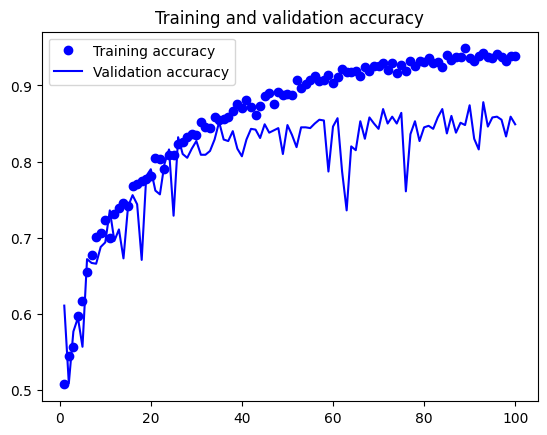

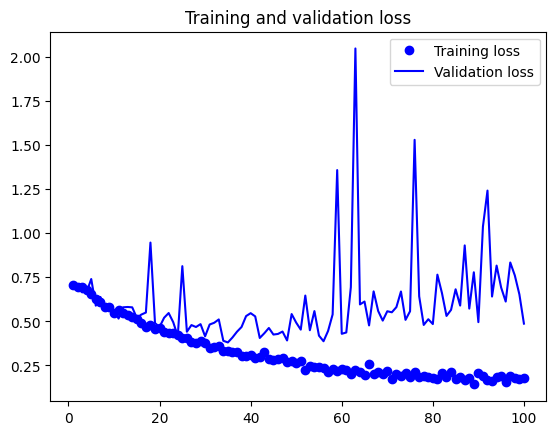

In [44]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Feature extraction 

In [45]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [46]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels**

In [47]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [48]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 12ms/step


In [49]:
train_features.shape

(2000, 5, 5, 512)

These are 1000 images for each of the two classes, and then a 5x5 spatial matrix with a depth of 512 filters. 
**To the Student**: Compare these dimensions to the last layer of the VGG16 which generated it. 

**Defining and training the densely connected classifier**

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [55]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [56]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3277313 (12.50 MB)
Trainable params: 3277313 (12.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


While the network has only two layer, its number of parameter is significant compared to the previous networks we defined to address the dogs versus cats dataset before (they had about 1 million paramters). It is also a significant ratio of the VGG16 body which has about 15 million parameters. This is common in CNNs - the feature vector can be quick large (here its sizze is 12800 elements). A dense layer linearly increases the number of parameters with its size. Then, the last layer further increases it linearly proportionally to the number of classes. 

In [57]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 14.4141 - accuracy: 0.9180INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction/assets


63/63 [==============================] - 2s 19ms/step - loss: 14.4141 - accuracy: 0.9180 - val_loss: 3.7652 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 4.2572 - accuracy: 0.9740 - val_loss: 4.2780 - val_accuracy: 0.9690
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 2.2601 - accuracy: 0.9795 - val_loss: 4.6734 - val_accuracy: 0.9770
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.6745 - accuracy: 0.9890 - val_loss: 5.4457 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.2061 - accuracy: 0.9910 - val_loss: 6.0184 - val_accuracy: 0.9700
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 0.7242 - accuracy: 0.9940 - val_loss: 4.1571 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 1s 11ms/step - loss: 0.4130 - accuracy: 0.9960 - val_loss: 4.8826 - val_accuracy: 0.9710
Epoch 8/20
63/63 [=====

**Plotting the results**

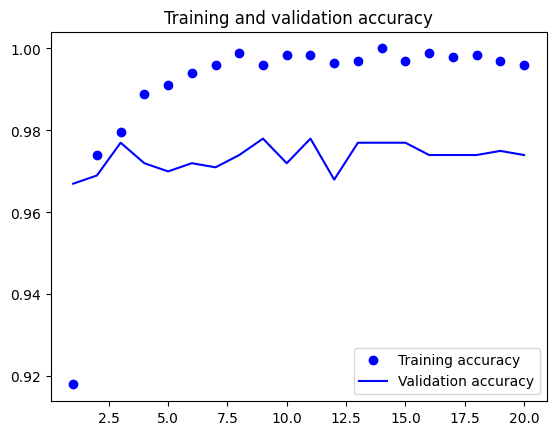

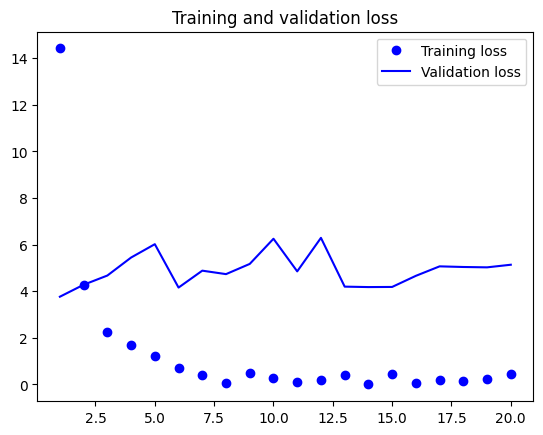

In [58]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating model

In [60]:
test_model = keras.models.load_model(
    "./models/feature_extraction")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 5ms/step - loss: 4.1072 - accuracy: 0.9670
Test accuracy: 0.967


2 Feature Extraction with Data Augmentation
In this step, data augmentation is added to the workflow to improve model generalization

In [61]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [62]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [63]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [64]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [65]:
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0   

Now training with augmentation

In [68]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


2024-12-03 15:48:57.501482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:17 - loss: 1.3791 - accuracy: 0.9688

2024-12-03 15:48:57.932037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 1.3570 - accuracy: 0.9688 

2024-12-03 15:48:58.157698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 6.0697 - accuracy: 0.9375

2024-12-03 15:48:58.377436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 11.2462 - accuracy: 0.9141

2024-12-03 15:48:58.597969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 15.3258 - accuracy: 0.8938

2024-12-03 15:48:58.819532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 21.6326 - accuracy: 0.8646

2024-12-03 15:48:59.042480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 26.7675 - accuracy: 0.8616

2024-12-03 15:48:59.261897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 24.3713 - accuracy: 0.8711

2024-12-03 15:48:59.486336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 11s - loss: 24.5611 - accuracy: 0.8785

2024-12-03 15:48:59.705273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 11s - loss: 24.3352 - accuracy: 0.8813

2024-12-03 15:48:59.960779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 11s - loss: 22.1229 - accuracy: 0.8920

2024-12-03 15:49:00.180825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 21.9311 - accuracy: 0.8958

2024-12-03 15:49:00.403822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 22.1878 - accuracy: 0.8942

2024-12-03 15:49:00.621860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 10s - loss: 20.7050 - accuracy: 0.8996

2024-12-03 15:49:00.845518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 10s - loss: 21.8393 - accuracy: 0.8938

2024-12-03 15:49:01.064268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 20.4743 - accuracy: 0.9004

2024-12-03 15:49:01.290021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 21.7830 - accuracy: 0.8971

2024-12-03 15:49:01.510873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 20.7911 - accuracy: 0.8976

2024-12-03 15:49:01.731356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 9s - loss: 20.3336 - accuracy: 0.8997 

2024-12-03 15:49:01.953193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 9s - loss: 19.6550 - accuracy: 0.9031

2024-12-03 15:49:02.209909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 19.0271 - accuracy: 0.9048

2024-12-03 15:49:02.432391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 18.3876 - accuracy: 0.9048

2024-12-03 15:49:02.653572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 8s - loss: 17.8014 - accuracy: 0.9076

2024-12-03 15:49:02.873845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 8s - loss: 17.1980 - accuracy: 0.9102

2024-12-03 15:49:03.095089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 17.4066 - accuracy: 0.9087

2024-12-03 15:49:03.315845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 16.9532 - accuracy: 0.9087

2024-12-03 15:49:03.553556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 16.6552 - accuracy: 0.9109

2024-12-03 15:49:03.774711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 7s - loss: 16.3347 - accuracy: 0.9118

2024-12-03 15:49:03.995982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 7s - loss: 16.1724 - accuracy: 0.9106

2024-12-03 15:49:04.219988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 15.8477 - accuracy: 0.9125

2024-12-03 15:49:04.440939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 15.6343 - accuracy: 0.9133

2024-12-03 15:49:04.695427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 6s - loss: 15.4619 - accuracy: 0.9131

2024-12-03 15:49:04.915305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 6s - loss: 15.3674 - accuracy: 0.9119

2024-12-03 15:49:05.138504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 15.0818 - accuracy: 0.9136

2024-12-03 15:49:05.362174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 14.7686 - accuracy: 0.9152

2024-12-03 15:49:05.583390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 14.7649 - accuracy: 0.9158

2024-12-03 15:49:05.805924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 5s - loss: 14.7407 - accuracy: 0.9164

2024-12-03 15:49:06.027747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 5s - loss: 14.4845 - accuracy: 0.9169

2024-12-03 15:49:06.251065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 14.1513 - accuracy: 0.9183

2024-12-03 15:49:06.472650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 14.0973 - accuracy: 0.9187

2024-12-03 15:49:06.696062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 4s - loss: 13.7618 - accuracy: 0.9200

2024-12-03 15:49:06.956424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 4s - loss: 13.4855 - accuracy: 0.9204

2024-12-03 15:49:07.180075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 13.2363 - accuracy: 0.9215

2024-12-03 15:49:07.405464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 13.2010 - accuracy: 0.9212

2024-12-03 15:49:07.627529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 13.2724 - accuracy: 0.9194

2024-12-03 15:49:07.853386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 3s - loss: 13.1737 - accuracy: 0.9192

2024-12-03 15:49:08.078583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 13.2095 - accuracy: 0.9195

2024-12-03 15:49:08.301736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 13.1487 - accuracy: 0.9193

2024-12-03 15:49:08.526138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 12.8804 - accuracy: 0.9209

2024-12-03 15:49:08.750827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 2s - loss: 12.9207 - accuracy: 0.9194

2024-12-03 15:49:08.976036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 12.8274 - accuracy: 0.9191

2024-12-03 15:49:09.240130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 12.5807 - accuracy: 0.9207

2024-12-03 15:49:09.461773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 12.4390 - accuracy: 0.9216

2024-12-03 15:49:09.687093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 12.2087 - accuracy: 0.9230

2024-12-03 15:49:09.908794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 12.0953 - accuracy: 0.9239

2024-12-03 15:49:10.129653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 11.8793 - accuracy: 0.9252

2024-12-03 15:49:10.353673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 11.8237 - accuracy: 0.9254

2024-12-03 15:49:10.574341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 11.6453 - accuracy: 0.9262

2024-12-03 15:49:10.819025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 11.6945 - accuracy: 0.9269

2024-12-03 15:49:11.040950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 11.6663 - accuracy: 0.9266

2024-12-03 15:49:11.264316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 11.6266 - accuracy: 0.9267

2024-12-03 15:49:11.494282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 11.6127 - accuracy: 0.9264

2024-12-03 15:49:11.720409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 11.6152 - accuracy: 0.9250INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 24s 369ms/step - loss: 11.6152 - accuracy: 0.9250 - val_loss: 8.8526 - val_accuracy: 0.9450
Epoch 2/50


2024-12-03 15:49:20.816549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 19s - loss: 14.9349 - accuracy: 0.8750

2024-12-03 15:49:21.135031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 10.0492 - accuracy: 0.9219

2024-12-03 15:49:21.357051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 7.3997 - accuracy: 0.9375 

2024-12-03 15:49:21.579284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 7.7797 - accuracy: 0.9453

2024-12-03 15:49:21.802679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 12s - loss: 7.5980 - accuracy: 0.9438

2024-12-03 15:49:22.032740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 12s - loss: 6.3317 - accuracy: 0.9531

2024-12-03 15:49:22.270338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 12s - loss: 5.4927 - accuracy: 0.9554

2024-12-03 15:49:22.496667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 12s - loss: 4.8061 - accuracy: 0.9609

2024-12-03 15:49:22.766614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 12s - loss: 6.7099 - accuracy: 0.9479

2024-12-03 15:49:22.996079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 12s - loss: 6.0389 - accuracy: 0.9531

2024-12-03 15:49:23.229776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 12s - loss: 6.0763 - accuracy: 0.9489

2024-12-03 15:49:23.462461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 11s - loss: 5.6904 - accuracy: 0.9479

2024-12-03 15:49:23.693118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 11s - loss: 5.2527 - accuracy: 0.9519

2024-12-03 15:49:23.926562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 11s - loss: 4.8775 - accuracy: 0.9554

2024-12-03 15:49:24.161066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 11s - loss: 4.5523 - accuracy: 0.9583

2024-12-03 15:49:24.395183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 10s - loss: 4.7054 - accuracy: 0.9590

2024-12-03 15:49:24.627261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 10s - loss: 5.0423 - accuracy: 0.9577

2024-12-03 15:49:24.859911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 10s - loss: 5.4817 - accuracy: 0.9531

2024-12-03 15:49:25.132002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 10s - loss: 5.1932 - accuracy: 0.9556

2024-12-03 15:49:25.366735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 4.9335 - accuracy: 0.9578

2024-12-03 15:49:25.602271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 9s - loss: 4.6990 - accuracy: 0.9598 

2024-12-03 15:49:25.859844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 9s - loss: 4.5019 - accuracy: 0.9602

2024-12-03 15:49:26.099086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 9s - loss: 4.5451 - accuracy: 0.9579

2024-12-03 15:49:26.337123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 9s - loss: 4.3557 - accuracy: 0.9596

2024-12-03 15:49:26.574345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 8s - loss: 4.1815 - accuracy: 0.9613

2024-12-03 15:49:26.813863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 8s - loss: 4.8655 - accuracy: 0.9603

2024-12-03 15:49:27.098603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 8s - loss: 4.7396 - accuracy: 0.9595

2024-12-03 15:49:27.336278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 8s - loss: 4.7021 - accuracy: 0.9598

2024-12-03 15:49:27.577193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 4.5884 - accuracy: 0.9601

2024-12-03 15:49:27.820223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 7s - loss: 4.4355 - accuracy: 0.9615

2024-12-03 15:49:28.058999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 7s - loss: 4.4767 - accuracy: 0.9617

2024-12-03 15:49:28.300072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 7s - loss: 4.6683 - accuracy: 0.9580

2024-12-03 15:49:28.563189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 4.6182 - accuracy: 0.9583

2024-12-03 15:49:28.801180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 6s - loss: 4.8809 - accuracy: 0.9568

2024-12-03 15:49:29.043634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 6s - loss: 4.7573 - accuracy: 0.9571

2024-12-03 15:49:29.332596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 6s - loss: 4.6661 - accuracy: 0.9566

2024-12-03 15:49:29.572359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 4.5400 - accuracy: 0.9578

2024-12-03 15:49:29.817186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 4.4205 - accuracy: 0.9589

2024-12-03 15:49:30.062992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 5s - loss: 4.3161 - accuracy: 0.9591

2024-12-03 15:49:30.306322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 5s - loss: 4.2351 - accuracy: 0.9594

2024-12-03 15:49:30.551983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 4.2037 - accuracy: 0.9596

2024-12-03 15:49:30.795490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 4.1957 - accuracy: 0.9583

2024-12-03 15:49:31.071437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 4s - loss: 4.2222 - accuracy: 0.9578

2024-12-03 15:49:31.310683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 4s - loss: 4.2356 - accuracy: 0.9560

2024-12-03 15:49:31.557294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 4.5347 - accuracy: 0.9549

2024-12-03 15:49:31.843317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 4.8819 - accuracy: 0.9538

2024-12-03 15:49:32.091032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 3s - loss: 4.9633 - accuracy: 0.9528

2024-12-03 15:49:32.337266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 5.0339 - accuracy: 0.9531

2024-12-03 15:49:32.580594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 4.9349 - accuracy: 0.9534

2024-12-03 15:49:32.826269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 4.8362 - accuracy: 0.9544

2024-12-03 15:49:33.071239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 2s - loss: 4.9622 - accuracy: 0.9534

2024-12-03 15:49:33.317770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 4.8668 - accuracy: 0.9543

2024-12-03 15:49:33.587236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 4.8536 - accuracy: 0.9546

2024-12-03 15:49:33.829817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 4.7637 - accuracy: 0.9554

2024-12-03 15:49:34.117574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 1s - loss: 4.7235 - accuracy: 0.9551

2024-12-03 15:49:34.349820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 4.7476 - accuracy: 0.9554

2024-12-03 15:49:34.596036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 4.6933 - accuracy: 0.9556

2024-12-03 15:49:34.838131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 4.6123 - accuracy: 0.9564

2024-12-03 15:49:35.078398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 4.5342 - accuracy: 0.9571

2024-12-03 15:49:35.325049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 4.5503 - accuracy: 0.9563

2024-12-03 15:49:35.568479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 4.7271 - accuracy: 0.9559

2024-12-03 15:49:35.810458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 4.6409 - accuracy: 0.9560

2024-12-03 15:49:36.052940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 24s 386ms/step - loss: 4.6409 - accuracy: 0.9560 - val_loss: 3.7915 - val_accuracy: 0.9730
Epoch 3/50


2024-12-03 15:49:45.088442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9688

2024-12-03 15:49:45.415039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 3.2138 - accuracy: 0.9531

2024-12-03 15:49:45.644155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 5.3765 - accuracy: 0.9375

2024-12-03 15:49:45.870664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 4.1919 - accuracy: 0.9453

2024-12-03 15:49:46.103974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 3.9069 - accuracy: 0.9438

2024-12-03 15:49:46.346323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 3.2557 - accuracy: 0.9531

2024-12-03 15:49:46.590203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 3.2637 - accuracy: 0.9554

2024-12-03 15:49:46.837428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 4.0621 - accuracy: 0.9570

2024-12-03 15:49:47.109188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 3.7519 - accuracy: 0.9583

2024-12-03 15:49:47.409501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 3.7859 - accuracy: 0.9594

2024-12-03 15:49:47.677118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 3.9727 - accuracy: 0.9602

2024-12-03 15:49:47.949978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 3.6417 - accuracy: 0.9635

2024-12-03 15:49:48.212984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 3.4215 - accuracy: 0.9639

2024-12-03 15:49:48.476902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 3.3312 - accuracy: 0.9643

2024-12-03 15:49:48.754982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 3.1709 - accuracy: 0.9646

2024-12-03 15:49:49.019059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 3.1204 - accuracy: 0.9648

2024-12-03 15:49:49.275032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 2.9450 - accuracy: 0.9651

2024-12-03 15:49:49.572461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 3.4299 - accuracy: 0.9583

2024-12-03 15:49:49.848801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 4.3639 - accuracy: 0.9556

2024-12-03 15:49:50.104362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 4.7529 - accuracy: 0.9531

2024-12-03 15:49:50.377774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 4.5344 - accuracy: 0.9539

2024-12-03 15:49:50.641037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 4.4063 - accuracy: 0.9545

2024-12-03 15:49:50.892766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 4.4798 - accuracy: 0.9524

2024-12-03 15:49:51.145921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 4.4330 - accuracy: 0.9531

2024-12-03 15:49:51.396094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 4.2999 - accuracy: 0.9538 

2024-12-03 15:49:51.717549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 4.1345 - accuracy: 0.9555

2024-12-03 15:49:51.963846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 4.0772 - accuracy: 0.9549

2024-12-03 15:49:52.216965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 4.0493 - accuracy: 0.9554

2024-12-03 15:49:52.467900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 3.9097 - accuracy: 0.9569

2024-12-03 15:49:52.721706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 4.0737 - accuracy: 0.9563

2024-12-03 15:49:52.974714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 3.9842 - accuracy: 0.9556

2024-12-03 15:49:53.233202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 3.9701 - accuracy: 0.9561

2024-12-03 15:49:53.494601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 3.8808 - accuracy: 0.9564

2024-12-03 15:49:53.760444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 3.8846 - accuracy: 0.9568

2024-12-03 15:49:54.018263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 4.3399 - accuracy: 0.9554

2024-12-03 15:49:54.322266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 4.6178 - accuracy: 0.9557

2024-12-03 15:49:54.611232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 4.5882 - accuracy: 0.9561

2024-12-03 15:49:54.875434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 4.4675 - accuracy: 0.9572

2024-12-03 15:49:55.132055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 4.3936 - accuracy: 0.9575

2024-12-03 15:49:55.398930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 4.2846 - accuracy: 0.9578

2024-12-03 15:49:55.660114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 4.3565 - accuracy: 0.9566

2024-12-03 15:49:55.920307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 4.4114 - accuracy: 0.9561

2024-12-03 15:49:56.180706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 4.3088 - accuracy: 0.9571

2024-12-03 15:49:56.446472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 4.2114 - accuracy: 0.9574

2024-12-03 15:49:56.750539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 4.1178 - accuracy: 0.9583

2024-12-03 15:49:57.014585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 4.0948 - accuracy: 0.9586

2024-12-03 15:49:57.274654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 4.0232 - accuracy: 0.9588

2024-12-03 15:49:57.532982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 3.9914 - accuracy: 0.9590

2024-12-03 15:49:57.796165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 4.0025 - accuracy: 0.9592

2024-12-03 15:49:58.083867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 3.9602 - accuracy: 0.9594

2024-12-03 15:49:58.353061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 3.8872 - accuracy: 0.9596

2024-12-03 15:49:58.711248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 3.9173 - accuracy: 0.9591

2024-12-03 15:49:58.967955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 3.8943 - accuracy: 0.9593

2024-12-03 15:49:59.229770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 3.8222 - accuracy: 0.9601

2024-12-03 15:49:59.488311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 3.7549 - accuracy: 0.9602

2024-12-03 15:49:59.747725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.6878 - accuracy: 0.9609

2024-12-03 15:50:00.014789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.7580 - accuracy: 0.9605

2024-12-03 15:50:00.272513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.7038 - accuracy: 0.9607

2024-12-03 15:50:00.533635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 3.6690 - accuracy: 0.9608

2024-12-03 15:50:00.789230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.6911 - accuracy: 0.9594

2024-12-03 15:50:01.089917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.6306 - accuracy: 0.9600

2024-12-03 15:50:01.337703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 3.5435 - accuracy: 0.9610

2024-12-03 15:50:01.588953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 26s 422ms/step - loss: 3.5435 - accuracy: 0.9610 - val_loss: 2.7012 - val_accuracy: 0.9780
Epoch 4/50


2024-12-03 15:50:11.583545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 3.1409 - accuracy: 0.9688

2024-12-03 15:50:11.943518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 4.5770 - accuracy: 0.9531

2024-12-03 15:50:12.184624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 4.6622 - accuracy: 0.9479

2024-12-03 15:50:12.436356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 4.9244 - accuracy: 0.9453

2024-12-03 15:50:12.687220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 3.9396 - accuracy: 0.9563

2024-12-03 15:50:12.967690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 3.2830 - accuracy: 0.9635

2024-12-03 15:50:13.225662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 4.9691 - accuracy: 0.9598

2024-12-03 15:50:13.491912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 4.7162 - accuracy: 0.9570

2024-12-03 15:50:13.798264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 4.3259 - accuracy: 0.9583

2024-12-03 15:50:14.093399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 4.2946 - accuracy: 0.9594

2024-12-03 15:50:14.352511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 3.9042 - accuracy: 0.9631

2024-12-03 15:50:14.624607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 4.3474 - accuracy: 0.9635

2024-12-03 15:50:14.885502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 4.4282 - accuracy: 0.9639

2024-12-03 15:50:15.174028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 4.1119 - accuracy: 0.9665

2024-12-03 15:50:15.449958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 3.9048 - accuracy: 0.9646

2024-12-03 15:50:15.752405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 4.3772 - accuracy: 0.9609

2024-12-03 15:50:16.033981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 4.3974 - accuracy: 0.9577

2024-12-03 15:50:16.350811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 4.5676 - accuracy: 0.9549

2024-12-03 15:50:16.655565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 4.4431 - accuracy: 0.9556

2024-12-03 15:50:16.923017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 4.7547 - accuracy: 0.9531

2024-12-03 15:50:17.199121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 4.5283 - accuracy: 0.9554

2024-12-03 15:50:17.467794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 4.3225 - accuracy: 0.9574

2024-12-03 15:50:17.737298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 4.1345 - accuracy: 0.9592

2024-12-03 15:50:18.072005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 4.1378 - accuracy: 0.9583

2024-12-03 15:50:18.337877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 3.9892 - accuracy: 0.9588

2024-12-03 15:50:18.633230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 3.8358 - accuracy: 0.9603

2024-12-03 15:50:18.919920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 4.0254 - accuracy: 0.9583

2024-12-03 15:50:19.211223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 4.1978 - accuracy: 0.9576 

2024-12-03 15:50:19.488590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 4.0530 - accuracy: 0.9591

2024-12-03 15:50:19.752687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 3.9181 - accuracy: 0.9604

2024-12-03 15:50:20.027148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 4.1205 - accuracy: 0.9597

2024-12-03 15:50:20.312383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 3.9917 - accuracy: 0.9609

2024-12-03 15:50:20.632631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 4.2908 - accuracy: 0.9602

2024-12-03 15:50:20.904031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 4.1646 - accuracy: 0.9614

2024-12-03 15:50:21.170246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 4.1035 - accuracy: 0.9616

2024-12-03 15:50:21.434445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 3.9895 - accuracy: 0.9627

2024-12-03 15:50:21.706457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 3.9807 - accuracy: 0.9628

2024-12-03 15:50:21.990676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 3.9150 - accuracy: 0.9622

2024-12-03 15:50:22.275252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 4.3292 - accuracy: 0.9615

2024-12-03 15:50:22.541203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 4.2736 - accuracy: 0.9617

2024-12-03 15:50:22.819637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 4.1694 - accuracy: 0.9627

2024-12-03 15:50:23.149915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 4.0701 - accuracy: 0.9635

2024-12-03 15:50:23.413758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 4.0670 - accuracy: 0.9637

2024-12-03 15:50:23.694356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 4.0575 - accuracy: 0.9631

2024-12-03 15:50:23.993380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 3.9673 - accuracy: 0.9639

2024-12-03 15:50:24.284262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 3.9466 - accuracy: 0.9633

2024-12-03 15:50:24.558651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 3.8626 - accuracy: 0.9641

2024-12-03 15:50:24.838352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 3.7822 - accuracy: 0.9648

2024-12-03 15:50:25.118067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.7260 - accuracy: 0.9643

2024-12-03 15:50:25.384917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 3.6515 - accuracy: 0.9650

2024-12-03 15:50:25.704374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 3.5799 - accuracy: 0.9657

2024-12-03 15:50:25.986552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 3.5663 - accuracy: 0.9657

2024-12-03 15:50:26.280321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 3.6611 - accuracy: 0.9658

2024-12-03 15:50:26.561447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 3.5933 - accuracy: 0.9664

2024-12-03 15:50:26.831965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 3.8108 - accuracy: 0.9659

2024-12-03 15:50:27.108012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.7428 - accuracy: 0.9665

2024-12-03 15:50:27.374478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.6771 - accuracy: 0.9671

2024-12-03 15:50:27.672118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.7122 - accuracy: 0.9671

2024-12-03 15:50:27.949402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 3.7075 - accuracy: 0.9666

2024-12-03 15:50:28.256294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.8038 - accuracy: 0.9661

2024-12-03 15:50:28.528966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.7415 - accuracy: 0.9667

2024-12-03 15:50:28.798426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 3.8066 - accuracy: 0.9665

2024-12-03 15:50:29.059163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 27s 426ms/step - loss: 3.8066 - accuracy: 0.9665 - val_loss: 1.9373 - val_accuracy: 0.9790
Epoch 5/50


2024-12-03 15:50:38.366849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 1.1166 - accuracy: 0.9688

2024-12-03 15:50:38.701084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 13s - loss: 0.5583 - accuracy: 0.9844

2024-12-03 15:50:38.929997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 0.9202 - accuracy: 0.9792

2024-12-03 15:50:39.161945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.1908 - accuracy: 0.9766

2024-12-03 15:50:39.410934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 3.0761 - accuracy: 0.9563

2024-12-03 15:50:39.670786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 3.2477 - accuracy: 0.9531

2024-12-03 15:50:39.927069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 2.9373 - accuracy: 0.9554

2024-12-03 15:50:40.183991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 2.6130 - accuracy: 0.9570

2024-12-03 15:50:40.451211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 2.6350 - accuracy: 0.9583

2024-12-03 15:50:40.713791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 2.3715 - accuracy: 0.9625

2024-12-03 15:50:40.978345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 3.2811 - accuracy: 0.9574

2024-12-03 15:50:41.235228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 3.1328 - accuracy: 0.9583

2024-12-03 15:50:41.503691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 3.4930 - accuracy: 0.9567

2024-12-03 15:50:41.760255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 3.3292 - accuracy: 0.9576

2024-12-03 15:50:42.024255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 3.1650 - accuracy: 0.9583

2024-12-03 15:50:42.295717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 2.9736 - accuracy: 0.9590

2024-12-03 15:50:42.558627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 3.1382 - accuracy: 0.9596

2024-12-03 15:50:42.820452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 2.9639 - accuracy: 0.9618

2024-12-03 15:50:43.084802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 3.2375 - accuracy: 0.9622

2024-12-03 15:50:43.353572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 3.1412 - accuracy: 0.9625

2024-12-03 15:50:43.624320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 3.2647 - accuracy: 0.9598

2024-12-03 15:50:43.897707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 3.3592 - accuracy: 0.9602

2024-12-03 15:50:44.168871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 3.7997 - accuracy: 0.9579

2024-12-03 15:50:44.435607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 3.6414 - accuracy: 0.9596

2024-12-03 15:50:44.709975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 3.8757 - accuracy: 0.9588 

2024-12-03 15:50:44.979138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 3.7267 - accuracy: 0.9603

2024-12-03 15:50:45.250061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 3.6424 - accuracy: 0.9606

2024-12-03 15:50:45.518464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 3.5123 - accuracy: 0.9621

2024-12-03 15:50:45.792157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 3.3912 - accuracy: 0.9634

2024-12-03 15:50:46.114852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 3.4319 - accuracy: 0.9625

2024-12-03 15:50:46.372909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 3.3215 - accuracy: 0.9637

2024-12-03 15:50:46.635333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 3.5489 - accuracy: 0.9629

2024-12-03 15:50:46.906160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 3.8404 - accuracy: 0.9602

2024-12-03 15:50:47.179246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 3.7275 - accuracy: 0.9614

2024-12-03 15:50:47.449023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 3.6721 - accuracy: 0.9616

2024-12-03 15:50:47.726695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 3.5701 - accuracy: 0.9627

2024-12-03 15:50:47.992303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 3.4736 - accuracy: 0.9637

2024-12-03 15:50:48.261538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 3.3822 - accuracy: 0.9646

2024-12-03 15:50:48.534618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 3.5727 - accuracy: 0.9639

2024-12-03 15:50:48.795323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 3.4834 - accuracy: 0.9648

2024-12-03 15:50:49.066030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 3.4116 - accuracy: 0.9649

2024-12-03 15:50:49.345741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 3.3591 - accuracy: 0.9650

2024-12-03 15:50:49.657272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 3.3021 - accuracy: 0.9651

2024-12-03 15:50:49.928055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 3.2271 - accuracy: 0.9659

2024-12-03 15:50:50.205146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 3.1594 - accuracy: 0.9660

2024-12-03 15:50:50.483044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 3.1457 - accuracy: 0.9654

2024-12-03 15:50:50.742826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 3.1051 - accuracy: 0.9641

2024-12-03 15:50:51.037011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 3.1322 - accuracy: 0.9629

2024-12-03 15:50:51.290488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 3.0682 - accuracy: 0.9636

2024-12-03 15:50:51.554162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 3.0069 - accuracy: 0.9644

2024-12-03 15:50:51.823031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.9479 - accuracy: 0.9651

2024-12-03 15:50:52.098741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 2.8912 - accuracy: 0.9657

2024-12-03 15:50:52.384493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.8367 - accuracy: 0.9664

2024-12-03 15:50:52.653738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.8610 - accuracy: 0.9659

2024-12-03 15:50:52.922087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 3.1479 - accuracy: 0.9636

2024-12-03 15:50:53.186970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 3.0917 - accuracy: 0.9643

2024-12-03 15:50:53.454209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 3.0572 - accuracy: 0.9644

2024-12-03 15:50:53.722466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.0393 - accuracy: 0.9644

2024-12-03 15:50:53.985655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.9878 - accuracy: 0.9650

2024-12-03 15:50:54.255886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 3.0987 - accuracy: 0.9646

2024-12-03 15:50:54.524155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 3.0772 - accuracy: 0.9647

2024-12-03 15:50:54.797543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 3.1648 - accuracy: 0.9650

2024-12-03 15:50:55.062046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 24s 381ms/step - loss: 3.1648 - accuracy: 0.9650 - val_loss: 3.3143 - val_accuracy: 0.9780
Epoch 6/50


2024-12-03 15:51:02.327788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 2.4031 - accuracy: 0.9688

2024-12-03 15:51:02.665841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 1.2015 - accuracy: 0.9844

2024-12-03 15:51:02.934456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 4.5731 - accuracy: 0.9583

2024-12-03 15:51:03.202890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 4.9681 - accuracy: 0.9453

2024-12-03 15:51:03.476262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 4.1809 - accuracy: 0.9500

2024-12-03 15:51:03.744575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 3.4841 - accuracy: 0.9583

2024-12-03 15:51:04.013954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 2.9864 - accuracy: 0.9643

2024-12-03 15:51:04.279809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 3.7498 - accuracy: 0.9609

2024-12-03 15:51:04.547509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 3.4736 - accuracy: 0.9618

2024-12-03 15:51:04.814791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 3.6688 - accuracy: 0.9625

2024-12-03 15:51:05.086389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 3.7786 - accuracy: 0.9602

2024-12-03 15:51:05.358280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 3.7141 - accuracy: 0.9609

2024-12-03 15:51:05.625030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 3.4284 - accuracy: 0.9639

2024-12-03 15:51:05.945121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 3.3770 - accuracy: 0.9643

2024-12-03 15:51:06.197902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 3.1518 - accuracy: 0.9667

2024-12-03 15:51:06.467821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 2.9548 - accuracy: 0.9688

2024-12-03 15:51:06.744104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 2.7810 - accuracy: 0.9706

2024-12-03 15:51:07.017120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 3.0462 - accuracy: 0.9688

2024-12-03 15:51:07.295299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 2.9389 - accuracy: 0.9688

2024-12-03 15:51:07.573388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 2.7920 - accuracy: 0.9703

2024-12-03 15:51:07.860600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 2.6590 - accuracy: 0.9717

2024-12-03 15:51:08.126149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 2.6477 - accuracy: 0.9716

2024-12-03 15:51:08.409312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.5520 - accuracy: 0.9715

2024-12-03 15:51:08.685346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.4630 - accuracy: 0.9714

2024-12-03 15:51:08.960773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 2.3645 - accuracy: 0.9725

2024-12-03 15:51:09.285083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 2.2777 - accuracy: 0.9724

2024-12-03 15:51:09.551213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.2757 - accuracy: 0.9722 

2024-12-03 15:51:09.822151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.1944 - accuracy: 0.9732

2024-12-03 15:51:10.096301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 2.1187 - accuracy: 0.9741

2024-12-03 15:51:10.366794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 2.1656 - accuracy: 0.9729

2024-12-03 15:51:10.642281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.0958 - accuracy: 0.9738

2024-12-03 15:51:10.908604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 2.0768 - accuracy: 0.9727

2024-12-03 15:51:11.170921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 2.1868 - accuracy: 0.9725

2024-12-03 15:51:11.441461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 2.2583 - accuracy: 0.9715

2024-12-03 15:51:11.702251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.1938 - accuracy: 0.9723

2024-12-03 15:51:11.969394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 2.1329 - accuracy: 0.9731

2024-12-03 15:51:12.241208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 2.1254 - accuracy: 0.9730

2024-12-03 15:51:12.542935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.0853 - accuracy: 0.9729

2024-12-03 15:51:12.837537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 2.0318 - accuracy: 0.9736

2024-12-03 15:51:13.157085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 2.1206 - accuracy: 0.9734

2024-12-03 15:51:13.495899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 2.0689 - accuracy: 0.9741

2024-12-03 15:51:13.848812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.1335 - accuracy: 0.9740

2024-12-03 15:51:14.228106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 2.1389 - accuracy: 0.9738

2024-12-03 15:51:14.594123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 2.0903 - accuracy: 0.9744

2024-12-03 15:51:14.937182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 2.0439 - accuracy: 0.9750

2024-12-03 15:51:15.261707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.1516 - accuracy: 0.9735

2024-12-03 15:51:15.577260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 2.1127 - accuracy: 0.9734

2024-12-03 15:51:15.874388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 2.1108 - accuracy: 0.9727

2024-12-03 15:51:16.162816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 2.0706 - accuracy: 0.9726

2024-12-03 15:51:16.472820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.2138 - accuracy: 0.9719

2024-12-03 15:51:16.757985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.1704 - accuracy: 0.9724

2024-12-03 15:51:17.036644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 2.1387 - accuracy: 0.9724

2024-12-03 15:51:17.314501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.0984 - accuracy: 0.9729

2024-12-03 15:51:17.597601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.1232 - accuracy: 0.9728

2024-12-03 15:51:17.876910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 2.1189 - accuracy: 0.9722

2024-12-03 15:51:18.154700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 2.1902 - accuracy: 0.9715

2024-12-03 15:51:18.441159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.1517 - accuracy: 0.9720

2024-12-03 15:51:18.723066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.1503 - accuracy: 0.9720

2024-12-03 15:51:19.002283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.1138 - accuracy: 0.9725

2024-12-03 15:51:19.282032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.0931 - accuracy: 0.9724

2024-12-03 15:51:19.550009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.0588 - accuracy: 0.9728

2024-12-03 15:51:19.814132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.0559 - accuracy: 0.9720

2024-12-03 15:51:20.096199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 408ms/step - loss: 2.0559 - accuracy: 0.9720 - val_loss: 2.6552 - val_accuracy: 0.9750
Epoch 7/50


2024-12-03 15:51:27.969058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 2.7897 - accuracy: 0.9375

2024-12-03 15:51:28.310267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 4.3139 - accuracy: 0.9219

2024-12-03 15:51:28.575283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 2.8759 - accuracy: 0.9479

2024-12-03 15:51:28.827885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 2.1569 - accuracy: 0.9609

2024-12-03 15:51:29.081933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.7256 - accuracy: 0.9688

2024-12-03 15:51:29.341766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 1.7988 - accuracy: 0.9688

2024-12-03 15:51:29.596455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 1.9627 - accuracy: 0.9688

2024-12-03 15:51:29.845753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 1.7174 - accuracy: 0.9727

2024-12-03 15:51:30.109643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 2.3254 - accuracy: 0.9722

2024-12-03 15:51:30.365584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 2.4281 - accuracy: 0.9688

2024-12-03 15:51:30.619763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 2.9977 - accuracy: 0.9688

2024-12-03 15:51:30.876499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 2.8465 - accuracy: 0.9688

2024-12-03 15:51:31.145568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 2.6276 - accuracy: 0.9712

2024-12-03 15:51:31.409623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 2.5068 - accuracy: 0.9710

2024-12-03 15:51:31.665892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 2.4119 - accuracy: 0.9708

2024-12-03 15:51:31.926080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 2.4196 - accuracy: 0.9707

2024-12-03 15:51:32.183296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 2.2773 - accuracy: 0.9724

2024-12-03 15:51:32.442582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 2.1508 - accuracy: 0.9740

2024-12-03 15:51:32.701281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 2.1468 - accuracy: 0.9737

2024-12-03 15:51:32.966088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 2.0395 - accuracy: 0.9750

2024-12-03 15:51:33.232732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 2.1199 - accuracy: 0.9747

2024-12-03 15:51:33.502722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 2.0235 - accuracy: 0.9759

2024-12-03 15:51:33.765539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.1844 - accuracy: 0.9728

2024-12-03 15:51:34.034920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.2429 - accuracy: 0.9714

2024-12-03 15:51:34.333749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 2.4312 - accuracy: 0.9700 

2024-12-03 15:51:34.603724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 2.3693 - accuracy: 0.9700

2024-12-03 15:51:34.869654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.2815 - accuracy: 0.9711

2024-12-03 15:51:35.131992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.2001 - accuracy: 0.9721

2024-12-03 15:51:35.400295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 2.1242 - accuracy: 0.9731

2024-12-03 15:51:35.663302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 2.0784 - accuracy: 0.9729

2024-12-03 15:51:35.930634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.1384 - accuracy: 0.9718

2024-12-03 15:51:36.198492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 2.0716 - accuracy: 0.9727

2024-12-03 15:51:36.461014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 2.0088 - accuracy: 0.9735

2024-12-03 15:51:36.728604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 2.1665 - accuracy: 0.9724

2024-12-03 15:51:37.034197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.1046 - accuracy: 0.9732

2024-12-03 15:51:37.286692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 2.0462 - accuracy: 0.9740

2024-12-03 15:51:37.559784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 6s - loss: 2.0250 - accuracy: 0.9738

2024-12-03 15:51:37.832738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.0423 - accuracy: 0.9737

2024-12-03 15:51:38.098224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.9900 - accuracy: 0.9744

2024-12-03 15:51:38.360469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 1.9426 - accuracy: 0.9742

2024-12-03 15:51:38.625800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 1.9539 - accuracy: 0.9741

2024-12-03 15:51:38.902161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 1.9074 - accuracy: 0.9747

2024-12-03 15:51:39.172830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.8630 - accuracy: 0.9753

2024-12-03 15:51:39.453126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 1.8579 - accuracy: 0.9751

2024-12-03 15:51:39.717075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 1.8166 - accuracy: 0.9757

2024-12-03 15:51:40.021900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.7771 - accuracy: 0.9762

2024-12-03 15:51:40.280415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.8189 - accuracy: 0.9761

2024-12-03 15:51:40.544565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 3s - loss: 1.7810 - accuracy: 0.9766

2024-12-03 15:51:40.812372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 1.7978 - accuracy: 0.9764

2024-12-03 15:51:41.080703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.8047 - accuracy: 0.9762

2024-12-03 15:51:41.347797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.7693 - accuracy: 0.9767

2024-12-03 15:51:41.620187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 2s - loss: 1.7352 - accuracy: 0.9772

2024-12-03 15:51:41.883476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.7025 - accuracy: 0.9776

2024-12-03 15:51:42.154118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.6998 - accuracy: 0.9774

2024-12-03 15:51:42.408887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.6757 - accuracy: 0.9773

2024-12-03 15:51:42.670623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 1.6457 - accuracy: 0.9777

2024-12-03 15:51:42.944047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.6169 - accuracy: 0.9781

2024-12-03 15:51:43.209474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.5890 - accuracy: 0.9784

2024-12-03 15:51:43.477602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.5621 - accuracy: 0.9788

2024-12-03 15:51:43.740528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.5360 - accuracy: 0.9792

2024-12-03 15:51:44.006975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.5108 - accuracy: 0.9795

2024-12-03 15:51:44.285413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.4769 - accuracy: 0.9795

2024-12-03 15:51:44.549174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 24s 378ms/step - loss: 1.4769 - accuracy: 0.9795 - val_loss: 3.3302 - val_accuracy: 0.9740
Epoch 8/50


2024-12-03 15:51:51.756559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 1.0921 - accuracy: 0.9688

2024-12-03 15:51:52.094736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 5.1715 - accuracy: 0.9531

2024-12-03 15:51:52.362571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 3.4477 - accuracy: 0.9688

2024-12-03 15:51:52.633498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 2.5858 - accuracy: 0.9766

2024-12-03 15:51:52.906830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 2.0686 - accuracy: 0.9812

2024-12-03 15:51:53.174103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 1.7239 - accuracy: 0.9844

2024-12-03 15:51:53.443345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.4777 - accuracy: 0.9866

2024-12-03 15:51:53.715004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 1.3252 - accuracy: 0.9844

2024-12-03 15:51:53.985152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 14s - loss: 1.4065 - accuracy: 0.9826

2024-12-03 15:51:54.258287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.6263 - accuracy: 0.9781

2024-12-03 15:51:54.528503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.4785 - accuracy: 0.9801

2024-12-03 15:51:54.800372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 1.3553 - accuracy: 0.9818

2024-12-03 15:51:55.067589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 1.2510 - accuracy: 0.9832

2024-12-03 15:51:55.366803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.1617 - accuracy: 0.9844

2024-12-03 15:51:55.632794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.4738 - accuracy: 0.9812

2024-12-03 15:51:55.918403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 12s - loss: 2.6332 - accuracy: 0.9688

2024-12-03 15:51:56.200351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 3.6999 - accuracy: 0.9614

2024-12-03 15:51:56.479166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 3.6088 - accuracy: 0.9618

2024-12-03 15:51:56.762295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 3.4866 - accuracy: 0.9605

2024-12-03 15:51:57.036600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 3.4170 - accuracy: 0.9609

2024-12-03 15:51:57.311863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 3.2543 - accuracy: 0.9628

2024-12-03 15:51:57.584828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 3.1064 - accuracy: 0.9645

2024-12-03 15:51:57.866442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 3.0134 - accuracy: 0.9633

2024-12-03 15:51:58.137300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.8879 - accuracy: 0.9648

2024-12-03 15:51:58.413181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 2.7723 - accuracy: 0.9663

2024-12-03 15:51:58.738978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 2.7148 - accuracy: 0.9663

2024-12-03 15:51:59.004562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.8159 - accuracy: 0.9664 

2024-12-03 15:51:59.279959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.7153 - accuracy: 0.9676

2024-12-03 15:51:59.543739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 2.6217 - accuracy: 0.9688

2024-12-03 15:51:59.811039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 2.5840 - accuracy: 0.9688

2024-12-03 15:52:00.085269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.6946 - accuracy: 0.9677

2024-12-03 15:52:00.356500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 2.8714 - accuracy: 0.9668

2024-12-03 15:52:00.632159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 2.8413 - accuracy: 0.9659

2024-12-03 15:52:00.909890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 2.9101 - accuracy: 0.9651

2024-12-03 15:52:01.218611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.9370 - accuracy: 0.9643

2024-12-03 15:52:01.491936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 2.8554 - accuracy: 0.9653

2024-12-03 15:52:01.760855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 3.0396 - accuracy: 0.9654

2024-12-03 15:52:02.034126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.9596 - accuracy: 0.9663

2024-12-03 15:52:02.308831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 2.8907 - accuracy: 0.9655

2024-12-03 15:52:02.584449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 2.8184 - accuracy: 0.9664

2024-12-03 15:52:02.856243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 2.7497 - accuracy: 0.9672

2024-12-03 15:52:03.129774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.7442 - accuracy: 0.9673

2024-12-03 15:52:03.398971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 2.6805 - accuracy: 0.9680

2024-12-03 15:52:03.671073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 2.6876 - accuracy: 0.9673

2024-12-03 15:52:03.951805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 2.7115 - accuracy: 0.9667

2024-12-03 15:52:04.219650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.6526 - accuracy: 0.9674

2024-12-03 15:52:04.494765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 2.6361 - accuracy: 0.9674

2024-12-03 15:52:04.764279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 2.5925 - accuracy: 0.9668

2024-12-03 15:52:05.044256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.5396 - accuracy: 0.9675

2024-12-03 15:52:05.321651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.4888 - accuracy: 0.9681

2024-12-03 15:52:05.588637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.4484 - accuracy: 0.9681

2024-12-03 15:52:05.861458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 2.4013 - accuracy: 0.9688

2024-12-03 15:52:06.133081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.3560 - accuracy: 0.9693

2024-12-03 15:52:06.408783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.3773 - accuracy: 0.9682

2024-12-03 15:52:06.671630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 2.3390 - accuracy: 0.9682

2024-12-03 15:52:06.940441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.3587 - accuracy: 0.9682

2024-12-03 15:52:07.208047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.3173 - accuracy: 0.9688

2024-12-03 15:52:07.473602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.2946 - accuracy: 0.9688

2024-12-03 15:52:07.743628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.3227 - accuracy: 0.9688

2024-12-03 15:52:08.012451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.2840 - accuracy: 0.9693

2024-12-03 15:52:08.277973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.2705 - accuracy: 0.9693

2024-12-03 15:52:08.546091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.2160 - accuracy: 0.9700

2024-12-03 15:52:08.812178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 28s 451ms/step - loss: 2.2160 - accuracy: 0.9700 - val_loss: 1.4878 - val_accuracy: 0.9830
Epoch 9/50


2024-12-03 15:52:20.080651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 3.6880e-07 - accuracy: 1.0000

2024-12-03 15:52:20.407766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 0.7551 - accuracy: 0.9844    

2024-12-03 15:52:20.637997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 3.1767 - accuracy: 0.9583

2024-12-03 15:52:20.869046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 3.6980 - accuracy: 0.9609

2024-12-03 15:52:21.104223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 3.5709 - accuracy: 0.9563

2024-12-03 15:52:21.360496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 3.5984 - accuracy: 0.9531

2024-12-03 15:52:21.610597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 3.0843 - accuracy: 0.9598

2024-12-03 15:52:21.861700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 2.7493 - accuracy: 0.9609

2024-12-03 15:52:22.110437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 2.5633 - accuracy: 0.9618

2024-12-03 15:52:22.352849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 2.3070 - accuracy: 0.9656

2024-12-03 15:52:22.657671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 2.4704 - accuracy: 0.9659

2024-12-03 15:52:22.909787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 12s - loss: 2.7767 - accuracy: 0.9661

2024-12-03 15:52:23.171786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 12s - loss: 2.7422 - accuracy: 0.9663

2024-12-03 15:52:23.429781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 12s - loss: 2.5542 - accuracy: 0.9665

2024-12-03 15:52:23.683646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 12s - loss: 2.5670 - accuracy: 0.9667

2024-12-03 15:52:23.934866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 11s - loss: 2.4597 - accuracy: 0.9648

2024-12-03 15:52:24.196018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 11s - loss: 2.3151 - accuracy: 0.9669

2024-12-03 15:52:24.449944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 11s - loss: 2.1864 - accuracy: 0.9688

2024-12-03 15:52:24.707769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 11s - loss: 2.0906 - accuracy: 0.9688

2024-12-03 15:52:24.962152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 10s - loss: 2.2314 - accuracy: 0.9672

2024-12-03 15:52:25.264847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 10s - loss: 2.1251 - accuracy: 0.9688

2024-12-03 15:52:25.527442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 10s - loss: 2.1500 - accuracy: 0.9688

2024-12-03 15:52:25.794097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 10s - loss: 2.3129 - accuracy: 0.9674

2024-12-03 15:52:26.052890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 2.2218 - accuracy: 0.9674

2024-12-03 15:52:26.319713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 9s - loss: 2.1330 - accuracy: 0.9688 

2024-12-03 15:52:26.601880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 9s - loss: 2.0762 - accuracy: 0.9688

2024-12-03 15:52:26.882924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 9s - loss: 2.1048 - accuracy: 0.9676

2024-12-03 15:52:27.160613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 2.4557 - accuracy: 0.9654

2024-12-03 15:52:27.436245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 8s - loss: 2.5130 - accuracy: 0.9655

2024-12-03 15:52:27.701199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 8s - loss: 2.4917 - accuracy: 0.9656

2024-12-03 15:52:27.986461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 8s - loss: 2.5436 - accuracy: 0.9647

2024-12-03 15:52:28.275726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 2.4670 - accuracy: 0.9648

2024-12-03 15:52:28.590783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 7s - loss: 2.4088 - accuracy: 0.9650

2024-12-03 15:52:28.898228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 7s - loss: 2.3380 - accuracy: 0.9660

2024-12-03 15:52:29.218656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 2.4952 - accuracy: 0.9661

2024-12-03 15:52:29.529873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 2.4616 - accuracy: 0.9661

2024-12-03 15:52:29.822102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 2.3951 - accuracy: 0.9671

2024-12-03 15:52:30.115921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 6s - loss: 2.3893 - accuracy: 0.9663

2024-12-03 15:52:30.405869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 2.3280 - accuracy: 0.9671

2024-12-03 15:52:30.723675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 2.2698 - accuracy: 0.9680

2024-12-03 15:52:31.008271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 5s - loss: 2.2145 - accuracy: 0.9688

2024-12-03 15:52:31.288907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 5s - loss: 2.4752 - accuracy: 0.9680

2024-12-03 15:52:31.572231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 2.4300 - accuracy: 0.9680

2024-12-03 15:52:31.858881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 2.5705 - accuracy: 0.9673

2024-12-03 15:52:32.141927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 4s - loss: 2.5570 - accuracy: 0.9667

2024-12-03 15:52:32.422430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 2.5730 - accuracy: 0.9654

2024-12-03 15:52:32.708792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 2.5183 - accuracy: 0.9661

2024-12-03 15:52:32.992230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 2.4658 - accuracy: 0.9668

2024-12-03 15:52:33.309672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 3s - loss: 2.4155 - accuracy: 0.9675

2024-12-03 15:52:33.600710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 2.4337 - accuracy: 0.9675

2024-12-03 15:52:33.891453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.3881 - accuracy: 0.9675

2024-12-03 15:52:34.167057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 2.3422 - accuracy: 0.9681

2024-12-03 15:52:34.440646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 2.3690 - accuracy: 0.9676

2024-12-03 15:52:34.714293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.3802 - accuracy: 0.9676

2024-12-03 15:52:34.988591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 2.3369 - accuracy: 0.9682

2024-12-03 15:52:35.259954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 1s - loss: 2.3548 - accuracy: 0.9682

2024-12-03 15:52:35.524728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 2.3135 - accuracy: 0.9688

2024-12-03 15:52:35.785428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 2.3625 - accuracy: 0.9682

2024-12-03 15:52:36.052379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.3931 - accuracy: 0.9682

2024-12-03 15:52:36.328800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 2.3532 - accuracy: 0.9688

2024-12-03 15:52:36.604663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 2.3555 - accuracy: 0.9688

2024-12-03 15:52:36.877614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 2.2989 - accuracy: 0.9695

2024-12-03 15:52:37.142321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 25s 398ms/step - loss: 2.2989 - accuracy: 0.9695 - val_loss: 2.0234 - val_accuracy: 0.9820
Epoch 10/50


2024-12-03 15:52:45.101761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 5.4297e-05 - accuracy: 1.0000

2024-12-03 15:52:45.458746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 2.7148e-05 - accuracy: 1.0000

2024-12-03 15:52:45.749183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 1.8099e-05 - accuracy: 1.0000

2024-12-03 15:52:46.027442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 1.3574e-05 - accuracy: 1.0000

2024-12-03 15:52:46.327975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.4905 - accuracy: 0.9937    

2024-12-03 15:52:46.607880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.4087 - accuracy: 0.9948

2024-12-03 15:52:46.892476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.3503 - accuracy: 0.9955

2024-12-03 15:52:47.163992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.7214 - accuracy: 0.9844

2024-12-03 15:52:47.433339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.9469 - accuracy: 0.9826

2024-12-03 15:52:47.698634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.2834 - accuracy: 0.9812

2024-12-03 15:52:47.964634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.8733 - accuracy: 0.9744

2024-12-03 15:52:48.278794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 1.7172 - accuracy: 0.9766

2024-12-03 15:52:48.559446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 1.7926 - accuracy: 0.9760

2024-12-03 15:52:48.825423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.7438 - accuracy: 0.9732

2024-12-03 15:52:49.103908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.6275 - accuracy: 0.9750

2024-12-03 15:52:49.378380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 1.5258 - accuracy: 0.9766

2024-12-03 15:52:49.652720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 12s - loss: 1.4361 - accuracy: 0.9779

2024-12-03 15:52:49.932274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 1.5337 - accuracy: 0.9774

2024-12-03 15:52:50.214123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 1.5333 - accuracy: 0.9770

2024-12-03 15:52:50.488785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 11s - loss: 1.4583 - accuracy: 0.9766

2024-12-03 15:52:50.769271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.4143 - accuracy: 0.9762

2024-12-03 15:52:51.096133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 1.4782 - accuracy: 0.9759

2024-12-03 15:52:51.379700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 1.4140 - accuracy: 0.9769

2024-12-03 15:52:51.661795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 10s - loss: 1.3551 - accuracy: 0.9779

2024-12-03 15:52:51.936371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.3339 - accuracy: 0.9775

2024-12-03 15:52:52.215987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 1.2826 - accuracy: 0.9784

2024-12-03 15:52:52.493026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 1.3460 - accuracy: 0.9780

2024-12-03 15:52:52.776171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 1.2979 - accuracy: 0.9788 

2024-12-03 15:52:53.049638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 1.3407 - accuracy: 0.9774

2024-12-03 15:52:53.327293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 1.2960 - accuracy: 0.9781

2024-12-03 15:52:53.703588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 1.3454 - accuracy: 0.9768

2024-12-03 15:52:54.157520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 1.3034 - accuracy: 0.9775

2024-12-03 15:52:54.597208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 1.2639 - accuracy: 0.9782

2024-12-03 15:52:54.879992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 1.2267 - accuracy: 0.9789

2024-12-03 15:52:55.184281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 1.2007 - accuracy: 0.9786

2024-12-03 15:52:55.495706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 1.1673 - accuracy: 0.9792

2024-12-03 15:52:55.778965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 1.2507 - accuracy: 0.9789

2024-12-03 15:52:56.068164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 1.2319 - accuracy: 0.9786

2024-12-03 15:52:56.405434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 1.2004 - accuracy: 0.9792

2024-12-03 15:52:56.706677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 1.1954 - accuracy: 0.9789

2024-12-03 15:52:56.987244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 1.1737 - accuracy: 0.9787

2024-12-03 15:52:57.284458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 1.1457 - accuracy: 0.9792

2024-12-03 15:52:57.589035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.1191 - accuracy: 0.9797

2024-12-03 15:52:57.892820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 1.0937 - accuracy: 0.9801

2024-12-03 15:52:58.195468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 1.0754 - accuracy: 0.9799

2024-12-03 15:52:58.508583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 1.0705 - accuracy: 0.9796

2024-12-03 15:52:58.807537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.1824 - accuracy: 0.9781

2024-12-03 15:52:59.109474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.1578 - accuracy: 0.9785

2024-12-03 15:52:59.461163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 1.1342 - accuracy: 0.9790

2024-12-03 15:52:59.773917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.1115 - accuracy: 0.9794

2024-12-03 15:53:00.078260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.0897 - accuracy: 0.9798

2024-12-03 15:53:00.387093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 1.0688 - accuracy: 0.9802

2024-12-03 15:53:00.685977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.0486 - accuracy: 0.9805

2024-12-03 15:53:01.000241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.0292 - accuracy: 0.9809

2024-12-03 15:53:01.287254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.0417 - accuracy: 0.9807

2024-12-03 15:53:01.588989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 1.0417 - accuracy: 0.9799

2024-12-03 15:53:01.877389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.0493 - accuracy: 0.9797

2024-12-03 15:53:02.163503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.0313 - accuracy: 0.9801

2024-12-03 15:53:02.464986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.0138 - accuracy: 0.9804

2024-12-03 15:53:02.755739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.9969 - accuracy: 0.9807

2024-12-03 15:53:03.045754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.9805 - accuracy: 0.9810

2024-12-03 15:53:03.380562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.9755 - accuracy: 0.9810

2024-12-03 15:53:03.661487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 441ms/step - loss: 0.9755 - accuracy: 0.9810 - val_loss: 1.9861 - val_accuracy: 0.9780
Epoch 11/50


2024-12-03 15:53:12.825908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.7469 - accuracy: 0.9688

2024-12-03 15:53:13.171930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.5208 - accuracy: 0.9531

2024-12-03 15:53:13.473013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 0.3472 - accuracy: 0.9688

2024-12-03 15:53:13.766803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 0.2604 - accuracy: 0.9766

2024-12-03 15:53:14.042749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.2283 - accuracy: 0.9750

2024-12-03 15:53:14.316523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 1.1305 - accuracy: 0.9688

2024-12-03 15:53:14.599008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.9690 - accuracy: 0.9732

2024-12-03 15:53:14.878284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 1.1644 - accuracy: 0.9727

2024-12-03 15:53:15.159588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 1.2176 - accuracy: 0.9688

2024-12-03 15:53:15.438875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 1.3488 - accuracy: 0.9656

2024-12-03 15:53:15.719026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 1.2262 - accuracy: 0.9688

2024-12-03 15:53:16.029016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 1.1779 - accuracy: 0.9688

2024-12-03 15:53:16.369726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 1.5242 - accuracy: 0.9688

2024-12-03 15:53:16.719387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 1.4154 - accuracy: 0.9710

2024-12-03 15:53:17.056712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 1.3436 - accuracy: 0.9708

2024-12-03 15:53:17.407360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 1.4983 - accuracy: 0.9707

2024-12-03 15:53:17.778281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 1.4101 - accuracy: 0.9724

2024-12-03 15:53:18.136286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 1.3766 - accuracy: 0.9722

2024-12-03 15:53:18.497977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 1.3734 - accuracy: 0.9704

2024-12-03 15:53:18.811170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 1.3105 - accuracy: 0.9703

2024-12-03 15:53:19.155618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 1.3149 - accuracy: 0.9702

2024-12-03 15:53:19.475952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 1.2552 - accuracy: 0.9716

2024-12-03 15:53:19.806939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 1.2878 - accuracy: 0.9715

2024-12-03 15:53:20.150551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 1.2344 - accuracy: 0.9727

2024-12-03 15:53:20.464474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 1.1850 - accuracy: 0.9737

2024-12-03 15:53:20.780113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 1.3546 - accuracy: 0.9724

2024-12-03 15:53:21.109032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 1.3331 - accuracy: 0.9711

2024-12-03 15:53:21.449694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 1.2932 - accuracy: 0.9710

2024-12-03 15:53:21.822975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 1.2486 - accuracy: 0.9720

2024-12-03 15:53:22.143275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 1.2070 - accuracy: 0.9729

2024-12-03 15:53:22.482291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 1.2376 - accuracy: 0.9728

2024-12-03 15:53:22.822116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 1.2517 - accuracy: 0.9717

2024-12-03 15:53:23.173960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 1.5028 - accuracy: 0.9706 

2024-12-03 15:53:23.520182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 1.4586 - accuracy: 0.9715

2024-12-03 15:53:23.857316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 1.4170 - accuracy: 0.9723

2024-12-03 15:53:24.201769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 1.3957 - accuracy: 0.9722

2024-12-03 15:53:24.512761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 1.3819 - accuracy: 0.9713

2024-12-03 15:53:24.866175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 1.3455 - accuracy: 0.9720

2024-12-03 15:53:25.181699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 1.3110 - accuracy: 0.9728

2024-12-03 15:53:25.513663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 1.2924 - accuracy: 0.9727

2024-12-03 15:53:25.849960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 1.3016 - accuracy: 0.9726

2024-12-03 15:53:26.183189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 1.2707 - accuracy: 0.9732

2024-12-03 15:53:26.518766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 1.2621 - accuracy: 0.9731

2024-12-03 15:53:26.889443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 1.3190 - accuracy: 0.9730

2024-12-03 15:53:27.284506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 1.2897 - accuracy: 0.9736

2024-12-03 15:53:27.710409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 1.2617 - accuracy: 0.9742

2024-12-03 15:53:28.056806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 1.2619 - accuracy: 0.9741

2024-12-03 15:53:28.402962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.2356 - accuracy: 0.9746

2024-12-03 15:53:28.745201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 1.2770 - accuracy: 0.9745

2024-12-03 15:53:29.067991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 1.2515 - accuracy: 0.9750

2024-12-03 15:53:29.379355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.2501 - accuracy: 0.9749

2024-12-03 15:53:29.693125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 1.2778 - accuracy: 0.9742

2024-12-03 15:53:30.006442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 1.2537 - accuracy: 0.9746

2024-12-03 15:53:30.321333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.2671 - accuracy: 0.9734

2024-12-03 15:53:30.622353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.2441 - accuracy: 0.9739

2024-12-03 15:53:30.937709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 1.2434 - accuracy: 0.9732

2024-12-03 15:53:31.254454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.2234 - accuracy: 0.9731

2024-12-03 15:53:31.565760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.2023 - accuracy: 0.9736

2024-12-03 15:53:31.880992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.1819 - accuracy: 0.9740

2024-12-03 15:53:32.193479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.2460 - accuracy: 0.9729

2024-12-03 15:53:32.500529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.2256 - accuracy: 0.9734

2024-12-03 15:53:32.789391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.2290 - accuracy: 0.9735

2024-12-03 15:53:33.093699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 31s 498ms/step - loss: 1.2290 - accuracy: 0.9735 - val_loss: 1.2076 - val_accuracy: 0.9830
Epoch 12/50


2024-12-03 15:53:44.076485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 1.1176e-07 - accuracy: 1.0000

2024-12-03 15:53:44.404680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 1.7043 - accuracy: 0.9688    

2024-12-03 15:53:44.636341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 13s - loss: 1.4370 - accuracy: 0.9688

2024-12-03 15:53:44.869788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.8005 - accuracy: 0.9609

2024-12-03 15:53:45.109554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 1.4404 - accuracy: 0.9688

2024-12-03 15:53:45.354535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 2.3413 - accuracy: 0.9583

2024-12-03 15:53:45.616547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 2.0068 - accuracy: 0.9643

2024-12-03 15:53:45.866669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 1.9779 - accuracy: 0.9648

2024-12-03 15:53:46.139760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 1.7581 - accuracy: 0.9688

2024-12-03 15:53:46.402888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 1.6723 - accuracy: 0.9656

2024-12-03 15:53:46.675395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 1.5203 - accuracy: 0.9688

2024-12-03 15:53:46.961044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 1.4006 - accuracy: 0.9688

2024-12-03 15:53:47.279058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 1.2929 - accuracy: 0.9712

2024-12-03 15:53:47.607139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 13s - loss: 1.2007 - accuracy: 0.9732

2024-12-03 15:53:47.949209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 1.1207 - accuracy: 0.9750

2024-12-03 15:53:48.302826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 1.0767 - accuracy: 0.9746

2024-12-03 15:53:48.637838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 1.0134 - accuracy: 0.9761

2024-12-03 15:53:48.943815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.9608 - accuracy: 0.9757

2024-12-03 15:53:49.273433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.9103 - accuracy: 0.9770

2024-12-03 15:53:49.556290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.9201 - accuracy: 0.9750

2024-12-03 15:53:49.832944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 11s - loss: 1.1698 - accuracy: 0.9717

2024-12-03 15:53:50.107846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 1.1166 - accuracy: 0.9730

2024-12-03 15:53:50.376965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 1.0681 - accuracy: 0.9742

2024-12-03 15:53:50.645384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 1.0236 - accuracy: 0.9753

2024-12-03 15:53:50.914219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 1.1619 - accuracy: 0.9725

2024-12-03 15:53:51.233589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 1.1172 - accuracy: 0.9736

2024-12-03 15:53:51.509769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 1.2098 - accuracy: 0.9734

2024-12-03 15:53:51.789827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 9s - loss: 1.3760 - accuracy: 0.9721 

2024-12-03 15:53:52.077937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 1.3396 - accuracy: 0.9720

2024-12-03 15:53:52.365519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 1.2950 - accuracy: 0.9729

2024-12-03 15:53:52.654464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 1.2532 - accuracy: 0.9738

2024-12-03 15:53:52.949343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 1.2140 - accuracy: 0.9746

2024-12-03 15:53:53.235185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 1.1772 - accuracy: 0.9754

2024-12-03 15:53:53.552708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 1.3268 - accuracy: 0.9743

2024-12-03 15:53:53.826924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 7s - loss: 1.3053 - accuracy: 0.9741

2024-12-03 15:53:54.110940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 1.2690 - accuracy: 0.9748

2024-12-03 15:53:54.396811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 1.2347 - accuracy: 0.9755

2024-12-03 15:53:54.683049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 1.2022 - accuracy: 0.9762

2024-12-03 15:53:54.980776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 1.2008 - accuracy: 0.9760

2024-12-03 15:53:55.266477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 1.1708 - accuracy: 0.9766

2024-12-03 15:53:55.555067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 1.1948 - accuracy: 0.9756

2024-12-03 15:53:55.837426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 1.1664 - accuracy: 0.9762

2024-12-03 15:53:56.152189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 1.1392 - accuracy: 0.9767

2024-12-03 15:53:56.434011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 1.1133 - accuracy: 0.9773

2024-12-03 15:53:56.721201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 1.0886 - accuracy: 0.9778

2024-12-03 15:53:57.006335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 1.0902 - accuracy: 0.9776

2024-12-03 15:53:57.293019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 1.1321 - accuracy: 0.9774

2024-12-03 15:53:57.573760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.1352 - accuracy: 0.9766

2024-12-03 15:53:57.859376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 1.1120 - accuracy: 0.9770

2024-12-03 15:53:58.144154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 1.1082 - accuracy: 0.9769

2024-12-03 15:53:58.422969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.0879 - accuracy: 0.9767

2024-12-03 15:53:58.708842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 1.0721 - accuracy: 0.9766

2024-12-03 15:53:59.002037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 1.0518 - accuracy: 0.9770

2024-12-03 15:53:59.313124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 1.0323 - accuracy: 0.9774

2024-12-03 15:53:59.622185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 1.0136 - accuracy: 0.9778

2024-12-03 15:53:59.947061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 1.0486 - accuracy: 0.9766

2024-12-03 15:54:00.259061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 1.0485 - accuracy: 0.9764

2024-12-03 15:54:00.539057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 1.0304 - accuracy: 0.9768

2024-12-03 15:54:00.806411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 1.0312 - accuracy: 0.9767

2024-12-03 15:54:01.085205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 1.0140 - accuracy: 0.9771

2024-12-03 15:54:01.369524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 1.0456 - accuracy: 0.9769

2024-12-03 15:54:01.651725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 1.1412 - accuracy: 0.9760

2024-12-03 15:54:01.932468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 26s 422ms/step - loss: 1.1412 - accuracy: 0.9760 - val_loss: 1.4574 - val_accuracy: 0.9780
Epoch 13/50


2024-12-03 15:54:10.577615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:54:10.904568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 0.2350 - accuracy: 0.9844    

2024-12-03 15:54:11.183478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 16s - loss: 0.1569 - accuracy: 0.9896

2024-12-03 15:54:11.468346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 1.3002 - accuracy: 0.9766

2024-12-03 15:54:11.758836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 1.2218 - accuracy: 0.9750

2024-12-03 15:54:12.049357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 1.0782 - accuracy: 0.9740

2024-12-03 15:54:12.340795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.9242 - accuracy: 0.9777

2024-12-03 15:54:12.633852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.8087 - accuracy: 0.9805

2024-12-03 15:54:12.924292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.9466 - accuracy: 0.9757

2024-12-03 15:54:13.207197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 1.0056 - accuracy: 0.9719

2024-12-03 15:54:13.484439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.9142 - accuracy: 0.9744

2024-12-03 15:54:13.801073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.8514 - accuracy: 0.9740

2024-12-03 15:54:14.084210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.7859 - accuracy: 0.9760

2024-12-03 15:54:14.365586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.7957 - accuracy: 0.9754

2024-12-03 15:54:14.648497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.7427 - accuracy: 0.9771

2024-12-03 15:54:14.934229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.7277 - accuracy: 0.9766

2024-12-03 15:54:15.215046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.7310 - accuracy: 0.9761

2024-12-03 15:54:15.494870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 12s - loss: 0.6908 - accuracy: 0.9774

2024-12-03 15:54:15.772376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.9786

2024-12-03 15:54:16.054830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.6217 - accuracy: 0.9797

2024-12-03 15:54:16.373472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.6009 - accuracy: 0.9777

2024-12-03 15:54:16.653319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.6252 - accuracy: 0.9773

2024-12-03 15:54:16.934085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.6433 - accuracy: 0.9755

2024-12-03 15:54:17.214519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.6165 - accuracy: 0.9766

2024-12-03 15:54:17.499667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.5918 - accuracy: 0.9775

2024-12-03 15:54:17.786405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.5691 - accuracy: 0.9784

2024-12-03 15:54:18.074166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.5515 - accuracy: 0.9780

2024-12-03 15:54:18.392255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.6352 - accuracy: 0.9777

2024-12-03 15:54:18.665058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.7612 - accuracy: 0.9763 

2024-12-03 15:54:18.944098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.7358 - accuracy: 0.9771

2024-12-03 15:54:19.221090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.7121 - accuracy: 0.9778

2024-12-03 15:54:19.505616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 8s - loss: 0.6898 - accuracy: 0.9785

2024-12-03 15:54:19.787110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.7530 - accuracy: 0.9773

2024-12-03 15:54:20.063644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.7309 - accuracy: 0.9779

2024-12-03 15:54:20.349906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.7132 - accuracy: 0.9777

2024-12-03 15:54:20.636233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.6934 - accuracy: 0.9783

2024-12-03 15:54:20.922384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.6747 - accuracy: 0.9789

2024-12-03 15:54:21.206992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.6667 - accuracy: 0.9786

2024-12-03 15:54:21.485797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6497 - accuracy: 0.9792

2024-12-03 15:54:21.772061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6334 - accuracy: 0.9797

2024-12-03 15:54:22.059638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.6180 - accuracy: 0.9802

2024-12-03 15:54:22.349932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.6343 - accuracy: 0.9792

2024-12-03 15:54:22.635695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.6196 - accuracy: 0.9797

2024-12-03 15:54:22.918393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6137 - accuracy: 0.9794

2024-12-03 15:54:23.239174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.6000 - accuracy: 0.9799

2024-12-03 15:54:23.515949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.5885 - accuracy: 0.9796

2024-12-03 15:54:23.804464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.5760 - accuracy: 0.9801

2024-12-03 15:54:24.089246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.5750 - accuracy: 0.9798

2024-12-03 15:54:24.376900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.5632 - accuracy: 0.9802

2024-12-03 15:54:24.668458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.5520 - accuracy: 0.9806

2024-12-03 15:54:24.954316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.5452 - accuracy: 0.9804

2024-12-03 15:54:25.250825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.5639 - accuracy: 0.9802

2024-12-03 15:54:25.538912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.5715 - accuracy: 0.9794

2024-12-03 15:54:25.833364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6117 - accuracy: 0.9792

2024-12-03 15:54:26.127391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6006 - accuracy: 0.9795

2024-12-03 15:54:26.409304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.5899 - accuracy: 0.9799

2024-12-03 15:54:26.695071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5825 - accuracy: 0.9797

2024-12-03 15:54:26.987398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5777 - accuracy: 0.9795

2024-12-03 15:54:27.281944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5679 - accuracy: 0.9799

2024-12-03 15:54:27.598799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5585 - accuracy: 0.9802

2024-12-03 15:54:27.909726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5632 - accuracy: 0.9800

2024-12-03 15:54:28.333708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.9785

2024-12-03 15:54:28.671453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 448ms/step - loss: 0.5847 - accuracy: 0.9785 - val_loss: 1.3673 - val_accuracy: 0.9820
Epoch 14/50


2024-12-03 15:54:38.724737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 29s - loss: 0.5320 - accuracy: 0.9688

2024-12-03 15:54:39.196624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 21s - loss: 0.2660 - accuracy: 0.9844

2024-12-03 15:54:39.551584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.1773 - accuracy: 0.9896

2024-12-03 15:54:39.902261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.2575 - accuracy: 0.9844

2024-12-03 15:54:40.252625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.2312 - accuracy: 0.9812

2024-12-03 15:54:40.600050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.9088 - accuracy: 0.9688

2024-12-03 15:54:40.945563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.7790 - accuracy: 0.9732

2024-12-03 15:54:41.281635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.8654 - accuracy: 0.9727

2024-12-03 15:54:41.641272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 1.0407 - accuracy: 0.9722

2024-12-03 15:54:42.029215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 1.4971 - accuracy: 0.9625

2024-12-03 15:54:42.371723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 1.3610 - accuracy: 0.9659

2024-12-03 15:54:42.727100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 1.2476 - accuracy: 0.9688

2024-12-03 15:54:43.072994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 1.1516 - accuracy: 0.9712

2024-12-03 15:54:43.414502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 1.2221 - accuracy: 0.9710

2024-12-03 15:54:43.763299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 1.3249 - accuracy: 0.9708

2024-12-03 15:54:44.099450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 1.2790 - accuracy: 0.9707

2024-12-03 15:54:44.425602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 1.2082 - accuracy: 0.9706

2024-12-03 15:54:44.741106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 1.1474 - accuracy: 0.9705

2024-12-03 15:54:45.064338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 1.1667 - accuracy: 0.9704

2024-12-03 15:54:45.412036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 1.1684 - accuracy: 0.9688

2024-12-03 15:54:45.744466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 1.2365 - accuracy: 0.9673

2024-12-03 15:54:46.065379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 1.2040 - accuracy: 0.9673

2024-12-03 15:54:46.396852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 1.1517 - accuracy: 0.9688

2024-12-03 15:54:46.718407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 1.1037 - accuracy: 0.9701

2024-12-03 15:54:47.044431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 1.0949 - accuracy: 0.9700

2024-12-03 15:54:47.347981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 1.0556 - accuracy: 0.9700

2024-12-03 15:54:47.659566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 1.0165 - accuracy: 0.9711

2024-12-03 15:54:47.997611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 1.2059 - accuracy: 0.9699

2024-12-03 15:54:48.348015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 1.1683 - accuracy: 0.9698

2024-12-03 15:54:48.685469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 1.1294 - accuracy: 0.9708

2024-12-03 15:54:49.015712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 1.1002 - accuracy: 0.9708

2024-12-03 15:54:49.357679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 1.0658 - accuracy: 0.9717

2024-12-03 15:54:49.715941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 1.0335 - accuracy: 0.9725

2024-12-03 15:54:50.069119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 1.0186 - accuracy: 0.9724 

2024-12-03 15:54:50.425135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 1.1113 - accuracy: 0.9705

2024-12-03 15:54:50.768525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 1.0804 - accuracy: 0.9714

2024-12-03 15:54:51.097033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 1.0512 - accuracy: 0.9721

2024-12-03 15:54:51.409785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 1.0236 - accuracy: 0.9729

2024-12-03 15:54:51.720635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.9973 - accuracy: 0.9736

2024-12-03 15:54:52.025237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 1.0293 - accuracy: 0.9727

2024-12-03 15:54:52.321503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 1.0042 - accuracy: 0.9733

2024-12-03 15:54:52.640064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.9807 - accuracy: 0.9740

2024-12-03 15:54:52.925062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.9579 - accuracy: 0.9746

2024-12-03 15:54:53.213364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 1.0342 - accuracy: 0.9737

2024-12-03 15:54:53.499458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 1.1351 - accuracy: 0.9729

2024-12-03 15:54:53.793763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 1.1322 - accuracy: 0.9721

2024-12-03 15:54:54.092385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 1.1206 - accuracy: 0.9721

2024-12-03 15:54:54.381222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 1.0972 - accuracy: 0.9727

2024-12-03 15:54:54.666775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 1.0748 - accuracy: 0.9732

2024-12-03 15:54:54.966776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 1.0533 - accuracy: 0.9737

2024-12-03 15:54:55.265388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 1.0327 - accuracy: 0.9743

2024-12-03 15:54:55.561355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 1.0128 - accuracy: 0.9748

2024-12-03 15:54:55.868417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.9937 - accuracy: 0.9752

2024-12-03 15:54:56.213672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.9860 - accuracy: 0.9751

2024-12-03 15:54:56.523809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.9680 - accuracy: 0.9756

2024-12-03 15:54:56.831695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.9792 - accuracy: 0.9754

2024-12-03 15:54:57.135586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.9836 - accuracy: 0.9748

2024-12-03 15:54:57.438006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.9667 - accuracy: 0.9752

2024-12-03 15:54:57.764741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.9558 - accuracy: 0.9751

2024-12-03 15:54:58.135444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.9449 - accuracy: 0.9750

2024-12-03 15:54:58.498685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.9306 - accuracy: 0.9749

2024-12-03 15:54:58.851581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.9523 - accuracy: 0.9745

2024-12-03 15:54:59.179041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 478ms/step - loss: 0.9523 - accuracy: 0.9745 - val_loss: 1.4718 - val_accuracy: 0.9800
Epoch 15/50


2024-12-03 15:55:08.810564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 2.1843 - accuracy: 0.9375

2024-12-03 15:55:09.142875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 16s - loss: 1.1965 - accuracy: 0.9531

2024-12-03 15:55:09.419301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 0.7977 - accuracy: 0.9688

2024-12-03 15:55:09.741426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.5982 - accuracy: 0.9766

2024-12-03 15:55:10.069944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 0.9788 - accuracy: 0.9750

2024-12-03 15:55:10.390662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 1.5536 - accuracy: 0.9688

2024-12-03 15:55:10.721306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 1.5824 - accuracy: 0.9643

2024-12-03 15:55:11.075325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 1.4091 - accuracy: 0.9648

2024-12-03 15:55:11.415393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 1.2527 - accuracy: 0.9688

2024-12-03 15:55:11.765162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 1.1275 - accuracy: 0.9719

2024-12-03 15:55:12.143033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 1.2742 - accuracy: 0.9688

2024-12-03 15:55:12.504515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 1.1680 - accuracy: 0.9714

2024-12-03 15:55:12.878324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 1.1032 - accuracy: 0.9712

2024-12-03 15:55:13.231220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 1.0244 - accuracy: 0.9732

2024-12-03 15:55:13.579513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 1.0823 - accuracy: 0.9729

2024-12-03 15:55:13.929360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 1.0451 - accuracy: 0.9707

2024-12-03 15:55:14.269017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.9836 - accuracy: 0.9724

2024-12-03 15:55:14.643071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 1.1068 - accuracy: 0.9705

2024-12-03 15:55:14.960906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 1.0485 - accuracy: 0.9720

2024-12-03 15:55:15.282369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.9961 - accuracy: 0.9734

2024-12-03 15:55:15.621094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.9487 - accuracy: 0.9747

2024-12-03 15:55:15.944065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.9055 - accuracy: 0.9759

2024-12-03 15:55:16.254847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.9293 - accuracy: 0.9755

2024-12-03 15:55:16.575815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.8905 - accuracy: 0.9766

2024-12-03 15:55:16.903301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.8549 - accuracy: 0.9775

2024-12-03 15:55:17.243362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.8220 - accuracy: 0.9784

2024-12-03 15:55:17.605970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.7916 - accuracy: 0.9792

2024-12-03 15:55:17.928459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.7633 - accuracy: 0.9799

2024-12-03 15:55:18.268197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.7370 - accuracy: 0.9806

2024-12-03 15:55:18.607478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.7124 - accuracy: 0.9812

2024-12-03 15:55:18.934836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.7090 - accuracy: 0.9808

2024-12-03 15:55:19.257877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.7303 - accuracy: 0.9805

2024-12-03 15:55:19.582628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.7743 - accuracy: 0.9792

2024-12-03 15:55:19.911545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.7515 - accuracy: 0.9798 

2024-12-03 15:55:20.227883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.7458 - accuracy: 0.9795

2024-12-03 15:55:20.541386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.7575 - accuracy: 0.9792

2024-12-03 15:55:20.861162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.7371 - accuracy: 0.9797

2024-12-03 15:55:21.188904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.7177 - accuracy: 0.9803

2024-12-03 15:55:21.525360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.6993 - accuracy: 0.9808

2024-12-03 15:55:21.850986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.6818 - accuracy: 0.9812

2024-12-03 15:55:22.174983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.6652 - accuracy: 0.9817

2024-12-03 15:55:22.499255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.6493 - accuracy: 0.9821

2024-12-03 15:55:22.852749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.6387 - accuracy: 0.9818

2024-12-03 15:55:23.177128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.6315 - accuracy: 0.9815

2024-12-03 15:55:23.508703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.6339 - accuracy: 0.9812

2024-12-03 15:55:23.827764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.6201 - accuracy: 0.9817

2024-12-03 15:55:24.161195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.6069 - accuracy: 0.9820

2024-12-03 15:55:24.484336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.5943 - accuracy: 0.9824

2024-12-03 15:55:24.803808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.5822 - accuracy: 0.9828

2024-12-03 15:55:25.125418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.5705 - accuracy: 0.9831

2024-12-03 15:55:25.443871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.5593 - accuracy: 0.9835

2024-12-03 15:55:25.774819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.5672 - accuracy: 0.9832

2024-12-03 15:55:26.111212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.5565 - accuracy: 0.9835

2024-12-03 15:55:26.439854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5462 - accuracy: 0.9838

2024-12-03 15:55:26.771352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5362 - accuracy: 0.9841

2024-12-03 15:55:27.107009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.5267 - accuracy: 0.9844

2024-12-03 15:55:27.437322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5174 - accuracy: 0.9846

2024-12-03 15:55:27.748494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5117 - accuracy: 0.9844

2024-12-03 15:55:28.053727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5277 - accuracy: 0.9841

2024-12-03 15:55:28.371594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5233 - accuracy: 0.9839

2024-12-03 15:55:28.709496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.9841

2024-12-03 15:55:29.046195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.9845

2024-12-03 15:55:29.369026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 33s 525ms/step - loss: 0.5023 - accuracy: 0.9845 - val_loss: 1.0731 - val_accuracy: 0.9800
Epoch 16/50


2024-12-03 15:55:41.710074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 7.4506e-09 - accuracy: 1.0000

2024-12-03 15:55:42.074690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 0.6981 - accuracy: 0.9844    

2024-12-03 15:55:42.319558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 0.4654 - accuracy: 0.9896

2024-12-03 15:55:42.581542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 0.5762 - accuracy: 0.9844

2024-12-03 15:55:42.857316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 0.4610 - accuracy: 0.9875

2024-12-03 15:55:43.130645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 0.3922 - accuracy: 0.9844

2024-12-03 15:55:43.416430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.4852 - accuracy: 0.9821

2024-12-03 15:55:43.745886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.4246 - accuracy: 0.9844

2024-12-03 15:55:44.071429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.4720 - accuracy: 0.9826

2024-12-03 15:55:44.474431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 0.4679 - accuracy: 0.9812

2024-12-03 15:55:44.924387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.5033 - accuracy: 0.9801

2024-12-03 15:55:45.386679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.4627 - accuracy: 0.9818

2024-12-03 15:55:45.826048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.5750 - accuracy: 0.9808

2024-12-03 15:55:46.187555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.5340 - accuracy: 0.9821

2024-12-03 15:55:46.509249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.4984 - accuracy: 0.9833

2024-12-03 15:55:46.825378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.5663 - accuracy: 0.9824

2024-12-03 15:55:47.115757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.5330 - accuracy: 0.9835

2024-12-03 15:55:47.407117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.5034 - accuracy: 0.9844

2024-12-03 15:55:47.694134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.4769 - accuracy: 0.9852

2024-12-03 15:55:47.974050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.4530 - accuracy: 0.9859

2024-12-03 15:55:48.253633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.4491 - accuracy: 0.9851

2024-12-03 15:55:48.539909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.4909 - accuracy: 0.9830

2024-12-03 15:55:48.857837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.5203 - accuracy: 0.9823

2024-12-03 15:55:49.144731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.6741 - accuracy: 0.9805

2024-12-03 15:55:49.449104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.7042 - accuracy: 0.9787

2024-12-03 15:55:49.750132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.6771 - accuracy: 0.9796

2024-12-03 15:55:50.060514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.6520 - accuracy: 0.9803

2024-12-03 15:55:50.368881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.6287 - accuracy: 0.9810

2024-12-03 15:55:50.677115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.6071 - accuracy: 0.9817

2024-12-03 15:55:50.980336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.5868 - accuracy: 0.9823

2024-12-03 15:55:51.314056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.5679 - accuracy: 0.9829

2024-12-03 15:55:51.643554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.5513 - accuracy: 0.9824 

2024-12-03 15:55:52.006228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.5346 - accuracy: 0.9830

2024-12-03 15:55:52.341725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.5329 - accuracy: 0.9825

2024-12-03 15:55:52.653805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.5176 - accuracy: 0.9830

2024-12-03 15:55:52.961563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.5113 - accuracy: 0.9826

2024-12-03 15:55:53.258710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.5558 - accuracy: 0.9823

2024-12-03 15:55:53.551594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.5412 - accuracy: 0.9827

2024-12-03 15:55:53.862607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.5273 - accuracy: 0.9832

2024-12-03 15:55:54.206257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.6199 - accuracy: 0.9820

2024-12-03 15:55:54.544092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.6048 - accuracy: 0.9825

2024-12-03 15:55:54.889452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.6071 - accuracy: 0.9821

2024-12-03 15:55:55.232159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.5930 - accuracy: 0.9826

2024-12-03 15:55:55.599755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.5969 - accuracy: 0.9822

2024-12-03 15:55:55.924464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.5890 - accuracy: 0.9819

2024-12-03 15:55:56.267721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.5762 - accuracy: 0.9823

2024-12-03 15:55:56.657141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.6058 - accuracy: 0.9820

2024-12-03 15:55:57.017339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6110 - accuracy: 0.9818

2024-12-03 15:55:57.388844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.5986 - accuracy: 0.9821

2024-12-03 15:55:57.768829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.6028 - accuracy: 0.9819

2024-12-03 15:55:58.139587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.5910 - accuracy: 0.9822

2024-12-03 15:55:58.504017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.5796 - accuracy: 0.9826

2024-12-03 15:55:58.866225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.5689 - accuracy: 0.9829

2024-12-03 15:55:59.282175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5694 - accuracy: 0.9826

2024-12-03 15:55:59.613135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5623 - accuracy: 0.9824

2024-12-03 15:55:59.953401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.5776 - accuracy: 0.9821

2024-12-03 15:56:00.289437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5788 - accuracy: 0.9819

2024-12-03 15:56:00.615398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5689 - accuracy: 0.9822

2024-12-03 15:56:00.947977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5592 - accuracy: 0.9825

2024-12-03 15:56:01.281354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6068 - accuracy: 0.9818

2024-12-03 15:56:01.637170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5968 - accuracy: 0.9821

2024-12-03 15:56:01.977154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.5873 - accuracy: 0.9824

2024-12-03 15:56:02.317909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 477ms/step - loss: 0.5897 - accuracy: 0.9820 - val_loss: 1.6521 - val_accuracy: 0.9780
Epoch 17/50


2024-12-03 15:56:11.661515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:56:12.002555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.4728 - accuracy: 0.9688    

2024-12-03 15:56:12.284594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 1.0142 - accuracy: 0.9688

2024-12-03 15:56:12.590447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 16s - loss: 0.7606 - accuracy: 0.9766

2024-12-03 15:56:12.868030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 16s - loss: 0.8881 - accuracy: 0.9688

2024-12-03 15:56:13.147910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 16s - loss: 0.7401 - accuracy: 0.9740

2024-12-03 15:56:13.437718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 16s - loss: 0.6343 - accuracy: 0.9777

2024-12-03 15:56:13.724812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.5550 - accuracy: 0.9805

2024-12-03 15:56:14.022395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.5230 - accuracy: 0.9792

2024-12-03 15:56:14.315056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 15s - loss: 0.4887 - accuracy: 0.9781

2024-12-03 15:56:14.600574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 15s - loss: 0.9755 - accuracy: 0.9744

2024-12-03 15:56:14.898652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.9945 - accuracy: 0.9714

2024-12-03 15:56:15.195701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.9180 - accuracy: 0.9736

2024-12-03 15:56:15.492907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.8915 - accuracy: 0.9732

2024-12-03 15:56:15.793727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.9340 - accuracy: 0.9729

2024-12-03 15:56:16.101853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.9250 - accuracy: 0.9727

2024-12-03 15:56:16.409037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.8706 - accuracy: 0.9743

2024-12-03 15:56:16.710791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 1.1247 - accuracy: 0.9722

2024-12-03 15:56:17.026943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 1.0956 - accuracy: 0.9720

2024-12-03 15:56:17.372968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 1.0408 - accuracy: 0.9734

2024-12-03 15:56:17.729005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.9913 - accuracy: 0.9747

2024-12-03 15:56:18.077297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.9462 - accuracy: 0.9759

2024-12-03 15:56:18.417978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.9051 - accuracy: 0.9769

2024-12-03 15:56:18.823788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.8674 - accuracy: 0.9779

2024-12-03 15:56:19.160555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.8327 - accuracy: 0.9787

2024-12-03 15:56:19.502010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.8006 - accuracy: 0.9796

2024-12-03 15:56:19.851723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.7710 - accuracy: 0.9803

2024-12-03 15:56:20.196100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.7435 - accuracy: 0.9810

2024-12-03 15:56:20.546559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.7352 - accuracy: 0.9806

2024-12-03 15:56:20.939612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.7627 - accuracy: 0.9802

2024-12-03 15:56:21.321442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.7432 - accuracy: 0.9798

2024-12-03 15:56:21.666232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.7589 - accuracy: 0.9795

2024-12-03 15:56:22.014069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.7359 - accuracy: 0.9801 

2024-12-03 15:56:22.360008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.7142 - accuracy: 0.9807

2024-12-03 15:56:22.706699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.8284 - accuracy: 0.9804

2024-12-03 15:56:23.046882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.8054 - accuracy: 0.9809

2024-12-03 15:56:23.381017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.7836 - accuracy: 0.9814

2024-12-03 15:56:23.701130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.7630 - accuracy: 0.9819

2024-12-03 15:56:24.016734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.7434 - accuracy: 0.9824

2024-12-03 15:56:24.335727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.7248 - accuracy: 0.9828

2024-12-03 15:56:24.652328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.7072 - accuracy: 0.9832

2024-12-03 15:56:24.960804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.6903 - accuracy: 0.9836

2024-12-03 15:56:25.258795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.6743 - accuracy: 0.9840

2024-12-03 15:56:25.553455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.6821 - accuracy: 0.9830

2024-12-03 15:56:25.846143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.6986 - accuracy: 0.9826

2024-12-03 15:56:26.130427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.6834 - accuracy: 0.9830

2024-12-03 15:56:26.426216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.6689 - accuracy: 0.9834

2024-12-03 15:56:26.710573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6549 - accuracy: 0.9837

2024-12-03 15:56:27.001632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.6416 - accuracy: 0.9841

2024-12-03 15:56:27.288050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.6287 - accuracy: 0.9844

2024-12-03 15:56:27.621982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.6177 - accuracy: 0.9841

2024-12-03 15:56:27.912680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6092 - accuracy: 0.9838

2024-12-03 15:56:28.201329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.5977 - accuracy: 0.9841

2024-12-03 15:56:28.500768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.5866 - accuracy: 0.9844

2024-12-03 15:56:28.794762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.5948 - accuracy: 0.9841

2024-12-03 15:56:29.080020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.9833

2024-12-03 15:56:29.369531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6334 - accuracy: 0.9836

2024-12-03 15:56:29.656372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.6240 - accuracy: 0.9833

2024-12-03 15:56:29.944533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6134 - accuracy: 0.9836

2024-12-03 15:56:30.236033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6956 - accuracy: 0.9823

2024-12-03 15:56:30.528926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6856 - accuracy: 0.9821

2024-12-03 15:56:30.811671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.9825

2024-12-03 15:56:31.089647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 31s 489ms/step - loss: 0.6694 - accuracy: 0.9825 - val_loss: 0.9940 - val_accuracy: 0.9810
Epoch 18/50


2024-12-03 15:56:42.337556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:56:42.673752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 2.1643 - accuracy: 0.9219    

2024-12-03 15:56:42.908672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 1.8101 - accuracy: 0.9375

2024-12-03 15:56:43.146777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 13s - loss: 1.4878 - accuracy: 0.9453

2024-12-03 15:56:43.383451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 1.3139 - accuracy: 0.9500

2024-12-03 15:56:43.625349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 13s - loss: 1.0949 - accuracy: 0.9583

2024-12-03 15:56:43.880651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 13s - loss: 0.9385 - accuracy: 0.9643

2024-12-03 15:56:44.153601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 13s - loss: 0.9745 - accuracy: 0.9648

2024-12-03 15:56:44.416087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.8672 - accuracy: 0.9688

2024-12-03 15:56:44.685419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 13s - loss: 0.7805 - accuracy: 0.9719

2024-12-03 15:56:44.976752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 13s - loss: 0.7102 - accuracy: 0.9744

2024-12-03 15:56:45.287295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 13s - loss: 0.7025 - accuracy: 0.9740

2024-12-03 15:56:45.644056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 13s - loss: 0.6484 - accuracy: 0.9760

2024-12-03 15:56:46.008853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.7782 - accuracy: 0.9732

2024-12-03 15:56:46.399935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 13s - loss: 0.8137 - accuracy: 0.9729

2024-12-03 15:56:46.724363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 13s - loss: 0.7628 - accuracy: 0.9746

2024-12-03 15:56:47.035425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.7698 - accuracy: 0.9724

2024-12-03 15:56:47.333213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.7474 - accuracy: 0.9722

2024-12-03 15:56:47.619866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 12s - loss: 0.7464 - accuracy: 0.9704

2024-12-03 15:56:47.899317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.7091 - accuracy: 0.9719

2024-12-03 15:56:48.177691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.7436 - accuracy: 0.9717

2024-12-03 15:56:48.458684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 11s - loss: 0.7137 - accuracy: 0.9716

2024-12-03 15:56:48.727484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.6826 - accuracy: 0.9728

2024-12-03 15:56:49.008831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.6542 - accuracy: 0.9740

2024-12-03 15:56:49.292477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 10s - loss: 0.8478 - accuracy: 0.9712

2024-12-03 15:56:49.579178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 10s - loss: 0.9024 - accuracy: 0.9700

2024-12-03 15:56:49.870306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.8786 - accuracy: 0.9699

2024-12-03 15:56:50.172041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.8565 - accuracy: 0.9699

2024-12-03 15:56:50.475942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 9s - loss: 0.8270 - accuracy: 0.9709 

2024-12-03 15:56:50.788311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.7994 - accuracy: 0.9719

2024-12-03 15:56:51.110746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.7736 - accuracy: 0.9728

2024-12-03 15:56:51.409697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.7495 - accuracy: 0.9736

2024-12-03 15:56:51.708246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.7827 - accuracy: 0.9725

2024-12-03 15:56:51.999016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.7597 - accuracy: 0.9733

2024-12-03 15:56:52.290712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.7513 - accuracy: 0.9732

2024-12-03 15:56:52.583238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 7s - loss: 0.7304 - accuracy: 0.9740

2024-12-03 15:56:52.884883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.7107 - accuracy: 0.9747

2024-12-03 15:56:53.162924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.6920 - accuracy: 0.9753

2024-12-03 15:56:53.453934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 6s - loss: 0.6913 - accuracy: 0.9752

2024-12-03 15:56:53.750213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.6740 - accuracy: 0.9758

2024-12-03 15:56:54.041164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.9764

2024-12-03 15:56:54.322043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.6484 - accuracy: 0.9762

2024-12-03 15:56:54.614382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.6333 - accuracy: 0.9767

2024-12-03 15:56:54.905565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6414 - accuracy: 0.9766

2024-12-03 15:56:55.229370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.6323 - accuracy: 0.9764

2024-12-03 15:56:55.526617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 4s - loss: 0.6398 - accuracy: 0.9755

2024-12-03 15:56:55.825983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.6403 - accuracy: 0.9754

2024-12-03 15:56:56.129243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.6269 - accuracy: 0.9759

2024-12-03 15:56:56.423983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.6141 - accuracy: 0.9764

2024-12-03 15:56:56.714333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.6019 - accuracy: 0.9769

2024-12-03 15:56:57.011452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.5932 - accuracy: 0.9767

2024-12-03 15:56:57.331960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6459 - accuracy: 0.9766

2024-12-03 15:56:57.624778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.6337 - accuracy: 0.9770

2024-12-03 15:56:57.922358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6220 - accuracy: 0.9774

2024-12-03 15:56:58.205284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6107 - accuracy: 0.9778

2024-12-03 15:56:58.491752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.6044 - accuracy: 0.9771

2024-12-03 15:56:58.789461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.5938 - accuracy: 0.9775

2024-12-03 15:56:59.103842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5996 - accuracy: 0.9774

2024-12-03 15:56:59.402014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6063 - accuracy: 0.9772

2024-12-03 15:56:59.695932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5961 - accuracy: 0.9776

2024-12-03 15:56:59.985418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5864 - accuracy: 0.9780

2024-12-03 15:57:00.275427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.9775

2024-12-03 15:57:00.563491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 30s 470ms/step - loss: 0.5906 - accuracy: 0.9775 - val_loss: 0.7906 - val_accuracy: 0.9820
Epoch 19/50


2024-12-03 15:57:11.840470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.1070 - accuracy: 0.9688

2024-12-03 15:57:12.172757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 0.0541 - accuracy: 0.9844

2024-12-03 15:57:12.407332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 0.0360 - accuracy: 0.9896

2024-12-03 15:57:12.658339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 0.0270 - accuracy: 0.9922

2024-12-03 15:57:12.895530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 13s - loss: 0.0216 - accuracy: 0.9937

2024-12-03 15:57:13.136598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.0385 - accuracy: 0.9896

2024-12-03 15:57:13.422866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 14s - loss: 0.0330 - accuracy: 0.9911

2024-12-03 15:57:13.685316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 14s - loss: 0.2365 - accuracy: 0.9883

2024-12-03 15:57:13.956636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 13s - loss: 0.2102 - accuracy: 0.9896

2024-12-03 15:57:14.243657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 14s - loss: 0.2361 - accuracy: 0.9875

2024-12-03 15:57:14.562288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 14s - loss: 0.3680 - accuracy: 0.9830

2024-12-03 15:57:14.923898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 14s - loss: 0.4045 - accuracy: 0.9766

2024-12-03 15:57:15.311207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 14s - loss: 0.3735 - accuracy: 0.9784

2024-12-03 15:57:15.698069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.3468 - accuracy: 0.9799

2024-12-03 15:57:16.066967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.3238 - accuracy: 0.9812

2024-12-03 15:57:16.395198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.3420 - accuracy: 0.9785

2024-12-03 15:57:16.699275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 13s - loss: 0.3219 - accuracy: 0.9798

2024-12-03 15:57:16.993348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.5863 - accuracy: 0.9774

2024-12-03 15:57:17.275821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.5554 - accuracy: 0.9786

2024-12-03 15:57:17.565315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 12s - loss: 0.5276 - accuracy: 0.9797

2024-12-03 15:57:17.849962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.5037 - accuracy: 0.9792

2024-12-03 15:57:18.167959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.4808 - accuracy: 0.9801

2024-12-03 15:57:18.447624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 11s - loss: 0.4599 - accuracy: 0.9810

2024-12-03 15:57:18.734051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.4408 - accuracy: 0.9818

2024-12-03 15:57:19.025232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.4273 - accuracy: 0.9812

2024-12-03 15:57:19.316206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.4109 - accuracy: 0.9820

2024-12-03 15:57:19.615309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.4060 - accuracy: 0.9815

2024-12-03 15:57:19.917379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.3941 - accuracy: 0.9810

2024-12-03 15:57:20.219010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.3805 - accuracy: 0.9817

2024-12-03 15:57:20.524867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 9s - loss: 0.4356 - accuracy: 0.9802 

2024-12-03 15:57:20.823072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4216 - accuracy: 0.9808

2024-12-03 15:57:21.123095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.4084 - accuracy: 0.9814

2024-12-03 15:57:21.421953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 8s - loss: 0.3960 - accuracy: 0.9820

2024-12-03 15:57:21.723377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.3844 - accuracy: 0.9825

2024-12-03 15:57:22.054180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.3734 - accuracy: 0.9830

2024-12-03 15:57:22.357942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.3702 - accuracy: 0.9826

2024-12-03 15:57:22.667207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.3602 - accuracy: 0.9831

2024-12-03 15:57:22.968016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.3507 - accuracy: 0.9836

2024-12-03 15:57:23.261815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.3417 - accuracy: 0.9840

2024-12-03 15:57:23.555907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 6s - loss: 0.3450 - accuracy: 0.9836

2024-12-03 15:57:23.880186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.3366 - accuracy: 0.9840

2024-12-03 15:57:24.173689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3291 - accuracy: 0.9836

2024-12-03 15:57:24.465938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 5s - loss: 0.3628 - accuracy: 0.9833

2024-12-03 15:57:24.767626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.3836 - accuracy: 0.9830

2024-12-03 15:57:25.075815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4049 - accuracy: 0.9826

2024-12-03 15:57:25.366132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.4553 - accuracy: 0.9823

2024-12-03 15:57:25.659674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4456 - accuracy: 0.9827

2024-12-03 15:57:25.988673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4364 - accuracy: 0.9831

2024-12-03 15:57:26.280753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4275 - accuracy: 0.9834

2024-12-03 15:57:26.582873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.4189 - accuracy: 0.9837

2024-12-03 15:57:26.876738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4539 - accuracy: 0.9828

2024-12-03 15:57:27.167080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4596 - accuracy: 0.9826

2024-12-03 15:57:27.466779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 2s - loss: 0.4509 - accuracy: 0.9829

2024-12-03 15:57:27.770345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4704 - accuracy: 0.9826

2024-12-03 15:57:28.064535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4619 - accuracy: 0.9830

2024-12-03 15:57:28.352859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4536 - accuracy: 0.9833

2024-12-03 15:57:28.649045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4739 - accuracy: 0.9830

2024-12-03 15:57:28.959816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4657 - accuracy: 0.9833

2024-12-03 15:57:29.247530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4645 - accuracy: 0.9831

2024-12-03 15:57:29.541734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4568 - accuracy: 0.9833

2024-12-03 15:57:29.833263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4493 - accuracy: 0.9836

2024-12-03 15:57:30.114475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.9835

2024-12-03 15:57:30.406986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 445ms/step - loss: 0.4696 - accuracy: 0.9835 - val_loss: 1.4955 - val_accuracy: 0.9750
Epoch 20/50


2024-12-03 15:57:39.746742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:57:40.077854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 2.0489e-08 - accuracy: 1.0000

2024-12-03 15:57:40.378157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 1.0104e-05 - accuracy: 1.0000

2024-12-03 15:57:40.694971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 7.5782e-06 - accuracy: 1.0000

2024-12-03 15:57:41.019831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 0.0413 - accuracy: 0.9937    

2024-12-03 15:57:41.334379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 0.0602 - accuracy: 0.9896

2024-12-03 15:57:41.655365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 0.5836 - accuracy: 0.9821

2024-12-03 15:57:41.966525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 0.5106 - accuracy: 0.9844

2024-12-03 15:57:42.304404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.4539 - accuracy: 0.9861

2024-12-03 15:57:42.611537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 0.4085 - accuracy: 0.9875

2024-12-03 15:57:42.911966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.3714 - accuracy: 0.9886

2024-12-03 15:57:43.201574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.3404 - accuracy: 0.9896

2024-12-03 15:57:43.493111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 15s - loss: 0.3349 - accuracy: 0.9880

2024-12-03 15:57:43.777478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.3109 - accuracy: 0.9888

2024-12-03 15:57:44.058216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.3400 - accuracy: 0.9875

2024-12-03 15:57:44.361592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.3187 - accuracy: 0.9883

2024-12-03 15:57:44.696150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.3000 - accuracy: 0.9890

2024-12-03 15:57:44.988199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.2952 - accuracy: 0.9878

2024-12-03 15:57:45.288908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.2796 - accuracy: 0.9885

2024-12-03 15:57:45.594585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.3243 - accuracy: 0.9875

2024-12-03 15:57:45.897731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.3093 - accuracy: 0.9881

2024-12-03 15:57:46.208863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.2952 - accuracy: 0.9886

2024-12-03 15:57:46.507598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.3695 - accuracy: 0.9851

2024-12-03 15:57:46.835059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.5862 - accuracy: 0.9844

2024-12-03 15:57:47.129003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.5628 - accuracy: 0.9850

2024-12-03 15:57:47.429983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.5741 - accuracy: 0.9844

2024-12-03 15:57:47.721489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 10s - loss: 0.5528 - accuracy: 0.9850

2024-12-03 15:57:48.013299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.5331 - accuracy: 0.9855

2024-12-03 15:57:48.309062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.5147 - accuracy: 0.9860

2024-12-03 15:57:48.611810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.4975 - accuracy: 0.9865

2024-12-03 15:57:48.944606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4815 - accuracy: 0.9869 

2024-12-03 15:57:49.238655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.5245 - accuracy: 0.9854

2024-12-03 15:57:49.533166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.5086 - accuracy: 0.9858

2024-12-03 15:57:49.838110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.5710 - accuracy: 0.9853

2024-12-03 15:57:50.142338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.6030 - accuracy: 0.9848

2024-12-03 15:57:50.443943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.5862 - accuracy: 0.9852

2024-12-03 15:57:50.748812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.5704 - accuracy: 0.9856

2024-12-03 15:57:51.047254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.5554 - accuracy: 0.9860

2024-12-03 15:57:51.358809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.5515 - accuracy: 0.9856

2024-12-03 15:57:51.666410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.5731 - accuracy: 0.9852

2024-12-03 15:57:51.972211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.5644 - accuracy: 0.9840

2024-12-03 15:57:52.270801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.5903 - accuracy: 0.9829

2024-12-03 15:57:52.559447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.5765 - accuracy: 0.9833

2024-12-03 15:57:52.859066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.5634 - accuracy: 0.9837

2024-12-03 15:57:53.193416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.5509 - accuracy: 0.9840

2024-12-03 15:57:53.491148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.5389 - accuracy: 0.9844

2024-12-03 15:57:53.793173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.5275 - accuracy: 0.9847

2024-12-03 15:57:54.095251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.5280 - accuracy: 0.9844

2024-12-03 15:57:54.393769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.5172 - accuracy: 0.9847

2024-12-03 15:57:54.694231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.5069 - accuracy: 0.9850

2024-12-03 15:57:55.008562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4969 - accuracy: 0.9853

2024-12-03 15:57:55.315707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4874 - accuracy: 0.9856

2024-12-03 15:57:55.614348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.4865 - accuracy: 0.9853

2024-12-03 15:57:55.921914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4775 - accuracy: 0.9855

2024-12-03 15:57:56.224375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4688 - accuracy: 0.9858

2024-12-03 15:57:56.518273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4688 - accuracy: 0.9855

2024-12-03 15:57:56.805887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4876 - accuracy: 0.9846

2024-12-03 15:57:57.099545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4792 - accuracy: 0.9849

2024-12-03 15:57:57.385779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4711 - accuracy: 0.9852

2024-12-03 15:57:57.676061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4883 - accuracy: 0.9839

2024-12-03 15:57:57.968488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.9836

2024-12-03 15:57:58.270691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4787 - accuracy: 0.9830

2024-12-03 15:57:58.564427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 451ms/step - loss: 0.4787 - accuracy: 0.9830 - val_loss: 1.4064 - val_accuracy: 0.9700
Epoch 21/50


2024-12-03 15:58:08.057370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:58:08.402081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 3.0177 - accuracy: 0.9688    

2024-12-03 15:58:08.696639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 2.0118 - accuracy: 0.9792

2024-12-03 15:58:09.009748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 1.9761 - accuracy: 0.9766

2024-12-03 15:58:09.318171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 17s - loss: 1.7405 - accuracy: 0.9750

2024-12-03 15:58:09.633106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 1.4504 - accuracy: 0.9792

2024-12-03 15:58:09.956174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 1.4380 - accuracy: 0.9777

2024-12-03 15:58:10.267700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 1.2583 - accuracy: 0.9805

2024-12-03 15:58:10.588794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 1.1185 - accuracy: 0.9826

2024-12-03 15:58:10.901215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 1.0066 - accuracy: 0.9844

2024-12-03 15:58:11.201898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 1.0134 - accuracy: 0.9830

2024-12-03 15:58:11.494095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.9290 - accuracy: 0.9844

2024-12-03 15:58:11.787467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 15s - loss: 1.0108 - accuracy: 0.9832

2024-12-03 15:58:12.076991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 14s - loss: 0.9386 - accuracy: 0.9844

2024-12-03 15:58:12.379785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.9005 - accuracy: 0.9833

2024-12-03 15:58:12.681353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.8779 - accuracy: 0.9824

2024-12-03 15:58:12.989486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.8264 - accuracy: 0.9835

2024-12-03 15:58:13.288301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.9016 - accuracy: 0.9809

2024-12-03 15:58:13.595205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.8541 - accuracy: 0.9819

2024-12-03 15:58:13.883911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.8114 - accuracy: 0.9828

2024-12-03 15:58:14.180625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.7953 - accuracy: 0.9807

2024-12-03 15:58:14.468471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.7592 - accuracy: 0.9815

2024-12-03 15:58:14.778910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.7262 - accuracy: 0.9823

2024-12-03 15:58:15.098309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 11s - loss: 0.6959 - accuracy: 0.9831

2024-12-03 15:58:15.416070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.6918 - accuracy: 0.9825

2024-12-03 15:58:15.729525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.6818 - accuracy: 0.9820

2024-12-03 15:58:16.062077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.6686 - accuracy: 0.9815

2024-12-03 15:58:16.362832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.6788 - accuracy: 0.9810

2024-12-03 15:58:16.654329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.6554 - accuracy: 0.9817

2024-12-03 15:58:16.951808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.6335 - accuracy: 0.9823

2024-12-03 15:58:17.247826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.6840 - accuracy: 0.9808 

2024-12-03 15:58:17.543674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.7159 - accuracy: 0.9805

2024-12-03 15:58:17.873251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.7017 - accuracy: 0.9801

2024-12-03 15:58:18.173642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.9798

2024-12-03 15:58:18.478750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.6815 - accuracy: 0.9795

2024-12-03 15:58:18.778932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.6916 - accuracy: 0.9783

2024-12-03 15:58:19.082175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.7570 - accuracy: 0.9764

2024-12-03 15:58:19.381095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.7370 - accuracy: 0.9770

2024-12-03 15:58:19.681571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.7501 - accuracy: 0.9760

2024-12-03 15:58:20.008640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.7438 - accuracy: 0.9758

2024-12-03 15:58:20.307644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.7463 - accuracy: 0.9756

2024-12-03 15:58:20.608224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.7285 - accuracy: 0.9762

2024-12-03 15:58:20.908461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.7134 - accuracy: 0.9760

2024-12-03 15:58:21.214658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.6972 - accuracy: 0.9766

2024-12-03 15:58:21.519198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.6893 - accuracy: 0.9764

2024-12-03 15:58:21.828199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.7222 - accuracy: 0.9762

2024-12-03 15:58:22.131711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.7243 - accuracy: 0.9761

2024-12-03 15:58:22.429285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.7092 - accuracy: 0.9766

2024-12-03 15:58:22.730821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.6947 - accuracy: 0.9770

2024-12-03 15:58:23.029132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.7148 - accuracy: 0.9769

2024-12-03 15:58:23.326164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.7008 - accuracy: 0.9773

2024-12-03 15:58:23.624775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.6873 - accuracy: 0.9778

2024-12-03 15:58:23.918710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.6743 - accuracy: 0.9782

2024-12-03 15:58:24.217150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.6683 - accuracy: 0.9780

2024-12-03 15:58:24.514657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6562 - accuracy: 0.9784

2024-12-03 15:58:24.814861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.6445 - accuracy: 0.9788

2024-12-03 15:58:25.117649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6332 - accuracy: 0.9792

2024-12-03 15:58:25.409038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.9784

2024-12-03 15:58:25.700482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.6617 - accuracy: 0.9783

2024-12-03 15:58:26.003506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.9781

2024-12-03 15:58:26.297143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.9785

2024-12-03 15:58:26.602166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.9780

2024-12-03 15:58:26.900649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 450ms/step - loss: 0.6525 - accuracy: 0.9780 - val_loss: 1.2596 - val_accuracy: 0.9780
Epoch 22/50


2024-12-03 15:58:36.289043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 8.3808e-06 - accuracy: 1.0000

2024-12-03 15:58:36.628961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.1270 - accuracy: 0.9844    

2024-12-03 15:58:36.924891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0848 - accuracy: 0.9896

2024-12-03 15:58:37.244784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.0639 - accuracy: 0.9922

2024-12-03 15:58:37.567847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 0.2608 - accuracy: 0.9875

2024-12-03 15:58:37.891720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.2743 - accuracy: 0.9844

2024-12-03 15:58:38.224583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 0.2351 - accuracy: 0.9866

2024-12-03 15:58:38.547418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 0.2057 - accuracy: 0.9883

2024-12-03 15:58:38.865728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.1829 - accuracy: 0.9896

2024-12-03 15:58:39.180783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 0.3181 - accuracy: 0.9875

2024-12-03 15:58:39.488188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.3751 - accuracy: 0.9801

2024-12-03 15:58:39.778366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 15s - loss: 0.3923 - accuracy: 0.9792

2024-12-03 15:58:40.065687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 15s - loss: 0.3621 - accuracy: 0.9808

2024-12-03 15:58:40.345314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.3363 - accuracy: 0.9821

2024-12-03 15:58:40.642857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 14s - loss: 0.3139 - accuracy: 0.9833

2024-12-03 15:58:40.948261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 14s - loss: 0.3404 - accuracy: 0.9824

2024-12-03 15:58:41.251215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.4471 - accuracy: 0.9816

2024-12-03 15:58:41.548771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 13s - loss: 0.4222 - accuracy: 0.9826

2024-12-03 15:58:41.854694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.4000 - accuracy: 0.9836

2024-12-03 15:58:42.185951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.3862 - accuracy: 0.9828

2024-12-03 15:58:42.484935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 12s - loss: 0.4410 - accuracy: 0.9821

2024-12-03 15:58:42.794975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.4381 - accuracy: 0.9815

2024-12-03 15:58:43.101953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.4190 - accuracy: 0.9823

2024-12-03 15:58:43.408152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.4015 - accuracy: 0.9831

2024-12-03 15:58:43.719334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.3855 - accuracy: 0.9837

2024-12-03 15:58:44.024565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.3707 - accuracy: 0.9844

2024-12-03 15:58:44.335559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.3655 - accuracy: 0.9838

2024-12-03 15:58:44.639299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 10s - loss: 0.4086 - accuracy: 0.9833

2024-12-03 15:58:44.934172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.4054 - accuracy: 0.9828

2024-12-03 15:58:45.233746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.4417 - accuracy: 0.9823

2024-12-03 15:58:45.532322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 9s - loss: 0.4274 - accuracy: 0.9829 

2024-12-03 15:58:45.830070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.4309 - accuracy: 0.9814

2024-12-03 15:58:46.132654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.4829 - accuracy: 0.9811

2024-12-03 15:58:46.440914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 8s - loss: 0.4687 - accuracy: 0.9816

2024-12-03 15:58:46.751361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.4553 - accuracy: 0.9821

2024-12-03 15:58:47.056271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.4426 - accuracy: 0.9826

2024-12-03 15:58:47.361143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 7s - loss: 0.4574 - accuracy: 0.9823

2024-12-03 15:58:47.664672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.4454 - accuracy: 0.9827

2024-12-03 15:58:47.976559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.4512 - accuracy: 0.9816

2024-12-03 15:58:48.280072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.4399 - accuracy: 0.9820

2024-12-03 15:58:48.589801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.4292 - accuracy: 0.9825

2024-12-03 15:58:48.886715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.4190 - accuracy: 0.9829

2024-12-03 15:58:49.190310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.4226 - accuracy: 0.9826

2024-12-03 15:58:49.484860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 5s - loss: 0.4130 - accuracy: 0.9830

2024-12-03 15:58:49.790376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4038 - accuracy: 0.9833

2024-12-03 15:58:50.105600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.4134 - accuracy: 0.9817

2024-12-03 15:58:50.414771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 4s - loss: 0.4084 - accuracy: 0.9814

2024-12-03 15:58:50.713692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3999 - accuracy: 0.9818

2024-12-03 15:58:51.063996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3917 - accuracy: 0.9821

2024-12-03 15:58:51.359583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 3s - loss: 0.3839 - accuracy: 0.9825

2024-12-03 15:58:51.665899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3979 - accuracy: 0.9822

2024-12-03 15:58:51.974153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3930 - accuracy: 0.9820

2024-12-03 15:58:52.272927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3855 - accuracy: 0.9823

2024-12-03 15:58:52.575474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3784 - accuracy: 0.9826

2024-12-03 15:58:52.909334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3840 - accuracy: 0.9824

2024-12-03 15:58:53.215175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3776 - accuracy: 0.9821

2024-12-03 15:58:53.525313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3710 - accuracy: 0.9825

2024-12-03 15:58:53.824851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3818 - accuracy: 0.9822

2024-12-03 15:58:54.115237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3873 - accuracy: 0.9820

2024-12-03 15:58:54.418785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3808 - accuracy: 0.9823

2024-12-03 15:58:54.720146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.9821

2024-12-03 15:58:55.022793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.9825

2024-12-03 15:58:55.317375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 31s 487ms/step - loss: 0.3665 - accuracy: 0.9825 - val_loss: 0.6752 - val_accuracy: 0.9830
Epoch 23/50


2024-12-03 15:59:06.812199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:59:07.150231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 15:59:07.395891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 9.3556e-04 - accuracy: 1.0000

2024-12-03 15:59:07.646519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 7.8771e-04 - accuracy: 1.0000

2024-12-03 15:59:07.901927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 6.3017e-04 - accuracy: 1.0000

2024-12-03 15:59:08.162304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.1280 - accuracy: 0.9948    

2024-12-03 15:59:08.433372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.1097 - accuracy: 0.9955

2024-12-03 15:59:08.762217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.0960 - accuracy: 0.9961

2024-12-03 15:59:09.104682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 0.2219 - accuracy: 0.9931

2024-12-03 15:59:09.482413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 0.1997 - accuracy: 0.9937

2024-12-03 15:59:09.895358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.1955 - accuracy: 0.9915

2024-12-03 15:59:10.327702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.1793 - accuracy: 0.9922

2024-12-03 15:59:10.705389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.2345 - accuracy: 0.9904

2024-12-03 15:59:11.037087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.2610 - accuracy: 0.9888

2024-12-03 15:59:11.363116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.2795 - accuracy: 0.9875

2024-12-03 15:59:11.667213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.2620 - accuracy: 0.9883

2024-12-03 15:59:11.967418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.2466 - accuracy: 0.9890

2024-12-03 15:59:12.260442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.2529 - accuracy: 0.9878

2024-12-03 15:59:12.545383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 13s - loss: 0.2396 - accuracy: 0.9885

2024-12-03 15:59:12.833661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.2276 - accuracy: 0.9891

2024-12-03 15:59:13.144937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.2332 - accuracy: 0.9881

2024-12-03 15:59:13.449553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 12s - loss: 0.2412 - accuracy: 0.9872

2024-12-03 15:59:13.757586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.2308 - accuracy: 0.9878

2024-12-03 15:59:14.060929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.2211 - accuracy: 0.9883

2024-12-03 15:59:14.375348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 11s - loss: 0.2543 - accuracy: 0.9875

2024-12-03 15:59:14.687261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.2447 - accuracy: 0.9880

2024-12-03 15:59:15.024371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.2490 - accuracy: 0.9873

2024-12-03 15:59:15.351599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.2656 - accuracy: 0.9866

2024-12-03 15:59:15.665213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 10s - loss: 0.2564 - accuracy: 0.9871

2024-12-03 15:59:15.985997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.2479 - accuracy: 0.9875

2024-12-03 15:59:16.297359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.2522 - accuracy: 0.9869

2024-12-03 15:59:16.607662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 9s - loss: 0.2443 - accuracy: 0.9873 

2024-12-03 15:59:16.918717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.2627 - accuracy: 0.9867

2024-12-03 15:59:17.230539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.2549 - accuracy: 0.9871

2024-12-03 15:59:17.563323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 8s - loss: 0.2477 - accuracy: 0.9875

2024-12-03 15:59:17.879018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.2408 - accuracy: 0.9878

2024-12-03 15:59:18.222707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2343 - accuracy: 0.9882

2024-12-03 15:59:18.541155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 7s - loss: 0.2281 - accuracy: 0.9885

2024-12-03 15:59:18.857842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2223 - accuracy: 0.9888

2024-12-03 15:59:19.167737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.2167 - accuracy: 0.9891

2024-12-03 15:59:19.482584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 6s - loss: 0.2114 - accuracy: 0.9893

2024-12-03 15:59:19.801263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2064 - accuracy: 0.9896

2024-12-03 15:59:20.156291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2016 - accuracy: 0.9898

2024-12-03 15:59:20.477399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2299 - accuracy: 0.9886

2024-12-03 15:59:20.786463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2248 - accuracy: 0.9889

2024-12-03 15:59:21.102517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2648 - accuracy: 0.9864

2024-12-03 15:59:21.418032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2967 - accuracy: 0.9860

2024-12-03 15:59:21.730163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2967 - accuracy: 0.9857

2024-12-03 15:59:22.038325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2907 - accuracy: 0.9860

2024-12-03 15:59:22.359101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2849 - accuracy: 0.9862

2024-12-03 15:59:22.673755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2825 - accuracy: 0.9859

2024-12-03 15:59:22.982397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2891 - accuracy: 0.9850

2024-12-03 15:59:23.290740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2837 - accuracy: 0.9853

2024-12-03 15:59:23.633925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2784 - accuracy: 0.9855

2024-12-03 15:59:23.949683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2798 - accuracy: 0.9847

2024-12-03 15:59:24.267835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3379 - accuracy: 0.9838

2024-12-03 15:59:24.580175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3319 - accuracy: 0.9841

2024-12-03 15:59:24.899584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3262 - accuracy: 0.9844

2024-12-03 15:59:25.213292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3207 - accuracy: 0.9846

2024-12-03 15:59:25.513298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3153 - accuracy: 0.9849

2024-12-03 15:59:25.809750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.9851

2024-12-03 15:59:26.116700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.9850

2024-12-03 15:59:26.427162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 470ms/step - loss: 0.3071 - accuracy: 0.9850 - val_loss: 0.7799 - val_accuracy: 0.9800
Epoch 24/50


2024-12-03 15:59:36.302541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 4.8429e-08 - accuracy: 1.0000

2024-12-03 15:59:36.662313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 2.4214e-08 - accuracy: 1.0000

2024-12-03 15:59:36.979892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 5.2154e-08 - accuracy: 1.0000

2024-12-03 15:59:37.326072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 3.9334e-04 - accuracy: 1.0000

2024-12-03 15:59:37.691999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.5356 - accuracy: 0.9812    

2024-12-03 15:59:38.045992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.4463 - accuracy: 0.9844

2024-12-03 15:59:38.384860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.3826 - accuracy: 0.9866

2024-12-03 15:59:38.752517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.5270 - accuracy: 0.9844

2024-12-03 15:59:39.084091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.4956 - accuracy: 0.9826

2024-12-03 15:59:39.413376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.5455 - accuracy: 0.9781

2024-12-03 15:59:39.733818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.4959 - accuracy: 0.9801

2024-12-03 15:59:40.048432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.4545 - accuracy: 0.9818

2024-12-03 15:59:40.361120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.4355 - accuracy: 0.9808

2024-12-03 15:59:40.696786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.6373 - accuracy: 0.9777

2024-12-03 15:59:41.001284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.5948 - accuracy: 0.9792

2024-12-03 15:59:41.317314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.5577 - accuracy: 0.9805

2024-12-03 15:59:41.638993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.5249 - accuracy: 0.9816

2024-12-03 15:59:41.961662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.4957 - accuracy: 0.9826

2024-12-03 15:59:42.282974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.5132 - accuracy: 0.9819

2024-12-03 15:59:42.589708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.4876 - accuracy: 0.9828

2024-12-03 15:59:42.920986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.4650 - accuracy: 0.9836

2024-12-03 15:59:43.262789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.4438 - accuracy: 0.9844

2024-12-03 15:59:43.577499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.4245 - accuracy: 0.9851

2024-12-03 15:59:43.896031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.4254 - accuracy: 0.9844

2024-12-03 15:59:44.212697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.5488 - accuracy: 0.9825

2024-12-03 15:59:44.530024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.5813 - accuracy: 0.9808

2024-12-03 15:59:44.848573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.5598 - accuracy: 0.9815

2024-12-03 15:59:45.193315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.5398 - accuracy: 0.9821

2024-12-03 15:59:45.515378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.5265 - accuracy: 0.9817

2024-12-03 15:59:45.833841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.5090 - accuracy: 0.9823

2024-12-03 15:59:46.179501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.4926 - accuracy: 0.9829

2024-12-03 15:59:46.493171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.4772 - accuracy: 0.9834

2024-12-03 15:59:46.852084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.5723 - accuracy: 0.9830 

2024-12-03 15:59:47.203156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.5554 - accuracy: 0.9835

2024-12-03 15:59:47.548086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.5402 - accuracy: 0.9839

2024-12-03 15:59:47.868621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.5252 - accuracy: 0.9844

2024-12-03 15:59:48.201950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.5110 - accuracy: 0.9848

2024-12-03 15:59:48.551661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.4975 - accuracy: 0.9852

2024-12-03 15:59:48.889958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.4895 - accuracy: 0.9848

2024-12-03 15:59:49.221083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.4772 - accuracy: 0.9852

2024-12-03 15:59:49.599564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.4888 - accuracy: 0.9840

2024-12-03 15:59:49.922746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.4832 - accuracy: 0.9836

2024-12-03 15:59:50.267640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.5003 - accuracy: 0.9826

2024-12-03 15:59:50.600834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.4994 - accuracy: 0.9822

2024-12-03 15:59:50.933719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4895 - accuracy: 0.9819

2024-12-03 15:59:51.266148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.4788 - accuracy: 0.9823

2024-12-03 15:59:51.600463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.4686 - accuracy: 0.9827

2024-12-03 15:59:51.928319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.4589 - accuracy: 0.9831

2024-12-03 15:59:52.265869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4495 - accuracy: 0.9834

2024-12-03 15:59:52.615997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.4405 - accuracy: 0.9837

2024-12-03 15:59:52.956519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4319 - accuracy: 0.9841

2024-12-03 15:59:53.288046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4236 - accuracy: 0.9844

2024-12-03 15:59:53.609921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.4156 - accuracy: 0.9847

2024-12-03 15:59:53.966294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4079 - accuracy: 0.9850

2024-12-03 15:59:54.287340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4006 - accuracy: 0.9852

2024-12-03 15:59:54.599228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3943 - accuracy: 0.9849

2024-12-03 15:59:54.906362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3873 - accuracy: 0.9852

2024-12-03 15:59:55.211494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4179 - accuracy: 0.9844

2024-12-03 15:59:55.496630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4353 - accuracy: 0.9836

2024-12-03 15:59:55.805227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4522 - accuracy: 0.9828

2024-12-03 15:59:56.132418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4448 - accuracy: 0.9831

2024-12-03 15:59:56.501335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4530 - accuracy: 0.9830

2024-12-03 15:59:56.818517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 489ms/step - loss: 0.4530 - accuracy: 0.9830 - val_loss: 0.8843 - val_accuracy: 0.9770
Epoch 25/50


2024-12-03 16:00:06.957217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 1.4752e-06 - accuracy: 1.0000

2024-12-03 16:00:07.322635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 7.3759e-07 - accuracy: 1.0000

2024-12-03 16:00:07.621569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0022 - accuracy: 1.0000    

2024-12-03 16:00:07.927596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.0017 - accuracy: 1.0000

2024-12-03 16:00:08.242651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 17s - loss: 0.0230 - accuracy: 0.9937

2024-12-03 16:00:08.548033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9948

2024-12-03 16:00:08.914794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 0.5614 - accuracy: 0.9866

2024-12-03 16:00:09.238724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 1.0267 - accuracy: 0.9805

2024-12-03 16:00:09.584255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.9126 - accuracy: 0.9826

2024-12-03 16:00:09.935114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.8214 - accuracy: 0.9844

2024-12-03 16:00:10.304413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.7467 - accuracy: 0.9858

2024-12-03 16:00:10.642544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.7121 - accuracy: 0.9844

2024-12-03 16:00:11.025912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.6574 - accuracy: 0.9856

2024-12-03 16:00:11.365537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.6104 - accuracy: 0.9866

2024-12-03 16:00:11.708529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.5697 - accuracy: 0.9875

2024-12-03 16:00:12.058706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.5341 - accuracy: 0.9883

2024-12-03 16:00:12.380206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.5308 - accuracy: 0.9871

2024-12-03 16:00:12.703498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.5095 - accuracy: 0.9861

2024-12-03 16:00:13.019918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.4827 - accuracy: 0.9868

2024-12-03 16:00:13.344736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.4586 - accuracy: 0.9875

2024-12-03 16:00:13.680189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.4368 - accuracy: 0.9881

2024-12-03 16:00:14.020006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.4721 - accuracy: 0.9872

2024-12-03 16:00:14.383332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.4516 - accuracy: 0.9878

2024-12-03 16:00:14.767566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.4503 - accuracy: 0.9870

2024-12-03 16:00:15.117029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.5553 - accuracy: 0.9850

2024-12-03 16:00:15.440645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.5441 - accuracy: 0.9844

2024-12-03 16:00:15.753837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.5409 - accuracy: 0.9838

2024-12-03 16:00:16.076681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.5216 - accuracy: 0.9844

2024-12-03 16:00:16.380939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.5036 - accuracy: 0.9849

2024-12-03 16:00:16.706177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.5267 - accuracy: 0.9833

2024-12-03 16:00:17.047770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.5098 - accuracy: 0.9839

2024-12-03 16:00:17.370780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.5059 - accuracy: 0.9834

2024-12-03 16:00:17.697624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.4906 - accuracy: 0.9839

2024-12-03 16:00:18.022736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.4762 - accuracy: 0.9844 

2024-12-03 16:00:18.387574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.4626 - accuracy: 0.9848

2024-12-03 16:00:18.730689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.5574 - accuracy: 0.9835

2024-12-03 16:00:19.058156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.6171 - accuracy: 0.9814

2024-12-03 16:00:19.383282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.6050 - accuracy: 0.9811

2024-12-03 16:00:19.692560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.5895 - accuracy: 0.9816

2024-12-03 16:00:20.009345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.5747 - accuracy: 0.9820

2024-12-03 16:00:20.343966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.5607 - accuracy: 0.9825

2024-12-03 16:00:20.690341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.5474 - accuracy: 0.9829

2024-12-03 16:00:21.054308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.5346 - accuracy: 0.9833

2024-12-03 16:00:21.394152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.5225 - accuracy: 0.9837

2024-12-03 16:00:21.716874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.5306 - accuracy: 0.9833

2024-12-03 16:00:22.022652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.5191 - accuracy: 0.9837

2024-12-03 16:00:22.354451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.5080 - accuracy: 0.9840

2024-12-03 16:00:22.690730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.5315 - accuracy: 0.9837

2024-12-03 16:00:23.032472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.5456 - accuracy: 0.9834

2024-12-03 16:00:23.355057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.5405 - accuracy: 0.9831

2024-12-03 16:00:23.706127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.5839 - accuracy: 0.9822

2024-12-03 16:00:24.026431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.5823 - accuracy: 0.9820

2024-12-03 16:00:24.343971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.5975 - accuracy: 0.9805

2024-12-03 16:00:24.680296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.5865 - accuracy: 0.9809

2024-12-03 16:00:25.008822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.6232 - accuracy: 0.9807

2024-12-03 16:00:25.324260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.6121 - accuracy: 0.9810

2024-12-03 16:00:25.631447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.6014 - accuracy: 0.9814

2024-12-03 16:00:25.948698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.5910 - accuracy: 0.9817

2024-12-03 16:00:26.271642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.5810 - accuracy: 0.9820

2024-12-03 16:00:26.586594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.5713 - accuracy: 0.9823

2024-12-03 16:00:26.912856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.5624 - accuracy: 0.9821

2024-12-03 16:00:27.247161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.9825

2024-12-03 16:00:27.580047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 490ms/step - loss: 0.5489 - accuracy: 0.9825 - val_loss: 0.7317 - val_accuracy: 0.9780
Epoch 26/50


2024-12-03 16:00:37.722668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 4.9392e-05 - accuracy: 1.0000

2024-12-03 16:00:38.097357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0139 - accuracy: 0.9844    

2024-12-03 16:00:38.424398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0343 - accuracy: 0.9792

2024-12-03 16:00:38.776252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.0257 - accuracy: 0.9844

2024-12-03 16:00:39.143222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.0206 - accuracy: 0.9875

2024-12-03 16:00:39.538652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.0173 - accuracy: 0.9896

2024-12-03 16:00:39.891383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.0394 - accuracy: 0.9866

2024-12-03 16:00:40.233054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.0345 - accuracy: 0.9883

2024-12-03 16:00:40.560584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.0307 - accuracy: 0.9896

2024-12-03 16:00:40.893439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0581 - accuracy: 0.9844

2024-12-03 16:00:41.224593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.0528 - accuracy: 0.9858

2024-12-03 16:00:41.528846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0484 - accuracy: 0.9870

2024-12-03 16:00:41.847108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.0839 - accuracy: 0.9856

2024-12-03 16:00:42.171126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0779 - accuracy: 0.9866

2024-12-03 16:00:42.503223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0727 - accuracy: 0.9875

2024-12-03 16:00:42.827974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9883

2024-12-03 16:00:43.153450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0688 - accuracy: 0.9871

2024-12-03 16:00:43.492511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0909 - accuracy: 0.9861

2024-12-03 16:00:43.830860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.0861 - accuracy: 0.9868

2024-12-03 16:00:44.152202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0977 - accuracy: 0.9859

2024-12-03 16:00:44.504665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.1534 - accuracy: 0.9851

2024-12-03 16:00:44.878387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.1957 - accuracy: 0.9844

2024-12-03 16:00:45.224382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.3058 - accuracy: 0.9837

2024-12-03 16:00:45.565074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.2930 - accuracy: 0.9844

2024-12-03 16:00:45.894813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.2813 - accuracy: 0.9850

2024-12-03 16:00:46.207497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.2950 - accuracy: 0.9832

2024-12-03 16:00:46.524057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.2841 - accuracy: 0.9838

2024-12-03 16:00:46.838455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.2922 - accuracy: 0.9821

2024-12-03 16:00:47.170858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.2821 - accuracy: 0.9828

2024-12-03 16:00:47.500078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.2727 - accuracy: 0.9833

2024-12-03 16:00:47.822148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.2640 - accuracy: 0.9839

2024-12-03 16:00:48.192118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.2558 - accuracy: 0.9844

2024-12-03 16:00:48.531397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.2485 - accuracy: 0.9848

2024-12-03 16:00:48.865909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.2525 - accuracy: 0.9844 

2024-12-03 16:00:49.204381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.2453 - accuracy: 0.9848

2024-12-03 16:00:49.534244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.2461 - accuracy: 0.9844

2024-12-03 16:00:49.856181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2395 - accuracy: 0.9848

2024-12-03 16:00:50.182895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.2332 - accuracy: 0.9852

2024-12-03 16:00:50.518967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.2272 - accuracy: 0.9856

2024-12-03 16:00:50.862975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.2215 - accuracy: 0.9859

2024-12-03 16:00:51.191577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.2293 - accuracy: 0.9855

2024-12-03 16:00:51.502657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.2239 - accuracy: 0.9859

2024-12-03 16:00:51.825416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2187 - accuracy: 0.9862

2024-12-03 16:00:52.161873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2137 - accuracy: 0.9865

2024-12-03 16:00:52.503393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.2089 - accuracy: 0.9868

2024-12-03 16:00:52.846291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2044 - accuracy: 0.9871

2024-12-03 16:00:53.171543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2000 - accuracy: 0.9874

2024-12-03 16:00:53.495396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.1959 - accuracy: 0.9876

2024-12-03 16:00:53.814900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2280 - accuracy: 0.9872

2024-12-03 16:00:54.143347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2234 - accuracy: 0.9875

2024-12-03 16:00:54.479814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2294 - accuracy: 0.9871

2024-12-03 16:00:54.846479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2626 - accuracy: 0.9862

2024-12-03 16:00:55.189923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2576 - accuracy: 0.9864

2024-12-03 16:00:55.526899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2529 - accuracy: 0.9867

2024-12-03 16:00:55.836349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2485 - accuracy: 0.9869

2024-12-03 16:00:56.152382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2441 - accuracy: 0.9872

2024-12-03 16:00:56.471819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2398 - accuracy: 0.9874

2024-12-03 16:00:56.789537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2357 - accuracy: 0.9876

2024-12-03 16:00:57.103681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2317 - accuracy: 0.9878

2024-12-03 16:00:57.427296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2278 - accuracy: 0.9880

2024-12-03 16:00:57.752131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9877

2024-12-03 16:00:58.074717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9875

2024-12-03 16:00:58.406828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 33s 532ms/step - loss: 0.2316 - accuracy: 0.9875 - val_loss: 0.5487 - val_accuracy: 0.9840
Epoch 27/50


2024-12-03 16:01:11.081274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 20s - loss: 3.5314e-06 - accuracy: 1.0000

2024-12-03 16:01:11.415714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 14s - loss: 1.7657e-06 - accuracy: 1.0000

2024-12-03 16:01:11.659290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 14s - loss: 1.1771e-06 - accuracy: 1.0000

2024-12-03 16:01:11.911364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 14s - loss: 0.0551 - accuracy: 0.9922    

2024-12-03 16:01:12.167155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 14s - loss: 0.0717 - accuracy: 0.9875

2024-12-03 16:01:12.429914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 14s - loss: 0.0598 - accuracy: 0.9896

2024-12-03 16:01:12.714213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 0.0776 - accuracy: 0.9866

2024-12-03 16:01:13.035121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 0.1453 - accuracy: 0.9844

2024-12-03 16:01:13.413883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 16s - loss: 0.1291 - accuracy: 0.9861

2024-12-03 16:01:13.904762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9844

2024-12-03 16:01:14.332854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.1517 - accuracy: 0.9858

2024-12-03 16:01:14.742220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.1390 - accuracy: 0.9870

2024-12-03 16:01:15.105223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.2268 - accuracy: 0.9856

2024-12-03 16:01:15.434300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.2106 - accuracy: 0.9866

2024-12-03 16:01:15.745055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.2009 - accuracy: 0.9854

2024-12-03 16:01:16.048331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.1883 - accuracy: 0.9863

2024-12-03 16:01:16.357359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.1772 - accuracy: 0.9871

2024-12-03 16:01:16.667269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.1674 - accuracy: 0.9878

2024-12-03 16:01:16.971701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.2136 - accuracy: 0.9868

2024-12-03 16:01:17.281417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.2303 - accuracy: 0.9859

2024-12-03 16:01:17.597731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9866

2024-12-03 16:01:17.951536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.2742 - accuracy: 0.9844

2024-12-03 16:01:18.287952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.3016 - accuracy: 0.9837

2024-12-03 16:01:18.626161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.2890 - accuracy: 0.9844

2024-12-03 16:01:18.961523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.2775 - accuracy: 0.9850

2024-12-03 16:01:19.315290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.2675 - accuracy: 0.9856

2024-12-03 16:01:19.649418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.2576 - accuracy: 0.9861

2024-12-03 16:01:20.006036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.3072 - accuracy: 0.9855

2024-12-03 16:01:20.335943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.2993 - accuracy: 0.9849

2024-12-03 16:01:20.661537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.2893 - accuracy: 0.9854

2024-12-03 16:01:20.985284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.2800 - accuracy: 0.9859

2024-12-03 16:01:21.333804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.2712 - accuracy: 0.9863

2024-12-03 16:01:21.662553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.2630 - accuracy: 0.9867 

2024-12-03 16:01:21.984947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.2968 - accuracy: 0.9862

2024-12-03 16:01:22.319709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.2884 - accuracy: 0.9866

2024-12-03 16:01:22.650432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.2805 - accuracy: 0.9870

2024-12-03 16:01:22.969800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2807 - accuracy: 0.9865

2024-12-03 16:01:23.324789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.2759 - accuracy: 0.9860

2024-12-03 16:01:23.650278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2688 - accuracy: 0.9864

2024-12-03 16:01:23.972876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.2621 - accuracy: 0.9867

2024-12-03 16:01:24.287146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.2557 - accuracy: 0.9870

2024-12-03 16:01:24.611965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2496 - accuracy: 0.9874

2024-12-03 16:01:24.984227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2438 - accuracy: 0.9876

2024-12-03 16:01:25.316673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2526 - accuracy: 0.9872

2024-12-03 16:01:25.655332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2470 - accuracy: 0.9875

2024-12-03 16:01:25.981523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2416 - accuracy: 0.9878

2024-12-03 16:01:26.305392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2526 - accuracy: 0.9867

2024-12-03 16:01:26.634296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2473 - accuracy: 0.9870

2024-12-03 16:01:26.968418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2508 - accuracy: 0.9866

2024-12-03 16:01:27.321327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2645 - accuracy: 0.9862

2024-12-03 16:01:27.655205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2687 - accuracy: 0.9859

2024-12-03 16:01:28.009369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2635 - accuracy: 0.9862

2024-12-03 16:01:28.343389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2586 - accuracy: 0.9864

2024-12-03 16:01:28.668572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.2538 - accuracy: 0.9867

2024-12-03 16:01:28.983911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2579 - accuracy: 0.9864

2024-12-03 16:01:29.310856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2533 - accuracy: 0.9866

2024-12-03 16:01:29.629829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2488 - accuracy: 0.9868

2024-12-03 16:01:29.993516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2445 - accuracy: 0.9871

2024-12-03 16:01:30.385819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2404 - accuracy: 0.9873

2024-12-03 16:01:30.818961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9875

2024-12-03 16:01:31.207885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9872

2024-12-03 16:01:31.579727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9860

2024-12-03 16:01:31.936130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 502ms/step - loss: 0.2976 - accuracy: 0.9860 - val_loss: 1.1886 - val_accuracy: 0.9710
Epoch 28/50


2024-12-03 16:01:42.518119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:01:42.863315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:01:43.150463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0143 - accuracy: 0.9896    

2024-12-03 16:01:43.467091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.3603 - accuracy: 0.9766

2024-12-03 16:01:43.811267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.8803 - accuracy: 0.9688

2024-12-03 16:01:44.195453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.7336 - accuracy: 0.9740

2024-12-03 16:01:44.652888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.6288 - accuracy: 0.9777

2024-12-03 16:01:45.058009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.7318 - accuracy: 0.9766

2024-12-03 16:01:45.492981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.6505 - accuracy: 0.9792

2024-12-03 16:01:45.891323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.5911 - accuracy: 0.9781

2024-12-03 16:01:46.276704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.5883 - accuracy: 0.9773

2024-12-03 16:01:46.623790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.5393 - accuracy: 0.9792

2024-12-03 16:01:46.961506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.4978 - accuracy: 0.9808

2024-12-03 16:01:47.295790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.4622 - accuracy: 0.9821

2024-12-03 16:01:47.627742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.4314 - accuracy: 0.9833

2024-12-03 16:01:47.971133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.4045 - accuracy: 0.9844

2024-12-03 16:01:48.295507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.4233 - accuracy: 0.9816

2024-12-03 16:01:48.617526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.4098 - accuracy: 0.9809

2024-12-03 16:01:48.957576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.3882 - accuracy: 0.9819

2024-12-03 16:01:49.286977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.4009 - accuracy: 0.9812

2024-12-03 16:01:49.662672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.3818 - accuracy: 0.9821

2024-12-03 16:01:49.999039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.3645 - accuracy: 0.9830

2024-12-03 16:01:50.342719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.3486 - accuracy: 0.9837

2024-12-03 16:01:50.675332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.3341 - accuracy: 0.9844

2024-12-03 16:01:51.026824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.3207 - accuracy: 0.9850

2024-12-03 16:01:51.387965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.3122 - accuracy: 0.9844

2024-12-03 16:01:51.765592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.3376 - accuracy: 0.9826

2024-12-03 16:01:52.130376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.3709 - accuracy: 0.9821

2024-12-03 16:01:52.502122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.3624 - accuracy: 0.9817

2024-12-03 16:01:52.871231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.3541 - accuracy: 0.9812

2024-12-03 16:01:53.225228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.3434 - accuracy: 0.9808

2024-12-03 16:01:53.544210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.3327 - accuracy: 0.9814

2024-12-03 16:01:53.878708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.3226 - accuracy: 0.9820

2024-12-03 16:01:54.217033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.3131 - accuracy: 0.9825

2024-12-03 16:01:54.553336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3136 - accuracy: 0.9821 

2024-12-03 16:01:54.917280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.3356 - accuracy: 0.9809

2024-12-03 16:01:55.264361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.3265 - accuracy: 0.9814

2024-12-03 16:01:55.606354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3179 - accuracy: 0.9819

2024-12-03 16:01:55.936060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3098 - accuracy: 0.9824

2024-12-03 16:01:56.277633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3605 - accuracy: 0.9812

2024-12-03 16:01:56.614681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3517 - accuracy: 0.9817

2024-12-03 16:01:56.946431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3581 - accuracy: 0.9814

2024-12-03 16:01:57.270873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.3787 - accuracy: 0.9804

2024-12-03 16:01:57.622551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.3701 - accuracy: 0.9808

2024-12-03 16:01:57.980535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3903 - accuracy: 0.9806

2024-12-03 16:01:58.297214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3818 - accuracy: 0.9810

2024-12-03 16:01:58.634412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3737 - accuracy: 0.9814

2024-12-03 16:01:58.967384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.4079 - accuracy: 0.9805

2024-12-03 16:01:59.320449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4000 - accuracy: 0.9809

2024-12-03 16:01:59.663822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3920 - accuracy: 0.9812

2024-12-03 16:01:59.998747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3843 - accuracy: 0.9816

2024-12-03 16:02:00.336366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4041 - accuracy: 0.9814

2024-12-03 16:02:00.660270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3965 - accuracy: 0.9817

2024-12-03 16:02:01.022350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3891 - accuracy: 0.9821

2024-12-03 16:02:01.333085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3821 - accuracy: 0.9824

2024-12-03 16:02:01.634927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3753 - accuracy: 0.9827

2024-12-03 16:02:01.955256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3687 - accuracy: 0.9830

2024-12-03 16:02:02.282109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3623 - accuracy: 0.9833

2024-12-03 16:02:02.598997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3565 - accuracy: 0.9831

2024-12-03 16:02:02.931826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3506 - accuracy: 0.9833

2024-12-03 16:02:03.281371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3449 - accuracy: 0.9836

2024-12-03 16:02:03.607165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.9825

2024-12-03 16:02:03.911513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


INFO:tensorflow:Assets written to: ./models/feature_extraction_with_data_augmentation/assets


63/63 [==============================] - 33s 534ms/step - loss: 0.3878 - accuracy: 0.9825 - val_loss: 0.4919 - val_accuracy: 0.9840
Epoch 29/50


2024-12-03 16:02:15.987928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.9583 - accuracy: 0.9688

2024-12-03 16:02:16.336483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 15s - loss: 0.9847 - accuracy: 0.9688

2024-12-03 16:02:16.586029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 15s - loss: 0.6912 - accuracy: 0.9688

2024-12-03 16:02:16.838786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 15s - loss: 0.7532 - accuracy: 0.9688

2024-12-03 16:02:17.102432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 15s - loss: 1.6470 - accuracy: 0.9563

2024-12-03 16:02:17.400086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 15s - loss: 1.5025 - accuracy: 0.9531

2024-12-03 16:02:17.680598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 15s - loss: 1.2878 - accuracy: 0.9598

2024-12-03 16:02:17.986764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 15s - loss: 1.1330 - accuracy: 0.9609

2024-12-03 16:02:18.323837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 15s - loss: 1.0554 - accuracy: 0.9618

2024-12-03 16:02:18.704652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 16s - loss: 0.9498 - accuracy: 0.9656

2024-12-03 16:02:19.109339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.8635 - accuracy: 0.9688

2024-12-03 16:02:19.514843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.8259 - accuracy: 0.9688

2024-12-03 16:02:19.902311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.7624 - accuracy: 0.9712

2024-12-03 16:02:20.257204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.7092 - accuracy: 0.9732

2024-12-03 16:02:20.597691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.6619 - accuracy: 0.9750

2024-12-03 16:02:20.912214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.6205 - accuracy: 0.9766

2024-12-03 16:02:21.227649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.5962 - accuracy: 0.9761

2024-12-03 16:02:21.543045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.6031 - accuracy: 0.9757

2024-12-03 16:02:21.847012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.5762 - accuracy: 0.9753

2024-12-03 16:02:22.157779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.5474 - accuracy: 0.9766

2024-12-03 16:02:22.508164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.5213 - accuracy: 0.9777

2024-12-03 16:02:22.824036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.4976 - accuracy: 0.9787

2024-12-03 16:02:23.135139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.4806 - accuracy: 0.9783

2024-12-03 16:02:23.467568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.4606 - accuracy: 0.9792

2024-12-03 16:02:23.791321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.4421 - accuracy: 0.9800

2024-12-03 16:02:24.115635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.4251 - accuracy: 0.9808

2024-12-03 16:02:24.477929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.4094 - accuracy: 0.9815

2024-12-03 16:02:24.800659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.3948 - accuracy: 0.9821

2024-12-03 16:02:25.155883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.4597 - accuracy: 0.9806

2024-12-03 16:02:25.486079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.4808 - accuracy: 0.9802

2024-12-03 16:02:25.814595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.4653 - accuracy: 0.9808

2024-12-03 16:02:26.144233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.4507 - accuracy: 0.9814

2024-12-03 16:02:26.457349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.4371 - accuracy: 0.9820 

2024-12-03 16:02:26.773195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.4340 - accuracy: 0.9816

2024-12-03 16:02:27.108823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.4517 - accuracy: 0.9795

2024-12-03 16:02:27.440378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.4392 - accuracy: 0.9800

2024-12-03 16:02:27.802545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.4273 - accuracy: 0.9806

2024-12-03 16:02:28.126549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.4160 - accuracy: 0.9811

2024-12-03 16:02:28.456644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.4054 - accuracy: 0.9816

2024-12-03 16:02:28.783204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3952 - accuracy: 0.9820

2024-12-03 16:02:29.112089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3856 - accuracy: 0.9825

2024-12-03 16:02:29.437942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3764 - accuracy: 0.9829

2024-12-03 16:02:29.769664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.3851 - accuracy: 0.9818

2024-12-03 16:02:30.088091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.3763 - accuracy: 0.9822

2024-12-03 16:02:30.407238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.3680 - accuracy: 0.9826

2024-12-03 16:02:30.724598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3600 - accuracy: 0.9830

2024-12-03 16:02:31.056659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3617 - accuracy: 0.9827

2024-12-03 16:02:31.397953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3609 - accuracy: 0.9824

2024-12-03 16:02:31.713137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3987 - accuracy: 0.9821

2024-12-03 16:02:32.019646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3907 - accuracy: 0.9825

2024-12-03 16:02:32.342747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3831 - accuracy: 0.9828

2024-12-03 16:02:32.683883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3757 - accuracy: 0.9832

2024-12-03 16:02:33.006310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3686 - accuracy: 0.9835

2024-12-03 16:02:33.321109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3939 - accuracy: 0.9826

2024-12-03 16:02:33.645687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3867 - accuracy: 0.9830

2024-12-03 16:02:33.969662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3798 - accuracy: 0.9833

2024-12-03 16:02:34.277679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3732 - accuracy: 0.9836

2024-12-03 16:02:34.606688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3688 - accuracy: 0.9833

2024-12-03 16:02:34.912919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3626 - accuracy: 0.9836

2024-12-03 16:02:35.271829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.3627 - accuracy: 0.9833

2024-12-03 16:02:35.581499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.9836

2024-12-03 16:02:35.909666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.9835

2024-12-03 16:02:36.221474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 481ms/step - loss: 0.3627 - accuracy: 0.9835 - val_loss: 0.6391 - val_accuracy: 0.9820
Epoch 30/50


2024-12-03 16:02:46.131719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0481 - accuracy: 0.9688

2024-12-03 16:02:46.524272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 21s - loss: 0.0241 - accuracy: 0.9844

2024-12-03 16:02:46.876005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.0161 - accuracy: 0.9896

2024-12-03 16:02:47.230326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.0121 - accuracy: 0.9922

2024-12-03 16:02:47.581835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.0097 - accuracy: 0.9937

2024-12-03 16:02:47.935481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.0080 - accuracy: 0.9948

2024-12-03 16:02:48.283564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.0069 - accuracy: 0.9955

2024-12-03 16:02:48.636524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.0241 - accuracy: 0.9922

2024-12-03 16:02:49.000126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.0214 - accuracy: 0.9931

2024-12-03 16:02:49.355809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9937

2024-12-03 16:02:49.691444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9915

2024-12-03 16:02:50.032785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0318 - accuracy: 0.9896

2024-12-03 16:02:50.391086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0293 - accuracy: 0.9904

2024-12-03 16:02:50.733512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.0272 - accuracy: 0.9911

2024-12-03 16:02:51.079573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0254 - accuracy: 0.9917

2024-12-03 16:02:51.457907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0238 - accuracy: 0.9922

2024-12-03 16:02:51.807224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.0264 - accuracy: 0.9908

2024-12-03 16:02:52.156219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0539 - accuracy: 0.9896

2024-12-03 16:02:52.508145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0916 - accuracy: 0.9885

2024-12-03 16:02:52.851874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.1615 - accuracy: 0.9859

2024-12-03 16:02:53.222032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.1700 - accuracy: 0.9851

2024-12-03 16:02:53.589720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.1623 - accuracy: 0.9858

2024-12-03 16:02:53.963239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.1555 - accuracy: 0.9864

2024-12-03 16:02:54.326189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1490 - accuracy: 0.9870

2024-12-03 16:02:54.696430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.1430 - accuracy: 0.9875

2024-12-03 16:02:55.064128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.1375 - accuracy: 0.9880

2024-12-03 16:02:55.410712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.1324 - accuracy: 0.9884

2024-12-03 16:02:55.750486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.1277 - accuracy: 0.9888

2024-12-03 16:02:56.098288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.1455 - accuracy: 0.9881

2024-12-03 16:02:56.442102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.1406 - accuracy: 0.9885

2024-12-03 16:02:56.838772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.1361 - accuracy: 0.9889

2024-12-03 16:02:57.172244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.1318 - accuracy: 0.9893

2024-12-03 16:02:57.517735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.1278 - accuracy: 0.9896

2024-12-03 16:02:57.841994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.1241 - accuracy: 0.9899

2024-12-03 16:02:58.224327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.1205 - accuracy: 0.9902 

2024-12-03 16:02:58.539652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.1175 - accuracy: 0.9905

2024-12-03 16:02:58.859951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.1167 - accuracy: 0.9899

2024-12-03 16:02:59.183390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.1136 - accuracy: 0.9901

2024-12-03 16:02:59.525238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.1107 - accuracy: 0.9904

2024-12-03 16:02:59.895707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.1236 - accuracy: 0.9898

2024-12-03 16:03:00.242669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.1252 - accuracy: 0.9893

2024-12-03 16:03:00.610727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.1222 - accuracy: 0.9896

2024-12-03 16:03:00.961654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.1194 - accuracy: 0.9898

2024-12-03 16:03:01.302431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.1167 - accuracy: 0.9901

2024-12-03 16:03:01.714722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.1470 - accuracy: 0.9896

2024-12-03 16:03:02.058150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.1438 - accuracy: 0.9898

2024-12-03 16:03:02.402464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.1411 - accuracy: 0.9900

2024-12-03 16:03:02.741682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.1535 - accuracy: 0.9896

2024-12-03 16:03:03.122138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.1504 - accuracy: 0.9898

2024-12-03 16:03:03.461316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.1473 - accuracy: 0.9900

2024-12-03 16:03:03.786765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.1445 - accuracy: 0.9902

2024-12-03 16:03:04.118485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.1441 - accuracy: 0.9898

2024-12-03 16:03:04.458224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.1414 - accuracy: 0.9900

2024-12-03 16:03:04.841202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.1460 - accuracy: 0.9896

2024-12-03 16:03:05.167335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.1438 - accuracy: 0.9892

2024-12-03 16:03:05.503676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.1412 - accuracy: 0.9894

2024-12-03 16:03:05.832434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.1388 - accuracy: 0.9896

2024-12-03 16:03:06.185100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.1364 - accuracy: 0.9898

2024-12-03 16:03:06.555430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.1341 - accuracy: 0.9899

2024-12-03 16:03:06.936731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.1318 - accuracy: 0.9901

2024-12-03 16:03:07.300619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9903

2024-12-03 16:03:07.650303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9905

2024-12-03 16:03:07.967871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 514ms/step - loss: 0.1266 - accuracy: 0.9905 - val_loss: 0.9136 - val_accuracy: 0.9800
Epoch 31/50


2024-12-03 16:03:18.420279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:03:18.781867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:03:19.070886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:03:19.365313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 17s - loss: 3.7718e-07 - accuracy: 1.0000

2024-12-03 16:03:19.673330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 17s - loss: 0.0701 - accuracy: 0.9937    

2024-12-03 16:03:19.995184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.0584 - accuracy: 0.9948

2024-12-03 16:03:20.361045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 17s - loss: 0.0529 - accuracy: 0.9955

2024-12-03 16:03:20.707738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 0.0463 - accuracy: 0.9961

2024-12-03 16:03:21.046616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 0.0432 - accuracy: 0.9965

2024-12-03 16:03:21.373667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.0389 - accuracy: 0.9969

2024-12-03 16:03:21.711015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9972

2024-12-03 16:03:22.034460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.1791 - accuracy: 0.9948

2024-12-03 16:03:22.359879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.1653 - accuracy: 0.9952

2024-12-03 16:03:22.676098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 0.1535 - accuracy: 0.9955

2024-12-03 16:03:22.998030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.1433 - accuracy: 0.9958

2024-12-03 16:03:23.357717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.1343 - accuracy: 0.9961

2024-12-03 16:03:23.680503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.1264 - accuracy: 0.9963

2024-12-03 16:03:23.998239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.1646 - accuracy: 0.9931

2024-12-03 16:03:24.325154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.1560 - accuracy: 0.9934

2024-12-03 16:03:24.649062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.1483 - accuracy: 0.9937

2024-12-03 16:03:25.055746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.1412 - accuracy: 0.9940

2024-12-03 16:03:25.387035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.1348 - accuracy: 0.9943

2024-12-03 16:03:25.712057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.1942 - accuracy: 0.9932

2024-12-03 16:03:26.030634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.1862 - accuracy: 0.9935

2024-12-03 16:03:26.361497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.1860 - accuracy: 0.9925

2024-12-03 16:03:26.761434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.2293 - accuracy: 0.9904

2024-12-03 16:03:27.113313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.2208 - accuracy: 0.9907

2024-12-03 16:03:27.464307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.2129 - accuracy: 0.9911

2024-12-03 16:03:27.826011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.2200 - accuracy: 0.9903

2024-12-03 16:03:28.165740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.2127 - accuracy: 0.9906

2024-12-03 16:03:28.508696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.2325 - accuracy: 0.9899

2024-12-03 16:03:28.867408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.2252 - accuracy: 0.9902

2024-12-03 16:03:29.218758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.2184 - accuracy: 0.9905

2024-12-03 16:03:29.578587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.2614 - accuracy: 0.9890 

2024-12-03 16:03:29.952011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.2858 - accuracy: 0.9884

2024-12-03 16:03:30.284424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.2779 - accuracy: 0.9887

2024-12-03 16:03:30.615185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2924 - accuracy: 0.9882

2024-12-03 16:03:30.939731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3058 - accuracy: 0.9877

2024-12-03 16:03:31.272734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.2979 - accuracy: 0.9880

2024-12-03 16:03:31.625818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3626 - accuracy: 0.9867

2024-12-03 16:03:31.963738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3538 - accuracy: 0.9870

2024-12-03 16:03:32.315322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3486 - accuracy: 0.9866

2024-12-03 16:03:32.673463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.3405 - accuracy: 0.9869

2024-12-03 16:03:33.026979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.3552 - accuracy: 0.9865

2024-12-03 16:03:33.380764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3473 - accuracy: 0.9868

2024-12-03 16:03:33.728101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3429 - accuracy: 0.9864

2024-12-03 16:03:34.078253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3513 - accuracy: 0.9860

2024-12-03 16:03:34.421808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3439 - accuracy: 0.9863

2024-12-03 16:03:34.758013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3369 - accuracy: 0.9866

2024-12-03 16:03:35.099066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3302 - accuracy: 0.9869

2024-12-03 16:03:35.418753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3237 - accuracy: 0.9871

2024-12-03 16:03:35.739299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3175 - accuracy: 0.9874

2024-12-03 16:03:36.054745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3115 - accuracy: 0.9876

2024-12-03 16:03:36.374814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3058 - accuracy: 0.9878

2024-12-03 16:03:36.670646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3002 - accuracy: 0.9881

2024-12-03 16:03:36.983049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3128 - accuracy: 0.9877

2024-12-03 16:03:37.299463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3073 - accuracy: 0.9879

2024-12-03 16:03:37.626584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3204 - accuracy: 0.9876

2024-12-03 16:03:37.949479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.9878

2024-12-03 16:03:38.263082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3097 - accuracy: 0.9880

2024-12-03 16:03:38.571087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.9882

2024-12-03 16:03:38.869557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9880

2024-12-03 16:03:39.188285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 491ms/step - loss: 0.3023 - accuracy: 0.9880 - val_loss: 0.7946 - val_accuracy: 0.9790
Epoch 32/50


2024-12-03 16:03:49.199652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 2.1054 - accuracy: 0.9688

2024-12-03 16:03:49.551182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 1.0907 - accuracy: 0.9688

2024-12-03 16:03:49.877662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.7272 - accuracy: 0.9792

2024-12-03 16:03:50.221471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.5460 - accuracy: 0.9844

2024-12-03 16:03:50.581648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.4368 - accuracy: 0.9875

2024-12-03 16:03:50.969402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.3640 - accuracy: 0.9896

2024-12-03 16:03:51.306137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.3120 - accuracy: 0.9911

2024-12-03 16:03:51.647492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.2730 - accuracy: 0.9922

2024-12-03 16:03:51.980298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.2427 - accuracy: 0.9931

2024-12-03 16:03:52.298501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.2184 - accuracy: 0.9937

2024-12-03 16:03:52.668210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9943

2024-12-03 16:03:52.996794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.2445 - accuracy: 0.9922

2024-12-03 16:03:53.306784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.4023 - accuracy: 0.9856

2024-12-03 16:03:53.613125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.3735 - accuracy: 0.9866

2024-12-03 16:03:53.928044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.3486 - accuracy: 0.9875

2024-12-03 16:03:54.284864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.3268 - accuracy: 0.9883

2024-12-03 16:03:54.602857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.3702 - accuracy: 0.9871

2024-12-03 16:03:54.921268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.3496 - accuracy: 0.9878

2024-12-03 16:03:55.237298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.3528 - accuracy: 0.9868

2024-12-03 16:03:55.561449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.3649 - accuracy: 0.9859

2024-12-03 16:03:55.876886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.3475 - accuracy: 0.9866

2024-12-03 16:03:56.199586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.3317 - accuracy: 0.9872

2024-12-03 16:03:56.528519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.3776 - accuracy: 0.9864

2024-12-03 16:03:56.863007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.3618 - accuracy: 0.9870

2024-12-03 16:03:57.190957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.3475 - accuracy: 0.9875

2024-12-03 16:03:57.557845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.3342 - accuracy: 0.9880

2024-12-03 16:03:57.898301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.3445 - accuracy: 0.9873

2024-12-03 16:03:58.244823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.3322 - accuracy: 0.9877

2024-12-03 16:03:58.609609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.3565 - accuracy: 0.9871

2024-12-03 16:03:58.958375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.3736 - accuracy: 0.9865

2024-12-03 16:03:59.296349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.3616 - accuracy: 0.9869

2024-12-03 16:03:59.641589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.3503 - accuracy: 0.9873

2024-12-03 16:03:59.999051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.3772 - accuracy: 0.9858

2024-12-03 16:04:00.362035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.3664 - accuracy: 0.9862 

2024-12-03 16:04:00.716483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3560 - accuracy: 0.9866

2024-12-03 16:04:01.073314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.3506 - accuracy: 0.9861

2024-12-03 16:04:01.450058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.3411 - accuracy: 0.9865

2024-12-03 16:04:01.799496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3349 - accuracy: 0.9860

2024-12-03 16:04:02.160173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3263 - accuracy: 0.9864

2024-12-03 16:04:02.525044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3181 - accuracy: 0.9867

2024-12-03 16:04:02.898063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3104 - accuracy: 0.9870

2024-12-03 16:04:03.308750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3030 - accuracy: 0.9874

2024-12-03 16:04:03.682790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2960 - accuracy: 0.9876

2024-12-03 16:04:04.066846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2893 - accuracy: 0.9879

2024-12-03 16:04:04.448369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.2828 - accuracy: 0.9882

2024-12-03 16:04:04.813487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2767 - accuracy: 0.9885

2024-12-03 16:04:05.175729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2708 - accuracy: 0.9887

2024-12-03 16:04:05.537441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2652 - accuracy: 0.9889

2024-12-03 16:04:05.917481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2597 - accuracy: 0.9892

2024-12-03 16:04:06.282063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2546 - accuracy: 0.9894

2024-12-03 16:04:06.617100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2496 - accuracy: 0.9896

2024-12-03 16:04:06.974556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2487 - accuracy: 0.9892

2024-12-03 16:04:07.336391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2440 - accuracy: 0.9894

2024-12-03 16:04:07.725060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2854 - accuracy: 0.9884

2024-12-03 16:04:08.079629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2802 - accuracy: 0.9886

2024-12-03 16:04:08.445982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2975 - accuracy: 0.9877

2024-12-03 16:04:08.808388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2978 - accuracy: 0.9874

2024-12-03 16:04:09.162173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2926 - accuracy: 0.9876

2024-12-03 16:04:09.550735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2877 - accuracy: 0.9878

2024-12-03 16:04:09.903772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2829 - accuracy: 0.9880

2024-12-03 16:04:10.254852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.9877

2024-12-03 16:04:10.602414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.9880

2024-12-03 16:04:10.915928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 511ms/step - loss: 0.2896 - accuracy: 0.9880 - val_loss: 0.7012 - val_accuracy: 0.9800
Epoch 33/50


2024-12-03 16:04:21.243810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 1.3079 - accuracy: 0.9688

2024-12-03 16:04:21.599040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.6540 - accuracy: 0.9844

2024-12-03 16:04:21.903876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.4360 - accuracy: 0.9896

2024-12-03 16:04:22.222291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.3270 - accuracy: 0.9922

2024-12-03 16:04:22.550061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 0.4670 - accuracy: 0.9812

2024-12-03 16:04:22.907473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.5341 - accuracy: 0.9792

2024-12-03 16:04:23.267400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 0.5241 - accuracy: 0.9688

2024-12-03 16:04:23.633834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.4586 - accuracy: 0.9727

2024-12-03 16:04:23.992310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.4077 - accuracy: 0.9757

2024-12-03 16:04:24.350501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.4250 - accuracy: 0.9750

2024-12-03 16:04:24.695173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.3864 - accuracy: 0.9773

2024-12-03 16:04:25.026174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.3542 - accuracy: 0.9792

2024-12-03 16:04:25.363798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.3285 - accuracy: 0.9808

2024-12-03 16:04:25.744548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.5099 - accuracy: 0.9754

2024-12-03 16:04:26.080846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.4759 - accuracy: 0.9771

2024-12-03 16:04:26.424237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.4462 - accuracy: 0.9785

2024-12-03 16:04:26.765730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.4785 - accuracy: 0.9779

2024-12-03 16:04:27.111258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.4519 - accuracy: 0.9792

2024-12-03 16:04:27.500463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.4281 - accuracy: 0.9803

2024-12-03 16:04:27.863552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.4067 - accuracy: 0.9812

2024-12-03 16:04:28.395786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.4240 - accuracy: 0.9792

2024-12-03 16:04:28.804791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.4047 - accuracy: 0.9801

2024-12-03 16:04:29.282975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.3871 - accuracy: 0.9810

2024-12-03 16:04:29.783709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.3748 - accuracy: 0.9805

2024-12-03 16:04:30.182664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.3598 - accuracy: 0.9812

2024-12-03 16:04:30.560883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.3460 - accuracy: 0.9820

2024-12-03 16:04:30.962000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.3332 - accuracy: 0.9826

2024-12-03 16:04:31.355099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.3213 - accuracy: 0.9833

2024-12-03 16:04:31.731127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.3102 - accuracy: 0.9838

2024-12-03 16:04:32.088947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.2999 - accuracy: 0.9844

2024-12-03 16:04:32.538930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.2902 - accuracy: 0.9849

2024-12-03 16:04:32.926234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.2821 - accuracy: 0.9844

2024-12-03 16:04:33.305206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.2736 - accuracy: 0.9848

2024-12-03 16:04:33.787392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.2655 - accuracy: 0.9853

2024-12-03 16:04:34.169915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.2961 - accuracy: 0.9848

2024-12-03 16:04:34.580069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.2896 - accuracy: 0.9844

2024-12-03 16:04:34.943558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.2907 - accuracy: 0.9840 

2024-12-03 16:04:35.301863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.2866 - accuracy: 0.9827

2024-12-03 16:04:35.690811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.3147 - accuracy: 0.9816

2024-12-03 16:04:36.025239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3216 - accuracy: 0.9812

2024-12-03 16:04:36.389300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.3253 - accuracy: 0.9809

2024-12-03 16:04:36.764929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3175 - accuracy: 0.9814

2024-12-03 16:04:37.140746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.3302 - accuracy: 0.9811

2024-12-03 16:04:37.524578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.3227 - accuracy: 0.9815

2024-12-03 16:04:37.913344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3168 - accuracy: 0.9812

2024-12-03 16:04:38.314221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.3099 - accuracy: 0.9817

2024-12-03 16:04:38.715703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.3033 - accuracy: 0.9820

2024-12-03 16:04:39.233224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3048 - accuracy: 0.9818

2024-12-03 16:04:39.664040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.2986 - accuracy: 0.9821

2024-12-03 16:04:40.032238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2926 - accuracy: 0.9825

2024-12-03 16:04:40.403449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2869 - accuracy: 0.9828

2024-12-03 16:04:40.772387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.2814 - accuracy: 0.9832

2024-12-03 16:04:41.106350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2761 - accuracy: 0.9835

2024-12-03 16:04:41.494624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2710 - accuracy: 0.9838

2024-12-03 16:04:41.850386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.2660 - accuracy: 0.9841

2024-12-03 16:04:42.212747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2650 - accuracy: 0.9838

2024-12-03 16:04:42.574215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2604 - accuracy: 0.9841

2024-12-03 16:04:42.935880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2559 - accuracy: 0.9844

2024-12-03 16:04:43.289638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2516 - accuracy: 0.9846

2024-12-03 16:04:43.615188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2517 - accuracy: 0.9844

2024-12-03 16:04:43.948746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9846

2024-12-03 16:04:44.263504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.9850

2024-12-03 16:04:44.631703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 34s 544ms/step - loss: 0.2416 - accuracy: 0.9850 - val_loss: 0.6007 - val_accuracy: 0.9810
Epoch 34/50


2024-12-03 16:04:55.312829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:04:55.673788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:04:55.970110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:04:56.282803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.1386 - accuracy: 0.9922    

2024-12-03 16:04:56.611572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.2815 - accuracy: 0.9875

2024-12-03 16:04:57.005722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.2346 - accuracy: 0.9896

2024-12-03 16:04:57.357846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.2011 - accuracy: 0.9911

2024-12-03 16:04:57.719902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.1759 - accuracy: 0.9922

2024-12-03 16:04:58.068852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.2318 - accuracy: 0.9896

2024-12-03 16:04:58.406781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.2086 - accuracy: 0.9906

2024-12-03 16:04:58.742968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.4269 - accuracy: 0.9858

2024-12-03 16:04:59.058956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.6970 - accuracy: 0.9844

2024-12-03 16:04:59.424442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.6445 - accuracy: 0.9856

2024-12-03 16:04:59.737794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.5984 - accuracy: 0.9866

2024-12-03 16:05:00.056961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.5586 - accuracy: 0.9875

2024-12-03 16:05:00.374511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.5255 - accuracy: 0.9863

2024-12-03 16:05:00.745507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.4946 - accuracy: 0.9871

2024-12-03 16:05:01.062636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.4784 - accuracy: 0.9861

2024-12-03 16:05:01.388999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.5039 - accuracy: 0.9836

2024-12-03 16:05:01.716043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.4814 - accuracy: 0.9828

2024-12-03 16:05:02.084567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.4585 - accuracy: 0.9836

2024-12-03 16:05:02.410215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.4376 - accuracy: 0.9844

2024-12-03 16:05:02.748949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.4469 - accuracy: 0.9837

2024-12-03 16:05:03.077637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.4283 - accuracy: 0.9844

2024-12-03 16:05:03.399026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.4208 - accuracy: 0.9837

2024-12-03 16:05:03.779984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.4046 - accuracy: 0.9844

2024-12-03 16:05:04.107512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.3961 - accuracy: 0.9838

2024-12-03 16:05:04.422141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.3820 - accuracy: 0.9844

2024-12-03 16:05:04.751718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.4063 - accuracy: 0.9828

2024-12-03 16:05:05.088311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.3928 - accuracy: 0.9833

2024-12-03 16:05:05.432781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.3801 - accuracy: 0.9839

2024-12-03 16:05:05.759212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.3683 - accuracy: 0.9844

2024-12-03 16:05:06.087465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.3571 - accuracy: 0.9848

2024-12-03 16:05:06.423496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.3466 - accuracy: 0.9853 

2024-12-03 16:05:06.747610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3445 - accuracy: 0.9848

2024-12-03 16:05:07.079133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.3350 - accuracy: 0.9852

2024-12-03 16:05:07.400106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.3259 - accuracy: 0.9856

2024-12-03 16:05:07.786707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3173 - accuracy: 0.9860

2024-12-03 16:05:08.113668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3395 - accuracy: 0.9856

2024-12-03 16:05:08.427246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3310 - accuracy: 0.9859

2024-12-03 16:05:08.755716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3230 - accuracy: 0.9863

2024-12-03 16:05:09.074661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3153 - accuracy: 0.9866

2024-12-03 16:05:09.398133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.3079 - accuracy: 0.9869

2024-12-03 16:05:09.765639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.3010 - accuracy: 0.9872

2024-12-03 16:05:10.084143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3411 - accuracy: 0.9868

2024-12-03 16:05:10.422536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3401 - accuracy: 0.9864

2024-12-03 16:05:10.759110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3328 - accuracy: 0.9867

2024-12-03 16:05:11.090528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3259 - accuracy: 0.9870

2024-12-03 16:05:11.474226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3192 - accuracy: 0.9872

2024-12-03 16:05:11.802650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3131 - accuracy: 0.9875

2024-12-03 16:05:12.129374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3069 - accuracy: 0.9877

2024-12-03 16:05:12.454801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3010 - accuracy: 0.9880

2024-12-03 16:05:12.836694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2954 - accuracy: 0.9882

2024-12-03 16:05:13.164654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2899 - accuracy: 0.9884

2024-12-03 16:05:13.480597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2846 - accuracy: 0.9886

2024-12-03 16:05:13.796552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3000 - accuracy: 0.9883

2024-12-03 16:05:14.095617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2948 - accuracy: 0.9885

2024-12-03 16:05:14.424771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2897 - accuracy: 0.9887

2024-12-03 16:05:14.742000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2848 - accuracy: 0.9889

2024-12-03 16:05:15.064799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2800 - accuracy: 0.9891

2024-12-03 16:05:15.437931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.9882

2024-12-03 16:05:15.746411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.9885

2024-12-03 16:05:16.077290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 492ms/step - loss: 0.2945 - accuracy: 0.9885 - val_loss: 0.8061 - val_accuracy: 0.9760
Epoch 35/50


2024-12-03 16:05:26.206632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:05:26.570191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:05:26.903925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:05:27.256197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:05:27.625790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.1585 - accuracy: 0.9937    

2024-12-03 16:05:27.997454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.1321 - accuracy: 0.9948

2024-12-03 16:05:28.361240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.1132 - accuracy: 0.9955

2024-12-03 16:05:28.745420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.0990 - accuracy: 0.9961

2024-12-03 16:05:29.085994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.0880 - accuracy: 0.9965

2024-12-03 16:05:29.429664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0793 - accuracy: 0.9969

2024-12-03 16:05:29.768893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.0819 - accuracy: 0.9943

2024-12-03 16:05:30.111811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0751 - accuracy: 0.9948

2024-12-03 16:05:30.441698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0693 - accuracy: 0.9952

2024-12-03 16:05:30.762707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9955

2024-12-03 16:05:31.129775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0874 - accuracy: 0.9937

2024-12-03 16:05:31.458432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0820 - accuracy: 0.9941

2024-12-03 16:05:31.795704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0772 - accuracy: 0.9945

2024-12-03 16:05:32.124179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0729 - accuracy: 0.9948

2024-12-03 16:05:32.464025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0697 - accuracy: 0.9951

2024-12-03 16:05:32.821520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0979 - accuracy: 0.9937

2024-12-03 16:05:33.158137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0932 - accuracy: 0.9940

2024-12-03 16:05:33.489489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0890 - accuracy: 0.9943

2024-12-03 16:05:33.835712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0851 - accuracy: 0.9946

2024-12-03 16:05:34.170710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1179 - accuracy: 0.9935

2024-12-03 16:05:34.511464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.1975 - accuracy: 0.9925

2024-12-03 16:05:34.898818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.1899 - accuracy: 0.9928

2024-12-03 16:05:35.229625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.1829 - accuracy: 0.9931

2024-12-03 16:05:35.550913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.1764 - accuracy: 0.9933

2024-12-03 16:05:35.880046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.1703 - accuracy: 0.9935

2024-12-03 16:05:36.260481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.1646 - accuracy: 0.9937

2024-12-03 16:05:36.593401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.1593 - accuracy: 0.9940

2024-12-03 16:05:36.950211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.1543 - accuracy: 0.9941

2024-12-03 16:05:37.285195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.1662 - accuracy: 0.9915

2024-12-03 16:05:37.611260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.1613 - accuracy: 0.9917 

2024-12-03 16:05:37.943888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.1567 - accuracy: 0.9920

2024-12-03 16:05:38.278642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.1565 - accuracy: 0.9913

2024-12-03 16:05:38.644254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.1523 - accuracy: 0.9916

2024-12-03 16:05:38.945959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.1483 - accuracy: 0.9918

2024-12-03 16:05:39.279996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.1445 - accuracy: 0.9920

2024-12-03 16:05:39.609764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.1864 - accuracy: 0.9906

2024-12-03 16:05:39.966523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.1819 - accuracy: 0.9909

2024-12-03 16:05:40.307928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.1776 - accuracy: 0.9911

2024-12-03 16:05:40.656255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.1882 - accuracy: 0.9906

2024-12-03 16:05:40.992641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.1839 - accuracy: 0.9908

2024-12-03 16:05:41.348662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.1798 - accuracy: 0.9910

2024-12-03 16:05:41.691850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.1886 - accuracy: 0.9905

2024-12-03 16:05:42.015884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.1846 - accuracy: 0.9907

2024-12-03 16:05:42.383864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.1808 - accuracy: 0.9909

2024-12-03 16:05:42.711754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.1771 - accuracy: 0.9911

2024-12-03 16:05:43.055274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.1736 - accuracy: 0.9912

2024-12-03 16:05:43.388807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.1706 - accuracy: 0.9908

2024-12-03 16:05:43.722706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.1673 - accuracy: 0.9910

2024-12-03 16:05:44.105366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.1892 - accuracy: 0.9906

2024-12-03 16:05:44.418716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.1857 - accuracy: 0.9907

2024-12-03 16:05:44.744097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.1823 - accuracy: 0.9909

2024-12-03 16:05:45.067657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.1791 - accuracy: 0.9911

2024-12-03 16:05:45.393557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.1809 - accuracy: 0.9907

2024-12-03 16:05:45.733368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.1778 - accuracy: 0.9908

2024-12-03 16:05:46.059884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.1780 - accuracy: 0.9905

2024-12-03 16:05:46.384827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2126 - accuracy: 0.9885

2024-12-03 16:05:46.753993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9882

2024-12-03 16:05:47.066132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9885

2024-12-03 16:05:47.384473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 501ms/step - loss: 0.2133 - accuracy: 0.9885 - val_loss: 1.0371 - val_accuracy: 0.9770
Epoch 36/50


2024-12-03 16:05:57.642895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 28s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:05:58.102773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 24s - loss: 1.9951e-04 - accuracy: 1.0000

2024-12-03 16:05:58.509152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 24s - loss: 1.3300e-04 - accuracy: 1.0000

2024-12-03 16:05:58.928573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 24s - loss: 0.2753 - accuracy: 0.9922    

2024-12-03 16:05:59.349485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 23s - loss: 0.2203 - accuracy: 0.9937

2024-12-03 16:05:59.713642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 0.1835 - accuracy: 0.9948

2024-12-03 16:06:00.060864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.1573 - accuracy: 0.9955

2024-12-03 16:06:00.408014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.2540 - accuracy: 0.9922

2024-12-03 16:06:00.730940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.2258 - accuracy: 0.9931

2024-12-03 16:06:01.064787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9906

2024-12-03 16:06:01.448947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.1927 - accuracy: 0.9915

2024-12-03 16:06:01.791222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.1767 - accuracy: 0.9922

2024-12-03 16:06:02.139703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.1631 - accuracy: 0.9928

2024-12-03 16:06:02.457507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.1514 - accuracy: 0.9933

2024-12-03 16:06:02.792003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.1413 - accuracy: 0.9937

2024-12-03 16:06:03.122696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.1327 - accuracy: 0.9941

2024-12-03 16:06:03.462142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.1796 - accuracy: 0.9926

2024-12-03 16:06:03.843801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.1705 - accuracy: 0.9931

2024-12-03 16:06:04.167156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.1615 - accuracy: 0.9934

2024-12-03 16:06:04.523851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.1981 - accuracy: 0.9922

2024-12-03 16:06:04.865500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.2099 - accuracy: 0.9911

2024-12-03 16:06:05.184475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.2296 - accuracy: 0.9901

2024-12-03 16:06:05.562426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.2970 - accuracy: 0.9878

2024-12-03 16:06:05.894283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.2847 - accuracy: 0.9883

2024-12-03 16:06:06.219123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.2733 - accuracy: 0.9887

2024-12-03 16:06:06.543934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.2628 - accuracy: 0.9892

2024-12-03 16:06:06.872213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.2778 - accuracy: 0.9884

2024-12-03 16:06:07.201288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.2829 - accuracy: 0.9877

2024-12-03 16:06:07.535456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.2743 - accuracy: 0.9871

2024-12-03 16:06:07.868551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.4123 - accuracy: 0.9854

2024-12-03 16:06:08.206054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.4422 - accuracy: 0.9849

2024-12-03 16:06:08.546103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.4284 - accuracy: 0.9854

2024-12-03 16:06:08.876670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.4358 - accuracy: 0.9839

2024-12-03 16:06:09.213738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.4230 - accuracy: 0.9844

2024-12-03 16:06:09.568811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.4148 - accuracy: 0.9839 

2024-12-03 16:06:09.907665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.4387 - accuracy: 0.9826

2024-12-03 16:06:10.229289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.4268 - accuracy: 0.9831

2024-12-03 16:06:10.606453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.4156 - accuracy: 0.9836

2024-12-03 16:06:10.930102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.4123 - accuracy: 0.9832

2024-12-03 16:06:11.252035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.4020 - accuracy: 0.9836

2024-12-03 16:06:11.577695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3922 - accuracy: 0.9840

2024-12-03 16:06:11.940200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.4034 - accuracy: 0.9836

2024-12-03 16:06:12.246984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.4103 - accuracy: 0.9833

2024-12-03 16:06:12.581148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.4355 - accuracy: 0.9830

2024-12-03 16:06:12.914137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.4259 - accuracy: 0.9833

2024-12-03 16:06:13.304712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.4285 - accuracy: 0.9830

2024-12-03 16:06:13.626317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.4194 - accuracy: 0.9834

2024-12-03 16:06:13.966023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.4106 - accuracy: 0.9837

2024-12-03 16:06:14.312909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.4196 - accuracy: 0.9834

2024-12-03 16:06:14.653764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.4112 - accuracy: 0.9837

2024-12-03 16:06:15.017503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.4032 - accuracy: 0.9841

2024-12-03 16:06:15.339682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3954 - accuracy: 0.9844

2024-12-03 16:06:15.663613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3879 - accuracy: 0.9847

2024-12-03 16:06:15.995609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3994 - accuracy: 0.9844

2024-12-03 16:06:16.345599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4569 - accuracy: 0.9835

2024-12-03 16:06:16.662675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4487 - accuracy: 0.9838

2024-12-03 16:06:17.000957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.4408 - accuracy: 0.9841

2024-12-03 16:06:17.315851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4332 - accuracy: 0.9844

2024-12-03 16:06:17.610625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4259 - accuracy: 0.9846

2024-12-03 16:06:17.927029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.4193 - accuracy: 0.9844

2024-12-03 16:06:18.246586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4179 - accuracy: 0.9841

2024-12-03 16:06:18.579467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.9845

2024-12-03 16:06:18.888409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 497ms/step - loss: 0.4079 - accuracy: 0.9845 - val_loss: 0.6488 - val_accuracy: 0.9790
Epoch 37/50


2024-12-03 16:06:28.903326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.2061 - accuracy: 0.9688

2024-12-03 16:06:29.252920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.1409 - accuracy: 0.9688

2024-12-03 16:06:29.555104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.3043 - accuracy: 0.9583

2024-12-03 16:06:29.888190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.7433 - accuracy: 0.9609

2024-12-03 16:06:30.263264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.5946 - accuracy: 0.9688

2024-12-03 16:06:30.631113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.4955 - accuracy: 0.9740

2024-12-03 16:06:31.005989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.4365 - accuracy: 0.9732

2024-12-03 16:06:31.350209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.3819 - accuracy: 0.9766

2024-12-03 16:06:31.689381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.4457 - accuracy: 0.9722

2024-12-03 16:06:32.009245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.4384 - accuracy: 0.9719

2024-12-03 16:06:32.327741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.5028 - accuracy: 0.9716

2024-12-03 16:06:32.696384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.4609 - accuracy: 0.9740

2024-12-03 16:06:33.001416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.4962 - accuracy: 0.9736

2024-12-03 16:06:33.335112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.4608 - accuracy: 0.9754

2024-12-03 16:06:33.649695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.4301 - accuracy: 0.9771

2024-12-03 16:06:33.960493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.4032 - accuracy: 0.9785

2024-12-03 16:06:34.273518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.3795 - accuracy: 0.9798

2024-12-03 16:06:34.631446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.3584 - accuracy: 0.9809

2024-12-03 16:06:34.939739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.3395 - accuracy: 0.9819

2024-12-03 16:06:35.286707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.3385 - accuracy: 0.9812

2024-12-03 16:06:35.606226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.3313 - accuracy: 0.9807

2024-12-03 16:06:35.964157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.3163 - accuracy: 0.9815

2024-12-03 16:06:36.278504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.3518 - accuracy: 0.9810

2024-12-03 16:06:36.598653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.3371 - accuracy: 0.9818

2024-12-03 16:06:36.972034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.3236 - accuracy: 0.9825

2024-12-03 16:06:37.287187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.3112 - accuracy: 0.9832

2024-12-03 16:06:37.598636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.3051 - accuracy: 0.9826

2024-12-03 16:06:37.919405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.2942 - accuracy: 0.9833

2024-12-03 16:06:38.266289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.3477 - accuracy: 0.9817

2024-12-03 16:06:38.578186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.3570 - accuracy: 0.9812

2024-12-03 16:06:38.899360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.3455 - accuracy: 0.9819

2024-12-03 16:06:39.238859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.3347 - accuracy: 0.9824

2024-12-03 16:06:39.554015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.3245 - accuracy: 0.9830 

2024-12-03 16:06:39.872922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.3150 - accuracy: 0.9835

2024-12-03 16:06:40.238513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.3060 - accuracy: 0.9839

2024-12-03 16:06:40.554020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.2975 - accuracy: 0.9844

2024-12-03 16:06:40.873468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.2895 - accuracy: 0.9848

2024-12-03 16:06:41.200429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.3016 - accuracy: 0.9844

2024-12-03 16:06:41.565654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.2938 - accuracy: 0.9848

2024-12-03 16:06:41.877724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.3166 - accuracy: 0.9844

2024-12-03 16:06:42.182858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.3089 - accuracy: 0.9848

2024-12-03 16:06:42.598872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.3034 - accuracy: 0.9844

2024-12-03 16:06:42.889509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2963 - accuracy: 0.9847

2024-12-03 16:06:43.211934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2911 - accuracy: 0.9844

2024-12-03 16:06:43.509172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2883 - accuracy: 0.9840

2024-12-03 16:06:43.822834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2935 - accuracy: 0.9837

2024-12-03 16:06:44.138926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3521 - accuracy: 0.9834

2024-12-03 16:06:44.456655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3462 - accuracy: 0.9831

2024-12-03 16:06:44.787370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3391 - accuracy: 0.9834

2024-12-03 16:06:45.108845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3491 - accuracy: 0.9831

2024-12-03 16:06:45.480148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.3423 - accuracy: 0.9835

2024-12-03 16:06:45.798621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.3357 - accuracy: 0.9838

2024-12-03 16:06:46.113653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3293 - accuracy: 0.9841

2024-12-03 16:06:46.467404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.3233 - accuracy: 0.9844

2024-12-03 16:06:46.780764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3174 - accuracy: 0.9847

2024-12-03 16:06:47.088955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3117 - accuracy: 0.9849

2024-12-03 16:06:47.393210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.3062 - accuracy: 0.9852

2024-12-03 16:06:47.732108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3010 - accuracy: 0.9855

2024-12-03 16:06:48.029910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2959 - accuracy: 0.9857

2024-12-03 16:06:48.362247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.9859

2024-12-03 16:06:48.679974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.9851

2024-12-03 16:06:48.979152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9855

2024-12-03 16:06:49.305417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 477ms/step - loss: 0.2962 - accuracy: 0.9855 - val_loss: 0.9521 - val_accuracy: 0.9750
Epoch 38/50


2024-12-03 16:06:58.839151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:06:59.183928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.1772 - accuracy: 0.9844    

2024-12-03 16:06:59.476191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.1181 - accuracy: 0.9896

2024-12-03 16:06:59.830353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0886 - accuracy: 0.9922

2024-12-03 16:07:00.163155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 0.0709 - accuracy: 0.9937

2024-12-03 16:07:00.504652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.0591 - accuracy: 0.9948

2024-12-03 16:07:00.853424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.1135 - accuracy: 0.9911

2024-12-03 16:07:01.224851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.0993 - accuracy: 0.9922

2024-12-03 16:07:01.552444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9896

2024-12-03 16:07:01.877037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.2551 - accuracy: 0.9875

2024-12-03 16:07:02.188888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.7078 - accuracy: 0.9830

2024-12-03 16:07:02.513898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.8700 - accuracy: 0.9818

2024-12-03 16:07:02.824441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.8048 - accuracy: 0.9808

2024-12-03 16:07:03.124069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.7473 - accuracy: 0.9821

2024-12-03 16:07:03.438145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.6975 - accuracy: 0.9833

2024-12-03 16:07:03.746658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.6649 - accuracy: 0.9824

2024-12-03 16:07:04.047302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 0.6555 - accuracy: 0.9816

2024-12-03 16:07:04.387319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.6194 - accuracy: 0.9826

2024-12-03 16:07:04.684035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.5868 - accuracy: 0.9836

2024-12-03 16:07:05.000504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 0.5817 - accuracy: 0.9828

2024-12-03 16:07:05.338593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.5540 - accuracy: 0.9836

2024-12-03 16:07:05.657157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.5749 - accuracy: 0.9815

2024-12-03 16:07:05.959635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 0.5499 - accuracy: 0.9823

2024-12-03 16:07:06.312163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.5437 - accuracy: 0.9818

2024-12-03 16:07:06.634319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.5220 - accuracy: 0.9825

2024-12-03 16:07:06.963232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 11s - loss: 0.5019 - accuracy: 0.9832

2024-12-03 16:07:07.279706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.4833 - accuracy: 0.9838

2024-12-03 16:07:07.593923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.4661 - accuracy: 0.9844

2024-12-03 16:07:07.954379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.4519 - accuracy: 0.9838

2024-12-03 16:07:08.247928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.4508 - accuracy: 0.9823

2024-12-03 16:07:08.587715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.4363 - accuracy: 0.9829

2024-12-03 16:07:08.895016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.4227 - accuracy: 0.9834

2024-12-03 16:07:09.211036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.4323 - accuracy: 0.9830 

2024-12-03 16:07:09.513906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.4215 - accuracy: 0.9825

2024-12-03 16:07:09.857882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.4095 - accuracy: 0.9830

2024-12-03 16:07:10.172925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.4191 - accuracy: 0.9826

2024-12-03 16:07:10.494916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.4183 - accuracy: 0.9823

2024-12-03 16:07:10.823516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.4072 - accuracy: 0.9827

2024-12-03 16:07:11.132767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.4483 - accuracy: 0.9816

2024-12-03 16:07:11.450326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.4375 - accuracy: 0.9820

2024-12-03 16:07:11.760615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.4269 - accuracy: 0.9825

2024-12-03 16:07:12.129601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.4167 - accuracy: 0.9829

2024-12-03 16:07:12.446420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.4070 - accuracy: 0.9833

2024-12-03 16:07:12.774769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.4063 - accuracy: 0.9830

2024-12-03 16:07:13.083513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.4001 - accuracy: 0.9826

2024-12-03 16:07:13.400346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.3915 - accuracy: 0.9830

2024-12-03 16:07:13.731361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.3831 - accuracy: 0.9834

2024-12-03 16:07:14.048226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.3909 - accuracy: 0.9831

2024-12-03 16:07:14.397319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.3829 - accuracy: 0.9834

2024-12-03 16:07:14.700050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.4197 - accuracy: 0.9825

2024-12-03 16:07:15.020538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.4480 - accuracy: 0.9816

2024-12-03 16:07:15.371595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.4393 - accuracy: 0.9820

2024-12-03 16:07:15.686951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.4393 - accuracy: 0.9817

2024-12-03 16:07:16.012303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 0.4311 - accuracy: 0.9821

2024-12-03 16:07:16.353585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.4423 - accuracy: 0.9812

2024-12-03 16:07:16.654223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4344 - accuracy: 0.9816

2024-12-03 16:07:16.959908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.4268 - accuracy: 0.9819

2024-12-03 16:07:17.289992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4195 - accuracy: 0.9822

2024-12-03 16:07:17.602679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4123 - accuracy: 0.9825

2024-12-03 16:07:17.900695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.4161 - accuracy: 0.9823

2024-12-03 16:07:18.198814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.9826

2024-12-03 16:07:18.496059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.9825

2024-12-03 16:07:18.801828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 472ms/step - loss: 0.4011 - accuracy: 0.9825 - val_loss: 0.6891 - val_accuracy: 0.9830
Epoch 39/50


2024-12-03 16:07:28.438594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:07:28.805675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.1955 - accuracy: 0.9844    

2024-12-03 16:07:29.108027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.1303 - accuracy: 0.9896

2024-12-03 16:07:29.425130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.2666 - accuracy: 0.9844

2024-12-03 16:07:29.764452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.2480 - accuracy: 0.9812

2024-12-03 16:07:30.150844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.2578 - accuracy: 0.9792

2024-12-03 16:07:30.490347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 0.2425 - accuracy: 0.9777

2024-12-03 16:07:30.836632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.2122 - accuracy: 0.9805

2024-12-03 16:07:31.157030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.1886 - accuracy: 0.9826

2024-12-03 16:07:31.503377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 0.1698 - accuracy: 0.9844

2024-12-03 16:07:31.839236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.2868 - accuracy: 0.9830

2024-12-03 16:07:32.156554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.2629 - accuracy: 0.9844

2024-12-03 16:07:32.463308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.2427 - accuracy: 0.9856

2024-12-03 16:07:32.830302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.2736 - accuracy: 0.9844

2024-12-03 16:07:33.150502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 0.2557 - accuracy: 0.9854

2024-12-03 16:07:33.455293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.2397 - accuracy: 0.9863

2024-12-03 16:07:33.758329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.2256 - accuracy: 0.9871

2024-12-03 16:07:34.105167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.2131 - accuracy: 0.9878

2024-12-03 16:07:34.419130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.2019 - accuracy: 0.9885

2024-12-03 16:07:34.747322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9891

2024-12-03 16:07:35.063113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.1963 - accuracy: 0.9881

2024-12-03 16:07:35.428096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.1874 - accuracy: 0.9886

2024-12-03 16:07:35.738278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.1793 - accuracy: 0.9891

2024-12-03 16:07:36.104908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.1718 - accuracy: 0.9896

2024-12-03 16:07:36.420414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.1649 - accuracy: 0.9900

2024-12-03 16:07:36.732967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.1586 - accuracy: 0.9904

2024-12-03 16:07:37.063226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.1527 - accuracy: 0.9907

2024-12-03 16:07:37.368062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.1473 - accuracy: 0.9911

2024-12-03 16:07:37.685947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.1422 - accuracy: 0.9914

2024-12-03 16:07:38.024039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.1374 - accuracy: 0.9917

2024-12-03 16:07:38.397839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.1330 - accuracy: 0.9919

2024-12-03 16:07:38.731477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.1289 - accuracy: 0.9922

2024-12-03 16:07:39.035322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.1250 - accuracy: 0.9924 

2024-12-03 16:07:39.352689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.1213 - accuracy: 0.9926

2024-12-03 16:07:39.664853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.1178 - accuracy: 0.9929

2024-12-03 16:07:40.031114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.1145 - accuracy: 0.9931

2024-12-03 16:07:40.352186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.1118 - accuracy: 0.9932

2024-12-03 16:07:40.665958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.1089 - accuracy: 0.9934

2024-12-03 16:07:41.004480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 0.1061 - accuracy: 0.9936

2024-12-03 16:07:41.357237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.1035 - accuracy: 0.9937

2024-12-03 16:07:41.689445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.1009 - accuracy: 0.9939

2024-12-03 16:07:42.041135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 0.2113 - accuracy: 0.9926

2024-12-03 16:07:42.356218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.2338 - accuracy: 0.9920

2024-12-03 16:07:42.734483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.2285 - accuracy: 0.9922

2024-12-03 16:07:43.057747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 0.2234 - accuracy: 0.9924

2024-12-03 16:07:43.404397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.2186 - accuracy: 0.9925

2024-12-03 16:07:43.729666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.2139 - accuracy: 0.9927

2024-12-03 16:07:44.062212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 0.2356 - accuracy: 0.9915

2024-12-03 16:07:44.434781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.2556 - accuracy: 0.9904

2024-12-03 16:07:44.755122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.2646 - accuracy: 0.9900

2024-12-03 16:07:45.115960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 0.2594 - accuracy: 0.9902

2024-12-03 16:07:45.436762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.2544 - accuracy: 0.9904

2024-12-03 16:07:45.799384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2496 - accuracy: 0.9906

2024-12-03 16:07:46.129207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2450 - accuracy: 0.9907

2024-12-03 16:07:46.491576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2406 - accuracy: 0.9909

2024-12-03 16:07:46.794278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2363 - accuracy: 0.9911

2024-12-03 16:07:47.103896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 0.2321 - accuracy: 0.9912

2024-12-03 16:07:47.416027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2281 - accuracy: 0.9914

2024-12-03 16:07:47.725228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2242 - accuracy: 0.9915

2024-12-03 16:07:48.075184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2205 - accuracy: 0.9917

2024-12-03 16:07:48.394499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2169 - accuracy: 0.9918

2024-12-03 16:07:48.736759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9920

2024-12-03 16:07:49.051206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 487ms/step - loss: 0.2117 - accuracy: 0.9920 - val_loss: 0.7080 - val_accuracy: 0.9830
Epoch 40/50


2024-12-03 16:07:58.989877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:07:59.381746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:07:59.723451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 2.0392e-05 - accuracy: 1.0000

2024-12-03 16:08:00.094791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 21s - loss: 0.1822 - accuracy: 0.9922    

2024-12-03 16:08:00.459615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.1458 - accuracy: 0.9937

2024-12-03 16:08:00.823924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.1215 - accuracy: 0.9948

2024-12-03 16:08:01.223124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.1041 - accuracy: 0.9955

2024-12-03 16:08:01.584327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9922

2024-12-03 16:08:01.974981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.1424 - accuracy: 0.9896

2024-12-03 16:08:02.316092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9906

2024-12-03 16:08:02.648231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.1897 - accuracy: 0.9886

2024-12-03 16:08:03.034631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.1739 - accuracy: 0.9896

2024-12-03 16:08:03.390101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.1605 - accuracy: 0.9904

2024-12-03 16:08:03.727796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.1491 - accuracy: 0.9911

2024-12-03 16:08:04.127419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9917

2024-12-03 16:08:04.440813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.1305 - accuracy: 0.9922

2024-12-03 16:08:04.762022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.1228 - accuracy: 0.9926

2024-12-03 16:08:05.128926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.1160 - accuracy: 0.9931

2024-12-03 16:08:05.521295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.1099 - accuracy: 0.9934

2024-12-03 16:08:05.863958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.1044 - accuracy: 0.9937

2024-12-03 16:08:06.205888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0994 - accuracy: 0.9940

2024-12-03 16:08:06.545227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.1151 - accuracy: 0.9929

2024-12-03 16:08:06.944837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.1101 - accuracy: 0.9932

2024-12-03 16:08:07.280837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1270 - accuracy: 0.9922

2024-12-03 16:08:07.606003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.1219 - accuracy: 0.9925

2024-12-03 16:08:07.946636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.1172 - accuracy: 0.9928

2024-12-03 16:08:08.315996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.1147 - accuracy: 0.9919

2024-12-03 16:08:08.649973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.1106 - accuracy: 0.9922

2024-12-03 16:08:08.979729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9925

2024-12-03 16:08:09.371313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.1249 - accuracy: 0.9917

2024-12-03 16:08:09.700954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.1209 - accuracy: 0.9919

2024-12-03 16:08:10.045474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.1171 - accuracy: 0.9922

2024-12-03 16:08:10.392494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.1136 - accuracy: 0.9924

2024-12-03 16:08:10.806297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.1102 - accuracy: 0.9926

2024-12-03 16:08:11.162196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.1248 - accuracy: 0.9920 

2024-12-03 16:08:11.516449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.1214 - accuracy: 0.9922

2024-12-03 16:08:11.901515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.1181 - accuracy: 0.9924

2024-12-03 16:08:12.245007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.1315 - accuracy: 0.9910

2024-12-03 16:08:12.592106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.1282 - accuracy: 0.9912

2024-12-03 16:08:12.952650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.1250 - accuracy: 0.9914

2024-12-03 16:08:13.307728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.1219 - accuracy: 0.9916

2024-12-03 16:08:13.657536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.1190 - accuracy: 0.9918

2024-12-03 16:08:14.113302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.1164 - accuracy: 0.9920

2024-12-03 16:08:14.410740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.1310 - accuracy: 0.9908

2024-12-03 16:08:14.780493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.1281 - accuracy: 0.9910

2024-12-03 16:08:15.134996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.1524 - accuracy: 0.9905

2024-12-03 16:08:15.497477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.1492 - accuracy: 0.9907

2024-12-03 16:08:15.843335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.1460 - accuracy: 0.9909

2024-12-03 16:08:16.268966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.1505 - accuracy: 0.9904

2024-12-03 16:08:16.605651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.1475 - accuracy: 0.9906

2024-12-03 16:08:16.999540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.1965 - accuracy: 0.9902

2024-12-03 16:08:17.391698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.1928 - accuracy: 0.9904

2024-12-03 16:08:17.771497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.1891 - accuracy: 0.9906

2024-12-03 16:08:18.129870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.1856 - accuracy: 0.9907

2024-12-03 16:08:18.494818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.1823 - accuracy: 0.9909

2024-12-03 16:08:18.853672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.1859 - accuracy: 0.9905

2024-12-03 16:08:19.219413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.1997 - accuracy: 0.9901

2024-12-03 16:08:19.580359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2373 - accuracy: 0.9892

2024-12-03 16:08:19.952286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2506 - accuracy: 0.9889

2024-12-03 16:08:20.336941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2600 - accuracy: 0.9885

2024-12-03 16:08:20.695421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9887

2024-12-03 16:08:21.033740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.9885

2024-12-03 16:08:21.388236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 33s 529ms/step - loss: 0.2681 - accuracy: 0.9885 - val_loss: 0.9676 - val_accuracy: 0.9780
Epoch 41/50


2024-12-03 16:08:32.218013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 47s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:08:32.981667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:08:33.417195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 24s - loss: 0.1153 - accuracy: 0.9896    

2024-12-03 16:08:33.824788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 24s - loss: 0.0865 - accuracy: 0.9922

2024-12-03 16:08:34.213309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 25s - loss: 0.0692 - accuracy: 0.9937

2024-12-03 16:08:34.756592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 24s - loss: 0.0577 - accuracy: 0.9948

2024-12-03 16:08:35.134657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 23s - loss: 0.2255 - accuracy: 0.9911

2024-12-03 16:08:35.519926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 23s - loss: 0.2196 - accuracy: 0.9883

2024-12-03 16:08:35.916017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 22s - loss: 0.2480 - accuracy: 0.9861

2024-12-03 16:08:36.304905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 22s - loss: 0.2801 - accuracy: 0.9844

2024-12-03 16:08:36.735413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 21s - loss: 0.2551 - accuracy: 0.9858

2024-12-03 16:08:37.101475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 21s - loss: 0.2339 - accuracy: 0.9870

2024-12-03 16:08:37.549182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 20s - loss: 0.2159 - accuracy: 0.9880

2024-12-03 16:08:37.980981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9888

2024-12-03 16:08:38.416885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 20s - loss: 0.1871 - accuracy: 0.9896

2024-12-03 16:08:38.816082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 19s - loss: 0.1822 - accuracy: 0.9883

2024-12-03 16:08:39.211611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 19s - loss: 0.1714 - accuracy: 0.9890

2024-12-03 16:08:39.604437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 18s - loss: 0.1619 - accuracy: 0.9896

2024-12-03 16:08:40.043045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 18s - loss: 0.1535 - accuracy: 0.9901

2024-12-03 16:08:40.420752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 17s - loss: 0.1459 - accuracy: 0.9906

2024-12-03 16:08:40.795791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 17s - loss: 0.1389 - accuracy: 0.9911

2024-12-03 16:08:41.134606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 16s - loss: 0.1935 - accuracy: 0.9901

2024-12-03 16:08:41.528134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 16s - loss: 0.1851 - accuracy: 0.9905

2024-12-03 16:08:41.873165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 0.1861 - accuracy: 0.9896

2024-12-03 16:08:42.226536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 15s - loss: 0.1786 - accuracy: 0.9900

2024-12-03 16:08:42.592648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.1733 - accuracy: 0.9892

2024-12-03 16:08:42.944079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 14s - loss: 0.1669 - accuracy: 0.9896

2024-12-03 16:08:43.343271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.1994 - accuracy: 0.9877

2024-12-03 16:08:43.701227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.2185 - accuracy: 0.9871

2024-12-03 16:08:44.070100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 13s - loss: 0.2397 - accuracy: 0.9865

2024-12-03 16:08:44.422948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.2320 - accuracy: 0.9869

2024-12-03 16:08:44.845003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.2683 - accuracy: 0.9863

2024-12-03 16:08:45.193084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.2602 - accuracy: 0.9867

2024-12-03 16:08:45.545233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.2525 - accuracy: 0.9871

2024-12-03 16:08:45.896836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.2453 - accuracy: 0.9875

2024-12-03 16:08:46.299092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.2385 - accuracy: 0.9878

2024-12-03 16:08:46.654245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.2320 - accuracy: 0.9882

2024-12-03 16:08:46.987392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.2261 - accuracy: 0.9885 

2024-12-03 16:08:47.321341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.2203 - accuracy: 0.9888

2024-12-03 16:08:47.696465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.2148 - accuracy: 0.9891

2024-12-03 16:08:48.006274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9893

2024-12-03 16:08:48.362348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.2132 - accuracy: 0.9888

2024-12-03 16:08:48.709713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.2082 - accuracy: 0.9891

2024-12-03 16:08:49.107905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.2035 - accuracy: 0.9893

2024-12-03 16:08:49.472637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.2282 - accuracy: 0.9889

2024-12-03 16:08:49.922552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.2408 - accuracy: 0.9885

2024-12-03 16:08:50.305444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.2728 - accuracy: 0.9867

2024-12-03 16:08:50.732901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2672 - accuracy: 0.9870

2024-12-03 16:08:51.164649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.2953 - accuracy: 0.9860

2024-12-03 16:08:51.632501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.2894 - accuracy: 0.9862

2024-12-03 16:08:52.027549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3422 - accuracy: 0.9853

2024-12-03 16:08:52.458603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.3357 - accuracy: 0.9856

2024-12-03 16:08:52.834781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3293 - accuracy: 0.9858

2024-12-03 16:08:53.198437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3232 - accuracy: 0.9861

2024-12-03 16:08:53.546883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3173 - accuracy: 0.9864

2024-12-03 16:08:53.907550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3117 - accuracy: 0.9866

2024-12-03 16:08:54.234393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3388 - accuracy: 0.9852

2024-12-03 16:08:54.556239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3330 - accuracy: 0.9855

2024-12-03 16:08:54.879641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3273 - accuracy: 0.9857

2024-12-03 16:08:55.258545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3219 - accuracy: 0.9859

2024-12-03 16:08:55.568733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.9862

2024-12-03 16:08:55.876540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.9859

2024-12-03 16:08:56.209612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 35s 545ms/step - loss: 0.3181 - accuracy: 0.9860 - val_loss: 0.9808 - val_accuracy: 0.9840
Epoch 42/50


2024-12-03 16:09:06.741694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 1.9224e-05 - accuracy: 1.0000

2024-12-03 16:09:07.102390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.1323 - accuracy: 0.9844    

2024-12-03 16:09:07.421584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.3509 - accuracy: 0.9792

2024-12-03 16:09:07.742213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.6316 - accuracy: 0.9766

2024-12-03 16:09:08.095355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.5053 - accuracy: 0.9812

2024-12-03 16:09:08.456494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.4211 - accuracy: 0.9844

2024-12-03 16:09:08.870013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.3609 - accuracy: 0.9866

2024-12-03 16:09:09.220584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.3158 - accuracy: 0.9883

2024-12-03 16:09:09.575263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.2807 - accuracy: 0.9896

2024-12-03 16:09:09.926989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.2526 - accuracy: 0.9906

2024-12-03 16:09:10.346075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.2326 - accuracy: 0.9886

2024-12-03 16:09:10.661172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.2132 - accuracy: 0.9896

2024-12-03 16:09:10.997030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.1968 - accuracy: 0.9904

2024-12-03 16:09:11.324704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.2259 - accuracy: 0.9888

2024-12-03 16:09:11.676518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9896

2024-12-03 16:09:12.024513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9902

2024-12-03 16:09:12.383665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.1860 - accuracy: 0.9908

2024-12-03 16:09:12.733548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.1758 - accuracy: 0.9913

2024-12-03 16:09:13.083633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.1665 - accuracy: 0.9918

2024-12-03 16:09:13.491661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.1582 - accuracy: 0.9922

2024-12-03 16:09:13.829860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.1507 - accuracy: 0.9926

2024-12-03 16:09:14.185271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.1559 - accuracy: 0.9915

2024-12-03 16:09:14.521278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.1491 - accuracy: 0.9918

2024-12-03 16:09:14.880931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1429 - accuracy: 0.9922

2024-12-03 16:09:15.223260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.1430 - accuracy: 0.9900

2024-12-03 16:09:15.577440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.1375 - accuracy: 0.9904

2024-12-03 16:09:15.918467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.1325 - accuracy: 0.9907

2024-12-03 16:09:16.314206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.1277 - accuracy: 0.9911

2024-12-03 16:09:16.654923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.1233 - accuracy: 0.9914

2024-12-03 16:09:16.993218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.1192 - accuracy: 0.9917

2024-12-03 16:09:17.335499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.1982 - accuracy: 0.9899

2024-12-03 16:09:17.740921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.1920 - accuracy: 0.9902

2024-12-03 16:09:18.067241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.1862 - accuracy: 0.9905

2024-12-03 16:09:18.413290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.1807 - accuracy: 0.9908

2024-12-03 16:09:18.758522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.1756 - accuracy: 0.9911 

2024-12-03 16:09:19.155656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.1707 - accuracy: 0.9913

2024-12-03 16:09:19.515225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.1661 - accuracy: 0.9916

2024-12-03 16:09:19.883466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.1617 - accuracy: 0.9918

2024-12-03 16:09:20.227702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.1576 - accuracy: 0.9920

2024-12-03 16:09:20.619586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.1536 - accuracy: 0.9922

2024-12-03 16:09:20.993541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.1499 - accuracy: 0.9924

2024-12-03 16:09:21.382154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.1463 - accuracy: 0.9926

2024-12-03 16:09:21.787510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.1429 - accuracy: 0.9927

2024-12-03 16:09:22.191389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.1397 - accuracy: 0.9929

2024-12-03 16:09:22.539822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.1366 - accuracy: 0.9931

2024-12-03 16:09:22.909194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.1336 - accuracy: 0.9932

2024-12-03 16:09:23.253433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.1330 - accuracy: 0.9927

2024-12-03 16:09:23.636741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.1401 - accuracy: 0.9922

2024-12-03 16:09:23.971108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.1373 - accuracy: 0.9923

2024-12-03 16:09:24.310330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.1547 - accuracy: 0.9919

2024-12-03 16:09:24.703793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.1517 - accuracy: 0.9920

2024-12-03 16:09:25.048926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.1488 - accuracy: 0.9922

2024-12-03 16:09:25.403132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.2056 - accuracy: 0.9912

2024-12-03 16:09:25.745038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2108 - accuracy: 0.9907

2024-12-03 16:09:26.140783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.2070 - accuracy: 0.9909

2024-12-03 16:09:26.484813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2079 - accuracy: 0.9905

2024-12-03 16:09:26.815719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2043 - accuracy: 0.9907

2024-12-03 16:09:27.155741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2008 - accuracy: 0.9908

2024-12-03 16:09:27.494367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.1974 - accuracy: 0.9910

2024-12-03 16:09:27.855220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.1941 - accuracy: 0.9911

2024-12-03 16:09:28.211187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9913

2024-12-03 16:09:28.613782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9910

2024-12-03 16:09:28.944701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 33s 521ms/step - loss: 0.1895 - accuracy: 0.9910 - val_loss: 1.0249 - val_accuracy: 0.9840
Epoch 43/50


2024-12-03 16:09:39.401355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:09:39.772220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 1.9221e-06 - accuracy: 1.0000

2024-12-03 16:09:40.096004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0144 - accuracy: 0.9896    

2024-12-03 16:09:40.463085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 21s - loss: 0.0108 - accuracy: 0.9922

2024-12-03 16:09:40.852122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.0522 - accuracy: 0.9875

2024-12-03 16:09:41.255017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9844

2024-12-03 16:09:41.690368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.1318 - accuracy: 0.9866

2024-12-03 16:09:42.059350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.1153 - accuracy: 0.9883

2024-12-03 16:09:42.402678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.2007 - accuracy: 0.9861

2024-12-03 16:09:42.736301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.2634 - accuracy: 0.9844

2024-12-03 16:09:43.110459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.2395 - accuracy: 0.9858

2024-12-03 16:09:43.439314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.2195 - accuracy: 0.9870

2024-12-03 16:09:43.770675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.2027 - accuracy: 0.9880

2024-12-03 16:09:44.099674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.1882 - accuracy: 0.9888

2024-12-03 16:09:44.504278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.1756 - accuracy: 0.9896

2024-12-03 16:09:44.846281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.1647 - accuracy: 0.9902

2024-12-03 16:09:45.180659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.1550 - accuracy: 0.9908

2024-12-03 16:09:45.524279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.1464 - accuracy: 0.9913

2024-12-03 16:09:45.945988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.1387 - accuracy: 0.9918

2024-12-03 16:09:46.265640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.2341 - accuracy: 0.9891

2024-12-03 16:09:46.612932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.2229 - accuracy: 0.9896

2024-12-03 16:09:47.047039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.2128 - accuracy: 0.9901

2024-12-03 16:09:47.398252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.2035 - accuracy: 0.9905

2024-12-03 16:09:47.762379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.3163 - accuracy: 0.9883

2024-12-03 16:09:48.125783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.3036 - accuracy: 0.9887

2024-12-03 16:09:48.567140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.2920 - accuracy: 0.9892

2024-12-03 16:09:48.942599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.2812 - accuracy: 0.9896

2024-12-03 16:09:49.300737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.2989 - accuracy: 0.9888

2024-12-03 16:09:49.687311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.2886 - accuracy: 0.9892

2024-12-03 16:09:50.021934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.3228 - accuracy: 0.9885

2024-12-03 16:09:50.383118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.3124 - accuracy: 0.9889

2024-12-03 16:09:50.776743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.3500 - accuracy: 0.9883

2024-12-03 16:09:51.156195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.3394 - accuracy: 0.9886

2024-12-03 16:09:51.547489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.3532 - accuracy: 0.9881

2024-12-03 16:09:51.993593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.3431 - accuracy: 0.9884

2024-12-03 16:09:52.424225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.3479 - accuracy: 0.9870

2024-12-03 16:09:52.812599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.3385 - accuracy: 0.9873 

2024-12-03 16:09:53.153595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.3296 - accuracy: 0.9877

2024-12-03 16:09:53.585429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3242 - accuracy: 0.9872

2024-12-03 16:09:54.011265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3203 - accuracy: 0.9867

2024-12-03 16:09:54.395989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.3125 - accuracy: 0.9870

2024-12-03 16:09:54.771738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3050 - accuracy: 0.9874

2024-12-03 16:09:55.205924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.3382 - accuracy: 0.9869

2024-12-03 16:09:55.595671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.3809 - accuracy: 0.9858

2024-12-03 16:09:55.979700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3724 - accuracy: 0.9861

2024-12-03 16:09:56.393431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.3643 - accuracy: 0.9864

2024-12-03 16:09:56.772140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.3573 - accuracy: 0.9860

2024-12-03 16:09:57.181840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3498 - accuracy: 0.9863

2024-12-03 16:09:57.567447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.3427 - accuracy: 0.9866

2024-12-03 16:09:57.966866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3364 - accuracy: 0.9862

2024-12-03 16:09:58.329145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3395 - accuracy: 0.9859

2024-12-03 16:09:58.711894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.3501 - accuracy: 0.9850

2024-12-03 16:09:59.104459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3585 - accuracy: 0.9847

2024-12-03 16:09:59.529463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3549 - accuracy: 0.9844

2024-12-03 16:09:59.893882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3484 - accuracy: 0.9847

2024-12-03 16:10:00.223010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3605 - accuracy: 0.9844

2024-12-03 16:10:00.635818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3542 - accuracy: 0.9846

2024-12-03 16:10:01.005066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3487 - accuracy: 0.9844

2024-12-03 16:10:01.378473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3428 - accuracy: 0.9846

2024-12-03 16:10:01.707842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3875 - accuracy: 0.9844

2024-12-03 16:10:02.145327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.9846

2024-12-03 16:10:02.505192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.9850

2024-12-03 16:10:02.946525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 35s 560ms/step - loss: 0.3721 - accuracy: 0.9850 - val_loss: 0.9878 - val_accuracy: 0.9790
Epoch 44/50


2024-12-03 16:10:14.472315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:10:14.903370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.3678 - accuracy: 0.9688    

2024-12-03 16:10:15.244546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.2452 - accuracy: 0.9792

2024-12-03 16:10:15.619953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.1839 - accuracy: 0.9844

2024-12-03 16:10:16.058001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 22s - loss: 1.4181 - accuracy: 0.9750

2024-12-03 16:10:16.477181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 1.1818 - accuracy: 0.9792

2024-12-03 16:10:16.861842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 1.0129 - accuracy: 0.9821

2024-12-03 16:10:17.254247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.8863 - accuracy: 0.9844

2024-12-03 16:10:17.643960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.7878 - accuracy: 0.9861

2024-12-03 16:10:18.023967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.7724 - accuracy: 0.9844

2024-12-03 16:10:18.426524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.7512 - accuracy: 0.9830

2024-12-03 16:10:18.807614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.8992 - accuracy: 0.9766

2024-12-03 16:10:19.197004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 1.0324 - accuracy: 0.9736

2024-12-03 16:10:19.610090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 19s - loss: 0.9587 - accuracy: 0.9754

2024-12-03 16:10:19.944281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.9418 - accuracy: 0.9750

2024-12-03 16:10:20.304999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.8829 - accuracy: 0.9766

2024-12-03 16:10:20.668780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.8310 - accuracy: 0.9779

2024-12-03 16:10:21.040277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.7848 - accuracy: 0.9792

2024-12-03 16:10:21.397491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.7435 - accuracy: 0.9803

2024-12-03 16:10:21.789662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.7064 - accuracy: 0.9812

2024-12-03 16:10:22.161558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.6727 - accuracy: 0.9821

2024-12-03 16:10:22.581538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.7793 - accuracy: 0.9815

2024-12-03 16:10:22.961383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.7454 - accuracy: 0.9823

2024-12-03 16:10:23.303642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.7389 - accuracy: 0.9818

2024-12-03 16:10:23.697673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.7094 - accuracy: 0.9825

2024-12-03 16:10:24.065525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.7145 - accuracy: 0.9820

2024-12-03 16:10:24.444049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.7318 - accuracy: 0.9815

2024-12-03 16:10:24.821138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.7533 - accuracy: 0.9810

2024-12-03 16:10:25.218045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.7273 - accuracy: 0.9817

2024-12-03 16:10:25.641884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.7031 - accuracy: 0.9823

2024-12-03 16:10:26.072822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.6804 - accuracy: 0.9829

2024-12-03 16:10:26.478628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.6591 - accuracy: 0.9834

2024-12-03 16:10:26.875656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.6428 - accuracy: 0.9830

2024-12-03 16:10:27.294687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.6239 - accuracy: 0.9835

2024-12-03 16:10:27.702217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.6060 - accuracy: 0.9839

2024-12-03 16:10:28.087519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.5892 - accuracy: 0.9844

2024-12-03 16:10:28.491366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.5733 - accuracy: 0.9848

2024-12-03 16:10:28.871137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.6106 - accuracy: 0.9844 

2024-12-03 16:10:29.232652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.5950 - accuracy: 0.9848

2024-12-03 16:10:29.580684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.5801 - accuracy: 0.9852

2024-12-03 16:10:29.956760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.5828 - accuracy: 0.9848

2024-12-03 16:10:30.286577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.5699 - accuracy: 0.9844

2024-12-03 16:10:30.677859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.5566 - accuracy: 0.9847

2024-12-03 16:10:31.040630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.5440 - accuracy: 0.9851

2024-12-03 16:10:31.407182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.5319 - accuracy: 0.9854

2024-12-03 16:10:31.851204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.5203 - accuracy: 0.9857

2024-12-03 16:10:32.215399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.5092 - accuracy: 0.9860

2024-12-03 16:10:32.630859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.4986 - accuracy: 0.9863

2024-12-03 16:10:33.027079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.4885 - accuracy: 0.9866

2024-12-03 16:10:33.479316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.4787 - accuracy: 0.9869

2024-12-03 16:10:33.845541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.4693 - accuracy: 0.9871

2024-12-03 16:10:34.242085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.4603 - accuracy: 0.9874

2024-12-03 16:10:34.679172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.4516 - accuracy: 0.9876

2024-12-03 16:10:35.048103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.4432 - accuracy: 0.9878

2024-12-03 16:10:35.431183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.4352 - accuracy: 0.9881

2024-12-03 16:10:35.862265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.4274 - accuracy: 0.9883

2024-12-03 16:10:36.245751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.4199 - accuracy: 0.9885

2024-12-03 16:10:36.575910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.4127 - accuracy: 0.9887

2024-12-03 16:10:36.963750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.4057 - accuracy: 0.9889

2024-12-03 16:10:37.371634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3989 - accuracy: 0.9891

2024-12-03 16:10:37.784246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3924 - accuracy: 0.9892

2024-12-03 16:10:38.212978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3860 - accuracy: 0.9894

2024-12-03 16:10:38.615244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 36s 566ms/step - loss: 0.3829 - accuracy: 0.9895 - val_loss: 1.0169 - val_accuracy: 0.9780
Epoch 45/50


2024-12-03 16:10:49.980533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:10:50.327196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:10:50.631580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.6171 - accuracy: 0.9896    

2024-12-03 16:10:50.936794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.4628 - accuracy: 0.9922

2024-12-03 16:10:51.294088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.4021 - accuracy: 0.9875

2024-12-03 16:10:51.642496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.3361 - accuracy: 0.9896

2024-12-03 16:10:52.002928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.3147 - accuracy: 0.9866

2024-12-03 16:10:52.386415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.3924 - accuracy: 0.9844

2024-12-03 16:10:52.776782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.3535 - accuracy: 0.9826

2024-12-03 16:10:53.147397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.3182 - accuracy: 0.9844

2024-12-03 16:10:53.527467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.3183 - accuracy: 0.9830

2024-12-03 16:10:53.891602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.2917 - accuracy: 0.9844

2024-12-03 16:10:54.266761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.2694 - accuracy: 0.9856

2024-12-03 16:10:54.620888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.3456 - accuracy: 0.9844

2024-12-03 16:10:54.978443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.3226 - accuracy: 0.9854

2024-12-03 16:10:55.323208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.3682 - accuracy: 0.9844

2024-12-03 16:10:55.738762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.3465 - accuracy: 0.9853

2024-12-03 16:10:56.122768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.3273 - accuracy: 0.9861

2024-12-03 16:10:56.530636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.3418 - accuracy: 0.9852

2024-12-03 16:10:56.912480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.3247 - accuracy: 0.9859

2024-12-03 16:10:57.251494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.3251 - accuracy: 0.9851

2024-12-03 16:10:57.594937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.3103 - accuracy: 0.9858

2024-12-03 16:10:57.972228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.2968 - accuracy: 0.9864

2024-12-03 16:10:58.391859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.2923 - accuracy: 0.9844

2024-12-03 16:10:58.755275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.2806 - accuracy: 0.9850

2024-12-03 16:10:59.114500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.3711 - accuracy: 0.9832

2024-12-03 16:10:59.520541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.3582 - accuracy: 0.9838

2024-12-03 16:10:59.878736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.3454 - accuracy: 0.9844

2024-12-03 16:11:00.248600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.3335 - accuracy: 0.9849

2024-12-03 16:11:00.627663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.3703 - accuracy: 0.9844

2024-12-03 16:11:00.995312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.3584 - accuracy: 0.9849

2024-12-03 16:11:01.348682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.4139 - accuracy: 0.9834

2024-12-03 16:11:01.790363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.4014 - accuracy: 0.9839

2024-12-03 16:11:02.139309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.3896 - accuracy: 0.9844

2024-12-03 16:11:02.515755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.3785 - accuracy: 0.9848

2024-12-03 16:11:02.898287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.3680 - accuracy: 0.9852

2024-12-03 16:11:03.360856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.3580 - accuracy: 0.9856 

2024-12-03 16:11:03.709523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.3486 - accuracy: 0.9860

2024-12-03 16:11:04.040301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.3398 - accuracy: 0.9864

2024-12-03 16:11:04.448321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3313 - accuracy: 0.9867

2024-12-03 16:11:04.794512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.3232 - accuracy: 0.9870

2024-12-03 16:11:05.156631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.3205 - accuracy: 0.9866

2024-12-03 16:11:05.595294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.3448 - accuracy: 0.9862

2024-12-03 16:11:05.969991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.3899 - accuracy: 0.9858

2024-12-03 16:11:06.334575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.3813 - accuracy: 0.9861

2024-12-03 16:11:06.704414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.4199 - accuracy: 0.9851

2024-12-03 16:11:07.093080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.4176 - accuracy: 0.9847

2024-12-03 16:11:07.447090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.4089 - accuracy: 0.9850

2024-12-03 16:11:07.802633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.4039 - accuracy: 0.9847

2024-12-03 16:11:08.201812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.3959 - accuracy: 0.9850

2024-12-03 16:11:08.568558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3881 - accuracy: 0.9853

2024-12-03 16:11:08.934837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.3806 - accuracy: 0.9856

2024-12-03 16:11:09.302963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3735 - accuracy: 0.9858

2024-12-03 16:11:09.672738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3761 - accuracy: 0.9850

2024-12-03 16:11:10.040059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.3693 - accuracy: 0.9852

2024-12-03 16:11:10.411749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3736 - accuracy: 0.9849

2024-12-03 16:11:10.865646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3670 - accuracy: 0.9852

2024-12-03 16:11:11.220667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3665 - accuracy: 0.9849

2024-12-03 16:11:11.620179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3603 - accuracy: 0.9852

2024-12-03 16:11:11.958710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3543 - accuracy: 0.9854

2024-12-03 16:11:12.329164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.9857

2024-12-03 16:11:12.665792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.9860

2024-12-03 16:11:13.072380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 34s 543ms/step - loss: 0.3401 - accuracy: 0.9860 - val_loss: 1.0482 - val_accuracy: 0.9810
Epoch 46/50


2024-12-03 16:11:23.975002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:11:24.371679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:11:24.707144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:11:25.055575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:11:25.449209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.0134 - accuracy: 0.9937    

2024-12-03 16:11:25.827866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0113 - accuracy: 0.9948

2024-12-03 16:11:26.246121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.2609 - accuracy: 0.9866

2024-12-03 16:11:26.653037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.2283 - accuracy: 0.9883

2024-12-03 16:11:27.049860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9896

2024-12-03 16:11:27.453169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.1826 - accuracy: 0.9906

2024-12-03 16:11:27.869176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.3593 - accuracy: 0.9886

2024-12-03 16:11:28.248896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.3423 - accuracy: 0.9870

2024-12-03 16:11:28.628966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.5296 - accuracy: 0.9856

2024-12-03 16:11:29.003216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 19s - loss: 0.5128 - accuracy: 0.9844

2024-12-03 16:11:29.413975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.4906 - accuracy: 0.9833

2024-12-03 16:11:29.785393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.4599 - accuracy: 0.9844

2024-12-03 16:11:30.182809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.4631 - accuracy: 0.9816

2024-12-03 16:11:30.557666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.4596 - accuracy: 0.9809

2024-12-03 16:11:30.916480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.4354 - accuracy: 0.9819

2024-12-03 16:11:31.295524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.4235 - accuracy: 0.9812

2024-12-03 16:11:31.724830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.4033 - accuracy: 0.9821

2024-12-03 16:11:32.090336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.3850 - accuracy: 0.9830

2024-12-03 16:11:32.457165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.3682 - accuracy: 0.9837

2024-12-03 16:11:32.842335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.3529 - accuracy: 0.9844

2024-12-03 16:11:33.214007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.3388 - accuracy: 0.9850

2024-12-03 16:11:33.585746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.3447 - accuracy: 0.9844

2024-12-03 16:11:33.947257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.4598 - accuracy: 0.9838

2024-12-03 16:11:34.340817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.4433 - accuracy: 0.9844

2024-12-03 16:11:34.747698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.4281 - accuracy: 0.9849

2024-12-03 16:11:35.189175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.4384 - accuracy: 0.9844

2024-12-03 16:11:35.623981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.4243 - accuracy: 0.9849

2024-12-03 16:11:36.030781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.4142 - accuracy: 0.9844

2024-12-03 16:11:36.422548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.4017 - accuracy: 0.9848

2024-12-03 16:11:36.836246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.3898 - accuracy: 0.9853

2024-12-03 16:11:37.213954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.3787 - accuracy: 0.9857

2024-12-03 16:11:37.588761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.3682 - accuracy: 0.9861

2024-12-03 16:11:37.936092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.3582 - accuracy: 0.9865

2024-12-03 16:11:38.350565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.3569 - accuracy: 0.9860 

2024-12-03 16:11:38.746499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.3477 - accuracy: 0.9864

2024-12-03 16:11:39.143806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3390 - accuracy: 0.9867

2024-12-03 16:11:39.528455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.3307 - accuracy: 0.9870

2024-12-03 16:11:39.913850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.3229 - accuracy: 0.9874

2024-12-03 16:11:40.338859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.3154 - accuracy: 0.9876

2024-12-03 16:11:40.710546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.3082 - accuracy: 0.9879

2024-12-03 16:11:41.094426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.3221 - accuracy: 0.9875

2024-12-03 16:11:41.530643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.3151 - accuracy: 0.9878

2024-12-03 16:11:41.937229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.3084 - accuracy: 0.9880

2024-12-03 16:11:42.322499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3020 - accuracy: 0.9883

2024-12-03 16:11:42.779248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.2958 - accuracy: 0.9885

2024-12-03 16:11:43.167106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.3116 - accuracy: 0.9881

2024-12-03 16:11:43.554454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3238 - accuracy: 0.9877

2024-12-03 16:11:43.994174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.3175 - accuracy: 0.9880

2024-12-03 16:11:44.355801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3116 - accuracy: 0.9882

2024-12-03 16:11:44.715142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3058 - accuracy: 0.9884

2024-12-03 16:11:45.078065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3321 - accuracy: 0.9881

2024-12-03 16:11:45.478295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3262 - accuracy: 0.9883

2024-12-03 16:11:45.849775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3205 - accuracy: 0.9885

2024-12-03 16:11:46.214179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3469 - accuracy: 0.9881

2024-12-03 16:11:46.606162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3410 - accuracy: 0.9883

2024-12-03 16:11:46.982217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3353 - accuracy: 0.9885

2024-12-03 16:11:47.369701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3355 - accuracy: 0.9882

2024-12-03 16:11:47.742349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.9880

2024-12-03 16:11:48.130351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 35s 561ms/step - loss: 0.3372 - accuracy: 0.9880 - val_loss: 0.8679 - val_accuracy: 0.9830
Epoch 47/50


2024-12-03 16:11:59.133699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:11:59.545937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.0696 - accuracy: 0.9844    

2024-12-03 16:11:59.863058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0464 - accuracy: 0.9896

2024-12-03 16:12:00.212394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 21s - loss: 0.0789 - accuracy: 0.9844

2024-12-03 16:12:00.641384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9812

2024-12-03 16:12:01.029791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.1108 - accuracy: 0.9844

2024-12-03 16:12:01.435513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0950 - accuracy: 0.9866

2024-12-03 16:12:01.849871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.0831 - accuracy: 0.9883

2024-12-03 16:12:02.272040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0739 - accuracy: 0.9896

2024-12-03 16:12:02.633615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0665 - accuracy: 0.9906

2024-12-03 16:12:03.006409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0605 - accuracy: 0.9915

2024-12-03 16:12:03.376335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0554 - accuracy: 0.9922

2024-12-03 16:12:03.719599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.0512 - accuracy: 0.9928

2024-12-03 16:12:04.097411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0475 - accuracy: 0.9933

2024-12-03 16:12:04.444377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0443 - accuracy: 0.9937

2024-12-03 16:12:04.837791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0416 - accuracy: 0.9941

2024-12-03 16:12:05.182682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0391 - accuracy: 0.9945

2024-12-03 16:12:05.583081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.1287 - accuracy: 0.9931

2024-12-03 16:12:05.982042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.1614 - accuracy: 0.9918

2024-12-03 16:12:06.493681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.1533 - accuracy: 0.9922

2024-12-03 16:12:06.904613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.1748 - accuracy: 0.9911

2024-12-03 16:12:07.289508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.1668 - accuracy: 0.9915

2024-12-03 16:12:07.673306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.3555 - accuracy: 0.9905

2024-12-03 16:12:08.042512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.3406 - accuracy: 0.9909

2024-12-03 16:12:08.450308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.3270 - accuracy: 0.9912

2024-12-03 16:12:08.848569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.3144 - accuracy: 0.9916

2024-12-03 16:12:09.220233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.3028 - accuracy: 0.9919

2024-12-03 16:12:09.597793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.3435 - accuracy: 0.9900

2024-12-03 16:12:10.029256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.3316 - accuracy: 0.9903

2024-12-03 16:12:10.387711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.3206 - accuracy: 0.9906

2024-12-03 16:12:10.758321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.3102 - accuracy: 0.9909

2024-12-03 16:12:11.115500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.3006 - accuracy: 0.9912

2024-12-03 16:12:11.567184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.2914 - accuracy: 0.9915

2024-12-03 16:12:11.980949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.3367 - accuracy: 0.9908

2024-12-03 16:12:12.372749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.3271 - accuracy: 0.9911

2024-12-03 16:12:12.810515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.3180 - accuracy: 0.9913

2024-12-03 16:12:13.198163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.3094 - accuracy: 0.9916

2024-12-03 16:12:13.595344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.3386 - accuracy: 0.9910 

2024-12-03 16:12:13.975343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.3299 - accuracy: 0.9912

2024-12-03 16:12:14.409022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.3217 - accuracy: 0.9914

2024-12-03 16:12:14.758469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.3138 - accuracy: 0.9916

2024-12-03 16:12:15.140335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.3063 - accuracy: 0.9918

2024-12-03 16:12:15.539112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.2992 - accuracy: 0.9920

2024-12-03 16:12:15.919326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.3176 - accuracy: 0.9915

2024-12-03 16:12:16.288206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.3106 - accuracy: 0.9917

2024-12-03 16:12:16.677680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.3589 - accuracy: 0.9898

2024-12-03 16:12:17.073274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.3513 - accuracy: 0.9900

2024-12-03 16:12:17.488752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.3439 - accuracy: 0.9902

2024-12-03 16:12:17.861476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.3369 - accuracy: 0.9904

2024-12-03 16:12:18.286050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.3302 - accuracy: 0.9906

2024-12-03 16:12:18.667945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3548 - accuracy: 0.9896

2024-12-03 16:12:19.066763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.3480 - accuracy: 0.9898

2024-12-03 16:12:19.475626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.3414 - accuracy: 0.9900

2024-12-03 16:12:19.877924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3351 - accuracy: 0.9902

2024-12-03 16:12:20.248071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3290 - accuracy: 0.9903

2024-12-03 16:12:20.650587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3231 - accuracy: 0.9905

2024-12-03 16:12:20.983275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3174 - accuracy: 0.9907

2024-12-03 16:12:21.358525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.3120 - accuracy: 0.9908

2024-12-03 16:12:21.709391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.9910

2024-12-03 16:12:22.046764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3016 - accuracy: 0.9911

2024-12-03 16:12:22.410205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.9908

2024-12-03 16:12:22.762074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.9905

2024-12-03 16:12:23.130873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 35s 554ms/step - loss: 0.3015 - accuracy: 0.9905 - val_loss: 0.9005 - val_accuracy: 0.9800
Epoch 48/50


2024-12-03 16:12:33.904921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.3695 - accuracy: 0.9688

2024-12-03 16:12:34.299402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.3388 - accuracy: 0.9688

2024-12-03 16:12:34.640483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.2259 - accuracy: 0.9792

2024-12-03 16:12:35.024934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 23s - loss: 0.1694 - accuracy: 0.9844

2024-12-03 16:12:35.509681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 23s - loss: 0.1355 - accuracy: 0.9875

2024-12-03 16:12:35.932807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 0.1129 - accuracy: 0.9896

2024-12-03 16:12:36.315669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.0968 - accuracy: 0.9911

2024-12-03 16:12:36.678555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.4883 - accuracy: 0.9883

2024-12-03 16:12:37.090709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.4491 - accuracy: 0.9861

2024-12-03 16:12:37.454195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.4042 - accuracy: 0.9875

2024-12-03 16:12:37.821275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.4214 - accuracy: 0.9858

2024-12-03 16:12:38.204735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.3863 - accuracy: 0.9870

2024-12-03 16:12:38.573511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.4269 - accuracy: 0.9856

2024-12-03 16:12:38.942854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.3964 - accuracy: 0.9866

2024-12-03 16:12:39.307808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.3700 - accuracy: 0.9875

2024-12-03 16:12:39.685154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.3557 - accuracy: 0.9863

2024-12-03 16:12:40.062552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.3348 - accuracy: 0.9871

2024-12-03 16:12:40.452720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.4402 - accuracy: 0.9826

2024-12-03 16:12:40.829801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 17s - loss: 0.5224 - accuracy: 0.9819

2024-12-03 16:12:41.345119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.4963 - accuracy: 0.9828

2024-12-03 16:12:41.766928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.4726 - accuracy: 0.9836

2024-12-03 16:12:42.168199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 16s - loss: 0.4512 - accuracy: 0.9844

2024-12-03 16:12:42.563383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.4315 - accuracy: 0.9851

2024-12-03 16:12:43.023296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 0.4685 - accuracy: 0.9844

2024-12-03 16:12:43.419870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 15s - loss: 0.4498 - accuracy: 0.9850

2024-12-03 16:12:43.846304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.4325 - accuracy: 0.9856

2024-12-03 16:12:44.284903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 14s - loss: 0.4165 - accuracy: 0.9861

2024-12-03 16:12:44.710490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.4016 - accuracy: 0.9866

2024-12-03 16:12:45.098401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.3881 - accuracy: 0.9871

2024-12-03 16:12:45.521941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 13s - loss: 0.3751 - accuracy: 0.9875

2024-12-03 16:12:45.903986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.3630 - accuracy: 0.9879

2024-12-03 16:12:46.300150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.4868 - accuracy: 0.9863

2024-12-03 16:12:46.739997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 12s - loss: 0.4721 - accuracy: 0.9867

2024-12-03 16:12:47.141183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.4582 - accuracy: 0.9871

2024-12-03 16:12:47.522205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 11s - loss: 0.4451 - accuracy: 0.9875

2024-12-03 16:12:47.958072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.4327 - accuracy: 0.9878

2024-12-03 16:12:48.349632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.4210 - accuracy: 0.9882

2024-12-03 16:12:48.735572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10s - loss: 0.4610 - accuracy: 0.9877

2024-12-03 16:12:49.116907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.4866 - accuracy: 0.9864 

2024-12-03 16:12:49.467214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9s - loss: 0.4765 - accuracy: 0.9859

2024-12-03 16:12:49.859832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.4649 - accuracy: 0.9863

2024-12-03 16:12:50.250642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.4538 - accuracy: 0.9866

2024-12-03 16:12:50.634607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.4432 - accuracy: 0.9869

2024-12-03 16:12:51.028900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.4478 - accuracy: 0.9865

2024-12-03 16:12:51.417955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.4379 - accuracy: 0.9868

2024-12-03 16:12:51.850724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.4284 - accuracy: 0.9871

2024-12-03 16:12:52.236581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.4193 - accuracy: 0.9874

2024-12-03 16:12:52.716436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6s - loss: 0.4203 - accuracy: 0.9870

2024-12-03 16:12:53.109431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.4117 - accuracy: 0.9872

2024-12-03 16:12:53.507798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.4035 - accuracy: 0.9875

2024-12-03 16:12:53.967816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.3955 - accuracy: 0.9877

2024-12-03 16:12:54.357123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.3988 - accuracy: 0.9874

2024-12-03 16:12:54.782070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.3914 - accuracy: 0.9876

2024-12-03 16:12:55.206021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.3919 - accuracy: 0.9873

2024-12-03 16:12:55.539882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.3848 - accuracy: 0.9875

2024-12-03 16:12:55.942802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.3779 - accuracy: 0.9877

2024-12-03 16:12:56.359310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.3713 - accuracy: 0.9879

2024-12-03 16:12:56.795488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.3649 - accuracy: 0.9881

2024-12-03 16:12:57.171961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.3587 - accuracy: 0.9883

2024-12-03 16:12:57.544737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.3740 - accuracy: 0.9880

2024-12-03 16:12:57.875377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.9882

2024-12-03 16:12:58.208393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.9879

2024-12-03 16:12:58.571063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 36s 582ms/step - loss: 0.3633 - accuracy: 0.9880 - val_loss: 1.2123 - val_accuracy: 0.9760
Epoch 49/50


2024-12-03 16:13:10.407301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 27s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:13:10.840367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:13:11.270435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:13:11.652219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 16:13:12.012831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 22s - loss: 0.1022 - accuracy: 0.9937    

2024-12-03 16:13:12.380859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0852 - accuracy: 0.9948

2024-12-03 16:13:12.761667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.1008 - accuracy: 0.9911

2024-12-03 16:13:13.159886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.0882 - accuracy: 0.9922

2024-12-03 16:13:13.540205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.1693 - accuracy: 0.9896

2024-12-03 16:13:13.908349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.1695 - accuracy: 0.9875

2024-12-03 16:13:14.300583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.3257 - accuracy: 0.9858

2024-12-03 16:13:14.767210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.3655 - accuracy: 0.9818

2024-12-03 16:13:15.152040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.3374 - accuracy: 0.9832

2024-12-03 16:13:15.505863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 19s - loss: 0.3133 - accuracy: 0.9844

2024-12-03 16:13:15.904319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.2974 - accuracy: 0.9833

2024-12-03 16:13:16.292395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.2872 - accuracy: 0.9824

2024-12-03 16:13:16.705063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.2752 - accuracy: 0.9816

2024-12-03 16:13:17.071396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.2600 - accuracy: 0.9826

2024-12-03 16:13:17.494321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 17s - loss: 0.2463 - accuracy: 0.9836

2024-12-03 16:13:17.890853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.2340 - accuracy: 0.9844

2024-12-03 16:13:18.282278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.3076 - accuracy: 0.9836

2024-12-03 16:13:18.640171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 16s - loss: 0.3311 - accuracy: 0.9830

2024-12-03 16:13:19.078463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.3168 - accuracy: 0.9837

2024-12-03 16:13:19.491320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 0.3036 - accuracy: 0.9844

2024-12-03 16:13:19.895782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 15s - loss: 0.2914 - accuracy: 0.9850

2024-12-03 16:13:20.338840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.2802 - accuracy: 0.9856

2024-12-03 16:13:20.745321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 14s - loss: 0.2864 - accuracy: 0.9850

2024-12-03 16:13:21.123111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.2762 - accuracy: 0.9855

2024-12-03 16:13:21.498515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.2897 - accuracy: 0.9849

2024-12-03 16:13:21.857353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.2800 - accuracy: 0.9854

2024-12-03 16:13:22.245911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.2885 - accuracy: 0.9849

2024-12-03 16:13:22.624008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.2795 - accuracy: 0.9854

2024-12-03 16:13:23.028636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.2710 - accuracy: 0.9858

2024-12-03 16:13:23.443337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.2631 - accuracy: 0.9862

2024-12-03 16:13:23.874677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 11s - loss: 0.2555 - accuracy: 0.9866

2024-12-03 16:13:24.296684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.2484 - accuracy: 0.9870

2024-12-03 16:13:24.693696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.2417 - accuracy: 0.9873

2024-12-03 16:13:25.097689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.2479 - accuracy: 0.9868 

2024-12-03 16:13:25.480044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.2461 - accuracy: 0.9864

2024-12-03 16:13:25.862512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9s - loss: 0.2400 - accuracy: 0.9867

2024-12-03 16:13:26.243418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.2341 - accuracy: 0.9870

2024-12-03 16:13:26.649607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.2285 - accuracy: 0.9874

2024-12-03 16:13:27.127933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.2232 - accuracy: 0.9876

2024-12-03 16:13:27.518125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.2182 - accuracy: 0.9879

2024-12-03 16:13:27.886984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.2543 - accuracy: 0.9875

2024-12-03 16:13:28.273239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.2488 - accuracy: 0.9878

2024-12-03 16:13:28.678439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.2466 - accuracy: 0.9874

2024-12-03 16:13:29.140557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.2414 - accuracy: 0.9876

2024-12-03 16:13:29.557989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.2365 - accuracy: 0.9879

2024-12-03 16:13:29.957831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.2517 - accuracy: 0.9875

2024-12-03 16:13:30.379819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2468 - accuracy: 0.9877

2024-12-03 16:13:30.792356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.2420 - accuracy: 0.9880

2024-12-03 16:13:31.217119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.2606 - accuracy: 0.9876

2024-12-03 16:13:31.641133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2558 - accuracy: 0.9878

2024-12-03 16:13:31.979070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.2511 - accuracy: 0.9881

2024-12-03 16:13:32.364442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2466 - accuracy: 0.9883

2024-12-03 16:13:32.756345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2423 - accuracy: 0.9885

2024-12-03 16:13:33.120908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.2381 - accuracy: 0.9887

2024-12-03 16:13:33.574862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2489 - accuracy: 0.9883

2024-12-03 16:13:33.968144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2447 - accuracy: 0.9885

2024-12-03 16:13:34.404866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9887

2024-12-03 16:13:34.786395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9889

2024-12-03 16:13:35.120634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 36s 573ms/step - loss: 0.2349 - accuracy: 0.9890 - val_loss: 1.1889 - val_accuracy: 0.9800
Epoch 50/50


2024-12-03 16:13:46.365311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.9013 - accuracy: 0.9688

2024-12-03 16:13:46.790335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.4719 - accuracy: 0.9688

2024-12-03 16:13:47.133742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.3146 - accuracy: 0.9792

2024-12-03 16:13:47.505450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 21s - loss: 0.8269 - accuracy: 0.9688

2024-12-03 16:13:47.889730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.6615 - accuracy: 0.9750

2024-12-03 16:13:48.279425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.5513 - accuracy: 0.9792

2024-12-03 16:13:48.695410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.4725 - accuracy: 0.9821

2024-12-03 16:13:49.158543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.4135 - accuracy: 0.9844

2024-12-03 16:13:49.537362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.3675 - accuracy: 0.9861

2024-12-03 16:13:49.914161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.6179 - accuracy: 0.9844

2024-12-03 16:13:50.277018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.5617 - accuracy: 0.9858

2024-12-03 16:13:50.614480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.5149 - accuracy: 0.9870

2024-12-03 16:13:50.988256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.4753 - accuracy: 0.9880

2024-12-03 16:13:51.341983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.4413 - accuracy: 0.9888

2024-12-03 16:13:51.759027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.4119 - accuracy: 0.9896

2024-12-03 16:13:52.115512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.3862 - accuracy: 0.9902

2024-12-03 16:13:52.479741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.3634 - accuracy: 0.9908

2024-12-03 16:13:52.838163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.3433 - accuracy: 0.9913

2024-12-03 16:13:53.261539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.3252 - accuracy: 0.9918

2024-12-03 16:13:53.623474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.3089 - accuracy: 0.9922

2024-12-03 16:13:53.985287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.3261 - accuracy: 0.9911

2024-12-03 16:13:54.400898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.3113 - accuracy: 0.9915

2024-12-03 16:13:54.820328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.2978 - accuracy: 0.9918

2024-12-03 16:13:55.178918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.2854 - accuracy: 0.9922

2024-12-03 16:13:55.579012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.2805 - accuracy: 0.9912

2024-12-03 16:13:56.021412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.2697 - accuracy: 0.9916

2024-12-03 16:13:56.404695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.2597 - accuracy: 0.9919

2024-12-03 16:13:56.818121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.2504 - accuracy: 0.9922

2024-12-03 16:13:57.267154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.2420 - accuracy: 0.9925

2024-12-03 16:13:57.660571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.2340 - accuracy: 0.9927

2024-12-03 16:13:58.112607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.2548 - accuracy: 0.9919

2024-12-03 16:13:58.520489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.2468 - accuracy: 0.9922

2024-12-03 16:13:58.955518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.2393 - accuracy: 0.9924

2024-12-03 16:13:59.418160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.2323 - accuracy: 0.9926

2024-12-03 16:13:59.845134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 11s - loss: 0.2712 - accuracy: 0.9920

2024-12-03 16:14:00.328769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.2637 - accuracy: 0.9922

2024-12-03 16:14:00.806981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.2566 - accuracy: 0.9924

2024-12-03 16:14:01.202180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10s - loss: 0.2498 - accuracy: 0.9926

2024-12-03 16:14:01.597168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.2434 - accuracy: 0.9928 

2024-12-03 16:14:02.078300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9s - loss: 0.2373 - accuracy: 0.9930

2024-12-03 16:14:02.534283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.2315 - accuracy: 0.9931

2024-12-03 16:14:02.953703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.2260 - accuracy: 0.9933

2024-12-03 16:14:03.428255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 8s - loss: 0.2208 - accuracy: 0.9935

2024-12-03 16:14:03.830716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9936

2024-12-03 16:14:04.270149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.2115 - accuracy: 0.9931

2024-12-03 16:14:04.630198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.2069 - accuracy: 0.9932

2024-12-03 16:14:05.030026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.2203 - accuracy: 0.9927

2024-12-03 16:14:05.452475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6s - loss: 0.2158 - accuracy: 0.9928

2024-12-03 16:14:05.860371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.2114 - accuracy: 0.9930

2024-12-03 16:14:06.204005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.2137 - accuracy: 0.9925

2024-12-03 16:14:06.651639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.2216 - accuracy: 0.9920

2024-12-03 16:14:07.014582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.2177 - accuracy: 0.9922

2024-12-03 16:14:07.421683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.2136 - accuracy: 0.9923

2024-12-03 16:14:07.797802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9925

2024-12-03 16:14:08.181055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.2227 - accuracy: 0.9920

2024-12-03 16:14:08.553137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.2187 - accuracy: 0.9922

2024-12-03 16:14:08.947790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.2150 - accuracy: 0.9923

2024-12-03 16:14:09.291867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.2113 - accuracy: 0.9925

2024-12-03 16:14:09.665413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.2077 - accuracy: 0.9926

2024-12-03 16:14:10.048091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.2118 - accuracy: 0.9922

2024-12-03 16:14:10.428402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9918

2024-12-03 16:14:10.888176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9919

2024-12-03 16:14:11.212312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 36s 569ms/step - loss: 0.2286 - accuracy: 0.9910 - val_loss: 1.5570 - val_accuracy: 0.9710


Plotting the result 

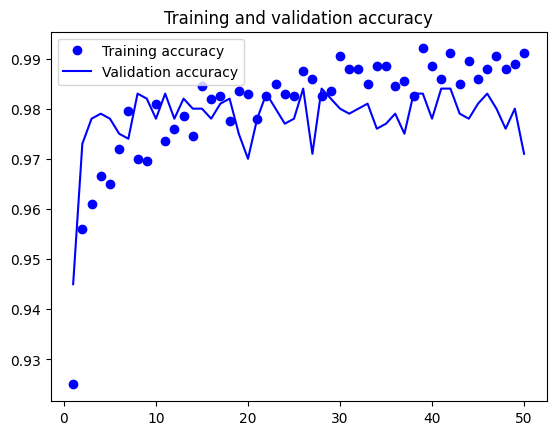

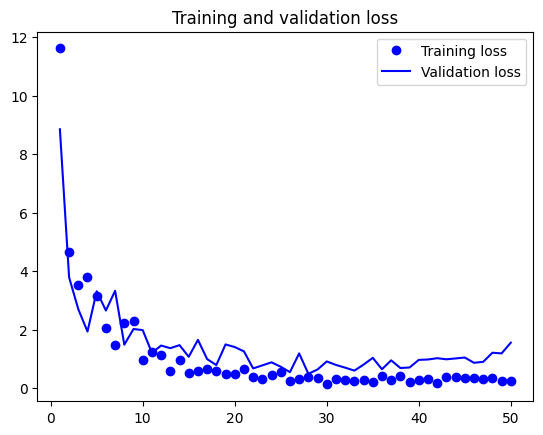

In [69]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Accuracy test

In [72]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 190ms/step - loss: 0.8924 - accuracy: 0.9780
Test accuracy: 0.978


Fine-Tuning VGG16

In [82]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [83]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [84]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 180, 180, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 180, 180, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0   

In [85]:
import tensorflow as tf
import time

class EpochTimerCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch + 1}...")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning",
        save_best_only=True,
        monitor="val_loss"
    ),
    EpochTimerCallback()  # Add the timer callback
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset
)



Epoch 1/30


2024-12-03 17:05:20.670252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:21.048699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:21.343063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:21.658163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:21.987132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:22.365841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:22.786133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:23.232158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:23.713377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:24.133574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:24.566409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:24.976443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:25.360610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:25.725050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 1.5051e-04 - accuracy: 1.0000

2024-12-03 17:05:26.086263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 1.4047e-04 - accuracy: 1.0000

2024-12-03 17:05:26.458189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 1.3169e-04 - accuracy: 1.0000

2024-12-03 17:05:26.876395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 1.4384e-04 - accuracy: 1.0000

2024-12-03 17:05:27.304828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 1.3585e-04 - accuracy: 1.0000

2024-12-03 17:05:27.736237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 17s - loss: 1.2870e-04 - accuracy: 1.0000

2024-12-03 17:05:28.108666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 1.2226e-04 - accuracy: 1.0000

2024-12-03 17:05:28.487247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 1.1644e-04 - accuracy: 1.0000

2024-12-03 17:05:28.872075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 1.1115e-04 - accuracy: 1.0000

2024-12-03 17:05:29.234818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 1.0632e-04 - accuracy: 1.0000

2024-12-03 17:05:29.595938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 1.0189e-04 - accuracy: 1.0000

2024-12-03 17:05:29.953025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 9.7816e-05 - accuracy: 1.0000

2024-12-03 17:05:30.295068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 9.4054e-05 - accuracy: 1.0000

2024-12-03 17:05:30.650874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 9.0570e-05 - accuracy: 1.0000

2024-12-03 17:05:30.999345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 8.7335e-05 - accuracy: 1.0000

2024-12-03 17:05:31.351768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 8.4324e-05 - accuracy: 1.0000

2024-12-03 17:05:31.705991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 8.1513e-05 - accuracy: 1.0000

2024-12-03 17:05:32.056651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 7.8884e-05 - accuracy: 1.0000

2024-12-03 17:05:32.383063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 7.6419e-05 - accuracy: 1.0000

2024-12-03 17:05:32.743629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 7.4103e-05 - accuracy: 1.0000

2024-12-03 17:05:33.121282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 7.1924e-05 - accuracy: 1.0000

2024-12-03 17:05:33.534746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 6.9869e-05 - accuracy: 1.0000

2024-12-03 17:05:33.954614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 6.7928e-05 - accuracy: 1.0000

2024-12-03 17:05:34.345921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 6.6092e-05 - accuracy: 1.0000 

2024-12-03 17:05:34.739012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 6.4353e-05 - accuracy: 1.0000

2024-12-03 17:05:35.143354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 6.2703e-05 - accuracy: 1.0000

2024-12-03 17:05:35.519370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 6.5421e-04 - accuracy: 0.9992

2024-12-03 17:05:35.901464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 6.3825e-04 - accuracy: 0.9992

2024-12-03 17:05:36.269206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 6.2305e-04 - accuracy: 0.9993

2024-12-03 17:05:36.651297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 6.0856e-04 - accuracy: 0.9993

2024-12-03 17:05:36.997206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 5.9473e-04 - accuracy: 0.9993

2024-12-03 17:05:37.356673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 5.8152e-04 - accuracy: 0.9993

2024-12-03 17:05:37.720209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 5.6887e-04 - accuracy: 0.9993

2024-12-03 17:05:38.105766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 5.5677e-04 - accuracy: 0.9993

2024-12-03 17:05:38.512161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0054 - accuracy: 0.9987    

2024-12-03 17:05:38.884332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0053 - accuracy: 0.9987

2024-12-03 17:05:39.277365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0052 - accuracy: 0.9987

2024-12-03 17:05:39.654087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0051 - accuracy: 0.9988

2024-12-03 17:05:40.037921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0050 - accuracy: 0.9988

2024-12-03 17:05:40.407328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0049 - accuracy: 0.9988

2024-12-03 17:05:40.749104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0048 - accuracy: 0.9988

2024-12-03 17:05:41.098087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0047 - accuracy: 0.9989

2024-12-03 17:05:41.466876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0047 - accuracy: 0.9989

2024-12-03 17:05:41.824216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0046 - accuracy: 0.9989

2024-12-03 17:05:42.180162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9989

2024-12-03 17:05:42.532711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0044 - accuracy: 0.9989

2024-12-03 17:05:42.869682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0043 - accuracy: 0.9990

2024-12-03 17:05:43.230417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9990

2024-12-03 17:05:43.605563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990

2024-12-03 17:05:43.964716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 516ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.8692 - val_accuracy: 0.9830
Epoch 2/30


2024-12-03 17:05:53.027056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:05:53.421026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.1000 - accuracy: 0.9844    

2024-12-03 17:05:53.788004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 22s - loss: 0.0667 - accuracy: 0.9896

2024-12-03 17:05:54.174542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0500 - accuracy: 0.9922

2024-12-03 17:05:54.575093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 22s - loss: 0.0400 - accuracy: 0.9937

2024-12-03 17:05:54.957088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0336 - accuracy: 0.9948

2024-12-03 17:05:55.333995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9955

2024-12-03 17:05:55.706468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.0252 - accuracy: 0.9961

2024-12-03 17:05:56.073579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0224 - accuracy: 0.9965

2024-12-03 17:05:56.437175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.0202 - accuracy: 0.9969

2024-12-03 17:05:56.802070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9972

2024-12-03 17:05:57.169270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0168 - accuracy: 0.9974

2024-12-03 17:05:57.564888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.0155 - accuracy: 0.9976

2024-12-03 17:05:57.954078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9978

2024-12-03 17:05:58.330281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9979

2024-12-03 17:05:58.706679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0145 - accuracy: 0.9961

2024-12-03 17:05:59.085240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9963

2024-12-03 17:05:59.453924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.0129 - accuracy: 0.9965

2024-12-03 17:05:59.836503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0122 - accuracy: 0.9967

2024-12-03 17:06:00.204782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0116 - accuracy: 0.9969

2024-12-03 17:06:00.591683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0111 - accuracy: 0.9970

2024-12-03 17:06:00.954722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0106 - accuracy: 0.9972

2024-12-03 17:06:01.335616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.0101 - accuracy: 0.9973

2024-12-03 17:06:01.676283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0097 - accuracy: 0.9974

2024-12-03 17:06:02.054671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0093 - accuracy: 0.9975

2024-12-03 17:06:02.447393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0089 - accuracy: 0.9976

2024-12-03 17:06:02.834919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0086 - accuracy: 0.9977

2024-12-03 17:06:03.210412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0083 - accuracy: 0.9978

2024-12-03 17:06:03.577578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0080 - accuracy: 0.9978

2024-12-03 17:06:03.960148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0078 - accuracy: 0.9979

2024-12-03 17:06:04.351557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0075 - accuracy: 0.9980

2024-12-03 17:06:04.787487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0073 - accuracy: 0.9980

2024-12-03 17:06:05.232720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0070 - accuracy: 0.9981

2024-12-03 17:06:05.716785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.0068 - accuracy: 0.9982

2024-12-03 17:06:06.153090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0066 - accuracy: 0.9982

2024-12-03 17:06:06.576688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0111 - accuracy: 0.9974

2024-12-03 17:06:06.973271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.0108 - accuracy: 0.9975

2024-12-03 17:06:07.372905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0105 - accuracy: 0.9975 

2024-12-03 17:06:07.764203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0174 - accuracy: 0.9968

2024-12-03 17:06:08.148621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9969

2024-12-03 17:06:08.540209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0165 - accuracy: 0.9970

2024-12-03 17:06:08.940593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0161 - accuracy: 0.9970

2024-12-03 17:06:09.352735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9964

2024-12-03 17:06:09.753527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0259 - accuracy: 0.9964

2024-12-03 17:06:10.146568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.0253 - accuracy: 0.9965

2024-12-03 17:06:10.562860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0248 - accuracy: 0.9966

2024-12-03 17:06:10.955792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0242 - accuracy: 0.9967

2024-12-03 17:06:11.346506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0237 - accuracy: 0.9967

2024-12-03 17:06:11.737735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0453 - accuracy: 0.9962

2024-12-03 17:06:12.105100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.0444 - accuracy: 0.9962

2024-12-03 17:06:12.496059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0689 - accuracy: 0.9957

2024-12-03 17:06:12.875671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0676 - accuracy: 0.9958

2024-12-03 17:06:13.275808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9959

2024-12-03 17:06:13.660330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0651 - accuracy: 0.9959

2024-12-03 17:06:14.040452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0639 - accuracy: 0.9960

2024-12-03 17:06:14.436596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0628 - accuracy: 0.9961

2024-12-03 17:06:14.865850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0617 - accuracy: 0.9962

2024-12-03 17:06:15.281562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0606 - accuracy: 0.9962

2024-12-03 17:06:15.661881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0596 - accuracy: 0.9963

2024-12-03 17:06:16.060223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0586 - accuracy: 0.9964

2024-12-03 17:06:16.459536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0577 - accuracy: 0.9964

2024-12-03 17:06:16.858580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0568 - accuracy: 0.9965

2024-12-03 17:06:17.261589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 35s 557ms/step - loss: 0.0563 - accuracy: 0.9965 - val_loss: 1.0867 - val_accuracy: 0.9800
Epoch 3/30


2024-12-03 17:06:27.957126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 27s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:06:28.399053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 26s - loss: 4.5820e-07 - accuracy: 1.0000

2024-12-03 17:06:28.836840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 29s - loss: 0.7653 - accuracy: 0.9792    

2024-12-03 17:06:29.367728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 29s - loss: 0.5739 - accuracy: 0.9844

2024-12-03 17:06:29.906178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 29s - loss: 0.4841 - accuracy: 0.9812

2024-12-03 17:06:30.425924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 28s - loss: 0.4034 - accuracy: 0.9844

2024-12-03 17:06:30.893218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 27s - loss: 0.3458 - accuracy: 0.9866

2024-12-03 17:06:31.327465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 26s - loss: 0.3026 - accuracy: 0.9883

2024-12-03 17:06:31.762229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 25s - loss: 0.2690 - accuracy: 0.9896

2024-12-03 17:06:32.161605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 24s - loss: 0.2421 - accuracy: 0.9906

2024-12-03 17:06:32.632690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 24s - loss: 0.2201 - accuracy: 0.9915

2024-12-03 17:06:33.086943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9922

2024-12-03 17:06:33.538536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 23s - loss: 0.1862 - accuracy: 0.9928

2024-12-03 17:06:33.991275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 22s - loss: 0.1729 - accuracy: 0.9933

2024-12-03 17:06:34.436782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9937

2024-12-03 17:06:34.870339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 21s - loss: 0.1513 - accuracy: 0.9941

2024-12-03 17:06:35.338328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 21s - loss: 0.1424 - accuracy: 0.9945

2024-12-03 17:06:35.802705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 20s - loss: 0.1345 - accuracy: 0.9948

2024-12-03 17:06:36.252679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 20s - loss: 0.1274 - accuracy: 0.9951

2024-12-03 17:06:36.686871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 19s - loss: 0.1284 - accuracy: 0.9937

2024-12-03 17:06:37.150766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 19s - loss: 0.1223 - accuracy: 0.9940

2024-12-03 17:06:37.592010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 18s - loss: 0.1167 - accuracy: 0.9943

2024-12-03 17:06:38.023059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 18s - loss: 0.1116 - accuracy: 0.9946

2024-12-03 17:06:38.480388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 17s - loss: 0.1252 - accuracy: 0.9935

2024-12-03 17:06:38.934767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 17s - loss: 0.1202 - accuracy: 0.9937

2024-12-03 17:06:39.364394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 16s - loss: 0.1156 - accuracy: 0.9940

2024-12-03 17:06:39.796246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 16s - loss: 0.1113 - accuracy: 0.9942

2024-12-03 17:06:40.218172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 15s - loss: 0.1073 - accuracy: 0.9944

2024-12-03 17:06:40.618483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 15s - loss: 0.1036 - accuracy: 0.9946

2024-12-03 17:06:41.050172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 14s - loss: 0.1002 - accuracy: 0.9948

2024-12-03 17:06:41.467370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 14s - loss: 0.0970 - accuracy: 0.9950

2024-12-03 17:06:41.900095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 13s - loss: 0.0939 - accuracy: 0.9951

2024-12-03 17:06:42.303082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 13s - loss: 0.0911 - accuracy: 0.9953

2024-12-03 17:06:42.736895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 12s - loss: 0.0884 - accuracy: 0.9954

2024-12-03 17:06:43.186039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 12s - loss: 0.0880 - accuracy: 0.9946

2024-12-03 17:06:43.638768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 12s - loss: 0.0855 - accuracy: 0.9948

2024-12-03 17:06:44.071575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 11s - loss: 0.0832 - accuracy: 0.9949

2024-12-03 17:06:44.503489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 11s - loss: 0.0810 - accuracy: 0.9951

2024-12-03 17:06:44.950478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10s - loss: 0.0790 - accuracy: 0.9952

2024-12-03 17:06:45.386435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9953

2024-12-03 17:06:45.816444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9s - loss: 0.0751 - accuracy: 0.9954 

2024-12-03 17:06:46.258543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 9s - loss: 0.0745 - accuracy: 0.9948

2024-12-03 17:06:46.702411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 8s - loss: 0.0755 - accuracy: 0.9942

2024-12-03 17:06:47.127669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 8s - loss: 0.0738 - accuracy: 0.9943

2024-12-03 17:06:47.568190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 8s - loss: 0.0721 - accuracy: 0.9944

2024-12-03 17:06:48.000439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9946

2024-12-03 17:06:48.418774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 7s - loss: 0.0691 - accuracy: 0.9947

2024-12-03 17:06:48.845704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6s - loss: 0.0676 - accuracy: 0.9948

2024-12-03 17:06:49.271605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 6s - loss: 0.0663 - accuracy: 0.9949

2024-12-03 17:06:49.703183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.0649 - accuracy: 0.9950

2024-12-03 17:06:50.152224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 5s - loss: 0.0637 - accuracy: 0.9951

2024-12-03 17:06:50.586824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0624 - accuracy: 0.9952

2024-12-03 17:06:51.029160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.0613 - accuracy: 0.9953

2024-12-03 17:06:51.460917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0601 - accuracy: 0.9954

2024-12-03 17:06:51.873971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0590 - accuracy: 0.9955

2024-12-03 17:06:52.283390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 3s - loss: 0.0580 - accuracy: 0.9955

2024-12-03 17:06:52.696111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0599 - accuracy: 0.9951

2024-12-03 17:06:53.095254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.0589 - accuracy: 0.9952

2024-12-03 17:06:53.523068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0579 - accuracy: 0.9952

2024-12-03 17:06:53.950771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0569 - accuracy: 0.9953

2024-12-03 17:06:54.382754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0560 - accuracy: 0.9954

2024-12-03 17:06:54.873617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9955

2024-12-03 17:06:55.355768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 38s 611ms/step - loss: 0.0547 - accuracy: 0.9955 - val_loss: 0.8156 - val_accuracy: 0.9820
Epoch 4/30


2024-12-03 17:07:06.305846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:06.729406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:07.172058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 27s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:07.653727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 28s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:08.155118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 27s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:08.637955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:09.073736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:09.500365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:09.911661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:10.323426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:10.747121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:11.152692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:11.577142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:11.997492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:12.426516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:12.849739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:13.278954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:13.712734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:14.106413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:14.512215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:15.004461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:15.493393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:15.957345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 17s - loss: 2.1218e-08 - accuracy: 1.0000

2024-12-03 17:07:16.420142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 17s - loss: 2.0334e-08 - accuracy: 1.0000

2024-12-03 17:07:16.876781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 16s - loss: 0.0041 - accuracy: 0.9987    

2024-12-03 17:07:17.320191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 16s - loss: 0.0040 - accuracy: 0.9988

2024-12-03 17:07:17.786603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9977

2024-12-03 17:07:18.205777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 15s - loss: 0.0276 - accuracy: 0.9978

2024-12-03 17:07:18.679886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 15s - loss: 0.0266 - accuracy: 0.9978

2024-12-03 17:07:19.150471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 14s - loss: 0.0258 - accuracy: 0.9979

2024-12-03 17:07:19.581092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 14s - loss: 0.0249 - accuracy: 0.9980

2024-12-03 17:07:20.013225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 13s - loss: 0.0241 - accuracy: 0.9980

2024-12-03 17:07:20.455423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 13s - loss: 0.0234 - accuracy: 0.9981

2024-12-03 17:07:20.881410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 12s - loss: 0.0227 - accuracy: 0.9982

2024-12-03 17:07:21.300374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 12s - loss: 0.0221 - accuracy: 0.9982

2024-12-03 17:07:21.713670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 11s - loss: 0.0215 - accuracy: 0.9983

2024-12-03 17:07:22.117398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 11s - loss: 0.0209 - accuracy: 0.9983

2024-12-03 17:07:22.500569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10s - loss: 0.0204 - accuracy: 0.9984

2024-12-03 17:07:22.896989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10s - loss: 0.0198 - accuracy: 0.9984

2024-12-03 17:07:23.314988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 10s - loss: 0.0194 - accuracy: 0.9984

2024-12-03 17:07:23.749758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9s - loss: 0.0189 - accuracy: 0.9985 

2024-12-03 17:07:24.181881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 9s - loss: 0.0348 - accuracy: 0.9978

2024-12-03 17:07:24.599987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 8s - loss: 0.0340 - accuracy: 0.9978

2024-12-03 17:07:25.006573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 8s - loss: 0.0332 - accuracy: 0.9979

2024-12-03 17:07:25.411822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.0325 - accuracy: 0.9979

2024-12-03 17:07:25.821198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 7s - loss: 0.0318 - accuracy: 0.9980

2024-12-03 17:07:26.245100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0311 - accuracy: 0.9980

2024-12-03 17:07:26.619096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6s - loss: 0.0305 - accuracy: 0.9980

2024-12-03 17:07:27.021462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 6s - loss: 0.0298 - accuracy: 0.9981

2024-12-03 17:07:27.459912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.0293 - accuracy: 0.9981

2024-12-03 17:07:27.885017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 5s - loss: 0.0287 - accuracy: 0.9982

2024-12-03 17:07:28.285825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0281 - accuracy: 0.9982

2024-12-03 17:07:28.738796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.0276 - accuracy: 0.9982

2024-12-03 17:07:29.179425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0275 - accuracy: 0.9983

2024-12-03 17:07:29.641340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0270 - accuracy: 0.9983

2024-12-03 17:07:30.096546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 3s - loss: 0.0265 - accuracy: 0.9983

2024-12-03 17:07:30.533780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0260 - accuracy: 0.9984

2024-12-03 17:07:30.956247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.0256 - accuracy: 0.9984

2024-12-03 17:07:31.342581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0251 - accuracy: 0.9984

2024-12-03 17:07:31.740202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0280 - accuracy: 0.9979

2024-12-03 17:07:32.133658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.9980

2024-12-03 17:07:32.517032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0271 - accuracy: 0.9980

2024-12-03 17:07:32.922801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 37s 594ms/step - loss: 0.0269 - accuracy: 0.9980 - val_loss: 1.0593 - val_accuracy: 0.9830
Epoch 5/30


2024-12-03 17:07:43.549487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:43.974420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:44.352443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:44.784028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:45.216213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:45.666334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:07:46.135653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 24s - loss: 0.0277 - accuracy: 0.9955    

2024-12-03 17:07:46.563187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 23s - loss: 0.0242 - accuracy: 0.9961

2024-12-03 17:07:46.976357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 22s - loss: 0.0216 - accuracy: 0.9965

2024-12-03 17:07:47.361086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 22s - loss: 0.0194 - accuracy: 0.9969

2024-12-03 17:07:47.740144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 21s - loss: 0.0176 - accuracy: 0.9972

2024-12-03 17:07:48.124034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 21s - loss: 0.0162 - accuracy: 0.9974

2024-12-03 17:07:48.510880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 20s - loss: 0.0149 - accuracy: 0.9976

2024-12-03 17:07:48.925520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 20s - loss: 0.0139 - accuracy: 0.9978

2024-12-03 17:07:49.306390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9979

2024-12-03 17:07:49.691831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9980

2024-12-03 17:07:50.086654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 18s - loss: 0.0114 - accuracy: 0.9982

2024-12-03 17:07:50.489797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 18s - loss: 0.0108 - accuracy: 0.9983

2024-12-03 17:07:50.893421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 17s - loss: 0.0102 - accuracy: 0.9984

2024-12-03 17:07:51.280143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 17s - loss: 0.0097 - accuracy: 0.9984

2024-12-03 17:07:51.658064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.0105 - accuracy: 0.9970

2024-12-03 17:07:52.032931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 16s - loss: 0.0100 - accuracy: 0.9972

2024-12-03 17:07:52.418243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 16s - loss: 0.0095 - accuracy: 0.9973

2024-12-03 17:07:52.790597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 0.0092 - accuracy: 0.9974

2024-12-03 17:07:53.200623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 15s - loss: 0.0109 - accuracy: 0.9962

2024-12-03 17:07:53.658165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 15s - loss: 0.0105 - accuracy: 0.9964

2024-12-03 17:07:54.128415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 14s - loss: 0.0101 - accuracy: 0.9965

2024-12-03 17:07:54.629097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 14s - loss: 0.0097 - accuracy: 0.9967

2024-12-03 17:07:55.107195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 14s - loss: 0.0094 - accuracy: 0.9968

2024-12-03 17:07:55.585370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 13s - loss: 0.0091 - accuracy: 0.9969

2024-12-03 17:07:56.038776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 13s - loss: 0.0088 - accuracy: 0.9970

2024-12-03 17:07:56.496176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.0085 - accuracy: 0.9971

2024-12-03 17:07:56.950224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 12s - loss: 0.0083 - accuracy: 0.9972

2024-12-03 17:07:57.398781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 12s - loss: 0.0080 - accuracy: 0.9972

2024-12-03 17:07:57.849731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 11s - loss: 0.0078 - accuracy: 0.9973

2024-12-03 17:07:58.298357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 11s - loss: 0.0076 - accuracy: 0.9974

2024-12-03 17:07:58.725763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.0074 - accuracy: 0.9975

2024-12-03 17:07:59.158784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 10s - loss: 0.0072 - accuracy: 0.9975

2024-12-03 17:07:59.618360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10s - loss: 0.0070 - accuracy: 0.9976

2024-12-03 17:08:00.090309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9s - loss: 0.0068 - accuracy: 0.9977 

2024-12-03 17:08:00.560712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9s - loss: 0.0067 - accuracy: 0.9977

2024-12-03 17:08:01.027749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0065 - accuracy: 0.9978

2024-12-03 17:08:01.471142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 8s - loss: 0.0063 - accuracy: 0.9978

2024-12-03 17:08:01.927874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 8s - loss: 0.0062 - accuracy: 0.9979

2024-12-03 17:08:02.376767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.0061 - accuracy: 0.9979

2024-12-03 17:08:02.788289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 7s - loss: 0.0059 - accuracy: 0.9980

2024-12-03 17:08:03.193136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0058 - accuracy: 0.9980

2024-12-03 17:08:03.571613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6s - loss: 0.0057 - accuracy: 0.9980

2024-12-03 17:08:03.930479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0056 - accuracy: 0.9981

2024-12-03 17:08:04.294176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.0055 - accuracy: 0.9981

2024-12-03 17:08:04.680564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 5s - loss: 0.0054 - accuracy: 0.9982

2024-12-03 17:08:05.075975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0052 - accuracy: 0.9982

2024-12-03 17:08:05.464310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982

2024-12-03 17:08:05.863142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0051 - accuracy: 0.9983

2024-12-03 17:08:06.258671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0094 - accuracy: 0.9977

2024-12-03 17:08:06.641271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0092 - accuracy: 0.9978

2024-12-03 17:08:07.028258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0090 - accuracy: 0.9978

2024-12-03 17:08:07.405306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.0089 - accuracy: 0.9978

2024-12-03 17:08:07.777865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0087 - accuracy: 0.9979

2024-12-03 17:08:08.187243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0086 - accuracy: 0.9979

2024-12-03 17:08:08.577399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9980

2024-12-03 17:08:08.996646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9975

2024-12-03 17:08:09.420946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 36s 578ms/step - loss: 0.0164 - accuracy: 0.9975 - val_loss: 1.0028 - val_accuracy: 0.9770
Epoch 6/30


2024-12-03 17:08:19.829835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:20.260196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:20.661863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:21.098532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:21.532501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:21.944260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:22.346358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:22.725166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:23.093002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:08:23.452726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0806 - accuracy: 0.9969    

2024-12-03 17:08:23.825271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.0733 - accuracy: 0.9972

2024-12-03 17:08:24.204707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0672 - accuracy: 0.9974

2024-12-03 17:08:24.614100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.0620 - accuracy: 0.9976

2024-12-03 17:08:24.973617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 19s - loss: 0.0576 - accuracy: 0.9978

2024-12-03 17:08:25.361037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0537 - accuracy: 0.9979

2024-12-03 17:08:25.756980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.0504 - accuracy: 0.9980

2024-12-03 17:08:26.156083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 18s - loss: 0.0580 - accuracy: 0.9963

2024-12-03 17:08:26.556190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.0547 - accuracy: 0.9965

2024-12-03 17:08:26.940365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 17s - loss: 0.0519 - accuracy: 0.9967

2024-12-03 17:08:27.312734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0493 - accuracy: 0.9969

2024-12-03 17:08:27.694124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.0469 - accuracy: 0.9970

2024-12-03 17:08:28.070252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0448 - accuracy: 0.9972

2024-12-03 17:08:28.440274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.0428 - accuracy: 0.9973

2024-12-03 17:08:28.820713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 0.0411 - accuracy: 0.9974

2024-12-03 17:08:29.202949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0394 - accuracy: 0.9975

2024-12-03 17:08:29.588324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.0379 - accuracy: 0.9976

2024-12-03 17:08:29.947930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0365 - accuracy: 0.9977

2024-12-03 17:08:30.323958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0352 - accuracy: 0.9978

2024-12-03 17:08:30.710521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.0340 - accuracy: 0.9978

2024-12-03 17:08:31.108562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0328 - accuracy: 0.9979

2024-12-03 17:08:31.493049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0318 - accuracy: 0.9980

2024-12-03 17:08:31.877999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0819 - accuracy: 0.9971

2024-12-03 17:08:32.248445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0795 - accuracy: 0.9972

2024-12-03 17:08:32.626253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.0771 - accuracy: 0.9972

2024-12-03 17:08:33.006313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0749 - accuracy: 0.9973

2024-12-03 17:08:33.384450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0728 - accuracy: 0.9974

2024-12-03 17:08:33.773153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.0709 - accuracy: 0.9975

2024-12-03 17:08:34.140277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0690 - accuracy: 0.9975 

2024-12-03 17:08:34.519855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0672 - accuracy: 0.9976

2024-12-03 17:08:34.895015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0656 - accuracy: 0.9977

2024-12-03 17:08:35.233129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0659 - accuracy: 0.9970

2024-12-03 17:08:35.614727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0643 - accuracy: 0.9970

2024-12-03 17:08:36.035237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0628 - accuracy: 0.9971

2024-12-03 17:08:36.439490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0614 - accuracy: 0.9972

2024-12-03 17:08:36.827719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0600 - accuracy: 0.9972

2024-12-03 17:08:37.221045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0587 - accuracy: 0.9973

2024-12-03 17:08:37.604282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0575 - accuracy: 0.9973

2024-12-03 17:08:37.972804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0563 - accuracy: 0.9974

2024-12-03 17:08:38.353439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0551 - accuracy: 0.9974

2024-12-03 17:08:38.724309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0540 - accuracy: 0.9975

2024-12-03 17:08:39.092093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0530 - accuracy: 0.9975

2024-12-03 17:08:39.463504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0520 - accuracy: 0.9976

2024-12-03 17:08:39.837575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0510 - accuracy: 0.9976

2024-12-03 17:08:40.225595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0500 - accuracy: 0.9977

2024-12-03 17:08:40.609125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0491 - accuracy: 0.9977

2024-12-03 17:08:41.017267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0483 - accuracy: 0.9978

2024-12-03 17:08:41.420178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0474 - accuracy: 0.9978

2024-12-03 17:08:41.805365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0466 - accuracy: 0.9978

2024-12-03 17:08:42.177702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0458 - accuracy: 0.9979

2024-12-03 17:08:42.549193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0450 - accuracy: 0.9979

2024-12-03 17:08:42.923780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9980

2024-12-03 17:08:43.285397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0436 - accuracy: 0.9980

2024-12-03 17:08:43.667570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 34s 538ms/step - loss: 0.0432 - accuracy: 0.9980 - val_loss: 0.9800 - val_accuracy: 0.9780
Epoch 7/30


2024-12-03 17:08:53.608618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 25s - loss: 0.7364 - accuracy: 0.9688

2024-12-03 17:08:54.025562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 24s - loss: 0.3682 - accuracy: 0.9844

2024-12-03 17:08:54.417150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 24s - loss: 0.2455 - accuracy: 0.9896

2024-12-03 17:08:54.830530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 24s - loss: 0.1841 - accuracy: 0.9922

2024-12-03 17:08:55.260657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 23s - loss: 0.1473 - accuracy: 0.9937

2024-12-03 17:08:55.665173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 23s - loss: 0.1227 - accuracy: 0.9948

2024-12-03 17:08:56.054819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.1052 - accuracy: 0.9955

2024-12-03 17:08:56.443478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.0921 - accuracy: 0.9961

2024-12-03 17:08:56.821698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.0818 - accuracy: 0.9965

2024-12-03 17:08:57.193221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0736 - accuracy: 0.9969

2024-12-03 17:08:57.558308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.0669 - accuracy: 0.9972

2024-12-03 17:08:57.925001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0614 - accuracy: 0.9974

2024-12-03 17:08:58.290354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.0717 - accuracy: 0.9952

2024-12-03 17:08:58.660680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0666 - accuracy: 0.9955

2024-12-03 17:08:59.045161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0622 - accuracy: 0.9958

2024-12-03 17:08:59.418634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.0583 - accuracy: 0.9961

2024-12-03 17:08:59.812664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0549 - accuracy: 0.9963

2024-12-03 17:09:00.209810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.0518 - accuracy: 0.9965

2024-12-03 17:09:00.596079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0491 - accuracy: 0.9967

2024-12-03 17:09:00.970355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0466 - accuracy: 0.9969

2024-12-03 17:09:01.354017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.0444 - accuracy: 0.9970

2024-12-03 17:09:01.726502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0424 - accuracy: 0.9972

2024-12-03 17:09:02.092066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.0407 - accuracy: 0.9973

2024-12-03 17:09:02.473907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0390 - accuracy: 0.9974

2024-12-03 17:09:02.841888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0575 - accuracy: 0.9962

2024-12-03 17:09:03.212914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.0553 - accuracy: 0.9964

2024-12-03 17:09:03.595791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0532 - accuracy: 0.9965

2024-12-03 17:09:03.990407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0513 - accuracy: 0.9967

2024-12-03 17:09:04.373147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.0495 - accuracy: 0.9968

2024-12-03 17:09:04.777341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0479 - accuracy: 0.9969

2024-12-03 17:09:05.163843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0464 - accuracy: 0.9970

2024-12-03 17:09:05.540296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0449 - accuracy: 0.9971

2024-12-03 17:09:05.920886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0435 - accuracy: 0.9972

2024-12-03 17:09:06.287775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.0423 - accuracy: 0.9972

2024-12-03 17:09:06.657409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0423 - accuracy: 0.9964

2024-12-03 17:09:07.034480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0411 - accuracy: 0.9965

2024-12-03 17:09:07.419090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0400 - accuracy: 0.9966 

2024-12-03 17:09:07.807383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0389 - accuracy: 0.9967

2024-12-03 17:09:08.188265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0379 - accuracy: 0.9968

2024-12-03 17:09:08.581936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0370 - accuracy: 0.9969

2024-12-03 17:09:08.960861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0361 - accuracy: 0.9970

2024-12-03 17:09:09.345734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0352 - accuracy: 0.9970

2024-12-03 17:09:09.724281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0344 - accuracy: 0.9971

2024-12-03 17:09:10.109003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0336 - accuracy: 0.9972

2024-12-03 17:09:10.479266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0329 - accuracy: 0.9972

2024-12-03 17:09:10.859850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0322 - accuracy: 0.9973

2024-12-03 17:09:11.245093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0441 - accuracy: 0.9967

2024-12-03 17:09:11.622999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0432 - accuracy: 0.9967

2024-12-03 17:09:12.004473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0423 - accuracy: 0.9968

2024-12-03 17:09:12.371291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0464 - accuracy: 0.9962

2024-12-03 17:09:12.748753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0455 - accuracy: 0.9963

2024-12-03 17:09:13.143281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0446 - accuracy: 0.9964

2024-12-03 17:09:13.530890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0437 - accuracy: 0.9965

2024-12-03 17:09:13.920985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0429 - accuracy: 0.9965

2024-12-03 17:09:14.304459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0422 - accuracy: 0.9966

2024-12-03 17:09:14.676810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0414 - accuracy: 0.9967

2024-12-03 17:09:15.056973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0407 - accuracy: 0.9967

2024-12-03 17:09:15.427829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0400 - accuracy: 0.9968

2024-12-03 17:09:15.805697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0393 - accuracy: 0.9968

2024-12-03 17:09:16.190851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0386 - accuracy: 0.9969

2024-12-03 17:09:16.563132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9969

2024-12-03 17:09:16.917374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9970

2024-12-03 17:09:17.284925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 34s 538ms/step - loss: 0.0371 - accuracy: 0.9970 - val_loss: 1.0098 - val_accuracy: 0.9780
Epoch 8/30


2024-12-03 17:09:27.405545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:09:27.841368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:09:28.263552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 25s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-03 17:09:28.699079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 25s - loss: 0.0287 - accuracy: 0.9922    

2024-12-03 17:09:29.132222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 24s - loss: 0.0230 - accuracy: 0.9937

2024-12-03 17:09:29.539939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 23s - loss: 0.0191 - accuracy: 0.9948

2024-12-03 17:09:29.942709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 23s - loss: 0.0164 - accuracy: 0.9955

2024-12-03 17:09:30.310399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 22s - loss: 0.0144 - accuracy: 0.9961

2024-12-03 17:09:30.676749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.0128 - accuracy: 0.9965

2024-12-03 17:09:31.051360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 21s - loss: 0.0115 - accuracy: 0.9969

2024-12-03 17:09:31.425015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.0106 - accuracy: 0.9972

2024-12-03 17:09:31.801616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 20s - loss: 0.0098 - accuracy: 0.9974

2024-12-03 17:09:32.183583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.0090 - accuracy: 0.9976

2024-12-03 17:09:32.588027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 19s - loss: 0.0084 - accuracy: 0.9978

2024-12-03 17:09:32.968118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0078 - accuracy: 0.9979

2024-12-03 17:09:33.366740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.0073 - accuracy: 0.9980

2024-12-03 17:09:33.760817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 18s - loss: 0.0069 - accuracy: 0.9982

2024-12-03 17:09:34.140627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.0065 - accuracy: 0.9983

2024-12-03 17:09:34.526874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 17s - loss: 0.0062 - accuracy: 0.9984

2024-12-03 17:09:34.918729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0059 - accuracy: 0.9984

2024-12-03 17:09:35.300224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.0056 - accuracy: 0.9985

2024-12-03 17:09:35.674734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 16s - loss: 0.0053 - accuracy: 0.9986

2024-12-03 17:09:36.041090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.0051 - accuracy: 0.9986

2024-12-03 17:09:36.406821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 15s - loss: 0.0049 - accuracy: 0.9987

2024-12-03 17:09:36.777653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9987

2024-12-03 17:09:37.181727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9988

2024-12-03 17:09:37.576858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 14s - loss: 0.0043 - accuracy: 0.9988

2024-12-03 17:09:37.971309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0042 - accuracy: 0.9989

2024-12-03 17:09:38.374532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 13s - loss: 0.0040 - accuracy: 0.9989

2024-12-03 17:09:38.756035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0039 - accuracy: 0.9990

2024-12-03 17:09:39.139879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0038 - accuracy: 0.9990

2024-12-03 17:09:39.510792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 12s - loss: 0.0037 - accuracy: 0.9990

2024-12-03 17:09:39.887051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0035 - accuracy: 0.9991

2024-12-03 17:09:40.251254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.0035 - accuracy: 0.9991

2024-12-03 17:09:40.620949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0034 - accuracy: 0.9991

2024-12-03 17:09:40.991726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0056 - accuracy: 0.9983

2024-12-03 17:09:41.387838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 10s - loss: 0.0055 - accuracy: 0.9983

2024-12-03 17:09:41.774958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0053 - accuracy: 0.9984 

2024-12-03 17:09:42.163533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0052 - accuracy: 0.9984

2024-12-03 17:09:42.561061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0051 - accuracy: 0.9984

2024-12-03 17:09:42.959167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0050 - accuracy: 0.9985

2024-12-03 17:09:43.332591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0048 - accuracy: 0.9985

2024-12-03 17:09:43.700889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0047 - accuracy: 0.9985

2024-12-03 17:09:44.085385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0046 - accuracy: 0.9986

2024-12-03 17:09:44.453311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0045 - accuracy: 0.9986

2024-12-03 17:09:44.819839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0044 - accuracy: 0.9986

2024-12-03 17:09:45.229428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0248 - accuracy: 0.9980

2024-12-03 17:09:45.588039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0243 - accuracy: 0.9980

2024-12-03 17:09:45.960660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0238 - accuracy: 0.9981

2024-12-03 17:09:46.342006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.0234 - accuracy: 0.9981

2024-12-03 17:09:46.730191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0229 - accuracy: 0.9982

2024-12-03 17:09:47.124442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0225 - accuracy: 0.9982

2024-12-03 17:09:47.505867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0220 - accuracy: 0.9982

2024-12-03 17:09:47.887152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0216 - accuracy: 0.9983

2024-12-03 17:09:48.269120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0351 - accuracy: 0.9977

2024-12-03 17:09:48.641825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0345 - accuracy: 0.9978

2024-12-03 17:09:48.999808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0339 - accuracy: 0.9978

2024-12-03 17:09:49.352325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0333 - accuracy: 0.9978

2024-12-03 17:09:49.705804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0328 - accuracy: 0.9979

2024-12-03 17:09:50.094416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0322 - accuracy: 0.9979

2024-12-03 17:09:50.493250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9980

2024-12-03 17:09:50.878419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9980

2024-12-03 17:09:51.255044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 34s 535ms/step - loss: 0.0309 - accuracy: 0.9980 - val_loss: 1.0198 - val_accuracy: 0.9820
Epoch 9/30


2024-12-03 17:10:01.009539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:01.408309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:01.790647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:02.184837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:02.596350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:02.994628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:03.392492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:03.771363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:04.140703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:04.503178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:04.855184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:05.211118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:05.542086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:05.906395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:06.294090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:06.678687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:07.059959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:07.435302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.0442 - accuracy: 0.9983    

2024-12-03 17:10:07.808310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9984

2024-12-03 17:10:08.180906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0398 - accuracy: 0.9984

2024-12-03 17:10:08.535496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0379 - accuracy: 0.9985

2024-12-03 17:10:08.898454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0362 - accuracy: 0.9986

2024-12-03 17:10:09.256279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.0346 - accuracy: 0.9986

2024-12-03 17:10:09.599788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0332 - accuracy: 0.9987

2024-12-03 17:10:09.967089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9987

2024-12-03 17:10:10.361400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0306 - accuracy: 0.9988

2024-12-03 17:10:10.744639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0295 - accuracy: 0.9988

2024-12-03 17:10:11.140691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0284 - accuracy: 0.9989

2024-12-03 17:10:11.548000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0275 - accuracy: 0.9989

2024-12-03 17:10:11.940636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0265 - accuracy: 0.9990

2024-12-03 17:10:12.339162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0257 - accuracy: 0.9990

2024-12-03 17:10:12.724942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0249 - accuracy: 0.9990

2024-12-03 17:10:13.094180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0241 - accuracy: 0.9991

2024-12-03 17:10:13.486872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0234 - accuracy: 0.9991

2024-12-03 17:10:13.879606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0228 - accuracy: 0.9991

2024-12-03 17:10:14.253073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0247 - accuracy: 0.9983

2024-12-03 17:10:14.618365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0240 - accuracy: 0.9983 

2024-12-03 17:10:14.977238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0234 - accuracy: 0.9984

2024-12-03 17:10:15.337093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0228 - accuracy: 0.9984

2024-12-03 17:10:15.691395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0222 - accuracy: 0.9984

2024-12-03 17:10:16.058602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0278 - accuracy: 0.9977

2024-12-03 17:10:16.420627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0272 - accuracy: 0.9978

2024-12-03 17:10:16.788658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0265 - accuracy: 0.9978

2024-12-03 17:10:17.161983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0259 - accuracy: 0.9979

2024-12-03 17:10:17.552762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0291 - accuracy: 0.9972

2024-12-03 17:10:17.942822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0285 - accuracy: 0.9973

2024-12-03 17:10:18.320938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0279 - accuracy: 0.9973

2024-12-03 17:10:18.686026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0273 - accuracy: 0.9974

2024-12-03 17:10:19.055021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0268 - accuracy: 0.9974

2024-12-03 17:10:19.419521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0262 - accuracy: 0.9975

2024-12-03 17:10:19.783859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0257 - accuracy: 0.9975

2024-12-03 17:10:20.150806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0252 - accuracy: 0.9976

2024-12-03 17:10:20.504047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0247 - accuracy: 0.9976

2024-12-03 17:10:20.859099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0243 - accuracy: 0.9977

2024-12-03 17:10:21.244418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9977

2024-12-03 17:10:21.760076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0234 - accuracy: 0.9978

2024-12-03 17:10:22.143725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0230 - accuracy: 0.9978

2024-12-03 17:10:22.540841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0226 - accuracy: 0.9978

2024-12-03 17:10:22.929559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0222 - accuracy: 0.9979

2024-12-03 17:10:23.309988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0263 - accuracy: 0.9974

2024-12-03 17:10:23.684638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9974

2024-12-03 17:10:24.055823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9975

2024-12-03 17:10:24.412922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 33s 531ms/step - loss: 0.0252 - accuracy: 0.9975 - val_loss: 1.4855 - val_accuracy: 0.9750
Epoch 10/30


2024-12-03 17:10:34.336564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:34.737565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:35.091187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:35.468350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:35.870697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:10:36.285253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 0.0501 - accuracy: 0.9948    

2024-12-03 17:10:36.696606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.0430 - accuracy: 0.9955

2024-12-03 17:10:37.099166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 0.0376 - accuracy: 0.9961

2024-12-03 17:10:37.496883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 21s - loss: 0.0334 - accuracy: 0.9965

2024-12-03 17:10:37.872529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0302 - accuracy: 0.9969

2024-12-03 17:10:38.238551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 20s - loss: 0.0274 - accuracy: 0.9972

2024-12-03 17:10:38.621486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0251 - accuracy: 0.9974

2024-12-03 17:10:38.984902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.0232 - accuracy: 0.9976

2024-12-03 17:10:39.357193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0216 - accuracy: 0.9978

2024-12-03 17:10:39.738212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0201 - accuracy: 0.9979

2024-12-03 17:10:40.114621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 18s - loss: 0.0189 - accuracy: 0.9980

2024-12-03 17:10:40.495827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0177 - accuracy: 0.9982

2024-12-03 17:10:40.878742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9983

2024-12-03 17:10:41.256989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0159 - accuracy: 0.9984

2024-12-03 17:10:41.628328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0151 - accuracy: 0.9984

2024-12-03 17:10:42.010028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 16s - loss: 0.0144 - accuracy: 0.9985

2024-12-03 17:10:42.385715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0137 - accuracy: 0.9986

2024-12-03 17:10:42.761216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.0131 - accuracy: 0.9986

2024-12-03 17:10:43.163921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0126 - accuracy: 0.9987

2024-12-03 17:10:43.539789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0121 - accuracy: 0.9987

2024-12-03 17:10:43.924207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 14s - loss: 0.0116 - accuracy: 0.9988

2024-12-03 17:10:44.305900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0112 - accuracy: 0.9988

2024-12-03 17:10:44.678198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0206 - accuracy: 0.9978

2024-12-03 17:10:45.055243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0199 - accuracy: 0.9978

2024-12-03 17:10:45.431917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0208 - accuracy: 0.9969

2024-12-03 17:10:45.807594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0202 - accuracy: 0.9970

2024-12-03 17:10:46.170216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0195 - accuracy: 0.9971

2024-12-03 17:10:46.552094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0189 - accuracy: 0.9972

2024-12-03 17:10:46.943618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 11s - loss: 0.0184 - accuracy: 0.9972

2024-12-03 17:10:47.323760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0179 - accuracy: 0.9973

2024-12-03 17:10:47.708600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0174 - accuracy: 0.9974

2024-12-03 17:10:48.087147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0169 - accuracy: 0.9975 

2024-12-03 17:10:48.453431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0164 - accuracy: 0.9975

2024-12-03 17:10:48.865713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0160 - accuracy: 0.9976

2024-12-03 17:10:49.218836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9977

2024-12-03 17:10:49.608007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0152 - accuracy: 0.9977

2024-12-03 17:10:50.005438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0149 - accuracy: 0.9978

2024-12-03 17:10:50.397451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0145 - accuracy: 0.9978

2024-12-03 17:10:50.786970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0142 - accuracy: 0.9979

2024-12-03 17:10:51.174488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0139 - accuracy: 0.9979

2024-12-03 17:10:51.555819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0265 - accuracy: 0.9973

2024-12-03 17:10:51.934820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0465 - accuracy: 0.9967

2024-12-03 17:10:52.304834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0456 - accuracy: 0.9967

2024-12-03 17:10:52.675908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0446 - accuracy: 0.9968

2024-12-03 17:10:53.042507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0437 - accuracy: 0.9969

2024-12-03 17:10:53.409776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0429 - accuracy: 0.9969

2024-12-03 17:10:53.831787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0421 - accuracy: 0.9970

2024-12-03 17:10:54.188281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0413 - accuracy: 0.9971

2024-12-03 17:10:54.571045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0405 - accuracy: 0.9971

2024-12-03 17:10:54.970586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0398 - accuracy: 0.9972

2024-12-03 17:10:55.357532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0390 - accuracy: 0.9972

2024-12-03 17:10:55.741594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0384 - accuracy: 0.9973

2024-12-03 17:10:56.109523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0377 - accuracy: 0.9973

2024-12-03 17:10:56.484293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0371 - accuracy: 0.9974

2024-12-03 17:10:56.848211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0364 - accuracy: 0.9974

2024-12-03 17:10:57.211960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0383 - accuracy: 0.9969

2024-12-03 17:10:57.600733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9970

2024-12-03 17:10:57.975013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 33s 531ms/step - loss: 0.0373 - accuracy: 0.9970 - val_loss: 0.8985 - val_accuracy: 0.9840
Epoch 11/30


2024-12-03 17:11:07.629914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:08.053102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:08.448577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:08.868206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:09.279414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:09.677299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 22s - loss: 7.9504e-05 - accuracy: 1.0000

2024-12-03 17:11:10.058105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 22s - loss: 0.0011 - accuracy: 1.0000    

2024-12-03 17:11:10.426142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 21s - loss: 9.3123e-04 - accuracy: 1.0000

2024-12-03 17:11:10.795207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 8.2776e-04 - accuracy: 1.0000

2024-12-03 17:11:11.155330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0104 - accuracy: 0.9969    

2024-12-03 17:11:11.519842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0094 - accuracy: 0.9972

2024-12-03 17:11:11.875913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0086 - accuracy: 0.9974

2024-12-03 17:11:12.256664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 0.0080 - accuracy: 0.9976

2024-12-03 17:11:12.632639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0074 - accuracy: 0.9978

2024-12-03 17:11:13.010049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 0.0069 - accuracy: 0.9979

2024-12-03 17:11:13.394032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0065 - accuracy: 0.9980

2024-12-03 17:11:13.777213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0093 - accuracy: 0.9963

2024-12-03 17:11:14.162310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 17s - loss: 0.0087 - accuracy: 0.9965

2024-12-03 17:11:14.536146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0083 - accuracy: 0.9967

2024-12-03 17:11:14.900179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 16s - loss: 0.0079 - accuracy: 0.9969

2024-12-03 17:11:15.268862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0075 - accuracy: 0.9970

2024-12-03 17:11:15.632276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0072 - accuracy: 0.9972

2024-12-03 17:11:16.007286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 15s - loss: 0.0068 - accuracy: 0.9973

2024-12-03 17:11:16.360840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0066 - accuracy: 0.9974

2024-12-03 17:11:16.717414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0063 - accuracy: 0.9975

2024-12-03 17:11:17.104262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0061 - accuracy: 0.9976

2024-12-03 17:11:17.493563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0058 - accuracy: 0.9977

2024-12-03 17:11:17.875852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 13s - loss: 0.0056 - accuracy: 0.9978

2024-12-03 17:11:18.248072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0054 - accuracy: 0.9978

2024-12-03 17:11:18.619055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0052 - accuracy: 0.9979

2024-12-03 17:11:18.987916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 12s - loss: 0.0051 - accuracy: 0.9980

2024-12-03 17:11:19.359321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0049 - accuracy: 0.9980

2024-12-03 17:11:19.715405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0048 - accuracy: 0.9981

2024-12-03 17:11:20.075293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0046 - accuracy: 0.9982

2024-12-03 17:11:20.453688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0045 - accuracy: 0.9982

2024-12-03 17:11:20.845924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 10s - loss: 0.0044 - accuracy: 0.9983

2024-12-03 17:11:21.220092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0043 - accuracy: 0.9983 

2024-12-03 17:11:21.583037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0041 - accuracy: 0.9984

2024-12-03 17:11:21.950851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 9s - loss: 0.0040 - accuracy: 0.9984

2024-12-03 17:11:22.320123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0039 - accuracy: 0.9984

2024-12-03 17:11:22.685280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0038 - accuracy: 0.9985

2024-12-03 17:11:23.043419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0037 - accuracy: 0.9985

2024-12-03 17:11:23.433855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0037 - accuracy: 0.9985

2024-12-03 17:11:23.790285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0036 - accuracy: 0.9986

2024-12-03 17:11:24.159429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0035 - accuracy: 0.9986

2024-12-03 17:11:24.535551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0034 - accuracy: 0.9986

2024-12-03 17:11:24.918798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0033 - accuracy: 0.9987

2024-12-03 17:11:25.291916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0033 - accuracy: 0.9987

2024-12-03 17:11:25.656018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0032 - accuracy: 0.9987

2024-12-03 17:11:26.023363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0031 - accuracy: 0.9987

2024-12-03 17:11:26.380186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0031 - accuracy: 0.9988

2024-12-03 17:11:26.749638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0030 - accuracy: 0.9988

2024-12-03 17:11:27.119183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0030 - accuracy: 0.9988

2024-12-03 17:11:27.499856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0029 - accuracy: 0.9988

2024-12-03 17:11:27.872549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0029 - accuracy: 0.9989

2024-12-03 17:11:28.240266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0028 - accuracy: 0.9989

2024-12-03 17:11:28.603933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0028 - accuracy: 0.9989

2024-12-03 17:11:28.968240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0027 - accuracy: 0.9989

2024-12-03 17:11:29.342689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0027 - accuracy: 0.9989

2024-12-03 17:11:29.708217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0026 - accuracy: 0.9990

2024-12-03 17:11:30.063027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9990

2024-12-03 17:11:30.414797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9990

2024-12-03 17:11:30.797208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 33s 521ms/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 1.0361 - val_accuracy: 0.9800
Epoch 12/30


2024-12-03 17:11:40.351150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:40.753830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:41.126481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:41.507695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:41.892847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:42.288151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:11:42.676863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0019 - accuracy: 1.0000    

2024-12-03 17:11:43.036614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.0017 - accuracy: 1.0000

2024-12-03 17:11:43.407895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0015 - accuracy: 1.0000

2024-12-03 17:11:43.765340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.0013 - accuracy: 1.0000

2024-12-03 17:11:44.121830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0012 - accuracy: 1.0000

2024-12-03 17:11:44.502740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 19s - loss: 0.0643 - accuracy: 0.9974

2024-12-03 17:11:44.859041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.0593 - accuracy: 0.9976

2024-12-03 17:11:45.224775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.0551 - accuracy: 0.9978

2024-12-03 17:11:45.584984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.0514 - accuracy: 0.9979

2024-12-03 17:11:45.957632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0482 - accuracy: 0.9980

2024-12-03 17:11:46.322915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 0.0454 - accuracy: 0.9982

2024-12-03 17:11:46.688460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.0429 - accuracy: 0.9983

2024-12-03 17:11:47.055052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0406 - accuracy: 0.9984

2024-12-03 17:11:47.417184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.0386 - accuracy: 0.9984

2024-12-03 17:11:47.775176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0367 - accuracy: 0.9985

2024-12-03 17:11:48.134579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0351 - accuracy: 0.9986

2024-12-03 17:11:48.501394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.0335 - accuracy: 0.9986

2024-12-03 17:11:48.874724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0322 - accuracy: 0.9987

2024-12-03 17:11:49.243979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 14s - loss: 0.0309 - accuracy: 0.9987

2024-12-03 17:11:49.602815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0297 - accuracy: 0.9988

2024-12-03 17:11:49.968666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0286 - accuracy: 0.9988

2024-12-03 17:11:50.334406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.0276 - accuracy: 0.9989

2024-12-03 17:11:50.698094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0266 - accuracy: 0.9989

2024-12-03 17:11:51.043145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0257 - accuracy: 0.9990

2024-12-03 17:11:51.387183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.0249 - accuracy: 0.9990

2024-12-03 17:11:51.751711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0241 - accuracy: 0.9990

2024-12-03 17:11:52.134765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0234 - accuracy: 0.9991

2024-12-03 17:11:52.505868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0227 - accuracy: 0.9991

2024-12-03 17:11:52.866674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0221 - accuracy: 0.9991

2024-12-03 17:11:53.225621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0214 - accuracy: 0.9991 

2024-12-03 17:11:53.583129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0209 - accuracy: 0.9992

2024-12-03 17:11:53.939501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0536 - accuracy: 0.9984

2024-12-03 17:11:54.297881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0522 - accuracy: 0.9984

2024-12-03 17:11:54.682814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9984

2024-12-03 17:11:55.055023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0553 - accuracy: 0.9977

2024-12-03 17:11:55.434939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0540 - accuracy: 0.9978

2024-12-03 17:11:55.792314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0527 - accuracy: 0.9978

2024-12-03 17:11:56.148381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0515 - accuracy: 0.9979

2024-12-03 17:11:56.515442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0504 - accuracy: 0.9979

2024-12-03 17:11:56.872068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0493 - accuracy: 0.9980

2024-12-03 17:11:57.235846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0482 - accuracy: 0.9980

2024-12-03 17:11:57.585792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0472 - accuracy: 0.9980

2024-12-03 17:11:57.938663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0462 - accuracy: 0.9981

2024-12-03 17:11:58.310542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0453 - accuracy: 0.9981

2024-12-03 17:11:58.688640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0444 - accuracy: 0.9982

2024-12-03 17:11:59.053584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0436 - accuracy: 0.9982

2024-12-03 17:11:59.424550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0428 - accuracy: 0.9982

2024-12-03 17:11:59.782314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0420 - accuracy: 0.9983

2024-12-03 17:12:00.139452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0412 - accuracy: 0.9983

2024-12-03 17:12:00.493859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0405 - accuracy: 0.9983

2024-12-03 17:12:00.880147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0398 - accuracy: 0.9984

2024-12-03 17:12:01.235098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0391 - accuracy: 0.9984

2024-12-03 17:12:01.600082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0384 - accuracy: 0.9984

2024-12-03 17:12:01.956715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0386 - accuracy: 0.9979

2024-12-03 17:12:02.314833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9980

2024-12-03 17:12:02.685791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9980

2024-12-03 17:12:03.036279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 509ms/step - loss: 0.0370 - accuracy: 0.9980 - val_loss: 0.8838 - val_accuracy: 0.9800
Epoch 13/30


2024-12-03 17:12:12.326697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:12.720210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:13.086319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:13.468095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:13.844991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:14.221589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:14.585981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 2.9270e-08 - accuracy: 1.0000

2024-12-03 17:12:14.952213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 2.5611e-08 - accuracy: 1.0000

2024-12-03 17:12:15.306494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 2.2766e-08 - accuracy: 1.0000

2024-12-03 17:12:15.655934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 2.0489e-08 - accuracy: 1.0000

2024-12-03 17:12:16.002921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 1.8626e-08 - accuracy: 1.0000

2024-12-03 17:12:16.354173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 1.7074e-08 - accuracy: 1.0000

2024-12-03 17:12:16.721074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 8.9472e-04 - accuracy: 1.0000

2024-12-03 17:12:17.089050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 8.3081e-04 - accuracy: 1.0000

2024-12-03 17:12:17.462095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 7.7542e-04 - accuracy: 1.0000

2024-12-03 17:12:17.818479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 7.2696e-04 - accuracy: 1.0000

2024-12-03 17:12:18.173493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 6.8420e-04 - accuracy: 1.0000

2024-12-03 17:12:18.534422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 6.4618e-04 - accuracy: 1.0000

2024-12-03 17:12:18.886282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0397 - accuracy: 0.9984    

2024-12-03 17:12:19.240971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.0377 - accuracy: 0.9984

2024-12-03 17:12:19.597001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0359 - accuracy: 0.9985

2024-12-03 17:12:19.948068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0342 - accuracy: 0.9986

2024-12-03 17:12:20.322879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.0328 - accuracy: 0.9986

2024-12-03 17:12:20.701440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0314 - accuracy: 0.9987

2024-12-03 17:12:21.073857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.0308 - accuracy: 0.9987

2024-12-03 17:12:21.435357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0296 - accuracy: 0.9988

2024-12-03 17:12:21.797319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0285 - accuracy: 0.9988

2024-12-03 17:12:22.152248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.0275 - accuracy: 0.9989

2024-12-03 17:12:22.502401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0265 - accuracy: 0.9989

2024-12-03 17:12:22.830320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0256 - accuracy: 0.9990

2024-12-03 17:12:23.182869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.0248 - accuracy: 0.9990

2024-12-03 17:12:23.557731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0240 - accuracy: 0.9990

2024-12-03 17:12:23.937860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0233 - accuracy: 0.9991

2024-12-03 17:12:24.302811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0226 - accuracy: 0.9991

2024-12-03 17:12:24.671166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0486 - accuracy: 0.9982

2024-12-03 17:12:25.035319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0473 - accuracy: 0.9983 

2024-12-03 17:12:25.391497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0690 - accuracy: 0.9975

2024-12-03 17:12:25.747281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0672 - accuracy: 0.9975

2024-12-03 17:12:26.101012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0655 - accuracy: 0.9976

2024-12-03 17:12:26.477208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0639 - accuracy: 0.9977

2024-12-03 17:12:26.839851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0623 - accuracy: 0.9977

2024-12-03 17:12:27.203620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0608 - accuracy: 0.9978

2024-12-03 17:12:27.582411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0594 - accuracy: 0.9978

2024-12-03 17:12:27.959454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0580 - accuracy: 0.9979

2024-12-03 17:12:28.322002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0568 - accuracy: 0.9979

2024-12-03 17:12:28.684964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0555 - accuracy: 0.9980

2024-12-03 17:12:29.040240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0543 - accuracy: 0.9980

2024-12-03 17:12:29.417276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0593 - accuracy: 0.9974

2024-12-03 17:12:29.783827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0581 - accuracy: 0.9974

2024-12-03 17:12:30.153408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0720 - accuracy: 0.9969

2024-12-03 17:12:30.520831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0706 - accuracy: 0.9969

2024-12-03 17:12:30.889173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0692 - accuracy: 0.9970

2024-12-03 17:12:31.247450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0679 - accuracy: 0.9971

2024-12-03 17:12:31.606697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0667 - accuracy: 0.9971

2024-12-03 17:12:31.964746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0655 - accuracy: 0.9972

2024-12-03 17:12:32.325856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0643 - accuracy: 0.9972

2024-12-03 17:12:32.668285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0632 - accuracy: 0.9973

2024-12-03 17:12:33.019234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0621 - accuracy: 0.9973

2024-12-03 17:12:33.402156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0610 - accuracy: 0.9974

2024-12-03 17:12:33.786498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0600 - accuracy: 0.9974

2024-12-03 17:12:34.148655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9974

2024-12-03 17:12:34.507839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9975

2024-12-03 17:12:34.862413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 510ms/step - loss: 0.0576 - accuracy: 0.9975 - val_loss: 1.0944 - val_accuracy: 0.9780
Epoch 14/30


2024-12-03 17:12:44.317778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:44.714009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:45.084789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:45.452416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:45.836451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:46.195145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:46.579076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:46.975325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:47.352051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:47.719315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:48.071902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:48.422352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:48.765063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:49.116687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:49.470061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:49.811282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:50.174096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:50.555288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:50.927441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:51.301667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:51.669323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:52.022522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:52.388555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:12:52.753251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 1.5522e-09 - accuracy: 1.0000

2024-12-03 17:12:53.098196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 1.4901e-09 - accuracy: 1.0000

2024-12-03 17:12:53.444937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0086 - accuracy: 0.9988    

2024-12-03 17:12:53.801480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0083 - accuracy: 0.9988

2024-12-03 17:12:54.170322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.0080 - accuracy: 0.9989

2024-12-03 17:12:54.552294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0077 - accuracy: 0.9989

2024-12-03 17:12:54.938534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0074 - accuracy: 0.9990

2024-12-03 17:12:55.296904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.0072 - accuracy: 0.9990

2024-12-03 17:12:55.658859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0070 - accuracy: 0.9990

2024-12-03 17:12:56.022907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0068 - accuracy: 0.9991

2024-12-03 17:12:56.384544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0341 - accuracy: 0.9982

2024-12-03 17:12:56.730734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0331 - accuracy: 0.9982

2024-12-03 17:12:57.085163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0322 - accuracy: 0.9983 

2024-12-03 17:12:57.452219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0313 - accuracy: 0.9983

2024-12-03 17:12:57.824649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0305 - accuracy: 0.9984

2024-12-03 17:12:58.201043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0297 - accuracy: 0.9984

2024-12-03 17:12:58.569993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0290 - accuracy: 0.9984

2024-12-03 17:12:58.934044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0282 - accuracy: 0.9985

2024-12-03 17:12:59.302348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0276 - accuracy: 0.9985

2024-12-03 17:12:59.655938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0291 - accuracy: 0.9978

2024-12-03 17:12:59.998765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0285 - accuracy: 0.9979

2024-12-03 17:13:00.355939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0278 - accuracy: 0.9979

2024-12-03 17:13:00.717069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0272 - accuracy: 0.9980

2024-12-03 17:13:01.093624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0267 - accuracy: 0.9980

2024-12-03 17:13:01.462285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0261 - accuracy: 0.9980

2024-12-03 17:13:01.838756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0256 - accuracy: 0.9981

2024-12-03 17:13:02.201169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0251 - accuracy: 0.9981

2024-12-03 17:13:02.568792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0246 - accuracy: 0.9982

2024-12-03 17:13:02.933135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0241 - accuracy: 0.9982

2024-12-03 17:13:03.278124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9982

2024-12-03 17:13:03.622853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0232 - accuracy: 0.9983

2024-12-03 17:13:03.981854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0228 - accuracy: 0.9983

2024-12-03 17:13:04.354846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0224 - accuracy: 0.9983

2024-12-03 17:13:04.717312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9984

2024-12-03 17:13:05.071972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0216 - accuracy: 0.9984

2024-12-03 17:13:05.437580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0212 - accuracy: 0.9984

2024-12-03 17:13:05.813742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0209 - accuracy: 0.9984

2024-12-03 17:13:06.180113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9985

2024-12-03 17:13:06.539611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9985

2024-12-03 17:13:06.917892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 511ms/step - loss: 0.0201 - accuracy: 0.9985 - val_loss: 0.9540 - val_accuracy: 0.9840
Epoch 15/30


2024-12-03 17:13:16.390322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0759 - accuracy: 0.9688

2024-12-03 17:13:16.783194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.0379 - accuracy: 0.9844

2024-12-03 17:13:17.158113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 22s - loss: 0.0253 - accuracy: 0.9896

2024-12-03 17:13:17.524707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0190 - accuracy: 0.9922

2024-12-03 17:13:17.908334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 21s - loss: 0.0152 - accuracy: 0.9937

2024-12-03 17:13:18.293402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0126 - accuracy: 0.9948

2024-12-03 17:13:18.668465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0108 - accuracy: 0.9955

2024-12-03 17:13:19.053642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.0095 - accuracy: 0.9961

2024-12-03 17:13:19.425079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0084 - accuracy: 0.9965

2024-12-03 17:13:19.790577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 0.0076 - accuracy: 0.9969

2024-12-03 17:13:20.165107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 0.0069 - accuracy: 0.9972

2024-12-03 17:13:20.514607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 0.0063 - accuracy: 0.9974

2024-12-03 17:13:20.872361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9928

2024-12-03 17:13:21.228389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 18s - loss: 0.1146 - accuracy: 0.9933

2024-12-03 17:13:21.601781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 17s - loss: 0.1157 - accuracy: 0.9917

2024-12-03 17:13:21.950863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 0.1085 - accuracy: 0.9922

2024-12-03 17:13:22.302900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 0.1021 - accuracy: 0.9926

2024-12-03 17:13:22.657361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 0.0964 - accuracy: 0.9931

2024-12-03 17:13:23.027902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 0.0914 - accuracy: 0.9934

2024-12-03 17:13:23.402082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 0.0868 - accuracy: 0.9937

2024-12-03 17:13:23.784143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 0.0827 - accuracy: 0.9940

2024-12-03 17:13:24.152635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 15s - loss: 0.0789 - accuracy: 0.9943

2024-12-03 17:13:24.519042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 0.0755 - accuracy: 0.9946

2024-12-03 17:13:24.882564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 0.0723 - accuracy: 0.9948

2024-12-03 17:13:25.237167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.0694 - accuracy: 0.9950

2024-12-03 17:13:25.598746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 0.0668 - accuracy: 0.9952

2024-12-03 17:13:25.985242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 13s - loss: 0.0643 - accuracy: 0.9954

2024-12-03 17:13:26.333323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.0620 - accuracy: 0.9955

2024-12-03 17:13:26.701625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 0.0599 - accuracy: 0.9957

2024-12-03 17:13:27.069513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 12s - loss: 0.0579 - accuracy: 0.9958

2024-12-03 17:13:27.439797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.0560 - accuracy: 0.9960

2024-12-03 17:13:27.799930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 11s - loss: 0.0542 - accuracy: 0.9961

2024-12-03 17:13:28.175025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 11s - loss: 0.0526 - accuracy: 0.9962

2024-12-03 17:13:28.551096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0511 - accuracy: 0.9963

2024-12-03 17:13:28.921135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 10s - loss: 0.0496 - accuracy: 0.9964

2024-12-03 17:13:29.304254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0483 - accuracy: 0.9965 

2024-12-03 17:13:29.655069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0469 - accuracy: 0.9966

2024-12-03 17:13:30.017262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 9s - loss: 0.0457 - accuracy: 0.9967

2024-12-03 17:13:30.387968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0445 - accuracy: 0.9968

2024-12-03 17:13:30.754866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 8s - loss: 0.0434 - accuracy: 0.9969

2024-12-03 17:13:31.124275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 8s - loss: 0.0424 - accuracy: 0.9970

2024-12-03 17:13:31.476372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0692 - accuracy: 0.9963

2024-12-03 17:13:31.840662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 7s - loss: 0.0676 - accuracy: 0.9964

2024-12-03 17:13:32.209069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0661 - accuracy: 0.9964

2024-12-03 17:13:32.595410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0646 - accuracy: 0.9965

2024-12-03 17:13:32.954740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 6s - loss: 0.0690 - accuracy: 0.9959

2024-12-03 17:13:33.328208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0676 - accuracy: 0.9960

2024-12-03 17:13:33.707183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0661 - accuracy: 0.9961

2024-12-03 17:13:34.073732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 5s - loss: 0.0648 - accuracy: 0.9962

2024-12-03 17:13:34.431137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0635 - accuracy: 0.9962

2024-12-03 17:13:34.808143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0623 - accuracy: 0.9963

2024-12-03 17:13:35.153886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0611 - accuracy: 0.9964

2024-12-03 17:13:35.540102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0599 - accuracy: 0.9965

2024-12-03 17:13:35.884834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0588 - accuracy: 0.9965

2024-12-03 17:13:36.253734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0577 - accuracy: 0.9966

2024-12-03 17:13:36.652012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0567 - accuracy: 0.9967

2024-12-03 17:13:37.024957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0557 - accuracy: 0.9967

2024-12-03 17:13:37.390725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0547 - accuracy: 0.9968

2024-12-03 17:13:37.750635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0538 - accuracy: 0.9968

2024-12-03 17:13:38.118375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0529 - accuracy: 0.9969

2024-12-03 17:13:38.472302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9969

2024-12-03 17:13:38.836925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9970

2024-12-03 17:13:39.179783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 32s 514ms/step - loss: 0.0508 - accuracy: 0.9970 - val_loss: 1.1411 - val_accuracy: 0.9790
Epoch 16/30


2024-12-03 17:13:48.659678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:49.052790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:49.431821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:49.810964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:50.204495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:50.596588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:50.977935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:51.337051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:51.705412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:52.083574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:13:52.508606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 19s - loss: 3.4169e-07 - accuracy: 1.0000

2024-12-03 17:13:52.896962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 20s - loss: 3.1322e-07 - accuracy: 1.0000

2024-12-03 17:13:53.426488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 19s - loss: 2.8912e-07 - accuracy: 1.0000

2024-12-03 17:13:53.781695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 19s - loss: 2.6847e-07 - accuracy: 1.0000

2024-12-03 17:13:54.110048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 18s - loss: 2.5057e-07 - accuracy: 1.0000

2024-12-03 17:13:54.439901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 17s - loss: 2.3491e-07 - accuracy: 1.0000

2024-12-03 17:13:54.764325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 17s - loss: 2.2109e-07 - accuracy: 1.0000

2024-12-03 17:13:55.090511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 16s - loss: 2.0881e-07 - accuracy: 1.0000

2024-12-03 17:13:55.409678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 16s - loss: 1.9782e-07 - accuracy: 1.0000

2024-12-03 17:13:55.735529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 1.8793e-07 - accuracy: 1.0000

2024-12-03 17:13:56.059103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 15s - loss: 1.7898e-07 - accuracy: 1.0000

2024-12-03 17:13:56.380607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 1.7085e-07 - accuracy: 1.0000

2024-12-03 17:13:56.698197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 14s - loss: 1.6342e-07 - accuracy: 1.0000

2024-12-03 17:13:57.013102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 14s - loss: 1.5661e-07 - accuracy: 1.0000

2024-12-03 17:13:57.330548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 1.5049e-07 - accuracy: 1.0000

2024-12-03 17:13:57.647433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 13s - loss: 1.4470e-07 - accuracy: 1.0000

2024-12-03 17:13:57.968218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 1.3935e-07 - accuracy: 1.0000

2024-12-03 17:13:58.289400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 1.3437e-07 - accuracy: 1.0000

2024-12-03 17:13:58.645744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 12s - loss: 1.2974e-07 - accuracy: 1.0000

2024-12-03 17:13:58.963870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 1.2541e-07 - accuracy: 1.0000

2024-12-03 17:13:59.286836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 1.2137e-07 - accuracy: 1.0000

2024-12-03 17:13:59.607290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 1.1757e-07 - accuracy: 1.0000

2024-12-03 17:13:59.926357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 1.1401e-07 - accuracy: 1.0000

2024-12-03 17:14:00.240109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 1.1066e-07 - accuracy: 1.0000

2024-12-03 17:14:00.558572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0042 - accuracy: 0.9991     

2024-12-03 17:14:00.874700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0040 - accuracy: 0.9991

2024-12-03 17:14:01.199219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0039 - accuracy: 0.9992

2024-12-03 17:14:01.521244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0038 - accuracy: 0.9992

2024-12-03 17:14:01.846954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0037 - accuracy: 0.9992

2024-12-03 17:14:02.172560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0036 - accuracy: 0.9992

2024-12-03 17:14:02.491382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0035 - accuracy: 0.9992

2024-12-03 17:14:02.809668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0035 - accuracy: 0.9993

2024-12-03 17:14:03.130451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0034 - accuracy: 0.9993

2024-12-03 17:14:03.446823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0033 - accuracy: 0.9993

2024-12-03 17:14:03.768104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0033 - accuracy: 0.9993

2024-12-03 17:14:04.132129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0032 - accuracy: 0.9993

2024-12-03 17:14:04.448438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0031 - accuracy: 0.9993

2024-12-03 17:14:04.767266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9987

2024-12-03 17:14:05.089702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0081 - accuracy: 0.9987

2024-12-03 17:14:05.402328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0079 - accuracy: 0.9987

2024-12-03 17:14:05.716968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0078 - accuracy: 0.9988

2024-12-03 17:14:06.036970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0080 - accuracy: 0.9988

2024-12-03 17:14:06.354263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9988

2024-12-03 17:14:06.690724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0077 - accuracy: 0.9988

2024-12-03 17:14:07.013876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0076 - accuracy: 0.9989

2024-12-03 17:14:07.341006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0074 - accuracy: 0.9989

2024-12-03 17:14:07.676598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0073 - accuracy: 0.9989

2024-12-03 17:14:08.024543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0072 - accuracy: 0.9989

2024-12-03 17:14:08.366680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0070 - accuracy: 0.9989

2024-12-03 17:14:08.708982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0069 - accuracy: 0.9990

2024-12-03 17:14:09.058609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9990

2024-12-03 17:14:09.421750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9990

2024-12-03 17:14:09.832064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 470ms/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 1.2121 - val_accuracy: 0.9760
Epoch 17/30


2024-12-03 17:14:18.232675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 26s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:18.665591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:19.000690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:19.336083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:19.668692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:20.008206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:20.346070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:20.686005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:21.028297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:21.367148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:21.765703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 4.4026e-08 - accuracy: 1.0000

2024-12-03 17:14:22.095316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 4.0357e-08 - accuracy: 1.0000

2024-12-03 17:14:22.437876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0893 - accuracy: 0.9976    

2024-12-03 17:14:22.784831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.0829 - accuracy: 0.9978

2024-12-03 17:14:23.184683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0774 - accuracy: 0.9979

2024-12-03 17:14:23.515391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0725 - accuracy: 0.9980

2024-12-03 17:14:23.896859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0683 - accuracy: 0.9982

2024-12-03 17:14:24.228886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0645 - accuracy: 0.9983

2024-12-03 17:14:24.576460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0611 - accuracy: 0.9984

2024-12-03 17:14:24.954622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0580 - accuracy: 0.9984

2024-12-03 17:14:25.285463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0553 - accuracy: 0.9985

2024-12-03 17:14:25.621903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0528 - accuracy: 0.9986

2024-12-03 17:14:25.960247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0505 - accuracy: 0.9986

2024-12-03 17:14:26.304671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.0484 - accuracy: 0.9987

2024-12-03 17:14:26.645196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.0464 - accuracy: 0.9987

2024-12-03 17:14:27.001237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0446 - accuracy: 0.9988

2024-12-03 17:14:27.337699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.0430 - accuracy: 0.9988

2024-12-03 17:14:27.679162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.0415 - accuracy: 0.9989

2024-12-03 17:14:28.074149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0400 - accuracy: 0.9989

2024-12-03 17:14:28.410654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0387 - accuracy: 0.9990

2024-12-03 17:14:28.747033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.0374 - accuracy: 0.9990

2024-12-03 17:14:29.079802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0363 - accuracy: 0.9990

2024-12-03 17:14:29.409378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0352 - accuracy: 0.9991

2024-12-03 17:14:29.757428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0341 - accuracy: 0.9991

2024-12-03 17:14:30.102904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0332 - accuracy: 0.9991 

2024-12-03 17:14:30.452999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0322 - accuracy: 0.9991

2024-12-03 17:14:30.843218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 0.0314 - accuracy: 0.9992

2024-12-03 17:14:31.193971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0305 - accuracy: 0.9992

2024-12-03 17:14:31.532372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0298 - accuracy: 0.9992

2024-12-03 17:14:31.875960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0290 - accuracy: 0.9992

2024-12-03 17:14:32.215503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0283 - accuracy: 0.9992

2024-12-03 17:14:32.561440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0276 - accuracy: 0.9993

2024-12-03 17:14:32.902949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0270 - accuracy: 0.9993

2024-12-03 17:14:33.263594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0264 - accuracy: 0.9993

2024-12-03 17:14:33.649233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0258 - accuracy: 0.9993

2024-12-03 17:14:33.996142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0252 - accuracy: 0.9993

2024-12-03 17:14:34.349670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0467 - accuracy: 0.9987

2024-12-03 17:14:34.714808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0691 - accuracy: 0.9980

2024-12-03 17:14:35.065167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0677 - accuracy: 0.9981

2024-12-03 17:14:35.439902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0664 - accuracy: 0.9981

2024-12-03 17:14:35.798083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0651 - accuracy: 0.9982

2024-12-03 17:14:36.141812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0638 - accuracy: 0.9982

2024-12-03 17:14:36.494710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0626 - accuracy: 0.9982

2024-12-03 17:14:36.899162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0614 - accuracy: 0.9983

2024-12-03 17:14:37.222923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0603 - accuracy: 0.9983

2024-12-03 17:14:37.557732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0593 - accuracy: 0.9983

2024-12-03 17:14:37.897825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0582 - accuracy: 0.9984

2024-12-03 17:14:38.233644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0572 - accuracy: 0.9984

2024-12-03 17:14:38.572664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0562 - accuracy: 0.9984

2024-12-03 17:14:38.907503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0553 - accuracy: 0.9984

2024-12-03 17:14:39.251482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.9985

2024-12-03 17:14:39.624637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9985

2024-12-03 17:14:39.960233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 31s 487ms/step - loss: 0.0531 - accuracy: 0.9985 - val_loss: 1.1421 - val_accuracy: 0.9770
Epoch 18/30


2024-12-03 17:14:48.877823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:49.269802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:49.589781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:49.910490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:50.238706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:50.579736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:14:50.928532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 4.3873e-06 - accuracy: 1.0000

2024-12-03 17:14:51.290031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 3.8389e-06 - accuracy: 1.0000

2024-12-03 17:14:51.643490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 3.5332e-06 - accuracy: 1.0000

2024-12-03 17:14:51.993030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 3.1799e-06 - accuracy: 1.0000

2024-12-03 17:14:52.351365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 2.9944e-06 - accuracy: 1.0000

2024-12-03 17:14:52.696163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 2.7449e-06 - accuracy: 1.0000

2024-12-03 17:14:53.095138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 2.5337e-06 - accuracy: 1.0000

2024-12-03 17:14:53.417716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 2.3528e-06 - accuracy: 1.0000

2024-12-03 17:14:53.745846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 2.1959e-06 - accuracy: 1.0000

2024-12-03 17:14:54.079768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 2.0587e-06 - accuracy: 1.0000

2024-12-03 17:14:54.412864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 1.9376e-06 - accuracy: 1.0000

2024-12-03 17:14:54.746538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 1.8299e-06 - accuracy: 1.0000

2024-12-03 17:14:55.083975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 1.7336e-06 - accuracy: 1.0000

2024-12-03 17:14:55.426936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 1.6469e-06 - accuracy: 1.0000

2024-12-03 17:14:55.827992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 1.5685e-06 - accuracy: 1.0000

2024-12-03 17:14:56.150082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 1.4972e-06 - accuracy: 1.0000

2024-12-03 17:14:56.485673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 1.4321e-06 - accuracy: 1.0000

2024-12-03 17:14:56.826474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 1.3724e-06 - accuracy: 1.0000

2024-12-03 17:14:57.159052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 1.3175e-06 - accuracy: 1.0000

2024-12-03 17:14:57.494927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 1.2669e-06 - accuracy: 1.0000

2024-12-03 17:14:57.837823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 1.2200e-06 - accuracy: 1.0000

2024-12-03 17:14:58.182644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 1.1764e-06 - accuracy: 1.0000

2024-12-03 17:14:58.558772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 1.1358e-06 - accuracy: 1.0000

2024-12-03 17:14:58.895533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 1.0980e-06 - accuracy: 1.0000

2024-12-03 17:14:59.224531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 1.0625e-06 - accuracy: 1.0000

2024-12-03 17:14:59.557781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 1.0293e-06 - accuracy: 1.0000

2024-12-03 17:14:59.897948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 9.9814e-07 - accuracy: 1.0000

2024-12-03 17:15:00.228689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0040 - accuracy: 0.9991     

2024-12-03 17:15:00.562963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0039 - accuracy: 0.9991

2024-12-03 17:15:00.908063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0038 - accuracy: 0.9991

2024-12-03 17:15:01.240048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0107 - accuracy: 0.9983

2024-12-03 17:15:01.621693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0104 - accuracy: 0.9984

2024-12-03 17:15:01.961091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0102 - accuracy: 0.9984

2024-12-03 17:15:02.299674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0099 - accuracy: 0.9984

2024-12-03 17:15:02.644484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0097 - accuracy: 0.9985

2024-12-03 17:15:02.984006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0095 - accuracy: 0.9985

2024-12-03 17:15:03.342608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0092 - accuracy: 0.9985

2024-12-03 17:15:03.701121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0090 - accuracy: 0.9986

2024-12-03 17:15:04.053529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0088 - accuracy: 0.9986

2024-12-03 17:15:04.457660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0086 - accuracy: 0.9986

2024-12-03 17:15:04.793448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0084 - accuracy: 0.9987

2024-12-03 17:15:05.130848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0083 - accuracy: 0.9987

2024-12-03 17:15:05.463538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0081 - accuracy: 0.9987

2024-12-03 17:15:05.797973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0079 - accuracy: 0.9987

2024-12-03 17:15:06.150124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0078 - accuracy: 0.9988

2024-12-03 17:15:06.484950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0076 - accuracy: 0.9988

2024-12-03 17:15:06.859532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0075 - accuracy: 0.9988

2024-12-03 17:15:07.200123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0074 - accuracy: 0.9988

2024-12-03 17:15:07.527305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0072 - accuracy: 0.9989

2024-12-03 17:15:07.867284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0071 - accuracy: 0.9989

2024-12-03 17:15:08.206107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0070 - accuracy: 0.9989

2024-12-03 17:15:08.542417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0068 - accuracy: 0.9989

2024-12-03 17:15:08.880715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0067 - accuracy: 0.9989

2024-12-03 17:15:09.220395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0066 - accuracy: 0.9990

2024-12-03 17:15:09.624526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9990

2024-12-03 17:15:09.988725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9990

2024-12-03 17:15:10.351754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 472ms/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 1.0979 - val_accuracy: 0.9770
Epoch 19/30


2024-12-03 17:15:18.549423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:18.971328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:19.298038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:19.631721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:19.960571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:20.277044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:20.588470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 6.2155e-07 - accuracy: 1.0000

2024-12-03 17:15:20.908212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 5.4385e-07 - accuracy: 1.0000

2024-12-03 17:15:21.245827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 4.8343e-07 - accuracy: 1.0000

2024-12-03 17:15:21.748633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 4.3508e-07 - accuracy: 1.0000

2024-12-03 17:15:22.059861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 4.1517e-07 - accuracy: 1.0000

2024-12-03 17:15:22.378272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 3.8058e-07 - accuracy: 1.0000

2024-12-03 17:15:22.704314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 3.5130e-07 - accuracy: 1.0000

2024-12-03 17:15:23.024389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 3.2621e-07 - accuracy: 1.0000

2024-12-03 17:15:23.344733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 3.0446e-07 - accuracy: 1.0000

2024-12-03 17:15:23.661230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 2.8543e-07 - accuracy: 1.0000

2024-12-03 17:15:23.982055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 9.3841e-07 - accuracy: 1.0000

2024-12-03 17:15:24.322865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 8.8628e-07 - accuracy: 1.0000

2024-12-03 17:15:24.648632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 8.3963e-07 - accuracy: 1.0000

2024-12-03 17:15:24.968563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 1.4678e-04 - accuracy: 1.0000

2024-12-03 17:15:25.290983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 1.3997e-04 - accuracy: 1.0000

2024-12-03 17:15:25.605597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 1.3360e-04 - accuracy: 1.0000

2024-12-03 17:15:25.920668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 1.2780e-04 - accuracy: 1.0000

2024-12-03 17:15:26.237560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 1.2247e-04 - accuracy: 1.0000

2024-12-03 17:15:26.547351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 1.1757e-04 - accuracy: 1.0000

2024-12-03 17:15:26.912579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 1.1305e-04 - accuracy: 1.0000

2024-12-03 17:15:27.226042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 1.0886e-04 - accuracy: 1.0000

2024-12-03 17:15:27.562193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 1.0535e-04 - accuracy: 1.0000

2024-12-03 17:15:27.879437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 1.0171e-04 - accuracy: 1.0000

2024-12-03 17:15:28.195339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 9.8322e-05 - accuracy: 1.0000

2024-12-03 17:15:28.512123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 9.5151e-05 - accuracy: 1.0000

2024-12-03 17:15:28.839134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 9.2701e-05 - accuracy: 1.0000

2024-12-03 17:15:29.185814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 8.9891e-05 - accuracy: 1.0000 

2024-12-03 17:15:29.510428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 8.7248e-05 - accuracy: 1.0000

2024-12-03 17:15:29.832768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 8.4755e-05 - accuracy: 1.0000

2024-12-03 17:15:30.152855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 8.2400e-05 - accuracy: 1.0000

2024-12-03 17:15:30.476429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 8.0173e-05 - accuracy: 1.0000

2024-12-03 17:15:30.805876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 7.8064e-05 - accuracy: 1.0000

2024-12-03 17:15:31.124619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 7.6062e-05 - accuracy: 1.0000

2024-12-03 17:15:31.440501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 7.4160e-05 - accuracy: 1.0000

2024-12-03 17:15:31.757190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 7.2352e-05 - accuracy: 1.0000

2024-12-03 17:15:32.076355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 7.0632e-05 - accuracy: 1.0000

2024-12-03 17:15:32.396807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 6.8989e-05 - accuracy: 1.0000

2024-12-03 17:15:32.715402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 6.7421e-05 - accuracy: 1.0000

2024-12-03 17:15:33.039627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 6.5923e-05 - accuracy: 1.0000

2024-12-03 17:15:33.361475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 6.4490e-05 - accuracy: 1.0000

2024-12-03 17:15:33.678146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 6.3118e-05 - accuracy: 1.0000

2024-12-03 17:15:34.013476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 6.1803e-05 - accuracy: 1.0000

2024-12-03 17:15:34.331705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 6.0542e-05 - accuracy: 1.0000

2024-12-03 17:15:34.651688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 5.9331e-05 - accuracy: 1.0000

2024-12-03 17:15:34.970740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 5.8167e-05 - accuracy: 1.0000

2024-12-03 17:15:35.290202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 5.7049e-05 - accuracy: 1.0000

2024-12-03 17:15:35.607893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 5.5972e-05 - accuracy: 1.0000

2024-12-03 17:15:35.923321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 5.4936e-05 - accuracy: 1.0000

2024-12-03 17:15:36.236084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 5.3937e-05 - accuracy: 1.0000

2024-12-03 17:15:36.589383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 5.2974e-05 - accuracy: 1.0000

2024-12-03 17:15:36.903434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 5.2045e-05 - accuracy: 1.0000

2024-12-03 17:15:37.222287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 5.1147e-05 - accuracy: 1.0000

2024-12-03 17:15:37.533718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 5.0280e-05 - accuracy: 1.0000

2024-12-03 17:15:37.849036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 4.9442e-05 - accuracy: 1.0000

2024-12-03 17:15:38.158868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 4.8632e-05 - accuracy: 1.0000

2024-12-03 17:15:38.469701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 4.7465e-05 - accuracy: 1.0000

2024-12-03 17:15:38.799920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 444ms/step - loss: 4.7465e-05 - accuracy: 1.0000 - val_loss: 1.1400 - val_accuracy: 0.9760
Epoch 20/30


2024-12-03 17:15:46.494135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:46.859530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:47.171371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:15:47.488801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 9.3132e-10 - accuracy: 1.0000

2024-12-03 17:15:47.813248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 7.4506e-10 - accuracy: 1.0000

2024-12-03 17:15:48.146357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 6.2088e-10 - accuracy: 1.0000

2024-12-03 17:15:48.477411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 5.3218e-10 - accuracy: 1.0000

2024-12-03 17:15:48.809565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 17s - loss: 4.6566e-10 - accuracy: 1.0000

2024-12-03 17:15:49.147307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 17s - loss: 4.1392e-10 - accuracy: 1.0000

2024-12-03 17:15:49.481894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 3.7253e-10 - accuracy: 1.0000

2024-12-03 17:15:49.812350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 3.3866e-10 - accuracy: 1.0000

2024-12-03 17:15:50.139550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 9.1902e-06 - accuracy: 1.0000

2024-12-03 17:15:50.460667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 8.4833e-06 - accuracy: 1.0000

2024-12-03 17:15:50.778899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 15s - loss: 7.8773e-06 - accuracy: 1.0000

2024-12-03 17:15:51.102569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 15s - loss: 7.3522e-06 - accuracy: 1.0000

2024-12-03 17:15:51.422792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 6.8927e-06 - accuracy: 1.0000

2024-12-03 17:15:51.759008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 14s - loss: 6.4872e-06 - accuracy: 1.0000

2024-12-03 17:15:52.070292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 6.1268e-06 - accuracy: 1.0000

2024-12-03 17:15:52.388617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 5.8043e-06 - accuracy: 1.0000

2024-12-03 17:15:52.706702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 13s - loss: 5.5141e-06 - accuracy: 1.0000

2024-12-03 17:15:53.025435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 5.2515e-06 - accuracy: 1.0000

2024-12-03 17:15:53.341572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 5.0128e-06 - accuracy: 1.0000

2024-12-03 17:15:53.661239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 12s - loss: 4.7949e-06 - accuracy: 1.0000

2024-12-03 17:15:53.981676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 4.5951e-06 - accuracy: 1.0000

2024-12-03 17:15:54.344702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 4.4116e-06 - accuracy: 1.0000

2024-12-03 17:15:54.664351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 4.2419e-06 - accuracy: 1.0000

2024-12-03 17:15:54.988375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 4.0848e-06 - accuracy: 1.0000

2024-12-03 17:15:55.311772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 3.9389e-06 - accuracy: 1.0000

2024-12-03 17:15:55.640784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 3.8031e-06 - accuracy: 1.0000

2024-12-03 17:15:55.956923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 3.6763e-06 - accuracy: 1.0000

2024-12-03 17:15:56.276291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 3.5577e-06 - accuracy: 1.0000

2024-12-03 17:15:56.610303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 3.4466e-06 - accuracy: 1.0000

2024-12-03 17:15:56.930781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 3.3421e-06 - accuracy: 1.0000 

2024-12-03 17:15:57.260094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 3.2438e-06 - accuracy: 1.0000

2024-12-03 17:15:57.578144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 3.1511e-06 - accuracy: 1.0000

2024-12-03 17:15:57.903013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 3.0636e-06 - accuracy: 1.0000

2024-12-03 17:15:58.228456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 2.9808e-06 - accuracy: 1.0000

2024-12-03 17:15:58.546978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 2.9024e-06 - accuracy: 1.0000

2024-12-03 17:15:58.873820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 7s - loss: 2.8279e-06 - accuracy: 1.0000

2024-12-03 17:15:59.232205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 2.7572e-06 - accuracy: 1.0000

2024-12-03 17:15:59.554613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 2.6900e-06 - accuracy: 1.0000

2024-12-03 17:15:59.891764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 6s - loss: 2.6259e-06 - accuracy: 1.0000

2024-12-03 17:16:00.218161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 2.5649e-06 - accuracy: 1.0000

2024-12-03 17:16:00.546203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 2.5066e-06 - accuracy: 1.0000

2024-12-03 17:16:00.874108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 5s - loss: 2.4509e-06 - accuracy: 1.0000

2024-12-03 17:16:01.197532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 2.3976e-06 - accuracy: 1.0000

2024-12-03 17:16:01.522386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 2.3466e-06 - accuracy: 1.0000

2024-12-03 17:16:01.852106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 4s - loss: 2.2977e-06 - accuracy: 1.0000

2024-12-03 17:16:02.180798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 2.2508e-06 - accuracy: 1.0000

2024-12-03 17:16:02.514597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 2.2058e-06 - accuracy: 1.0000

2024-12-03 17:16:02.847354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 3s - loss: 2.1625e-06 - accuracy: 1.0000

2024-12-03 17:16:03.180404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 2.1210e-06 - accuracy: 1.0000

2024-12-03 17:16:03.521678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 2.0809e-06 - accuracy: 1.0000

2024-12-03 17:16:04.017162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 2s - loss: 2.0424e-06 - accuracy: 1.0000

2024-12-03 17:16:04.414301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 2.0053e-06 - accuracy: 1.0000

2024-12-03 17:16:04.748706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 1.9695e-06 - accuracy: 1.0000

2024-12-03 17:16:05.071761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 1s - loss: 9.2048e-06 - accuracy: 1.0000

2024-12-03 17:16:05.396511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 9.0461e-06 - accuracy: 1.0000

2024-12-03 17:16:05.713103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0089 - accuracy: 0.9995    

2024-12-03 17:16:06.048398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9995

2024-12-03 17:16:06.374772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9995

2024-12-03 17:16:06.716792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9995

2024-12-03 17:16:07.113425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 470ms/step - loss: 0.0084 - accuracy: 0.9995 - val_loss: 1.1964 - val_accuracy: 0.9760
Epoch 21/30


2024-12-03 17:16:15.987099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:16:16.363826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:16:16.691749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:16:17.061548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 5.1128e-07 - accuracy: 1.0000

2024-12-03 17:16:17.419755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 4.0977e-07 - accuracy: 1.0000

2024-12-03 17:16:17.812532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 21s - loss: 3.4147e-07 - accuracy: 1.0000

2024-12-03 17:16:18.229119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 2.9269e-07 - accuracy: 1.0000

2024-12-03 17:16:18.604669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 20s - loss: 2.5611e-07 - accuracy: 1.0000

2024-12-03 17:16:18.960608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 20s - loss: 2.2765e-07 - accuracy: 1.0000

2024-12-03 17:16:19.333148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 19s - loss: 2.0488e-07 - accuracy: 1.0000

2024-12-03 17:16:19.659463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 1.8626e-07 - accuracy: 1.0000

2024-12-03 17:16:19.976420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 18s - loss: 1.7074e-07 - accuracy: 1.0000

2024-12-03 17:16:20.294704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 2.8713e-07 - accuracy: 1.0000

2024-12-03 17:16:20.611975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 2.6662e-07 - accuracy: 1.0000

2024-12-03 17:16:20.929965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 2.4884e-07 - accuracy: 1.0000

2024-12-03 17:16:21.254936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 2.3329e-07 - accuracy: 1.0000

2024-12-03 17:16:21.621874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 2.1957e-07 - accuracy: 1.0000

2024-12-03 17:16:21.953405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 2.0737e-07 - accuracy: 1.0000

2024-12-03 17:16:22.291186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 1.9645e-07 - accuracy: 1.0000

2024-12-03 17:16:22.625582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 1.8756e-07 - accuracy: 1.0000

2024-12-03 17:16:22.954887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 2.7921e-07 - accuracy: 1.0000

2024-12-03 17:16:23.290690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 2.6652e-07 - accuracy: 1.0000

2024-12-03 17:16:23.623512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 2.5493e-07 - accuracy: 1.0000

2024-12-03 17:16:23.952520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 2.4431e-07 - accuracy: 1.0000

2024-12-03 17:16:24.287183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 2.3454e-07 - accuracy: 1.0000

2024-12-03 17:16:24.622851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 2.2552e-07 - accuracy: 1.0000

2024-12-03 17:16:24.959932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 2.1716e-07 - accuracy: 1.0000

2024-12-03 17:16:25.290559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 2.0941e-07 - accuracy: 1.0000

2024-12-03 17:16:25.625492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 2.0219e-07 - accuracy: 1.0000

2024-12-03 17:16:25.962108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 1.9545e-07 - accuracy: 1.0000

2024-12-03 17:16:26.295100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 1.8926e-07 - accuracy: 1.0000

2024-12-03 17:16:26.626544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 1.8335e-07 - accuracy: 1.0000

2024-12-03 17:16:26.958908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 1.7779e-07 - accuracy: 1.0000

2024-12-03 17:16:27.289363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 1.7256e-07 - accuracy: 1.0000 

2024-12-03 17:16:27.621144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 1.6763e-07 - accuracy: 1.0000

2024-12-03 17:16:27.960272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 1.6298e-07 - accuracy: 1.0000

2024-12-03 17:16:28.317747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 1.5857e-07 - accuracy: 1.0000

2024-12-03 17:16:28.658441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 1.5440e-07 - accuracy: 1.0000

2024-12-03 17:16:29.008940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 1.5044e-07 - accuracy: 1.0000

2024-12-03 17:16:29.400156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 1.4668e-07 - accuracy: 1.0000

2024-12-03 17:16:29.733281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 1.4319e-07 - accuracy: 1.0000

2024-12-03 17:16:30.067632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 1.3978e-07 - accuracy: 1.0000

2024-12-03 17:16:30.399513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 1.3653e-07 - accuracy: 1.0000

2024-12-03 17:16:30.730762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 1.3343e-07 - accuracy: 1.0000

2024-12-03 17:16:31.064602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 1.3046e-07 - accuracy: 1.0000

2024-12-03 17:16:31.391379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 1.2763e-07 - accuracy: 1.0000

2024-12-03 17:16:31.724758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 1.2491e-07 - accuracy: 1.0000

2024-12-03 17:16:32.058518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 1.2231e-07 - accuracy: 1.0000

2024-12-03 17:16:32.393386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 1.1981e-07 - accuracy: 1.0000

2024-12-03 17:16:32.728540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 1.1742e-07 - accuracy: 1.0000

2024-12-03 17:16:33.065517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 1.1533e-07 - accuracy: 1.0000

2024-12-03 17:16:33.395381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 1.1312e-07 - accuracy: 1.0000

2024-12-03 17:16:33.765826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 9.8928e-04 - accuracy: 0.9994

2024-12-03 17:16:34.098481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 9.7096e-04 - accuracy: 0.9994

2024-12-03 17:16:34.425828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 9.5330e-04 - accuracy: 0.9994

2024-12-03 17:16:34.748160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 9.3628e-04 - accuracy: 0.9994

2024-12-03 17:16:35.069741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 9.1986e-04 - accuracy: 0.9995

2024-12-03 17:16:35.397839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 9.0400e-04 - accuracy: 0.9995

2024-12-03 17:16:35.724117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 8.8867e-04 - accuracy: 0.9995

2024-12-03 17:16:36.045384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 8.7399e-04 - accuracy: 0.9995

2024-12-03 17:16:36.373554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 8.5966e-04 - accuracy: 0.9995

2024-12-03 17:16:36.697023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 8.3903e-04 - accuracy: 0.9995

2024-12-03 17:16:37.024930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 462ms/step - loss: 8.3903e-04 - accuracy: 0.9995 - val_loss: 0.9481 - val_accuracy: 0.9810
Epoch 22/30


2024-12-03 17:16:44.978586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.8954 - accuracy: 0.9688

2024-12-03 17:16:45.370999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.4477 - accuracy: 0.9844

2024-12-03 17:16:45.704940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.2985 - accuracy: 0.9896

2024-12-03 17:16:46.040223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 20s - loss: 0.2239 - accuracy: 0.9922

2024-12-03 17:16:46.394215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.1791 - accuracy: 0.9937

2024-12-03 17:16:46.756628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.1492 - accuracy: 0.9948

2024-12-03 17:16:47.111485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.1279 - accuracy: 0.9955

2024-12-03 17:16:47.463782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.1119 - accuracy: 0.9961

2024-12-03 17:16:47.838812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.0995 - accuracy: 0.9965

2024-12-03 17:16:48.171574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0895 - accuracy: 0.9969

2024-12-03 17:16:48.503519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.0814 - accuracy: 0.9972

2024-12-03 17:16:48.830063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0746 - accuracy: 0.9974

2024-12-03 17:16:49.160799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0689 - accuracy: 0.9976

2024-12-03 17:16:49.491814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0641 - accuracy: 0.9978

2024-12-03 17:16:49.874599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0599 - accuracy: 0.9979

2024-12-03 17:16:50.207094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0561 - accuracy: 0.9980

2024-12-03 17:16:50.528437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0753 - accuracy: 0.9963

2024-12-03 17:16:50.843850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0711 - accuracy: 0.9965

2024-12-03 17:16:51.171703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.0674 - accuracy: 0.9967

2024-12-03 17:16:51.497994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0640 - accuracy: 0.9969

2024-12-03 17:16:51.859267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0610 - accuracy: 0.9970

2024-12-03 17:16:52.180569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.0582 - accuracy: 0.9972

2024-12-03 17:16:52.511580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0557 - accuracy: 0.9973

2024-12-03 17:16:52.841071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.0533 - accuracy: 0.9974

2024-12-03 17:16:53.167896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.0512 - accuracy: 0.9975

2024-12-03 17:16:53.493197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0492 - accuracy: 0.9976

2024-12-03 17:16:53.823091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.0474 - accuracy: 0.9977

2024-12-03 17:16:54.154241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.0457 - accuracy: 0.9978

2024-12-03 17:16:54.487563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0441 - accuracy: 0.9978

2024-12-03 17:16:54.815135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0427 - accuracy: 0.9979

2024-12-03 17:16:55.140973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.0413 - accuracy: 0.9980

2024-12-03 17:16:55.465580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0935 - accuracy: 0.9971

2024-12-03 17:16:55.787319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0907 - accuracy: 0.9972

2024-12-03 17:16:56.111852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0880 - accuracy: 0.9972 

2024-12-03 17:16:56.436679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0855 - accuracy: 0.9973

2024-12-03 17:16:56.764932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0831 - accuracy: 0.9974

2024-12-03 17:16:57.092794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0809 - accuracy: 0.9975

2024-12-03 17:16:57.424418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0787 - accuracy: 0.9975

2024-12-03 17:16:57.752153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0768 - accuracy: 0.9976

2024-12-03 17:16:58.078558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0749 - accuracy: 0.9977

2024-12-03 17:16:58.469305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0730 - accuracy: 0.9977

2024-12-03 17:16:58.808372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0713 - accuracy: 0.9978

2024-12-03 17:16:59.149532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0696 - accuracy: 0.9978

2024-12-03 17:16:59.484562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0687 - accuracy: 0.9972

2024-12-03 17:16:59.807919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0672 - accuracy: 0.9972

2024-12-03 17:17:00.128770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0657 - accuracy: 0.9973

2024-12-03 17:17:00.454112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0643 - accuracy: 0.9973

2024-12-03 17:17:00.777091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0630 - accuracy: 0.9974

2024-12-03 17:17:01.103650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0696 - accuracy: 0.9968

2024-12-03 17:17:01.428217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0682 - accuracy: 0.9969

2024-12-03 17:17:01.760852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0669 - accuracy: 0.9969

2024-12-03 17:17:02.092508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0656 - accuracy: 0.9970

2024-12-03 17:17:02.420062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0643 - accuracy: 0.9971

2024-12-03 17:17:02.760543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0632 - accuracy: 0.9971

2024-12-03 17:17:03.134660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0620 - accuracy: 0.9972

2024-12-03 17:17:03.480727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0609 - accuracy: 0.9972

2024-12-03 17:17:03.818234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0614 - accuracy: 0.9967

2024-12-03 17:17:04.134317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0603 - accuracy: 0.9968

2024-12-03 17:17:04.443691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0593 - accuracy: 0.9968

2024-12-03 17:17:04.756188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0583 - accuracy: 0.9969

2024-12-03 17:17:05.113491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9969

2024-12-03 17:17:05.427916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9970

2024-12-03 17:17:05.745579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 456ms/step - loss: 0.0560 - accuracy: 0.9970 - val_loss: 1.2696 - val_accuracy: 0.9760
Epoch 23/30


2024-12-03 17:17:13.652641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:17:14.022337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:17:14.336094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:17:14.657422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:17:14.976793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 18s - loss: 5.5987e-04 - accuracy: 1.0000

2024-12-03 17:17:15.308959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 18s - loss: 4.6656e-04 - accuracy: 1.0000

2024-12-03 17:17:15.645173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 3.9991e-04 - accuracy: 1.0000

2024-12-03 17:17:15.993988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 3.4992e-04 - accuracy: 1.0000

2024-12-03 17:17:16.364859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 3.1104e-04 - accuracy: 1.0000

2024-12-03 17:17:16.697956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 17s - loss: 2.7993e-04 - accuracy: 1.0000

2024-12-03 17:17:17.027381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.0196 - accuracy: 0.9972    

2024-12-03 17:17:17.354431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 16s - loss: 0.0180 - accuracy: 0.9974

2024-12-03 17:17:17.680641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 16s - loss: 0.0166 - accuracy: 0.9976

2024-12-03 17:17:18.010460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9978

2024-12-03 17:17:18.339288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0144 - accuracy: 0.9979

2024-12-03 17:17:18.698338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.0135 - accuracy: 0.9980

2024-12-03 17:17:19.013441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0127 - accuracy: 0.9982

2024-12-03 17:17:19.336789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 14s - loss: 0.0120 - accuracy: 0.9983

2024-12-03 17:17:19.653669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.0114 - accuracy: 0.9984

2024-12-03 17:17:19.969973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0108 - accuracy: 0.9984

2024-12-03 17:17:20.290527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 13s - loss: 0.0103 - accuracy: 0.9985

2024-12-03 17:17:20.654130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.0098 - accuracy: 0.9986

2024-12-03 17:17:20.975774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0094 - accuracy: 0.9986

2024-12-03 17:17:21.303357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 12s - loss: 0.0090 - accuracy: 0.9987

2024-12-03 17:17:21.627325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.0086 - accuracy: 0.9987

2024-12-03 17:17:21.952657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0083 - accuracy: 0.9988

2024-12-03 17:17:22.283135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 11s - loss: 0.0080 - accuracy: 0.9988

2024-12-03 17:17:22.609503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.0077 - accuracy: 0.9989

2024-12-03 17:17:22.936534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0692 - accuracy: 0.9978

2024-12-03 17:17:23.262849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 10s - loss: 0.0669 - accuracy: 0.9979

2024-12-03 17:17:23.590054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.0647 - accuracy: 0.9980

2024-12-03 17:17:23.913364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0627 - accuracy: 0.9980

2024-12-03 17:17:24.236453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 9s - loss: 0.0608 - accuracy: 0.9981 

2024-12-03 17:17:24.559321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0590 - accuracy: 0.9982

2024-12-03 17:17:24.892944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0573 - accuracy: 0.9982

2024-12-03 17:17:25.210335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 8s - loss: 0.0557 - accuracy: 0.9983

2024-12-03 17:17:25.536565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0542 - accuracy: 0.9983

2024-12-03 17:17:25.864031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0528 - accuracy: 0.9984

2024-12-03 17:17:26.270904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 10s - loss: 0.0514 - accuracy: 0.9984

2024-12-03 17:17:30.342155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 9s - loss: 0.0502 - accuracy: 0.9984 

2024-12-03 17:17:30.678989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 9s - loss: 0.0489 - accuracy: 0.9985

2024-12-03 17:17:30.982799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 8s - loss: 0.0508 - accuracy: 0.9978

2024-12-03 17:17:31.295551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 8s - loss: 0.0496 - accuracy: 0.9978

2024-12-03 17:17:31.632753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 7s - loss: 0.0485 - accuracy: 0.9979

2024-12-03 17:17:32.026287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 7s - loss: 0.0475 - accuracy: 0.9979

2024-12-03 17:17:32.479773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 7s - loss: 0.0464 - accuracy: 0.9980

2024-12-03 17:17:33.208691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 6s - loss: 0.0454 - accuracy: 0.9980

2024-12-03 17:17:33.839921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 6s - loss: 0.0445 - accuracy: 0.9980

2024-12-03 17:17:34.323912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 6s - loss: 0.0436 - accuracy: 0.9981

2024-12-03 17:17:34.729464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 5s - loss: 0.0427 - accuracy: 0.9981

2024-12-03 17:17:35.112432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 5s - loss: 0.0419 - accuracy: 0.9982

2024-12-03 17:17:35.423214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 4s - loss: 0.0411 - accuracy: 0.9982

2024-12-03 17:17:35.719382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 4s - loss: 0.0403 - accuracy: 0.9982

2024-12-03 17:17:36.015155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0395 - accuracy: 0.9983

2024-12-03 17:17:36.320377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 3s - loss: 0.0388 - accuracy: 0.9983

2024-12-03 17:17:36.621216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0381 - accuracy: 0.9983

2024-12-03 17:17:36.924057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0375 - accuracy: 0.9984

2024-12-03 17:17:37.231201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.0368 - accuracy: 0.9984

2024-12-03 17:17:37.550537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0362 - accuracy: 0.9984

2024-12-03 17:17:37.894353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0356 - accuracy: 0.9984

2024-12-03 17:17:38.224980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9985

2024-12-03 17:17:38.564585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9985

2024-12-03 17:17:38.902856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 34s 540ms/step - loss: 0.0342 - accuracy: 0.9985 - val_loss: 1.1764 - val_accuracy: 0.9800
Epoch 24/30


2024-12-03 17:17:47.528826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:17:47.936964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.1352 - accuracy: 0.9844    

2024-12-03 17:17:48.266487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0902 - accuracy: 0.9896

2024-12-03 17:17:48.593185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0676 - accuracy: 0.9922

2024-12-03 17:17:48.977588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.0541 - accuracy: 0.9937

2024-12-03 17:17:49.293482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.0451 - accuracy: 0.9948

2024-12-03 17:17:49.615538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 18s - loss: 0.1022 - accuracy: 0.9911

2024-12-03 17:17:49.945591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 18s - loss: 0.0895 - accuracy: 0.9922

2024-12-03 17:17:50.274145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.0831 - accuracy: 0.9896

2024-12-03 17:17:50.613749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0748 - accuracy: 0.9906

2024-12-03 17:17:51.021379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.0680 - accuracy: 0.9915

2024-12-03 17:17:51.368065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0624 - accuracy: 0.9922

2024-12-03 17:17:51.704271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0576 - accuracy: 0.9928

2024-12-03 17:17:52.033951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0534 - accuracy: 0.9933

2024-12-03 17:17:52.363746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0499 - accuracy: 0.9937

2024-12-03 17:17:52.694210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.0468 - accuracy: 0.9941

2024-12-03 17:17:53.031220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0441 - accuracy: 0.9945

2024-12-03 17:17:53.366376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0417 - accuracy: 0.9948

2024-12-03 17:17:53.701514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.0395 - accuracy: 0.9951

2024-12-03 17:17:54.072526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0375 - accuracy: 0.9953

2024-12-03 17:17:54.401061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0357 - accuracy: 0.9955

2024-12-03 17:17:54.728619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.0341 - accuracy: 0.9957

2024-12-03 17:17:55.054948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0326 - accuracy: 0.9959

2024-12-03 17:17:55.379583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.0312 - accuracy: 0.9961

2024-12-03 17:17:55.702483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.0300 - accuracy: 0.9962

2024-12-03 17:17:56.035480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0288 - accuracy: 0.9964

2024-12-03 17:17:56.361239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.0278 - accuracy: 0.9965

2024-12-03 17:17:56.750557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.0268 - accuracy: 0.9967

2024-12-03 17:17:57.102383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0259 - accuracy: 0.9968

2024-12-03 17:17:57.476463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0250 - accuracy: 0.9969

2024-12-03 17:17:57.817087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.0242 - accuracy: 0.9970

2024-12-03 17:17:58.131875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0234 - accuracy: 0.9971

2024-12-03 17:17:58.449980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0227 - accuracy: 0.9972

2024-12-03 17:17:58.784067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0221 - accuracy: 0.9972 

2024-12-03 17:17:59.108427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0214 - accuracy: 0.9973

2024-12-03 17:17:59.430973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0208 - accuracy: 0.9974

2024-12-03 17:17:59.753920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0203 - accuracy: 0.9975

2024-12-03 17:18:00.077926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0197 - accuracy: 0.9975

2024-12-03 17:18:00.405709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0192 - accuracy: 0.9976

2024-12-03 17:18:00.746872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0187 - accuracy: 0.9977

2024-12-03 17:18:01.067540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0183 - accuracy: 0.9977

2024-12-03 17:18:01.392120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0179 - accuracy: 0.9978

2024-12-03 17:18:01.716885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9978

2024-12-03 17:18:02.083190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0170 - accuracy: 0.9979

2024-12-03 17:18:02.404930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0167 - accuracy: 0.9979

2024-12-03 17:18:02.732243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0163 - accuracy: 0.9980

2024-12-03 17:18:03.052217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0160 - accuracy: 0.9980

2024-12-03 17:18:03.370517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0156 - accuracy: 0.9980

2024-12-03 17:18:03.711298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0153 - accuracy: 0.9981

2024-12-03 17:18:04.038038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0150 - accuracy: 0.9981

2024-12-03 17:18:04.367533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0147 - accuracy: 0.9982

2024-12-03 17:18:04.691066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0144 - accuracy: 0.9982

2024-12-03 17:18:05.015540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0142 - accuracy: 0.9982

2024-12-03 17:18:05.338513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0139 - accuracy: 0.9983

2024-12-03 17:18:05.668937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9983

2024-12-03 17:18:05.985539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9983

2024-12-03 17:18:06.309558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0132 - accuracy: 0.9984

2024-12-03 17:18:06.636980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0130 - accuracy: 0.9984

2024-12-03 17:18:06.962196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0127 - accuracy: 0.9984

2024-12-03 17:18:07.280590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.0125 - accuracy: 0.9984

2024-12-03 17:18:07.600972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9985

2024-12-03 17:18:07.921748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9985

2024-12-03 17:18:08.237665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 28s 452ms/step - loss: 0.0120 - accuracy: 0.9985 - val_loss: 1.2402 - val_accuracy: 0.9760
Epoch 25/30


2024-12-03 17:18:15.980212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 2.9416e-04 - accuracy: 1.0000

2024-12-03 17:18:16.343592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 1.7360 - accuracy: 0.9844    

2024-12-03 17:18:16.665072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 1.1610 - accuracy: 0.9896

2024-12-03 17:18:16.996370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.8707 - accuracy: 0.9922

2024-12-03 17:18:17.326666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.6966 - accuracy: 0.9937

2024-12-03 17:18:17.675448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.5805 - accuracy: 0.9948

2024-12-03 17:18:18.025675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.4976 - accuracy: 0.9955

2024-12-03 17:18:18.435599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.4354 - accuracy: 0.9961

2024-12-03 17:18:18.795611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.3870 - accuracy: 0.9965

2024-12-03 17:18:19.133646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.3483 - accuracy: 0.9969

2024-12-03 17:18:19.454507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.3166 - accuracy: 0.9972

2024-12-03 17:18:19.776808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.2902 - accuracy: 0.9974

2024-12-03 17:18:20.139595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.2840 - accuracy: 0.9952

2024-12-03 17:18:20.461599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.2637 - accuracy: 0.9955

2024-12-03 17:18:20.784634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.2461 - accuracy: 0.9958

2024-12-03 17:18:21.107818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 15s - loss: 0.2307 - accuracy: 0.9961

2024-12-03 17:18:21.438041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.2172 - accuracy: 0.9963

2024-12-03 17:18:21.766226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.2051 - accuracy: 0.9965

2024-12-03 17:18:22.108928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 14s - loss: 0.1943 - accuracy: 0.9967

2024-12-03 17:18:22.460366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.1846 - accuracy: 0.9969

2024-12-03 17:18:22.792442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.1758 - accuracy: 0.9970

2024-12-03 17:18:23.127608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.1678 - accuracy: 0.9972

2024-12-03 17:18:23.470080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.1605 - accuracy: 0.9973

2024-12-03 17:18:23.804460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1539 - accuracy: 0.9974

2024-12-03 17:18:24.132925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.1477 - accuracy: 0.9975

2024-12-03 17:18:24.472790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.1420 - accuracy: 0.9976

2024-12-03 17:18:24.805968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.1368 - accuracy: 0.9977

2024-12-03 17:18:25.142892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.1319 - accuracy: 0.9978

2024-12-03 17:18:25.478315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.1273 - accuracy: 0.9978

2024-12-03 17:18:25.806702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.1231 - accuracy: 0.9979

2024-12-03 17:18:26.140613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.1191 - accuracy: 0.9980

2024-12-03 17:18:26.472154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.1154 - accuracy: 0.9980

2024-12-03 17:18:26.794726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.1119 - accuracy: 0.9981

2024-12-03 17:18:27.122962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.1086 - accuracy: 0.9982 

2024-12-03 17:18:27.463639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.1055 - accuracy: 0.9982

2024-12-03 17:18:27.800312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.1026 - accuracy: 0.9983

2024-12-03 17:18:28.137530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0998 - accuracy: 0.9983

2024-12-03 17:18:28.463845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0972 - accuracy: 0.9984

2024-12-03 17:18:28.792861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0947 - accuracy: 0.9984

2024-12-03 17:18:29.122582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0923 - accuracy: 0.9984

2024-12-03 17:18:29.457553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0901 - accuracy: 0.9985

2024-12-03 17:18:29.795508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0879 - accuracy: 0.9985

2024-12-03 17:18:30.126747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0859 - accuracy: 0.9985

2024-12-03 17:18:30.457729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0839 - accuracy: 0.9986

2024-12-03 17:18:30.788531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0821 - accuracy: 0.9986

2024-12-03 17:18:31.129651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0803 - accuracy: 0.9986

2024-12-03 17:18:31.460599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0786 - accuracy: 0.9987

2024-12-03 17:18:31.792424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0769 - accuracy: 0.9987

2024-12-03 17:18:32.125838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0754 - accuracy: 0.9987

2024-12-03 17:18:32.458052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0738 - accuracy: 0.9987

2024-12-03 17:18:32.808508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0724 - accuracy: 0.9988

2024-12-03 17:18:33.144132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0710 - accuracy: 0.9988

2024-12-03 17:18:33.475421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0697 - accuracy: 0.9988

2024-12-03 17:18:33.812698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0684 - accuracy: 0.9988

2024-12-03 17:18:34.133553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0671 - accuracy: 0.9989

2024-12-03 17:18:34.454391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0659 - accuracy: 0.9989

2024-12-03 17:18:34.790503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0648 - accuracy: 0.9989

2024-12-03 17:18:35.116680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0637 - accuracy: 0.9989

2024-12-03 17:18:35.441018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0626 - accuracy: 0.9989

2024-12-03 17:18:35.768059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0615 - accuracy: 0.9990

2024-12-03 17:18:36.091226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9990

2024-12-03 17:18:36.416968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9990

2024-12-03 17:18:36.740594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 458ms/step - loss: 0.0591 - accuracy: 0.9990 - val_loss: 1.0990 - val_accuracy: 0.9790
Epoch 26/30


2024-12-03 17:18:44.715208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 24s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:45.114199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:45.441001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:45.775429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:46.131525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:46.498433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:46.861149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:18:47.226123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.0475 - accuracy: 0.9961    

2024-12-03 17:18:47.583085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9965

2024-12-03 17:18:47.922588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0414 - accuracy: 0.9937

2024-12-03 17:18:48.256220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.0377 - accuracy: 0.9943

2024-12-03 17:18:48.587980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9922

2024-12-03 17:18:48.916668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0473 - accuracy: 0.9928

2024-12-03 17:18:49.245702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0439 - accuracy: 0.9933

2024-12-03 17:18:49.577495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.1181 - accuracy: 0.9875

2024-12-03 17:18:49.915917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.1107 - accuracy: 0.9883

2024-12-03 17:18:50.261092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.1042 - accuracy: 0.9890

2024-12-03 17:18:50.618502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0984 - accuracy: 0.9896

2024-12-03 17:18:50.962306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0932 - accuracy: 0.9901

2024-12-03 17:18:51.298854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0886 - accuracy: 0.9906

2024-12-03 17:18:51.661728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0844 - accuracy: 0.9911

2024-12-03 17:18:51.990738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0805 - accuracy: 0.9915

2024-12-03 17:18:52.322928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.1259 - accuracy: 0.9905

2024-12-03 17:18:52.657684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.1207 - accuracy: 0.9909

2024-12-03 17:18:52.991327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.1158 - accuracy: 0.9912

2024-12-03 17:18:53.324412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.1114 - accuracy: 0.9916

2024-12-03 17:18:53.658493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.1073 - accuracy: 0.9919

2024-12-03 17:18:54.030549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.1034 - accuracy: 0.9922

2024-12-03 17:18:54.360034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0999 - accuracy: 0.9925

2024-12-03 17:18:54.709481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0965 - accuracy: 0.9927

2024-12-03 17:18:55.055051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.0934 - accuracy: 0.9929

2024-12-03 17:18:55.387007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0905 - accuracy: 0.9932

2024-12-03 17:18:55.716893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0878 - accuracy: 0.9934

2024-12-03 17:18:56.062034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0852 - accuracy: 0.9936 

2024-12-03 17:18:56.396035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0827 - accuracy: 0.9937

2024-12-03 17:18:56.739313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0804 - accuracy: 0.9939

2024-12-03 17:18:57.083067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0783 - accuracy: 0.9941

2024-12-03 17:18:57.419598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0762 - accuracy: 0.9942

2024-12-03 17:18:57.764509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0743 - accuracy: 0.9944

2024-12-03 17:18:58.115110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0724 - accuracy: 0.9945

2024-12-03 17:18:58.475923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0706 - accuracy: 0.9947

2024-12-03 17:18:58.843935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0690 - accuracy: 0.9948

2024-12-03 17:18:59.190887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0674 - accuracy: 0.9949

2024-12-03 17:18:59.524188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0658 - accuracy: 0.9950

2024-12-03 17:18:59.868605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0644 - accuracy: 0.9951

2024-12-03 17:19:00.192385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0630 - accuracy: 0.9952

2024-12-03 17:19:00.523534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0616 - accuracy: 0.9953

2024-12-03 17:19:00.859232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0603 - accuracy: 0.9954

2024-12-03 17:19:01.192474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0591 - accuracy: 0.9955

2024-12-03 17:19:01.530173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0579 - accuracy: 0.9956

2024-12-03 17:19:01.899727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0568 - accuracy: 0.9957

2024-12-03 17:19:02.236364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0557 - accuracy: 0.9958

2024-12-03 17:19:02.575832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0546 - accuracy: 0.9959

2024-12-03 17:19:02.911141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0536 - accuracy: 0.9959

2024-12-03 17:19:03.235363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0527 - accuracy: 0.9960

2024-12-03 17:19:03.557782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0517 - accuracy: 0.9961

2024-12-03 17:19:03.887783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0508 - accuracy: 0.9962

2024-12-03 17:19:04.219486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0499 - accuracy: 0.9962

2024-12-03 17:19:04.548945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0491 - accuracy: 0.9963

2024-12-03 17:19:04.875510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0483 - accuracy: 0.9964

2024-12-03 17:19:05.205781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9959

2024-12-03 17:19:05.539379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9960

2024-12-03 17:19:05.867645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 465ms/step - loss: 0.0515 - accuracy: 0.9960 - val_loss: 0.9770 - val_accuracy: 0.9800
Epoch 27/30


2024-12-03 17:19:13.918173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:14.293749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:14.633320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:14.970277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:15.307670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:15.658003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:16.008537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:16.362657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:16.715511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:17.062966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:17.406153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:17.745389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:18.077276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:18.412572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:18.743039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:19.073754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:19.405469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:19.728331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:20.100729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:20.436820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:20.768067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:21.091192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:21.420044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:21.752830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:22.128569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 12s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:22.471805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:22.808279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:23.141507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:23.473454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:23.803133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:24.179451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:24.509621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:24.849485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:25.187066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000 

2024-12-03 17:19:25.520116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:25.859761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:26.254783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:26.589581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:26.926793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:27.258337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 5.6628e-04 - accuracy: 0.9992

2024-12-03 17:19:27.594535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0116 - accuracy: 0.9985    

2024-12-03 17:19:27.944826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0114 - accuracy: 0.9985

2024-12-03 17:19:28.285802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0111 - accuracy: 0.9985

2024-12-03 17:19:28.623151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0108 - accuracy: 0.9986

2024-12-03 17:19:28.960211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0106 - accuracy: 0.9986

2024-12-03 17:19:29.298857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0105 - accuracy: 0.9986

2024-12-03 17:19:29.636953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0135 - accuracy: 0.9980

2024-12-03 17:19:29.975558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0132 - accuracy: 0.9980

2024-12-03 17:19:30.321792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0130 - accuracy: 0.9981

2024-12-03 17:19:30.679264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0127 - accuracy: 0.9981

2024-12-03 17:19:31.033623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0125 - accuracy: 0.9982

2024-12-03 17:19:31.372860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0122 - accuracy: 0.9982

2024-12-03 17:19:31.748869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0120 - accuracy: 0.9982

2024-12-03 17:19:32.074641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0118 - accuracy: 0.9983

2024-12-03 17:19:32.392660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0116 - accuracy: 0.9983

2024-12-03 17:19:32.716566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0114 - accuracy: 0.9983

2024-12-03 17:19:33.047860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0112 - accuracy: 0.9984

2024-12-03 17:19:33.385904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0110 - accuracy: 0.9984

2024-12-03 17:19:33.707044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0108 - accuracy: 0.9984

2024-12-03 17:19:34.040254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0106 - accuracy: 0.9984

2024-12-03 17:19:34.379631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9985

2024-12-03 17:19:34.715375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9985

2024-12-03 17:19:35.049768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 464ms/step - loss: 0.0102 - accuracy: 0.9985 - val_loss: 1.1019 - val_accuracy: 0.9780
Epoch 28/30


2024-12-03 17:19:43.071611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:43.435773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:43.754796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:44.080539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:44.431903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:19:44.788684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 19s - loss: 0.2238 - accuracy: 0.9948    

2024-12-03 17:19:45.142513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 0.1919 - accuracy: 0.9955

2024-12-03 17:19:45.549073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 0.1679 - accuracy: 0.9961

2024-12-03 17:19:45.902745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 0.1492 - accuracy: 0.9965

2024-12-03 17:19:46.260538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9969

2024-12-03 17:19:46.602062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.1221 - accuracy: 0.9972

2024-12-03 17:19:46.936930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.1119 - accuracy: 0.9974

2024-12-03 17:19:47.261518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.1033 - accuracy: 0.9976

2024-12-03 17:19:47.587600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 16s - loss: 0.0959 - accuracy: 0.9978

2024-12-03 17:19:47.916057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0896 - accuracy: 0.9979

2024-12-03 17:19:48.246272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0840 - accuracy: 0.9980

2024-12-03 17:19:48.575925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0790 - accuracy: 0.9982

2024-12-03 17:19:48.907943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0746 - accuracy: 0.9983

2024-12-03 17:19:49.268608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.1086 - accuracy: 0.9967

2024-12-03 17:19:49.602847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.1032 - accuracy: 0.9969

2024-12-03 17:19:49.948292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0983 - accuracy: 0.9970

2024-12-03 17:19:50.291668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0938 - accuracy: 0.9972

2024-12-03 17:19:50.628900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0898 - accuracy: 0.9973

2024-12-03 17:19:50.960686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.0860 - accuracy: 0.9974

2024-12-03 17:19:51.345365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.0826 - accuracy: 0.9975

2024-12-03 17:19:51.693293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0794 - accuracy: 0.9976

2024-12-03 17:19:52.031767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.0765 - accuracy: 0.9977

2024-12-03 17:19:52.358651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 11s - loss: 0.0737 - accuracy: 0.9978

2024-12-03 17:19:52.689788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0712 - accuracy: 0.9978

2024-12-03 17:19:53.038055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0688 - accuracy: 0.9979

2024-12-03 17:19:53.378618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 10s - loss: 0.0666 - accuracy: 0.9980

2024-12-03 17:19:53.728929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0645 - accuracy: 0.9980

2024-12-03 17:19:54.079725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0626 - accuracy: 0.9981

2024-12-03 17:19:54.433337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 9s - loss: 0.0607 - accuracy: 0.9982 

2024-12-03 17:19:54.771923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0590 - accuracy: 0.9982

2024-12-03 17:19:55.138536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0574 - accuracy: 0.9983

2024-12-03 17:19:55.459225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0558 - accuracy: 0.9983

2024-12-03 17:19:55.788923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0543 - accuracy: 0.9984

2024-12-03 17:19:56.117887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0529 - accuracy: 0.9984

2024-12-03 17:19:56.447760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0516 - accuracy: 0.9984

2024-12-03 17:19:56.780352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0504 - accuracy: 0.9985

2024-12-03 17:19:57.157815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0492 - accuracy: 0.9985

2024-12-03 17:19:57.497434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0480 - accuracy: 0.9985

2024-12-03 17:19:57.842144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0469 - accuracy: 0.9986

2024-12-03 17:19:58.180249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0459 - accuracy: 0.9986

2024-12-03 17:19:58.520589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0524 - accuracy: 0.9980

2024-12-03 17:19:58.871303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0513 - accuracy: 0.9980

2024-12-03 17:19:59.212961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0502 - accuracy: 0.9980

2024-12-03 17:19:59.548659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0492 - accuracy: 0.9981

2024-12-03 17:19:59.888253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0482 - accuracy: 0.9981

2024-12-03 17:20:00.224663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0472 - accuracy: 0.9982

2024-12-03 17:20:00.562003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0463 - accuracy: 0.9982

2024-12-03 17:20:00.913841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0454 - accuracy: 0.9982

2024-12-03 17:20:01.247962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0446 - accuracy: 0.9983

2024-12-03 17:20:01.578865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0441 - accuracy: 0.9983

2024-12-03 17:20:01.912134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0433 - accuracy: 0.9983

2024-12-03 17:20:02.263492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0426 - accuracy: 0.9984

2024-12-03 17:20:02.630590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0418 - accuracy: 0.9984

2024-12-03 17:20:02.996302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0411 - accuracy: 0.9984

2024-12-03 17:20:03.348238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0404 - accuracy: 0.9984

2024-12-03 17:20:03.697093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0398 - accuracy: 0.9985

2024-12-03 17:20:04.041542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9985

2024-12-03 17:20:04.366146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 468ms/step - loss: 0.0388 - accuracy: 0.9985 - val_loss: 0.8581 - val_accuracy: 0.9820
Epoch 29/30


2024-12-03 17:20:12.475153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:12.858464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:13.176446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:13.506768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 19s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:13.866082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:14.242340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:14.642182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 20s - loss: 6.9184e-09 - accuracy: 1.0000

2024-12-03 17:20:15.039116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 6.0536e-09 - accuracy: 1.0000

2024-12-03 17:20:15.389110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 5.3810e-09 - accuracy: 1.0000

2024-12-03 17:20:15.724953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 0.0677 - accuracy: 0.9969    

2024-12-03 17:20:16.059705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 0.0616 - accuracy: 0.9972

2024-12-03 17:20:16.391627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 0.0564 - accuracy: 0.9974

2024-12-03 17:20:16.741019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 0.0521 - accuracy: 0.9976

2024-12-03 17:20:17.072937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 0.0484 - accuracy: 0.9978

2024-12-03 17:20:17.410571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 0.0452 - accuracy: 0.9979

2024-12-03 17:20:17.747395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9980

2024-12-03 17:20:18.079113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 15s - loss: 0.0399 - accuracy: 0.9982

2024-12-03 17:20:18.414394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 0.0376 - accuracy: 0.9983

2024-12-03 17:20:18.775664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 0.0357 - accuracy: 0.9984

2024-12-03 17:20:19.120906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 14s - loss: 0.0480 - accuracy: 0.9969

2024-12-03 17:20:19.466869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 0.0457 - accuracy: 0.9970

2024-12-03 17:20:19.817100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 0.0437 - accuracy: 0.9972

2024-12-03 17:20:20.171063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 0.0418 - accuracy: 0.9973

2024-12-03 17:20:20.523474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 0.0400 - accuracy: 0.9974

2024-12-03 17:20:20.856685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 0.0384 - accuracy: 0.9975

2024-12-03 17:20:21.191117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 0.0369 - accuracy: 0.9976

2024-12-03 17:20:21.525912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 0.0356 - accuracy: 0.9977

2024-12-03 17:20:21.861733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 0.0343 - accuracy: 0.9978

2024-12-03 17:20:22.196956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 0.0331 - accuracy: 0.9978

2024-12-03 17:20:22.538659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 0.0320 - accuracy: 0.9979

2024-12-03 17:20:22.882277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 0.0310 - accuracy: 0.9980

2024-12-03 17:20:23.243877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 0.0300 - accuracy: 0.9980

2024-12-03 17:20:23.593868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 0.0291 - accuracy: 0.9981

2024-12-03 17:20:23.944939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 0.0282 - accuracy: 0.9982

2024-12-03 17:20:24.292080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 0.0274 - accuracy: 0.9982 

2024-12-03 17:20:24.627835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 0.0400 - accuracy: 0.9974

2024-12-03 17:20:24.958475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 8s - loss: 0.0389 - accuracy: 0.9975

2024-12-03 17:20:25.296257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 0.0379 - accuracy: 0.9975

2024-12-03 17:20:25.628915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 0.0369 - accuracy: 0.9976

2024-12-03 17:20:25.966639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 0.0360 - accuracy: 0.9977

2024-12-03 17:20:26.320585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 0.0351 - accuracy: 0.9977

2024-12-03 17:20:26.674132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 0.0343 - accuracy: 0.9978

2024-12-03 17:20:27.023663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 0.0335 - accuracy: 0.9978

2024-12-03 17:20:27.369587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 0.0328 - accuracy: 0.9979

2024-12-03 17:20:27.721961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 0.0321 - accuracy: 0.9979

2024-12-03 17:20:28.074139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 0.0314 - accuracy: 0.9980

2024-12-03 17:20:28.410467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 0.0307 - accuracy: 0.9980

2024-12-03 17:20:28.754608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 0.0301 - accuracy: 0.9980

2024-12-03 17:20:29.090952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 0.0295 - accuracy: 0.9981

2024-12-03 17:20:29.427905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 0.0289 - accuracy: 0.9981

2024-12-03 17:20:29.761258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 0.0283 - accuracy: 0.9982

2024-12-03 17:20:30.098542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 0.0278 - accuracy: 0.9982

2024-12-03 17:20:30.436622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 0.0272 - accuracy: 0.9982

2024-12-03 17:20:30.771052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 0.0267 - accuracy: 0.9983

2024-12-03 17:20:31.093982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 0.0262 - accuracy: 0.9983

2024-12-03 17:20:31.422282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 0.0258 - accuracy: 0.9983

2024-12-03 17:20:31.772437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 0.0253 - accuracy: 0.9984

2024-12-03 17:20:32.104511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 0.0249 - accuracy: 0.9984

2024-12-03 17:20:32.435887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 0.0245 - accuracy: 0.9984

2024-12-03 17:20:32.769489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0241 - accuracy: 0.9984

2024-12-03 17:20:33.107004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9985

2024-12-03 17:20:33.437680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9985

2024-12-03 17:20:33.768954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 29s 469ms/step - loss: 0.0231 - accuracy: 0.9985 - val_loss: 0.9310 - val_accuracy: 0.9790
Epoch 30/30


2024-12-03 17:20:41.967832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 25s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:42.381925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 22s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:42.746328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 1.0000

2024-12-03 17:20:43.100454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 21s - loss: 4.6566e-09 - accuracy: 1.0000

2024-12-03 17:20:43.461151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 20s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-03 17:20:43.804665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 20s - loss: 3.1044e-09 - accuracy: 1.0000

2024-12-03 17:20:44.142819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 19s - loss: 2.6609e-09 - accuracy: 1.0000

2024-12-03 17:20:44.523433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 19s - loss: 2.3283e-09 - accuracy: 1.0000

2024-12-03 17:20:44.867542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 19s - loss: 2.0696e-09 - accuracy: 1.0000

2024-12-03 17:20:45.215897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 18s - loss: 1.8626e-09 - accuracy: 1.0000

2024-12-03 17:20:45.563817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 18s - loss: 1.6933e-09 - accuracy: 1.0000

2024-12-03 17:20:45.910182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 17s - loss: 1.5522e-09 - accuracy: 1.0000

2024-12-03 17:20:46.311686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 17s - loss: 1.4328e-09 - accuracy: 1.0000

2024-12-03 17:20:46.653771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 17s - loss: 3.9914e-09 - accuracy: 1.0000

2024-12-03 17:20:46.991488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 16s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-03 17:20:47.325617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 16s - loss: 3.4925e-09 - accuracy: 1.0000

2024-12-03 17:20:47.659725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 16s - loss: 3.2870e-09 - accuracy: 1.0000

2024-12-03 17:20:47.994301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 15s - loss: 7.4506e-09 - accuracy: 1.0000

2024-12-03 17:20:48.349582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 15s - loss: 7.0584e-09 - accuracy: 1.0000

2024-12-03 17:20:48.689689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 15s - loss: 6.7055e-09 - accuracy: 1.0000

2024-12-03 17:20:49.028332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 14s - loss: 6.3862e-09 - accuracy: 1.0000

2024-12-03 17:20:49.369005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 14s - loss: 9.1439e-09 - accuracy: 1.0000

2024-12-03 17:20:49.722638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 13s - loss: 8.7463e-09 - accuracy: 1.0000

2024-12-03 17:20:50.067547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 13s - loss: 8.3819e-09 - accuracy: 1.0000

2024-12-03 17:20:50.433194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 13s - loss: 8.0466e-09 - accuracy: 1.0000

2024-12-03 17:20:50.770273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 12s - loss: 7.7371e-09 - accuracy: 1.0000

2024-12-03 17:20:51.106521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 12s - loss: 7.4506e-09 - accuracy: 1.0000

2024-12-03 17:20:51.437907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 12s - loss: 7.1845e-09 - accuracy: 1.0000

2024-12-03 17:20:51.788692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 11s - loss: 6.9367e-09 - accuracy: 1.0000

2024-12-03 17:20:52.127049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 11s - loss: 6.7055e-09 - accuracy: 1.0000

2024-12-03 17:20:52.463963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 11s - loss: 6.4892e-09 - accuracy: 1.0000

2024-12-03 17:20:52.800464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 10s - loss: 6.2864e-09 - accuracy: 1.0000

2024-12-03 17:20:53.142867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 10s - loss: 6.0959e-09 - accuracy: 1.0000

2024-12-03 17:20:53.489209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 10s - loss: 5.9166e-09 - accuracy: 1.0000

2024-12-03 17:20:53.854634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 9s - loss: 5.7476e-09 - accuracy: 1.0000 

2024-12-03 17:20:54.194453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 9s - loss: 5.5879e-09 - accuracy: 1.0000

2024-12-03 17:20:54.531663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 9s - loss: 5.4369e-09 - accuracy: 1.0000

2024-12-03 17:20:54.874828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 8s - loss: 5.2938e-09 - accuracy: 1.0000

2024-12-03 17:20:55.221149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 8s - loss: 5.1581e-09 - accuracy: 1.0000

2024-12-03 17:20:55.570254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 7s - loss: 5.0291e-09 - accuracy: 1.0000

2024-12-03 17:20:55.910801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 7s - loss: 4.9065e-09 - accuracy: 1.0000

2024-12-03 17:20:56.258071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 7s - loss: 4.7897e-09 - accuracy: 1.0000

2024-12-03 17:20:56.605150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 6s - loss: 4.6783e-09 - accuracy: 1.0000

2024-12-03 17:20:56.955278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 6s - loss: 4.5719e-09 - accuracy: 1.0000

2024-12-03 17:20:57.293768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 6s - loss: 4.4703e-09 - accuracy: 1.0000

2024-12-03 17:20:57.650780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 5s - loss: 4.3732e-09 - accuracy: 1.0000

2024-12-03 17:20:58.017005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 5s - loss: 4.2801e-09 - accuracy: 1.0000

2024-12-03 17:20:58.367175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 5s - loss: 4.1909e-09 - accuracy: 1.0000

2024-12-03 17:20:58.717791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 4s - loss: 4.1054e-09 - accuracy: 1.0000

2024-12-03 17:20:59.077380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 4s - loss: 4.0233e-09 - accuracy: 1.0000

2024-12-03 17:20:59.426311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 4s - loss: 3.9444e-09 - accuracy: 1.0000

2024-12-03 17:20:59.807522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 3s - loss: 3.8686e-09 - accuracy: 1.0000

2024-12-03 17:21:00.146174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 3s - loss: 3.7956e-09 - accuracy: 1.0000

2024-12-03 17:21:00.476162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 3s - loss: 3.7253e-09 - accuracy: 1.0000

2024-12-03 17:21:00.808000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 2s - loss: 3.6576e-09 - accuracy: 1.0000

2024-12-03 17:21:01.156136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 2s - loss: 3.5922e-09 - accuracy: 1.0000

2024-12-03 17:21:01.497888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 2s - loss: 3.5292e-09 - accuracy: 1.0000

2024-12-03 17:21:01.836008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 1s - loss: 3.4684e-09 - accuracy: 1.0000

2024-12-03 17:21:02.176394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 1s - loss: 2.1018e-05 - accuracy: 1.0000

2024-12-03 17:21:02.514747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0047 - accuracy: 0.9995    

2024-12-03 17:21:02.858794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9995

2024-12-03 17:21:03.210127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9995

2024-12-03 17:21:03.563864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 30s 470ms/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.7972 - val_accuracy: 0.9850
